In [1]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


In [2]:
import tensorflow as tf

RESTRICT_GPU = False

if RESTRICT_GPU:
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        # Restrict TensorFlow to only use a chosen GPU
        try:
            tf.config.set_visible_devices(gpus[1], 'GPU') # NB: I (Ferdinand) only use gpus[0], so gpus[1] should be free
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# From the git
import sys
sys.path.append('.')
sys.path.append('..')

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras import layers

from data.load_data import load_data

import matplotlib
from matplotlib import colors

In [5]:
import os
import zipfile
import io
import numpy as np
import pandas as pd
import requests
import tensorflow as tf

# Loading the data
def load_data(nrows, ncols, filepath, sep=','):
    """
    Load vertical slices
    Parameters:
        nrows: number of rows per slice
        ncols: number of columns per slice
        filepath: path to the data file
        sep: .csv separator
    Returns:
        a one-hot encoded numpy array of size (samples_number, nrows, ncols, categories_number)
    """
    data = pd.read_csv(filepath, sep=sep).values

    # Number of categories and samples
    categories_number = int(data.max())
    samples_number = data.shape[1]

    data = data.transpose((1, 0))
    # reshaped_data = data.reshape((samples_number, nrows, ncols))
    one_hot = np.eye(categories_number, dtype='float32')[data - 1]

    return one_hot.reshape((samples_number, nrows, ncols, -1))

In [6]:
# Useful constants

nb_categories = 9
image_size = (64, 64)

x = load_data(image_size[0], image_size[1], "../data/horizontal/dataFlumyHoriz_9facies.csv", sep=" ")

In [7]:
# Color of facies with RGB components
fac_col = [
  # Channel Lag (CL)
  [1.00,0.50,0.00, 1.00],
  # Point Bar / LAPs (PB)
  [1.00,1.00,0.00, 1.00],
  # Sand Plug (SP)
  [0.75, 0.75,0.55, 1.00],
  # Crevasse Splay I (CSI)
  [0.80, 0.50, 0.20, 1.00],
  # Splay II Channels (CCh)
  [0.80, 1.00, 0.20, 1.00],
  # Crevasse Splay II (CSII)
  [0.80, 0.80, 0.20, 1.00],
  # Levee (LV)
  [0.40, 0.80, 0.20, 1.00],
  # Overbank (OB)
  [0.00, 1.00, 0.00, 1.00],
  # Mud Plug (MP)
  [0.00, 0.80, 0.50, 1.00],
  # Channel Fill (CF)
  [0.50, 0.50, 0.50, 1.00],
  # Wetland (WL)
  [0.85, 0.45, 0.85, 1.00],
  # Draping (DR)
  [0.60, 0.80, 0.90, 1.00],
  # Pelagic (PL)
  [1.00, 0.80, 1.00, 1.00]]


fac_unique = np.array(range(0,9))
cmap = matplotlib.colors.ListedColormap(fac_col, int(fac_unique.max()) + 1)
bounds = [-0.1, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9]

norm = colors.BoundaryNorm(bounds, 9)

facies_names = np.array(["Sand, Channel lag", "Sand, Point bar", "Sand Plug", "Crevasse Splay I",
                         "Crevasse Splay II Channel", "Crevasse Splay", "Silts, Levee", "Shale, Overbank", "Mud Plug"])

## Data

In [8]:
x_train = tf.cast(x[:7200], dtype=tf.float64)
x_test = tf.cast(x[7200:9000], dtype=tf.float64)
print(x_train.shape, x_test.shape)

(7200, 64, 64, 9) (1800, 64, 64, 9)


## Q Matrix & Forward process Imports and Tests

In [9]:
from noising_markov_jump_process.noising_process import *

In [10]:
input_diffusion_times = np.ones((x_test.shape[0], 1, 1, 1), dtype=np.float64) * 0.999

def apply_forward(x0, t):
    return forward_process(x0, t, nb_categories)

modified_batch, _ = tf.map_fn(lambda x: apply_forward(x[0], x[1]), (x_test, input_diffusion_times))

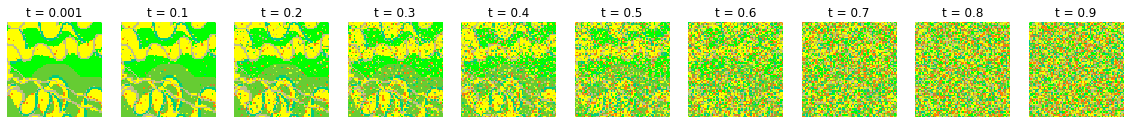

In [11]:
steps = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(20, 40))
for i, t in enumerate(steps):
    
    xt, _ = forward_process(x_test[5], tf.ones((1), dtype=tf.dtypes.float64) * t, nb_categories)

    plt.subplot(1, len(steps), i+1)
    plt.title("t = {}".format(t))
    plt.imshow(np.argmax(xt.numpy(), axis=-1).reshape((64, 64)),
                interpolation='nearest', cmap=cmap, norm=norm)
    plt.axis('off')
    
plt.show()

## Models

In [23]:
from models.ddm_mkj.diffusion_model import DiffusionModel

In [24]:
# create and compile the model
model = DiffusionModel(image_size,
                       categories_nb=nb_categories,
                       block_depth=2,
                       batch_size=30,
                       large_model=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss= tf.keras.losses.CategoricalCrossentropy(),
)

In [27]:
load_model = False

weights_folder = "./trained_weights/9facies_ddm"

if load_model:
    model.network.load_weights(weights_folder + "*/unet/cp-unet_discrete_jump_markov.ckpt")
    model.ema_network.load_weights(weights_folder + "/ema_unet/cp-ema_unet_discrete_jump_markov.ckpt")
    model.load_weights("/ddm/cp-ddm_discrete_jump_markov.ckpt")

In [28]:
train_model = True

if train_model:
    t_epochs_nb=500

    history = model.fit(x_train, batch_size=batch_size, shuffle=True, epochs=t_epochs_nb, validation_data=(x_test,))

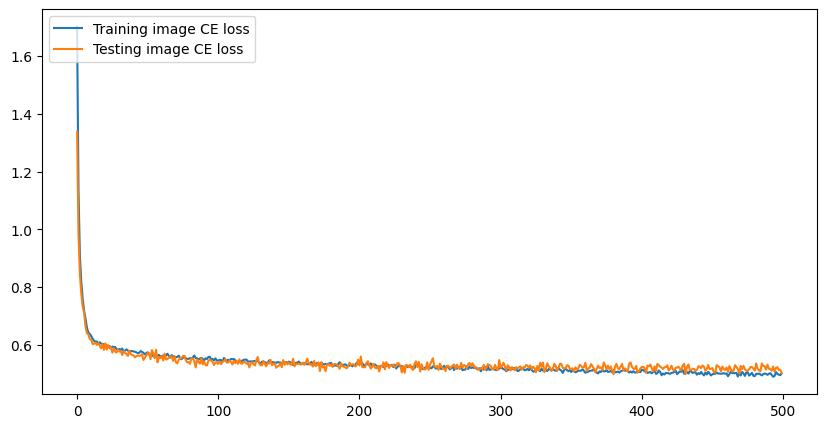

In [32]:
if train_model:
    x_axis = np.arange(t_epochs_nb)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, history.history["i_loss"], label="Training image CE loss")
    plt.plot(x_axis, history.history["val_i_loss"], label="Testing image CE loss")
    plt.legend(loc="upper left")
    plt.show()

In [31]:
import os

# To save a trained model change this variable to True
SAVE_AND_TAR_RESULTS_WEIGHTS = False

if SAVE_AND_TAR_RESULTS_WEIGHTS:
    diffusion_checkpoint_path = "ddm_discrete_jump_markov_weights_9facies/cp-ddm_discrete_jump_markov.ckpt"
    diffusion_checkpoint_dir = os.path.dirname(diffusion_checkpoint_path)

    model.save_weights(diffusion_checkpoint_path)

    !tar -czvf ddm_discrete_jump_markov_weights_9facies.tar.gz ./ddm_discrete_jump_markov_weights_9facies

    unet_checkpoint_path = "unet_discrete_jump_markov_weights_9facies/cp-unet_discrete_jump_markov.ckpt"
    unet_checkpoint_dir = os.path.dirname(unet_checkpoint_path)

    model.network.save_weights(unet_checkpoint_path)

    !tar -czvf unet_discrete_jump_markov_weights_9facies.tar.gz ./unet_discrete_jump_markov_weights_9facies

    ema_unet_checkpoint_path = "ema_unet_discrete_jump_markov_weights_9facies/cp-ema_unet_discrete_jump_markov.ckpt"
    ema_unet_checkpoint_dir = os.path.dirname(ema_unet_checkpoint_path)

    model.ema_network.save_weights(ema_unet_checkpoint_path)

    !tar -czvf ema_unet_discrete_jump_markov_weights_9facies.tar.gz ./ema_unet_discrete_jump_markov_weights_9facies

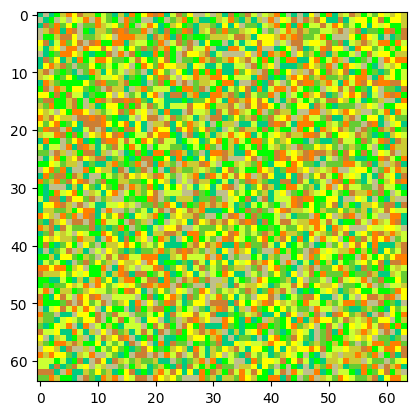

i: 0, step: 0.98


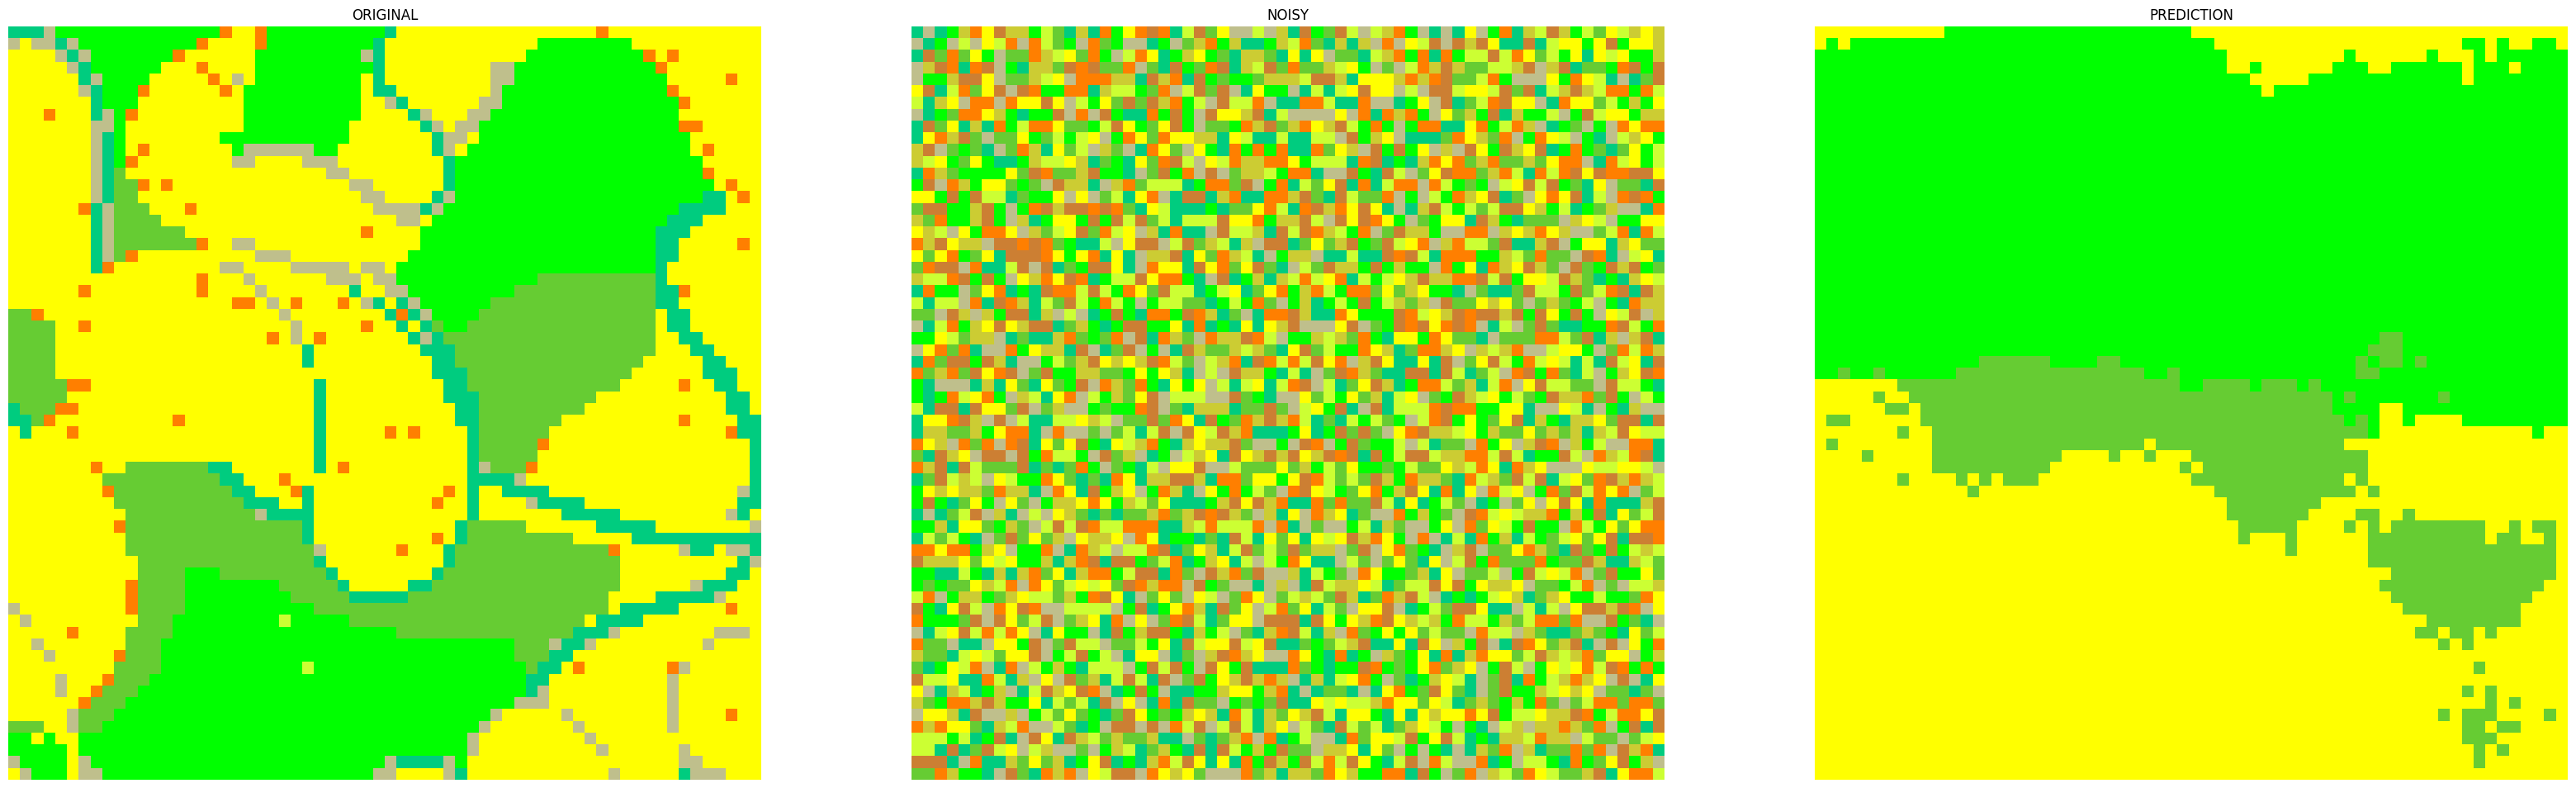

tf.Tensor([[[[0.98]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.97]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.06643922 0.06662205 0.0664824  0.06641218 0.06642296 0.06641394
 0.06648623 0.06659034 0.46813067], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 1, step: 0.97


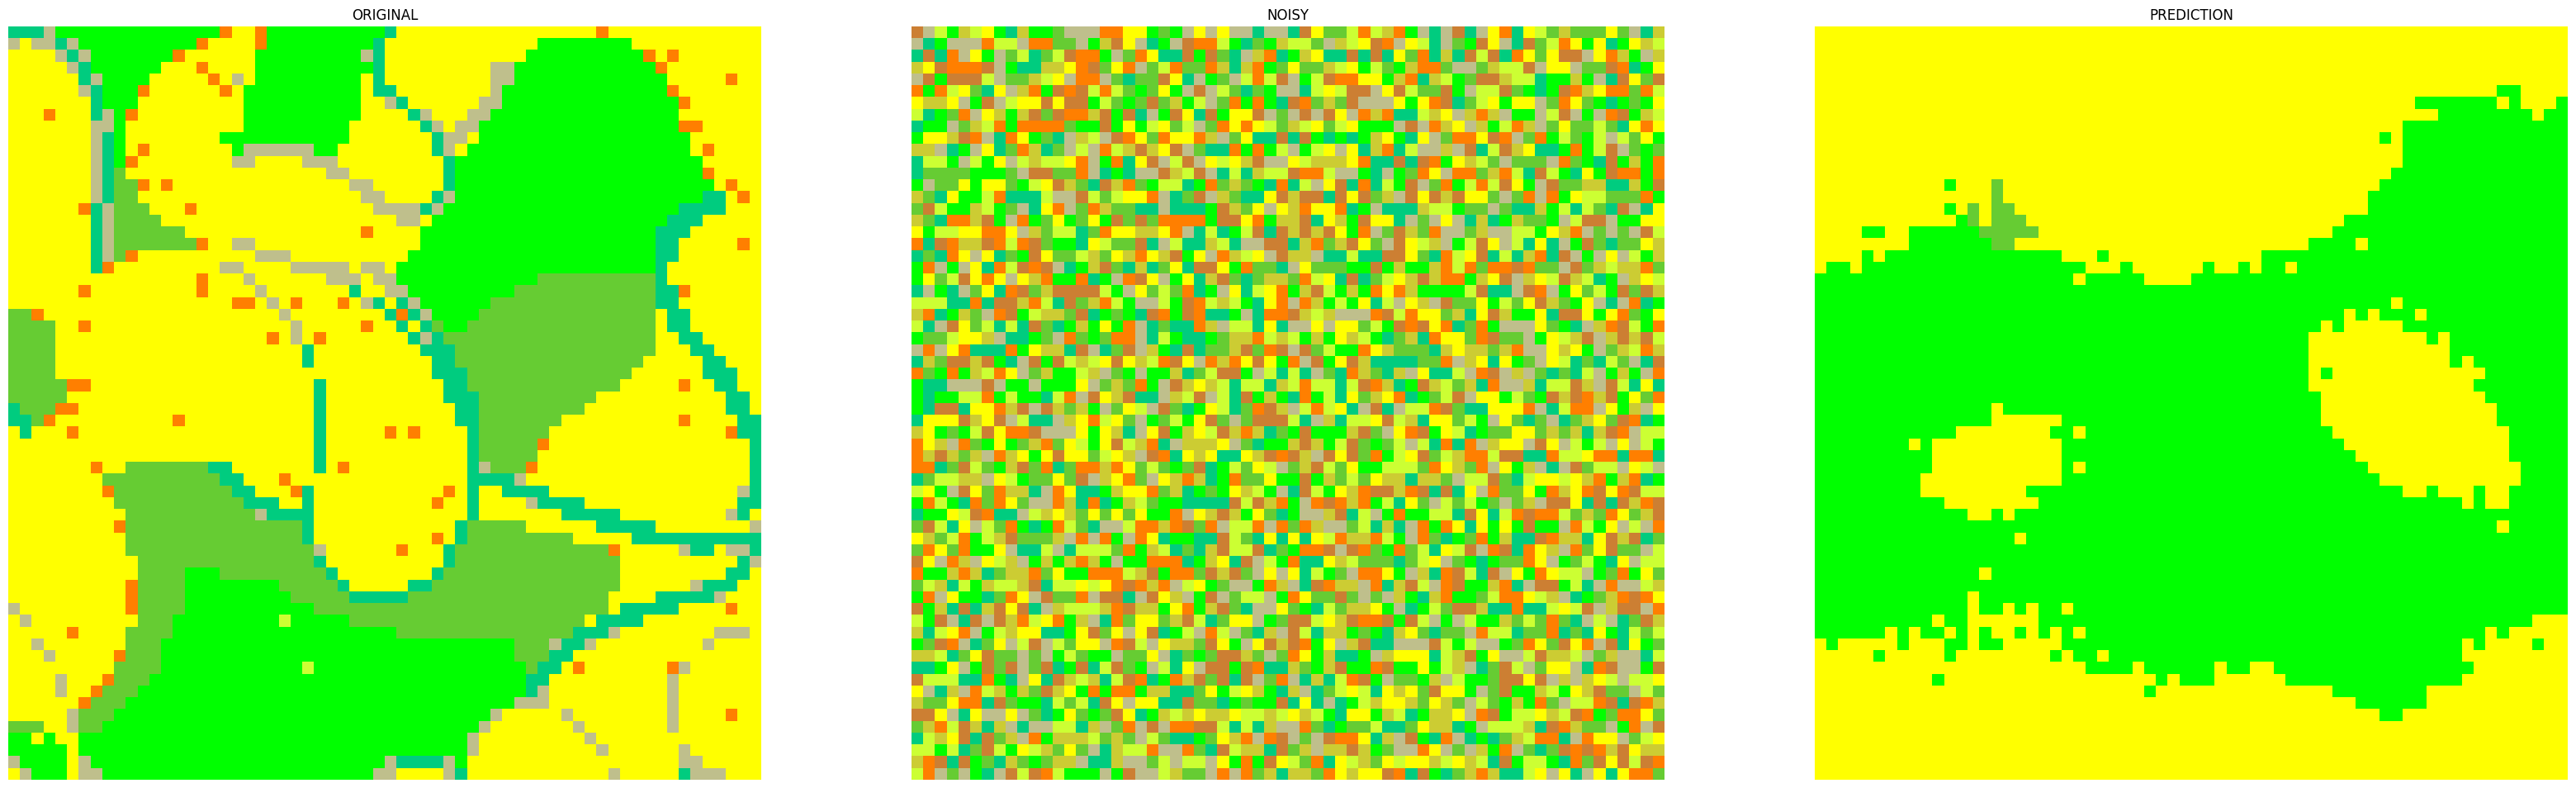

tf.Tensor([[[[0.97]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.96]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.05291011 0.05325494 0.05297038 0.57617849 0.05287577 0.05286404
 0.05298768 0.05303099 0.05292759], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 2, step: 0.96


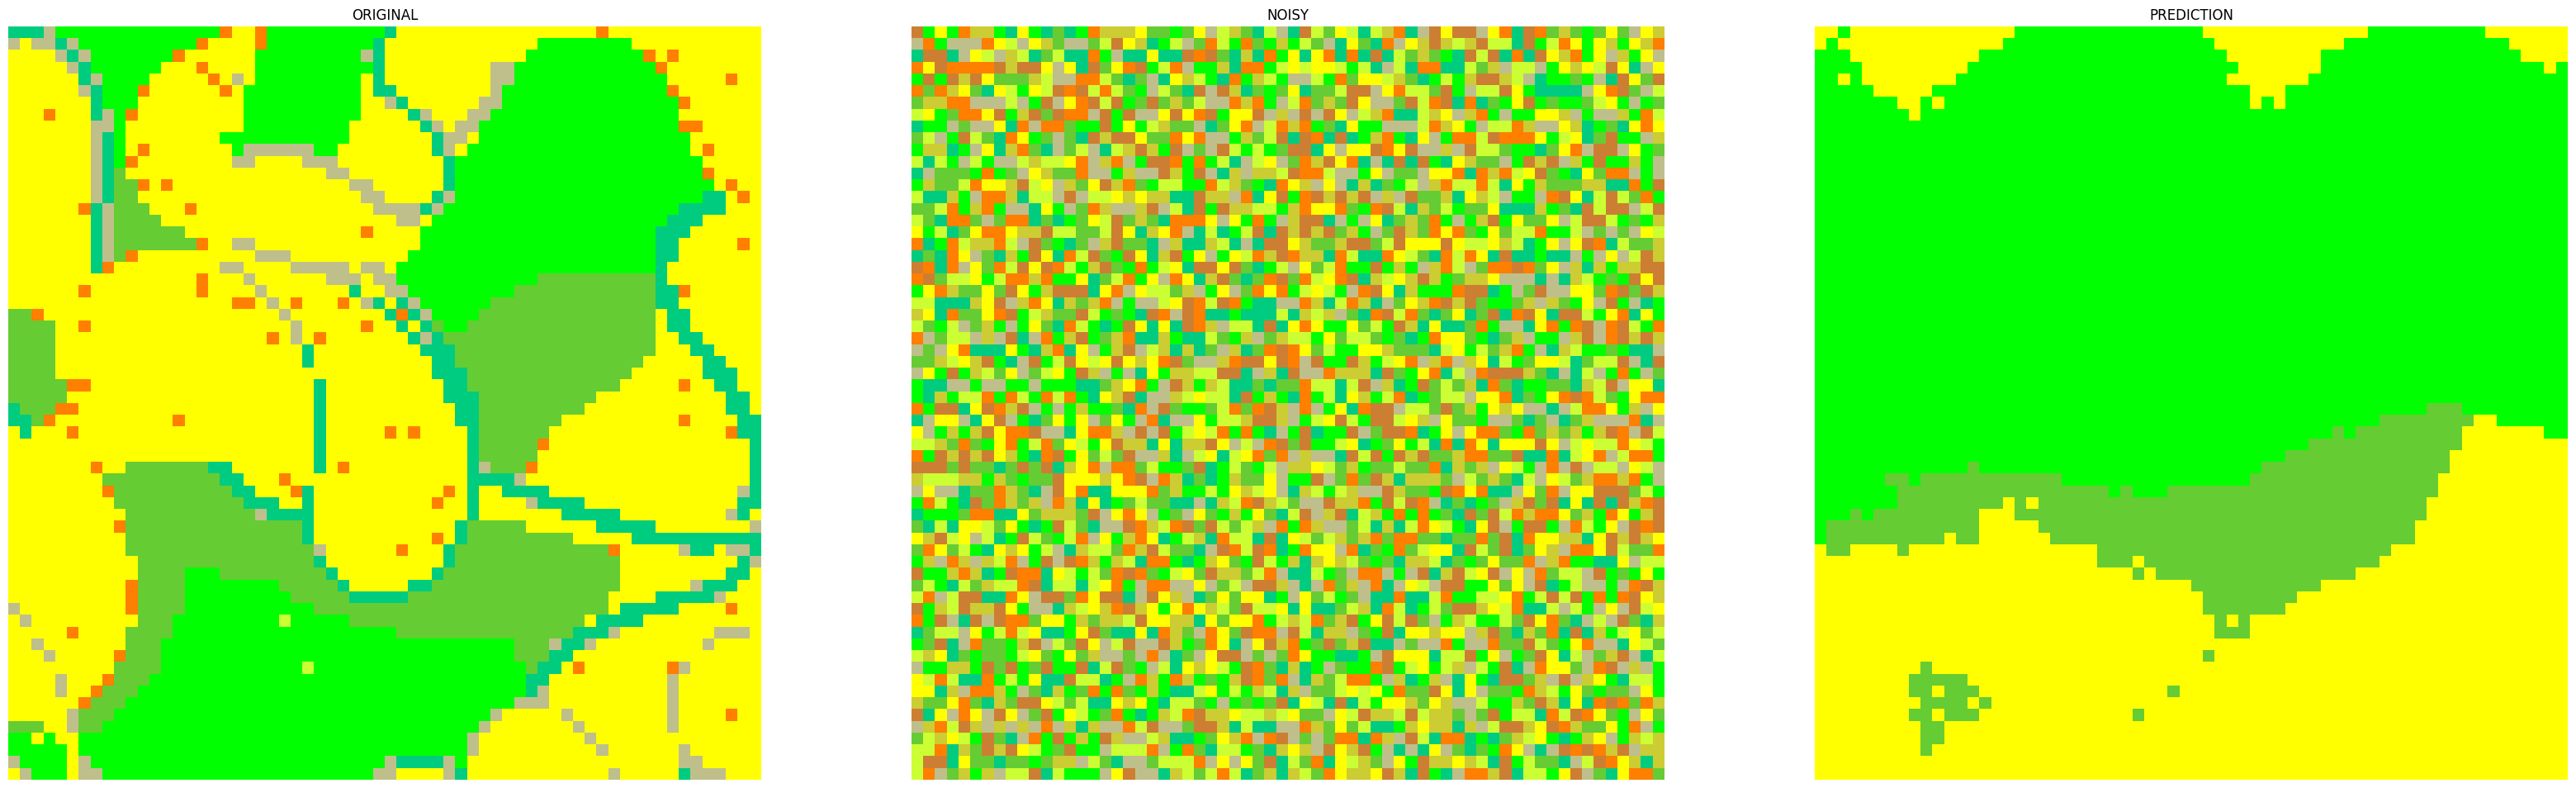

tf.Tensor([[[[0.96]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.95]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.04380529 0.04421619 0.04387579 0.648752   0.04376503 0.04374911
 0.04386663 0.0441635  0.04380646], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 3, step: 0.9500000000000001


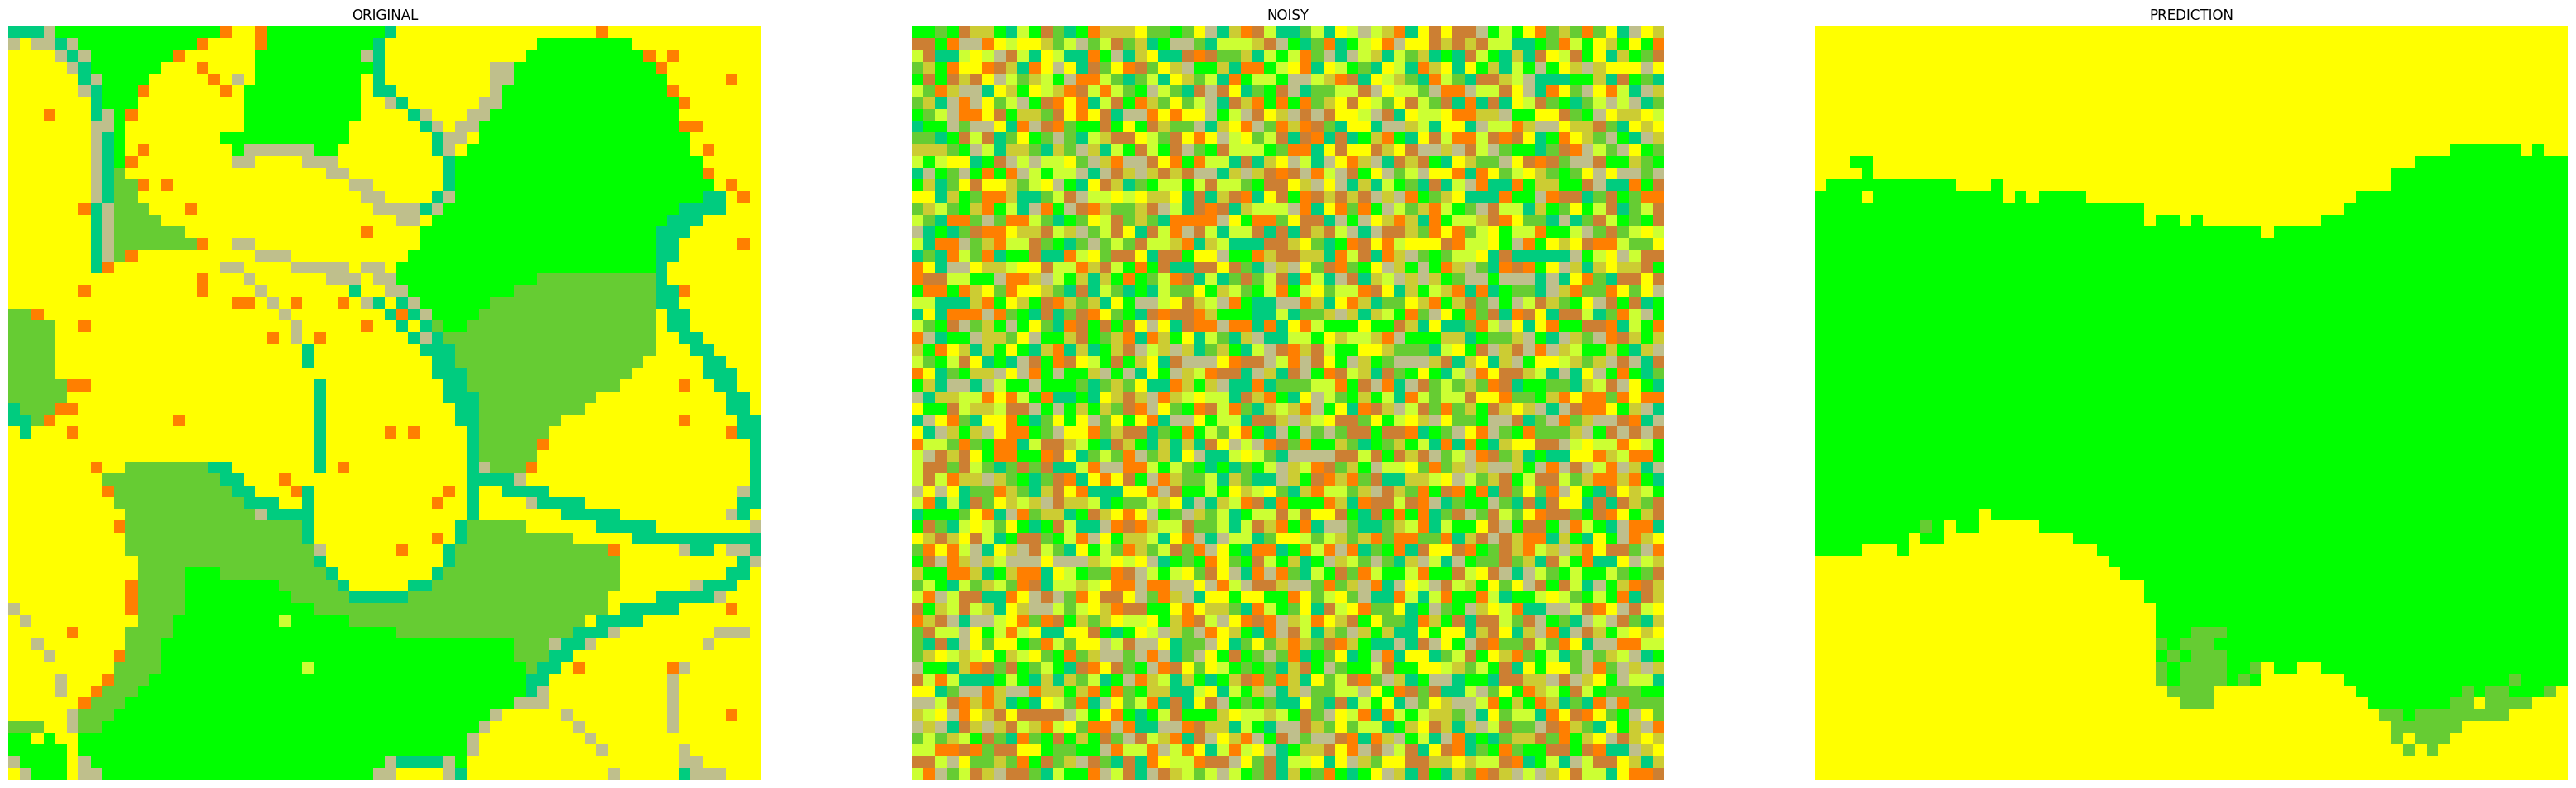

tf.Tensor([[[[0.95]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.94]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.03711013 0.03770232 0.03716334 0.03702051 0.0370427  0.0370239
 0.03726367 0.70256073 0.03711271], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 4, step: 0.9400000000000001


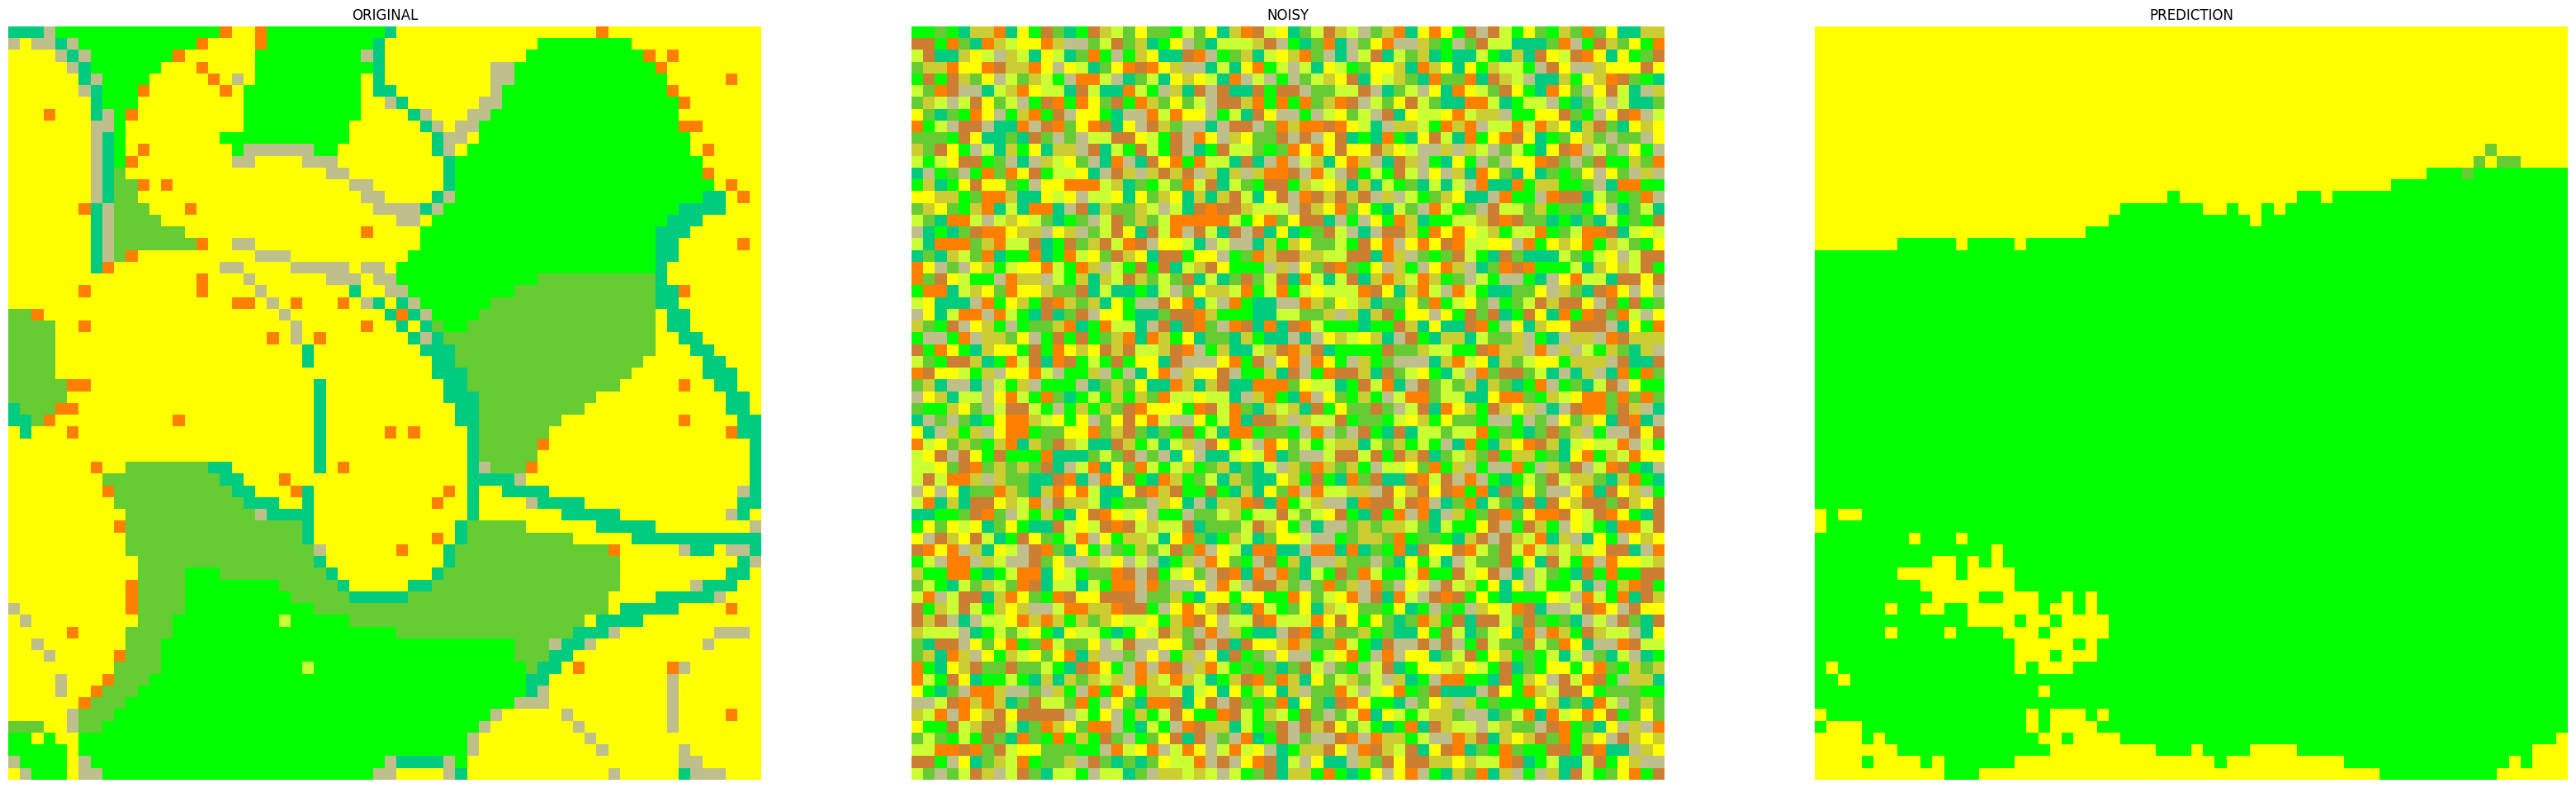

tf.Tensor([[[[0.94]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.93]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.03231405 0.03314821 0.0323907  0.03220228 0.03222613 0.03220619
 0.03251682 0.74066447 0.03233116], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 5, step: 0.93


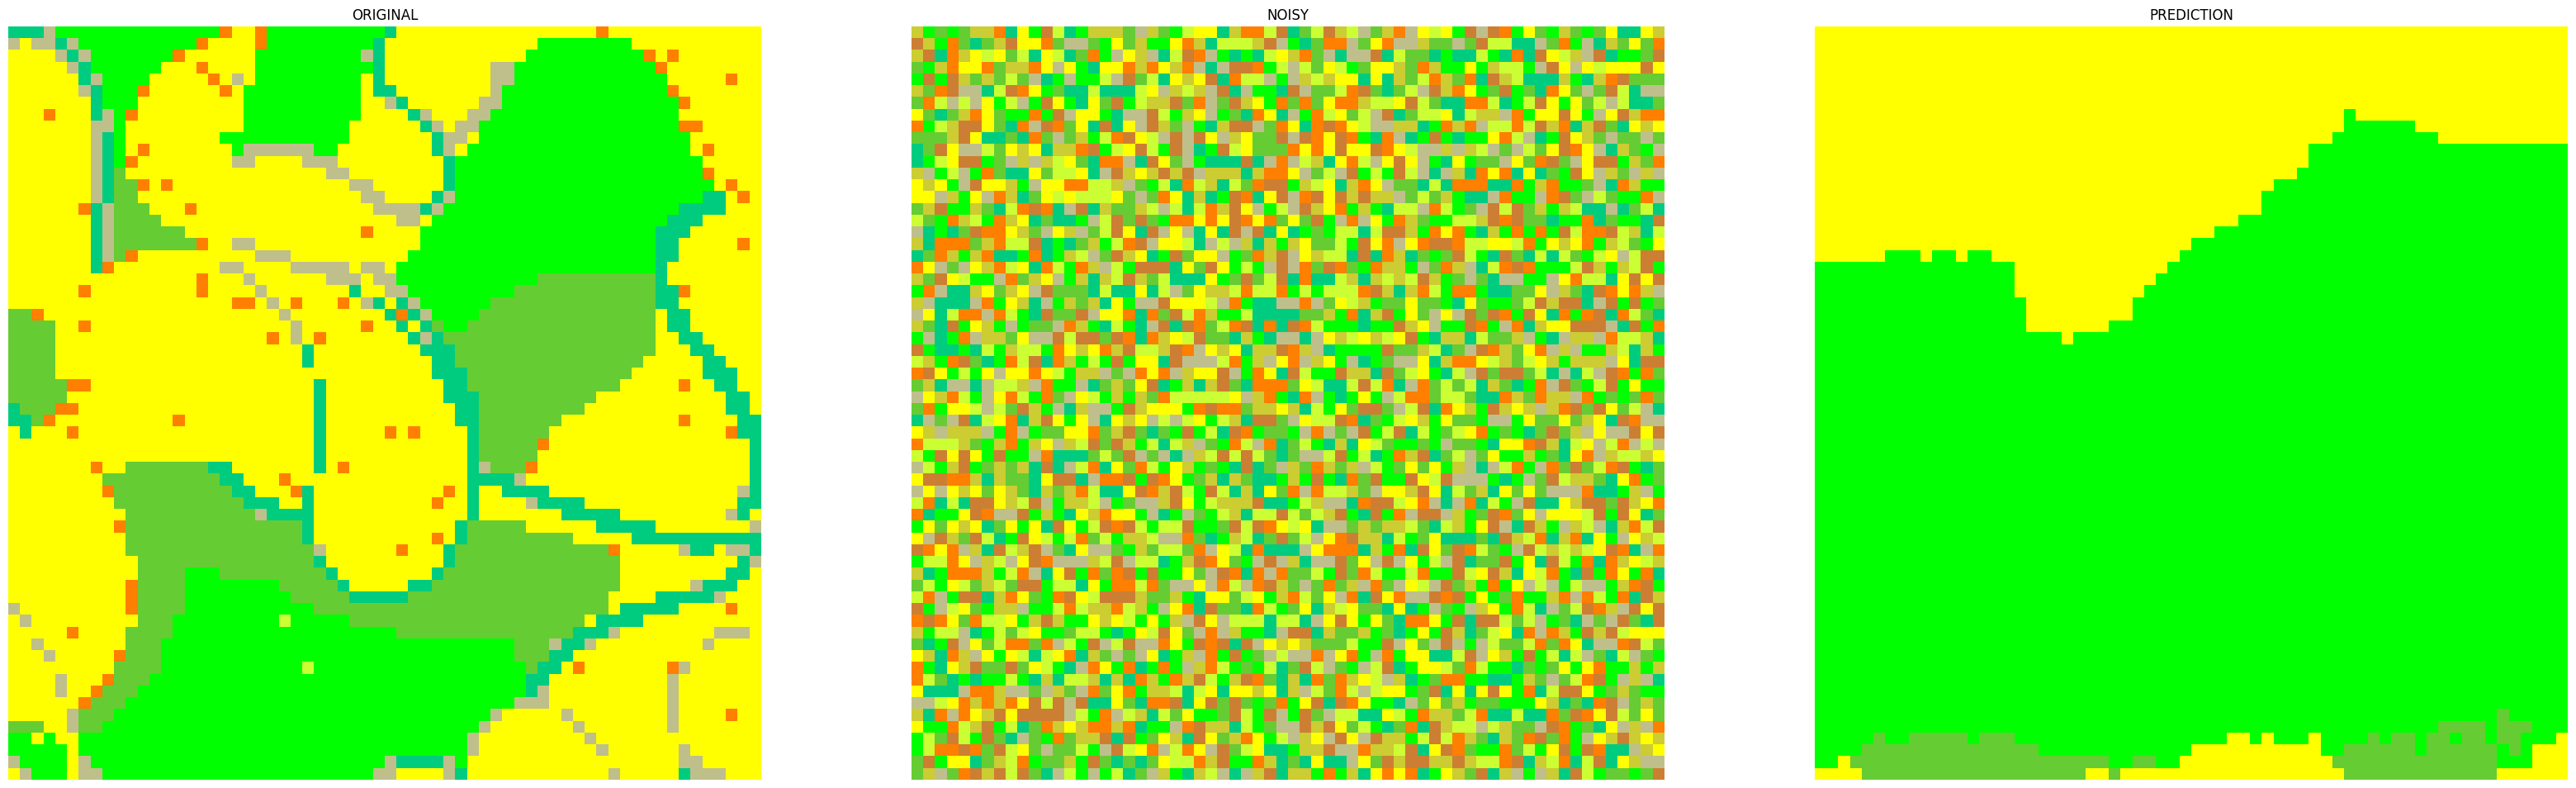

tf.Tensor([[[[0.93]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.92]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0287709  0.02968571 0.02886839 0.0286481  0.02867194 0.76840518
 0.02909444 0.0290651  0.02879023], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 6, step: 0.92


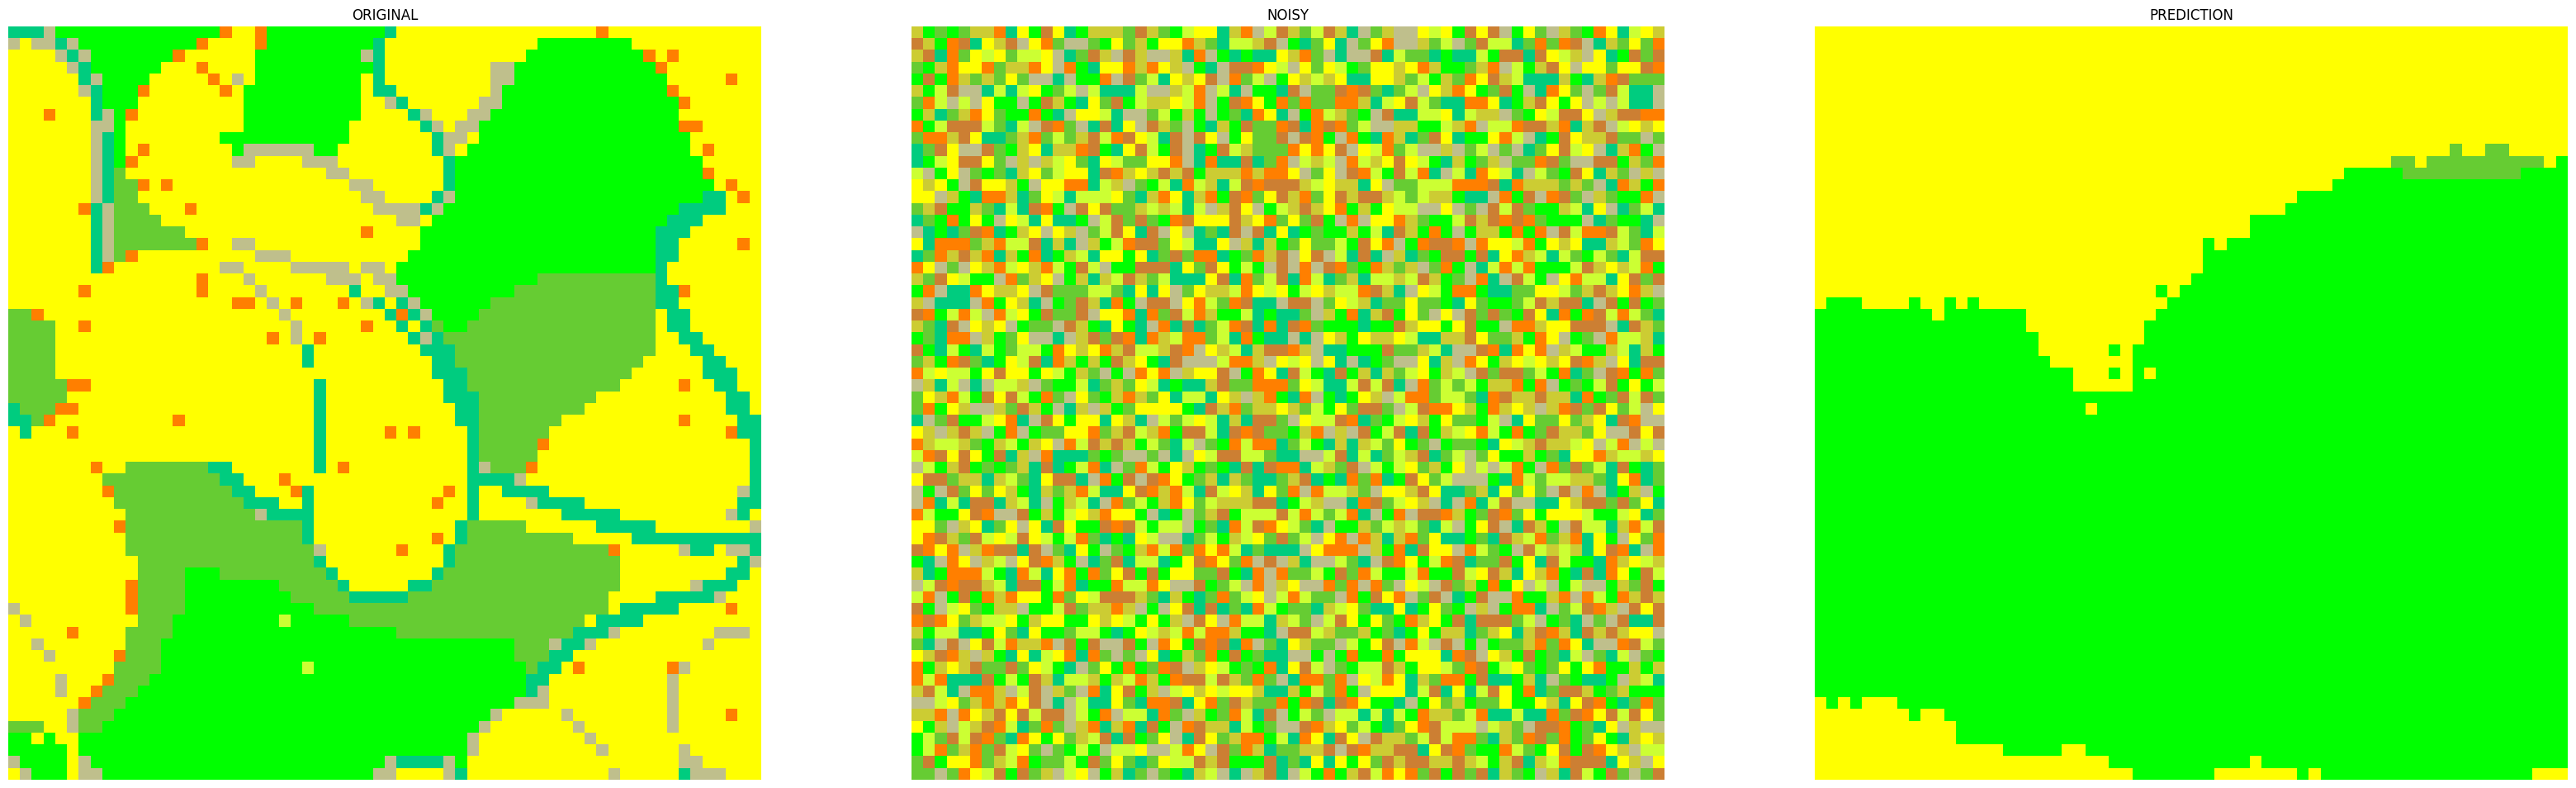

tf.Tensor([[[[0.92]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.91]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.02580646 0.02689915 0.02592113 0.02565589 0.0256906  0.791944
 0.02608722 0.02617321 0.02582234], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 7, step: 0.91


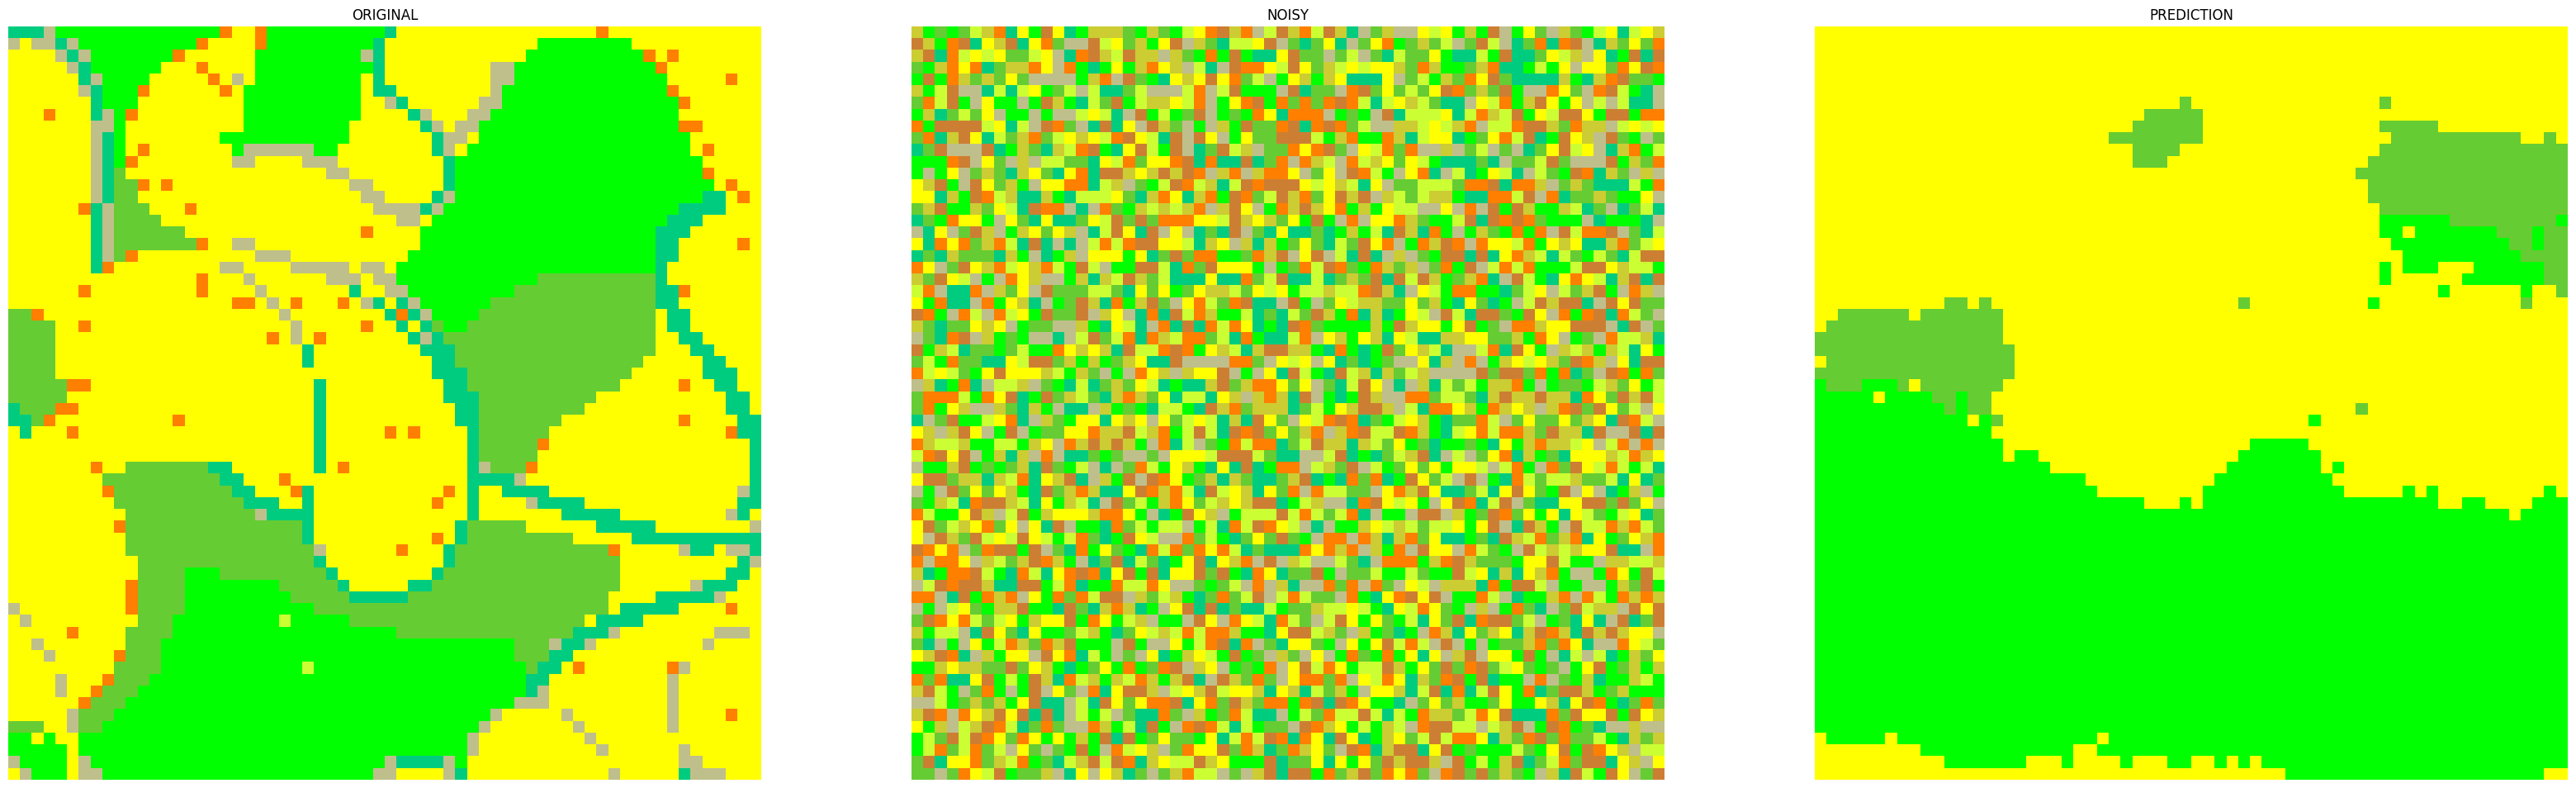

tf.Tensor([[[[0.91]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.9]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.02337454 0.02435055 0.02350392 0.0232142  0.02326581 0.81107155
 0.02378334 0.02403317 0.02340292], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 8, step: 0.9


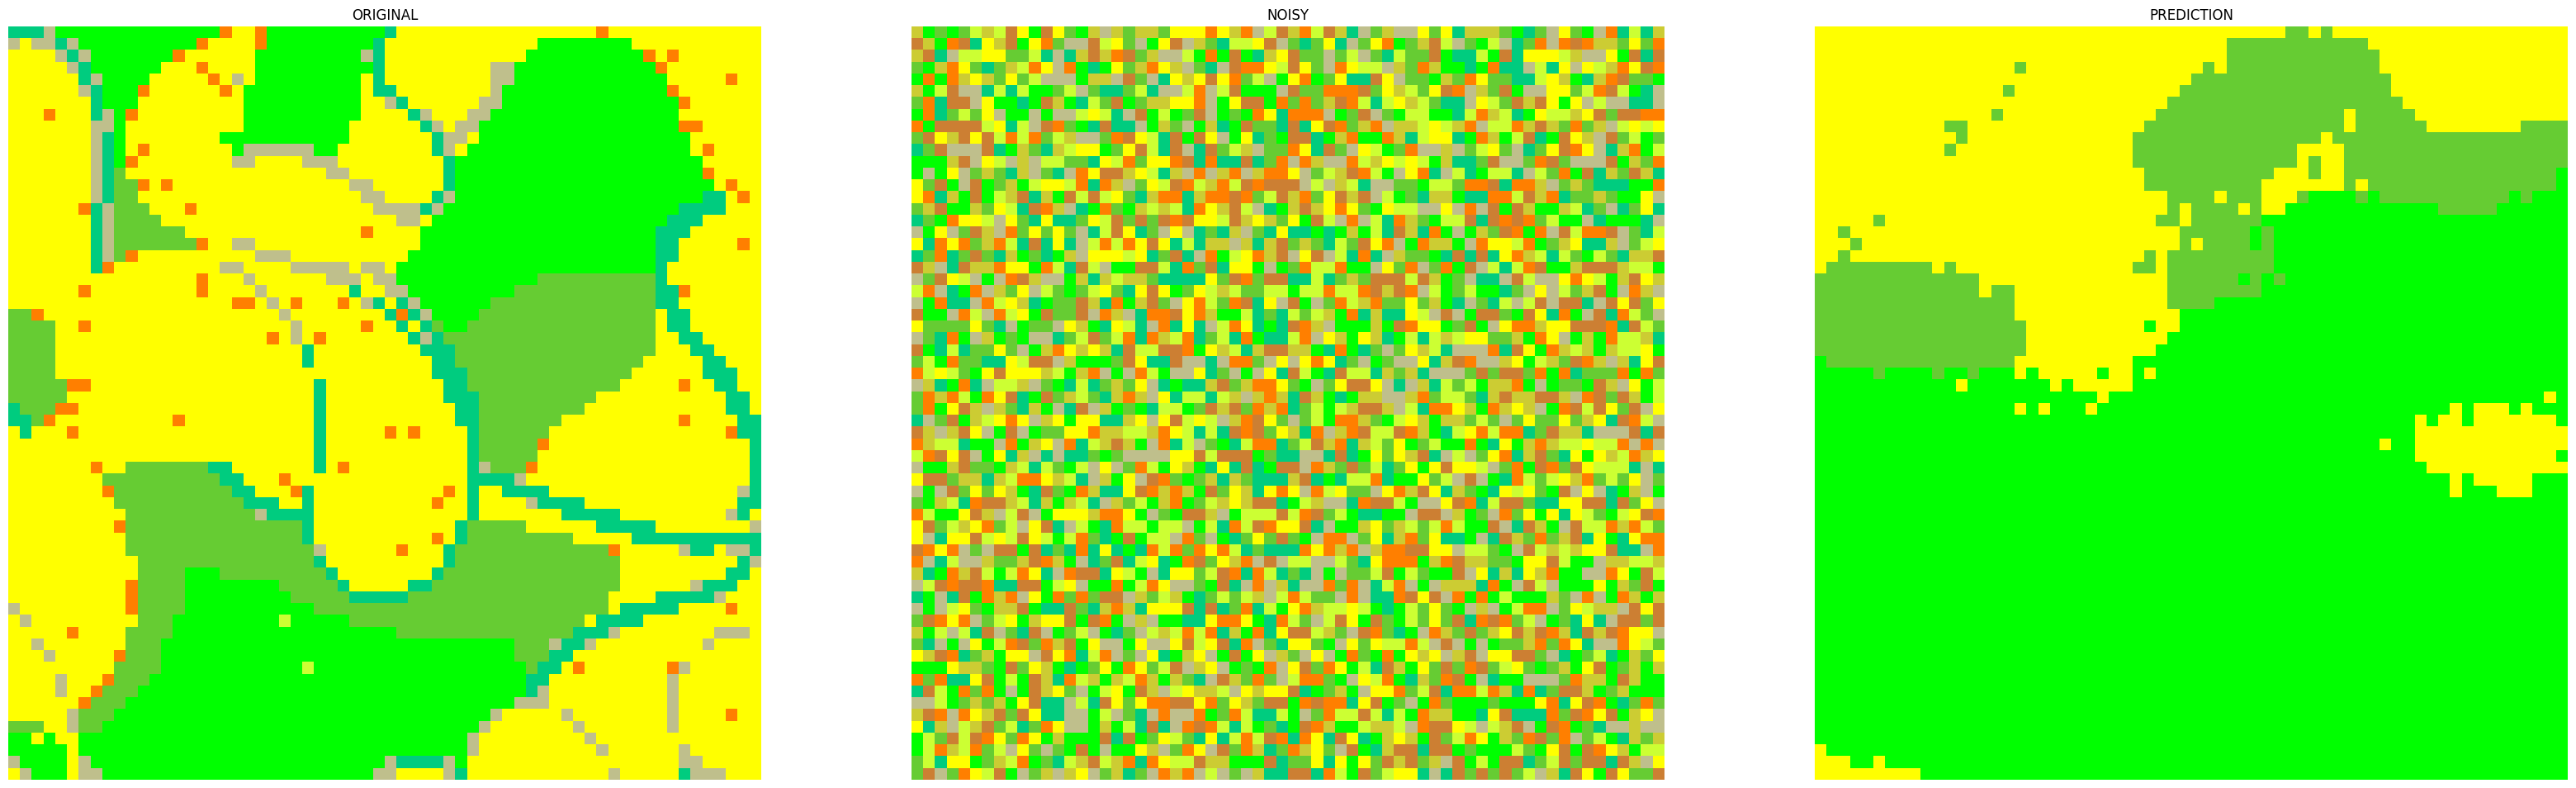

tf.Tensor([[[[0.9]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.89]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.02137689 0.02260096 0.02151491 0.02118682 0.02123282 0.82685186
 0.02190509 0.02191382 0.02141684], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 9, step: 0.89


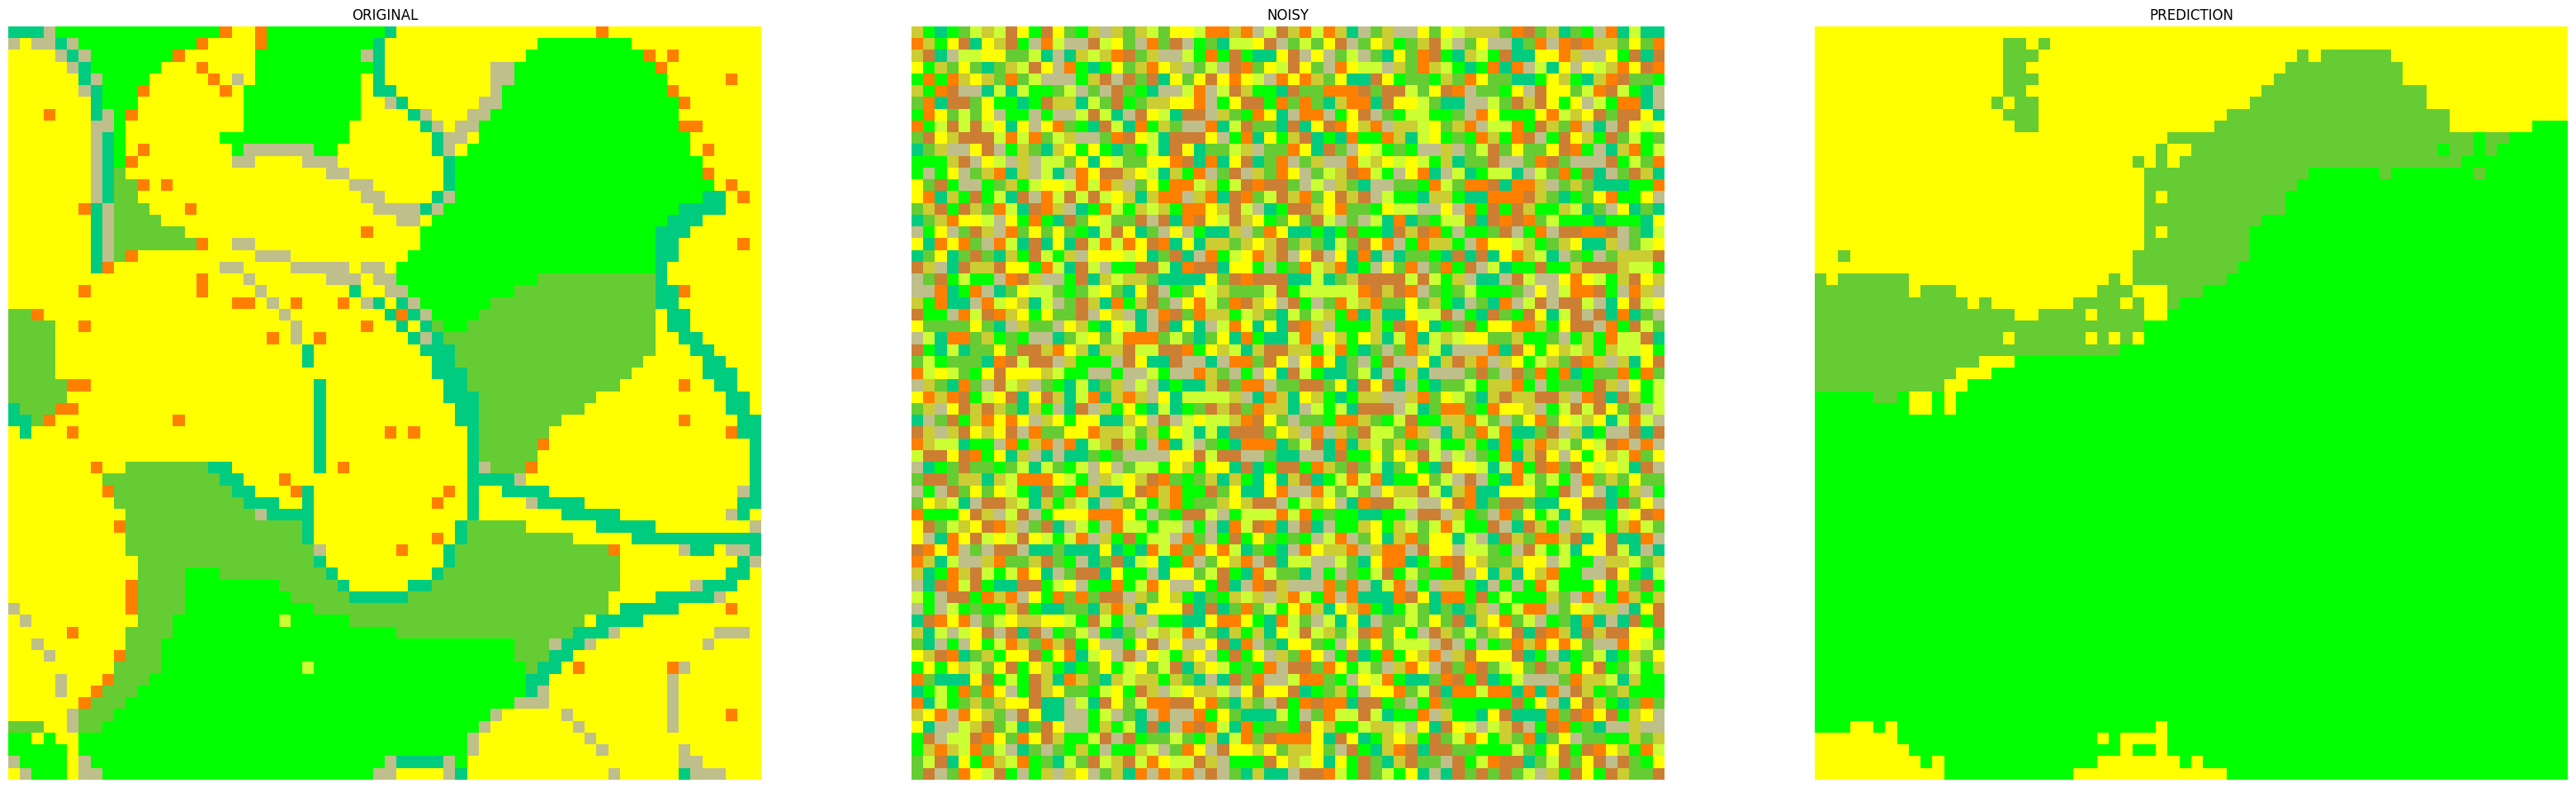

tf.Tensor([[[[0.89]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.88]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0197026  0.02138972 0.01984163 0.01947443 0.01951617 0.84010129
 0.02011654 0.02013106 0.01972655], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 10, step: 0.88


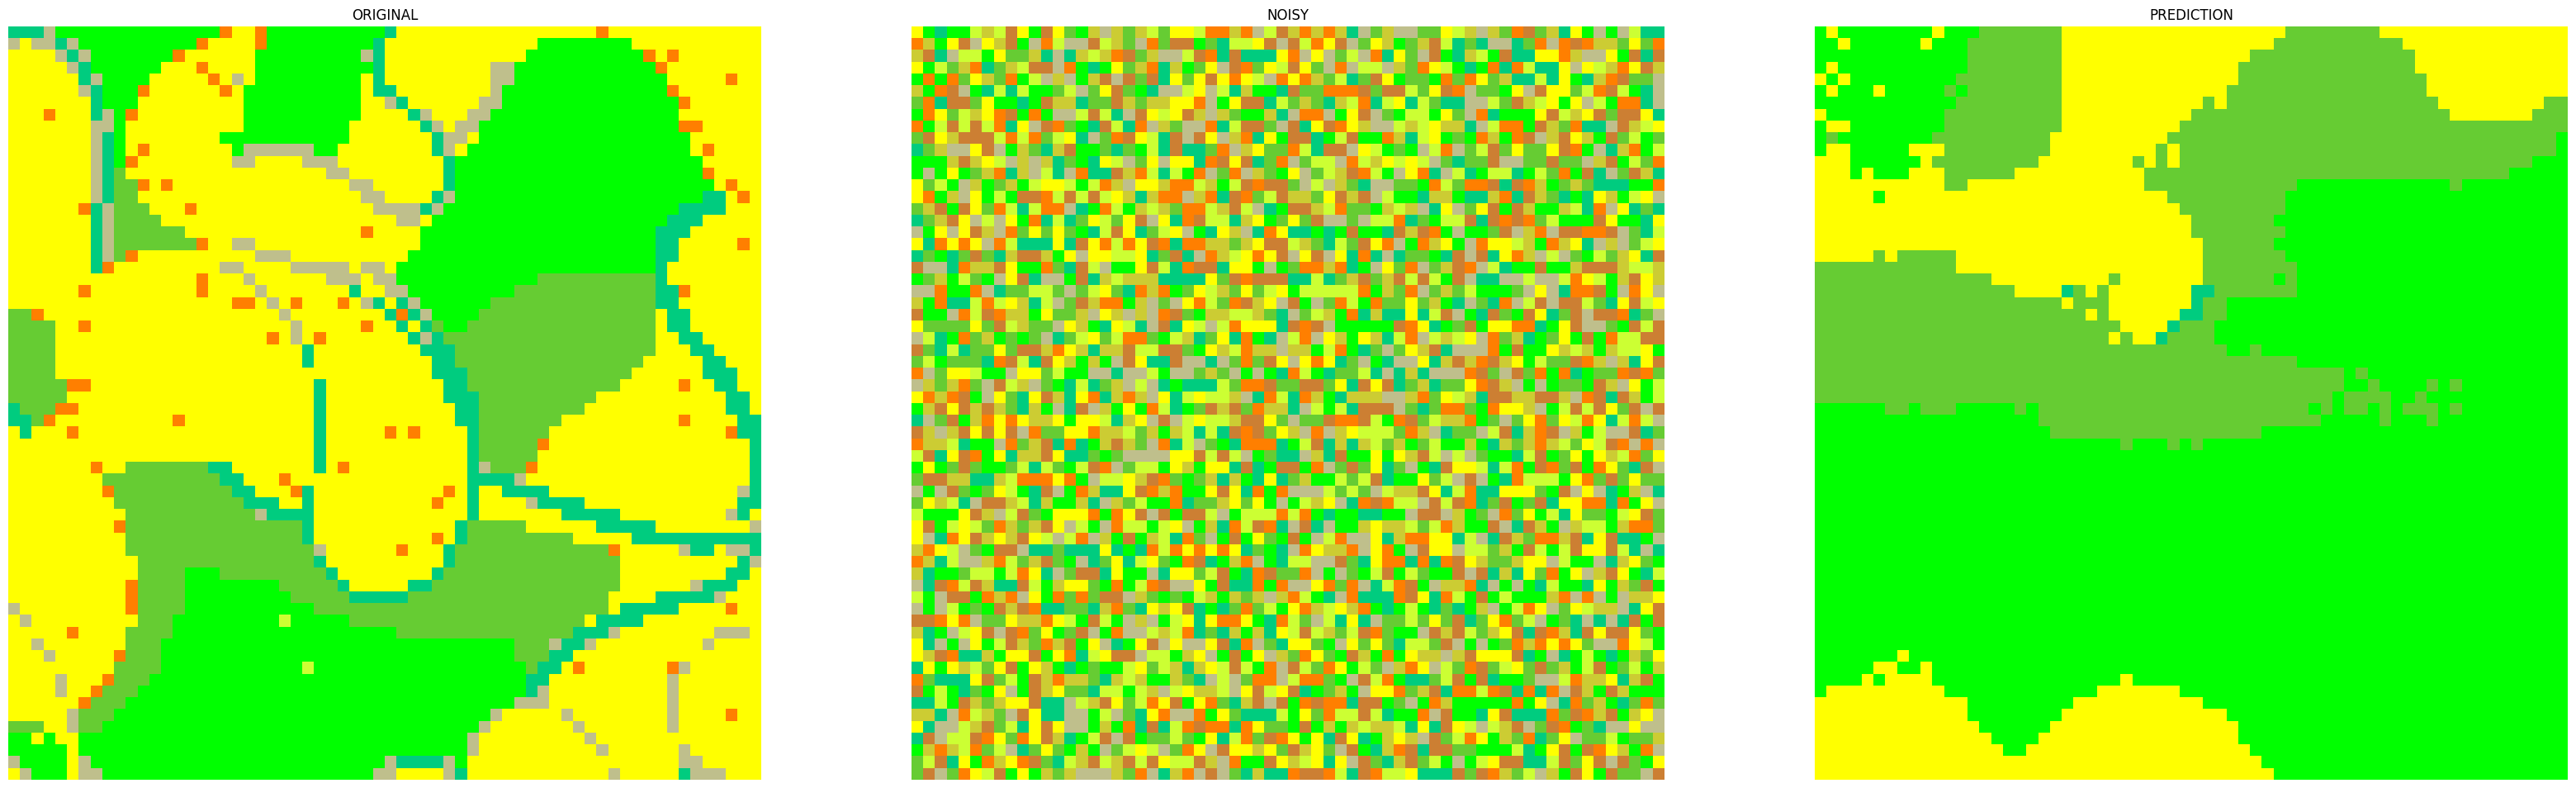

tf.Tensor([[[[0.88]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.87]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0171782  0.86089389 0.01732466 0.01700174 0.01704288 0.0170094
 0.01761401 0.01873567 0.01719956], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 11, step: 0.87


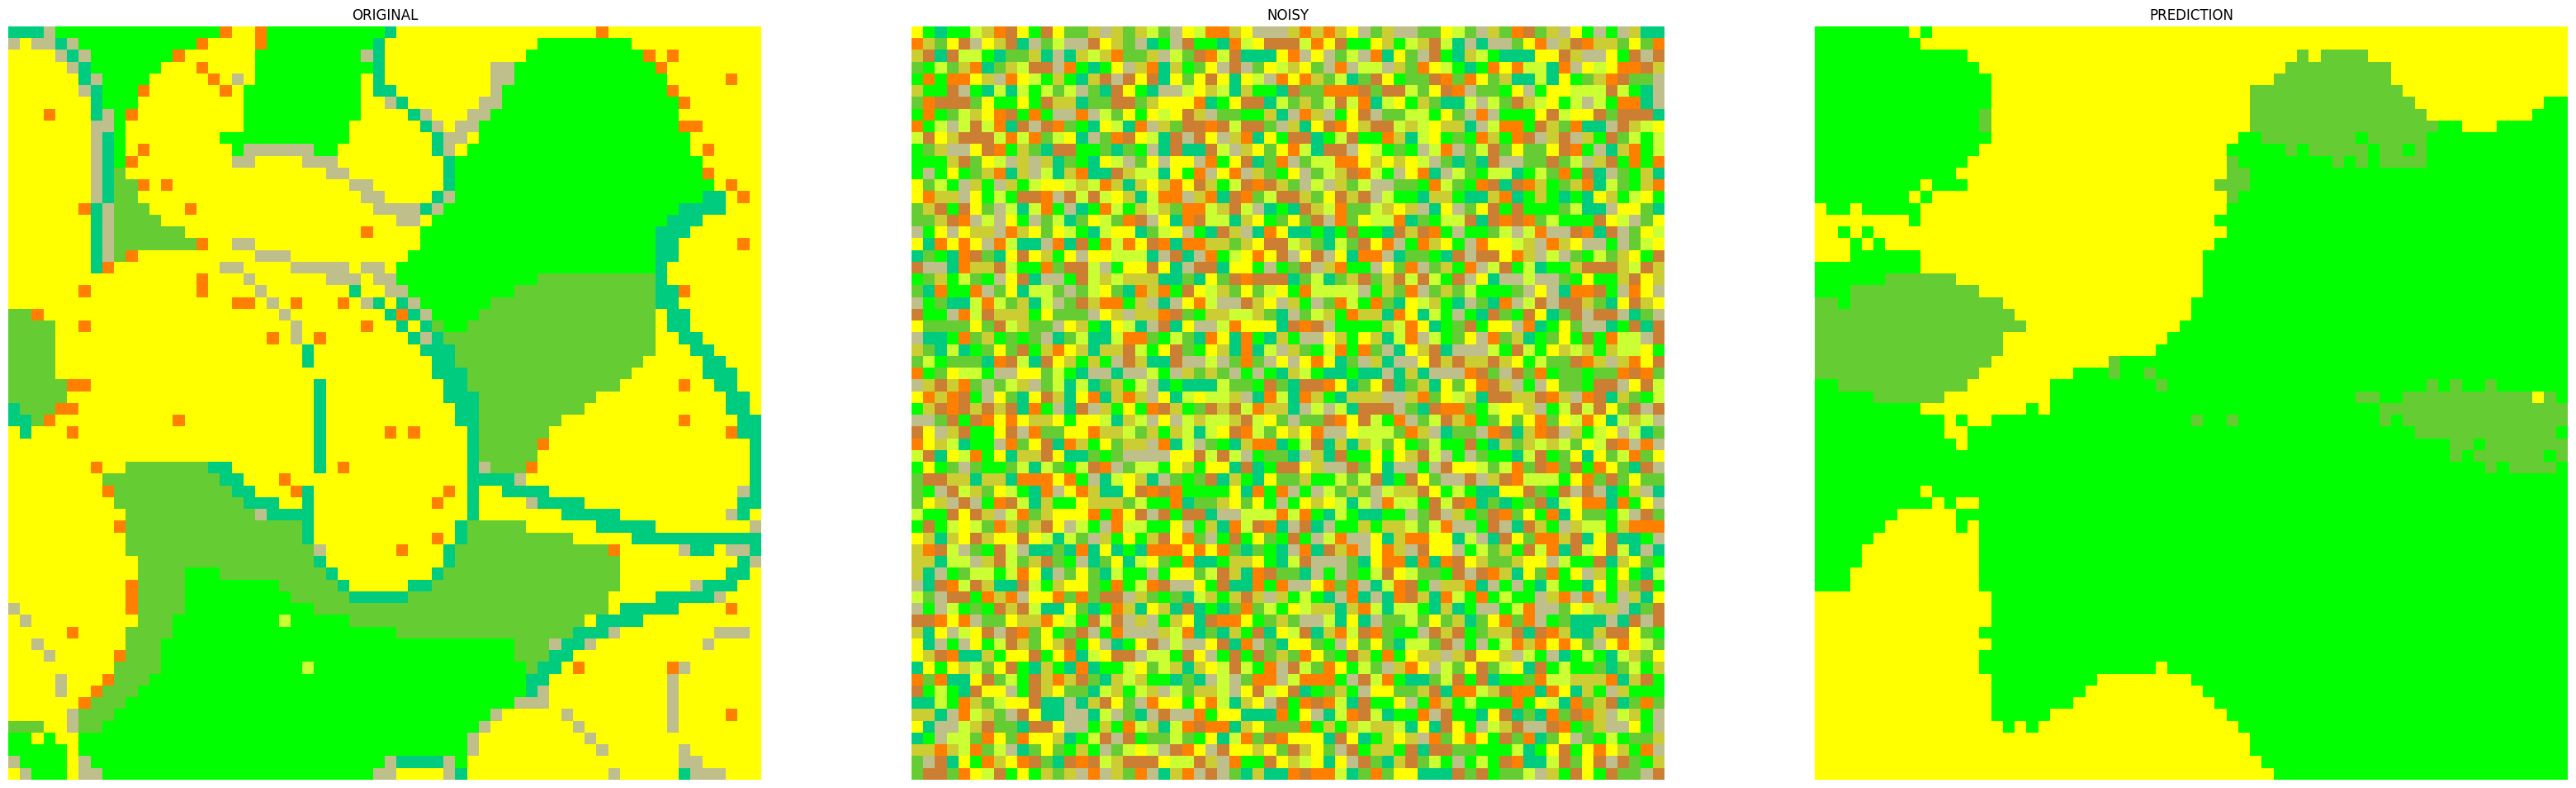

tf.Tensor([[[[0.87]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.86]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01592681 0.87040643 0.01612269 0.01575517 0.01580887 0.01576462
 0.01663249 0.01759298 0.01598993], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 12, step: 0.86


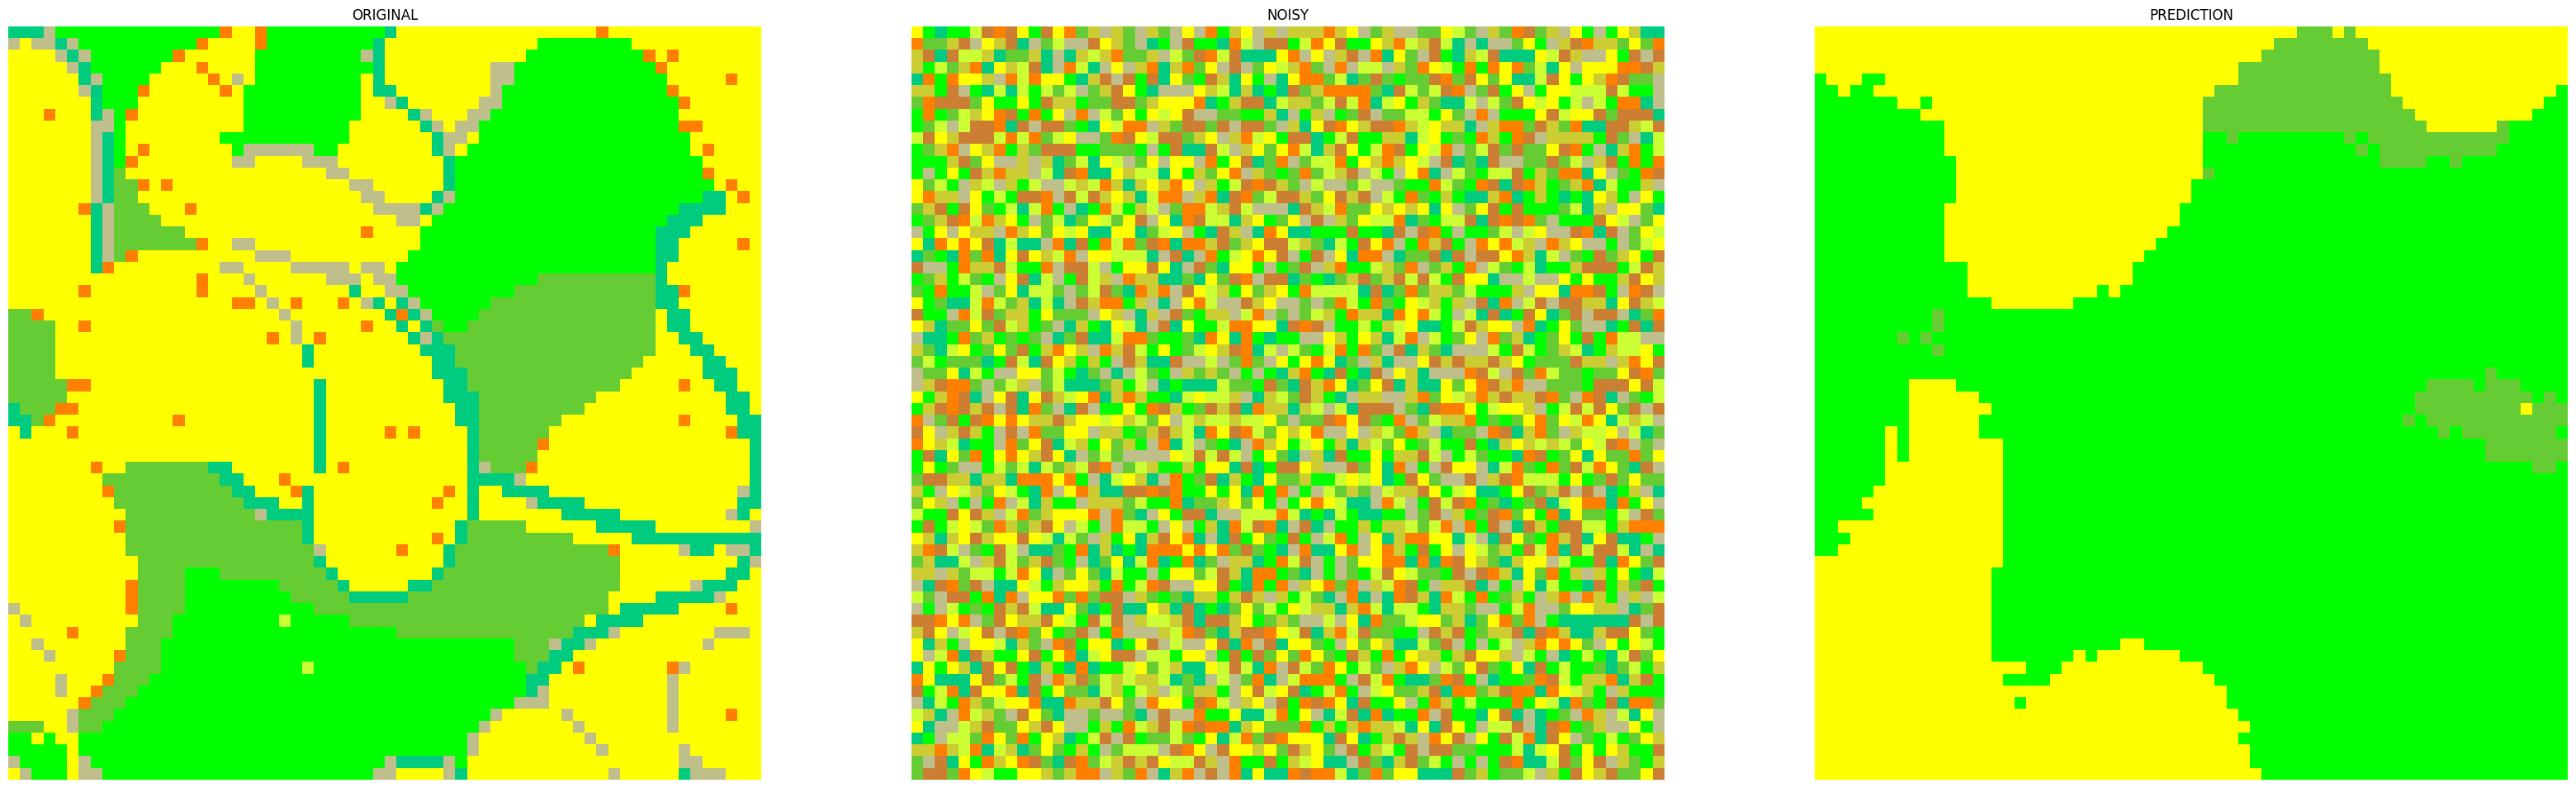

tf.Tensor([[[[0.86]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.85]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01445803 0.8826717  0.0146876  0.01424327 0.01429878 0.01425152
 0.0155323  0.01530467 0.01455212], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 13, step: 0.85


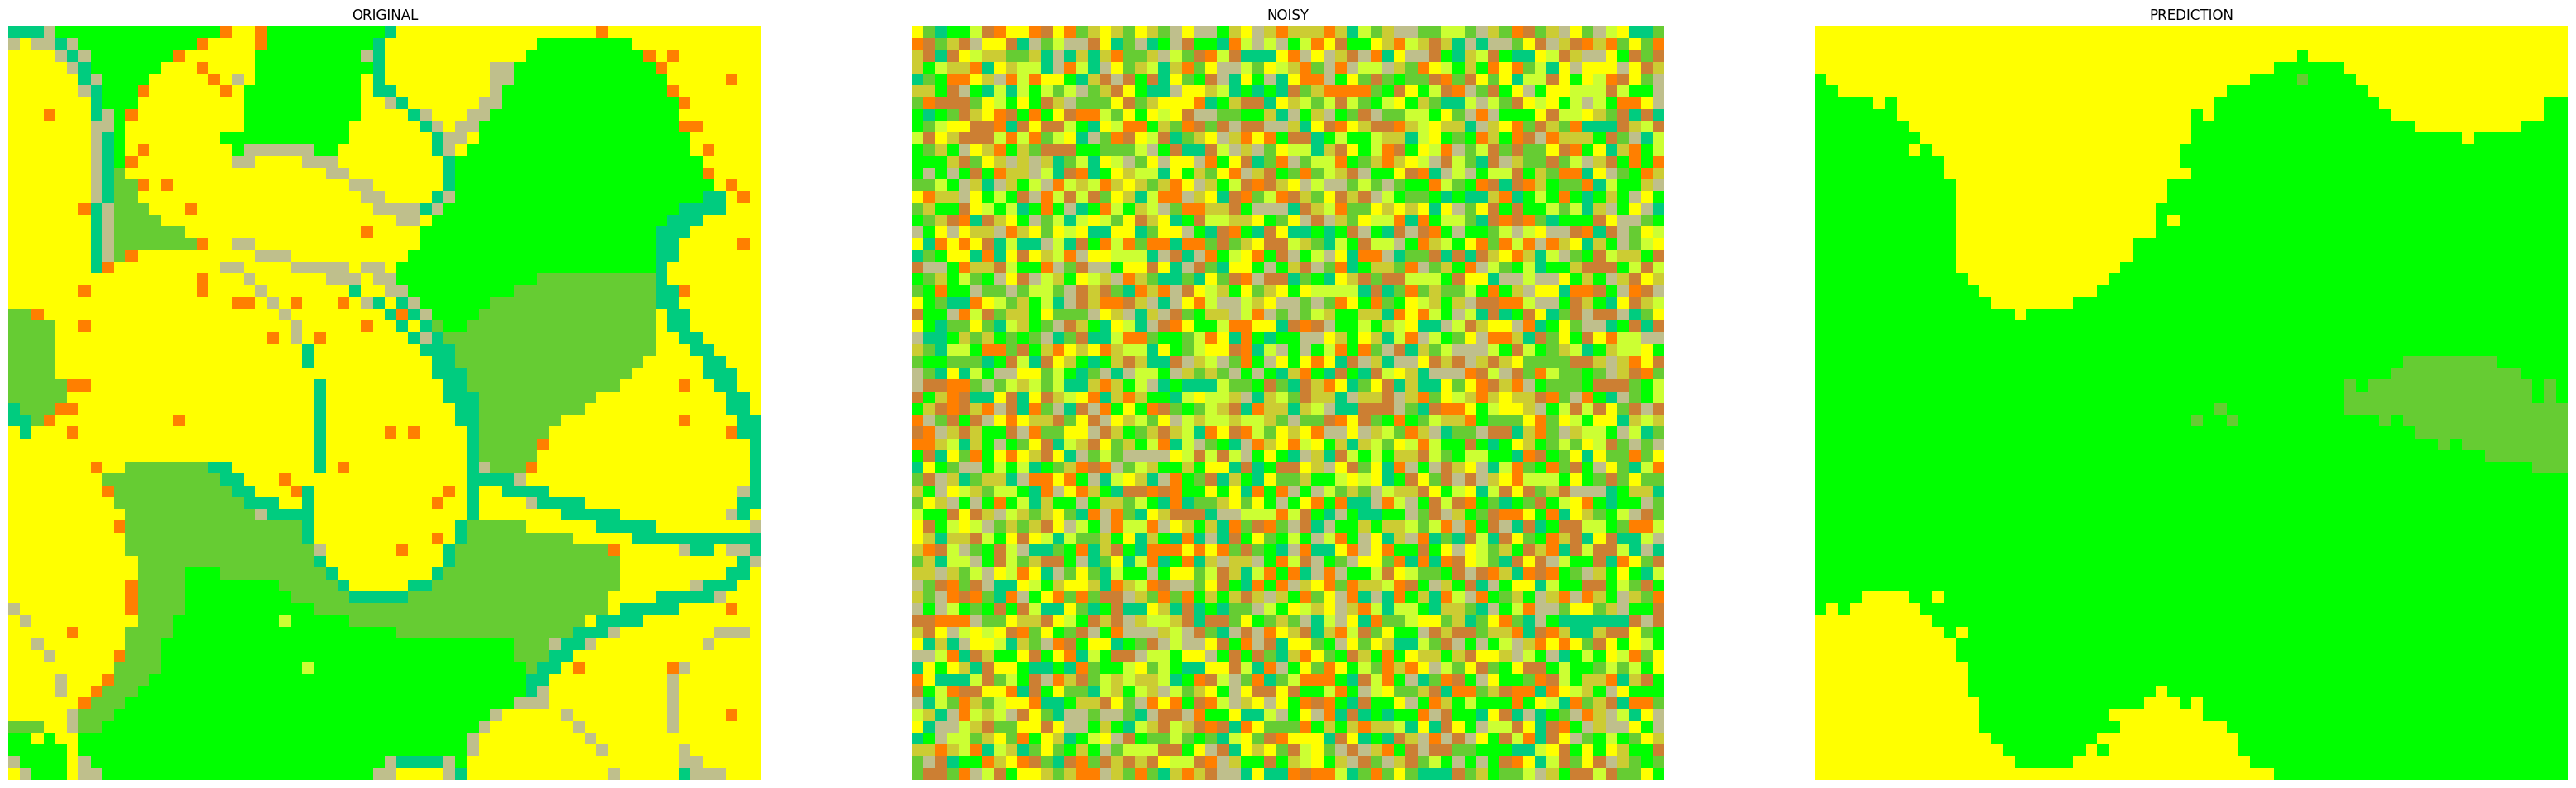

tf.Tensor([[[[0.85]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.84]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01287318 0.89619509 0.01305366 0.01262477 0.01266237 0.01263049
 0.01348262 0.01359647 0.01288134], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 14, step: 0.84


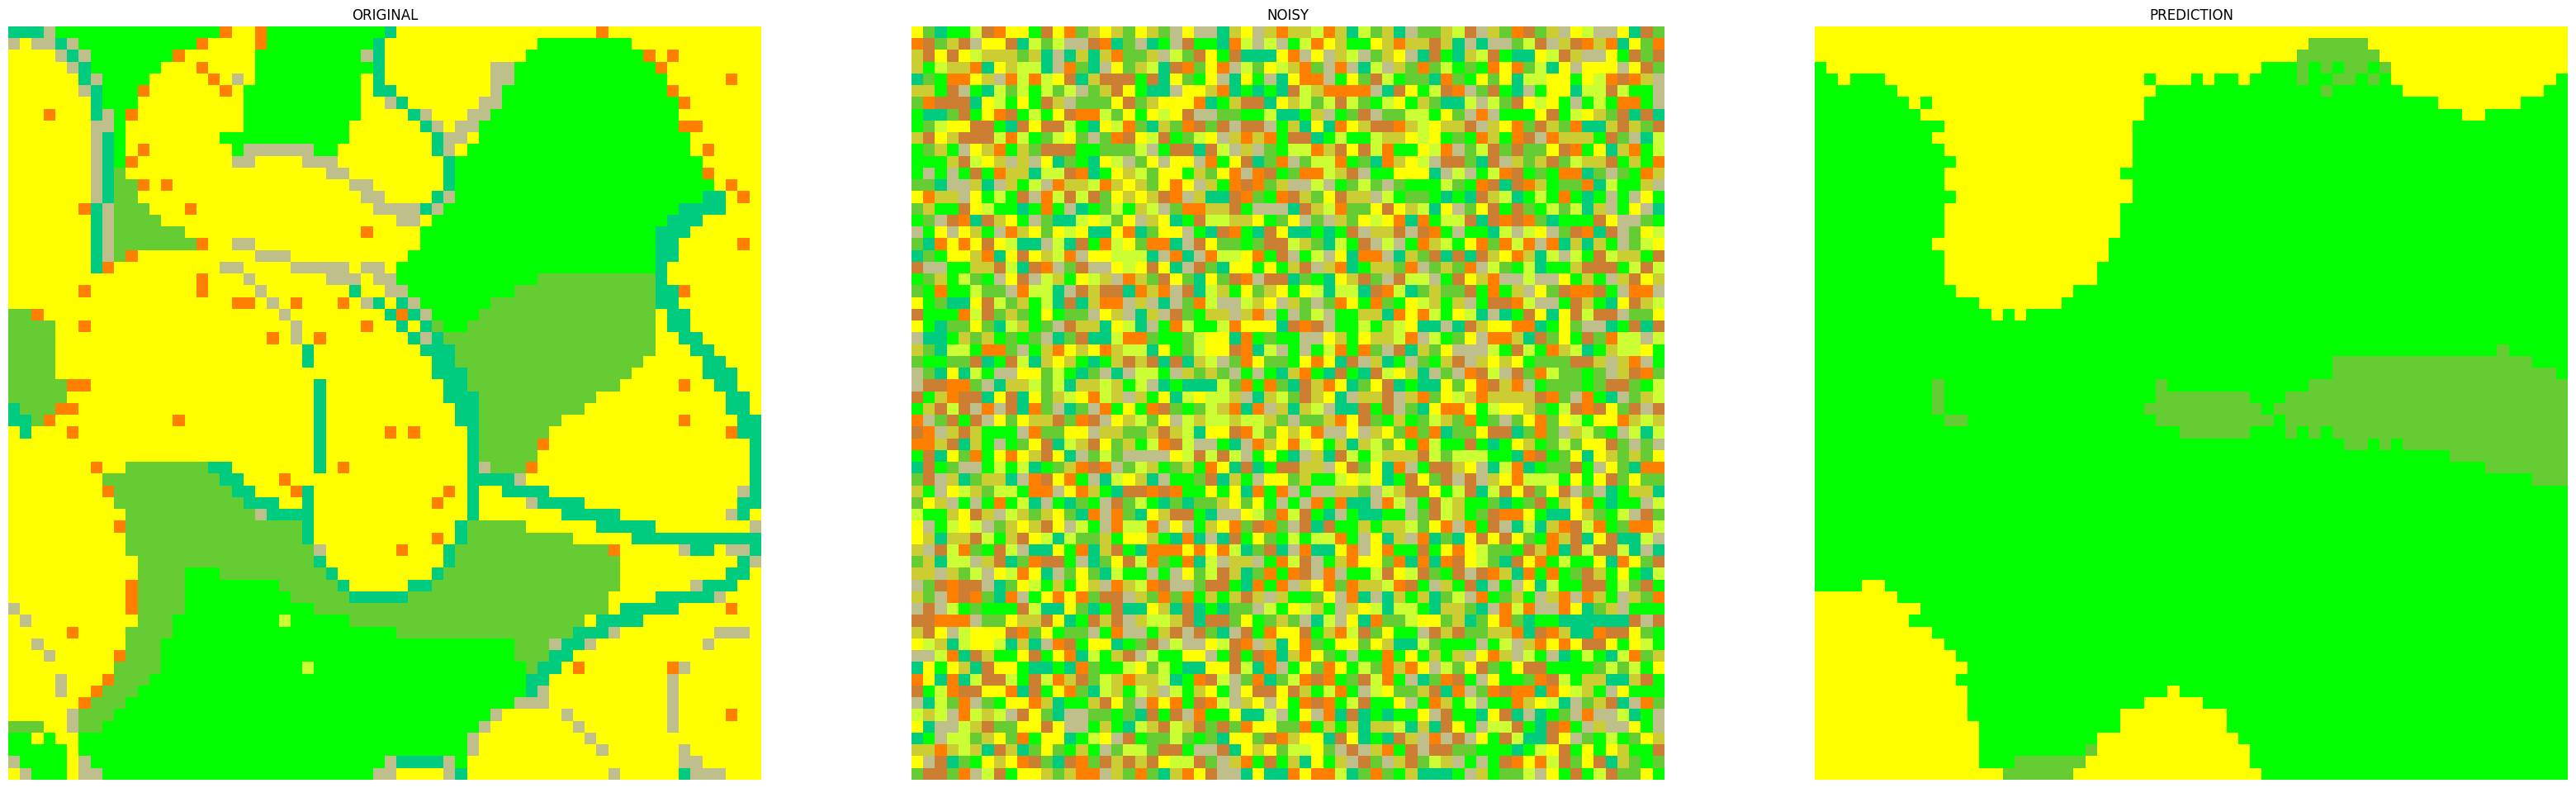

tf.Tensor([[[[0.84]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.83]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01200259 0.90292948 0.01220872 0.01173809 0.01177897 0.011745
 0.01269413 0.01284544 0.01205759], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 15, step: 0.8300000000000001


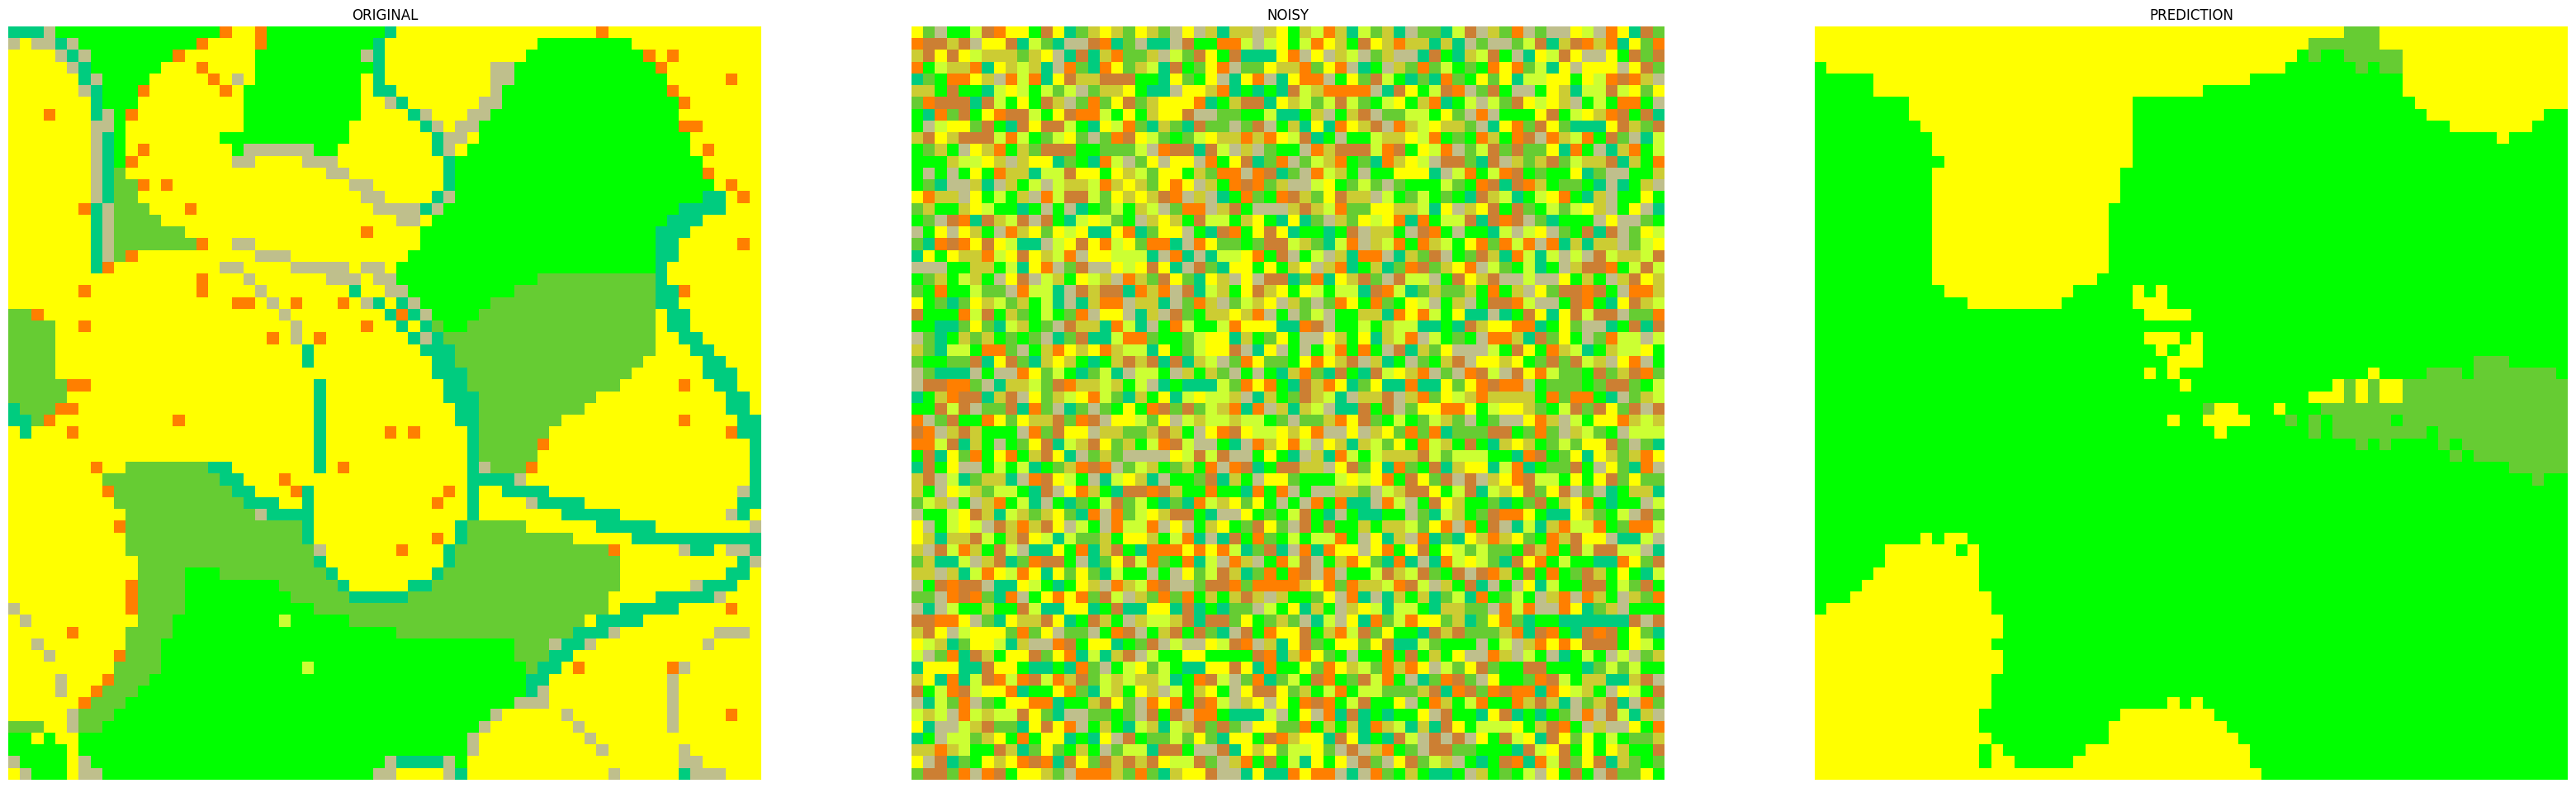

tf.Tensor([[[[0.83]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.82]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01095745 0.91172538 0.0111684  0.01065465 0.01069414 0.0106613
 0.01136772 0.0118332  0.01093775], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 16, step: 0.8200000000000001


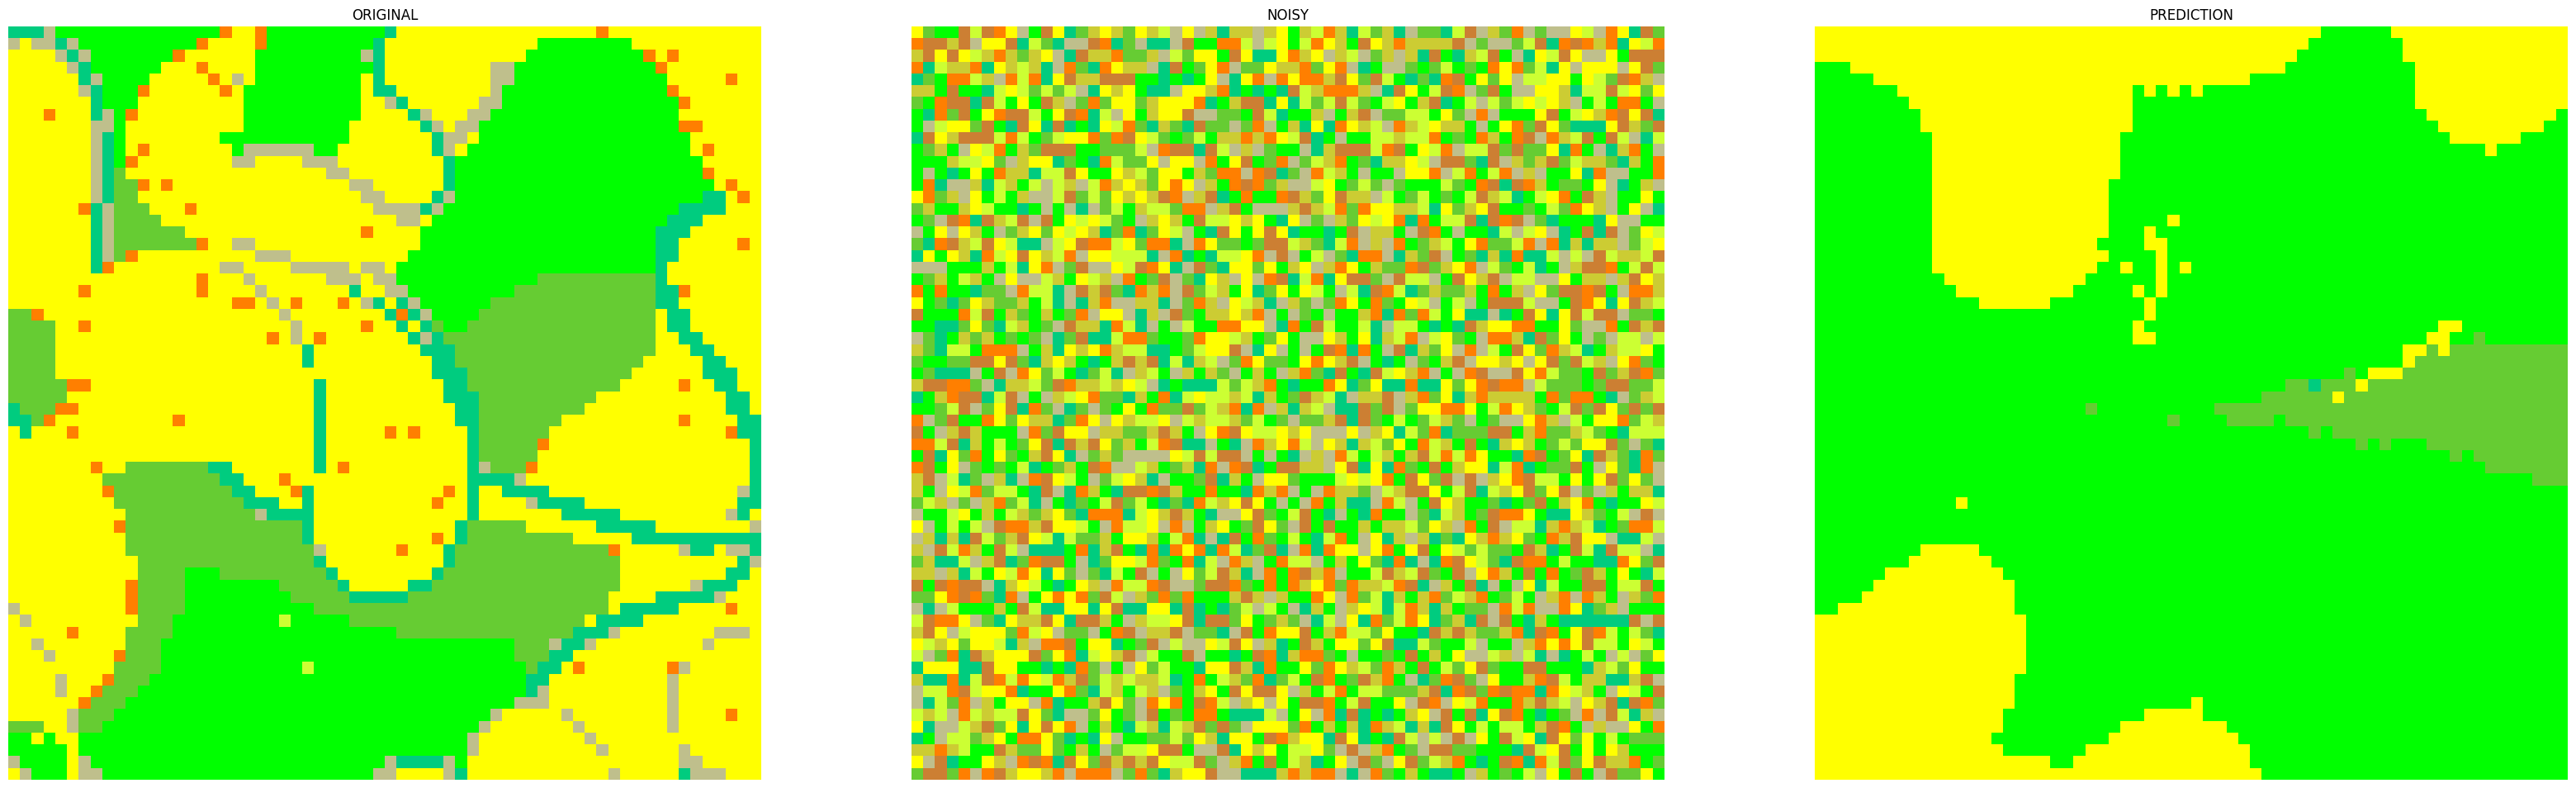

tf.Tensor([[[[0.82]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.81]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01005154 0.91916246 0.01018115 0.0097285  0.00976911 0.00973423
 0.01024836 0.01114423 0.00998041], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 17, step: 0.81


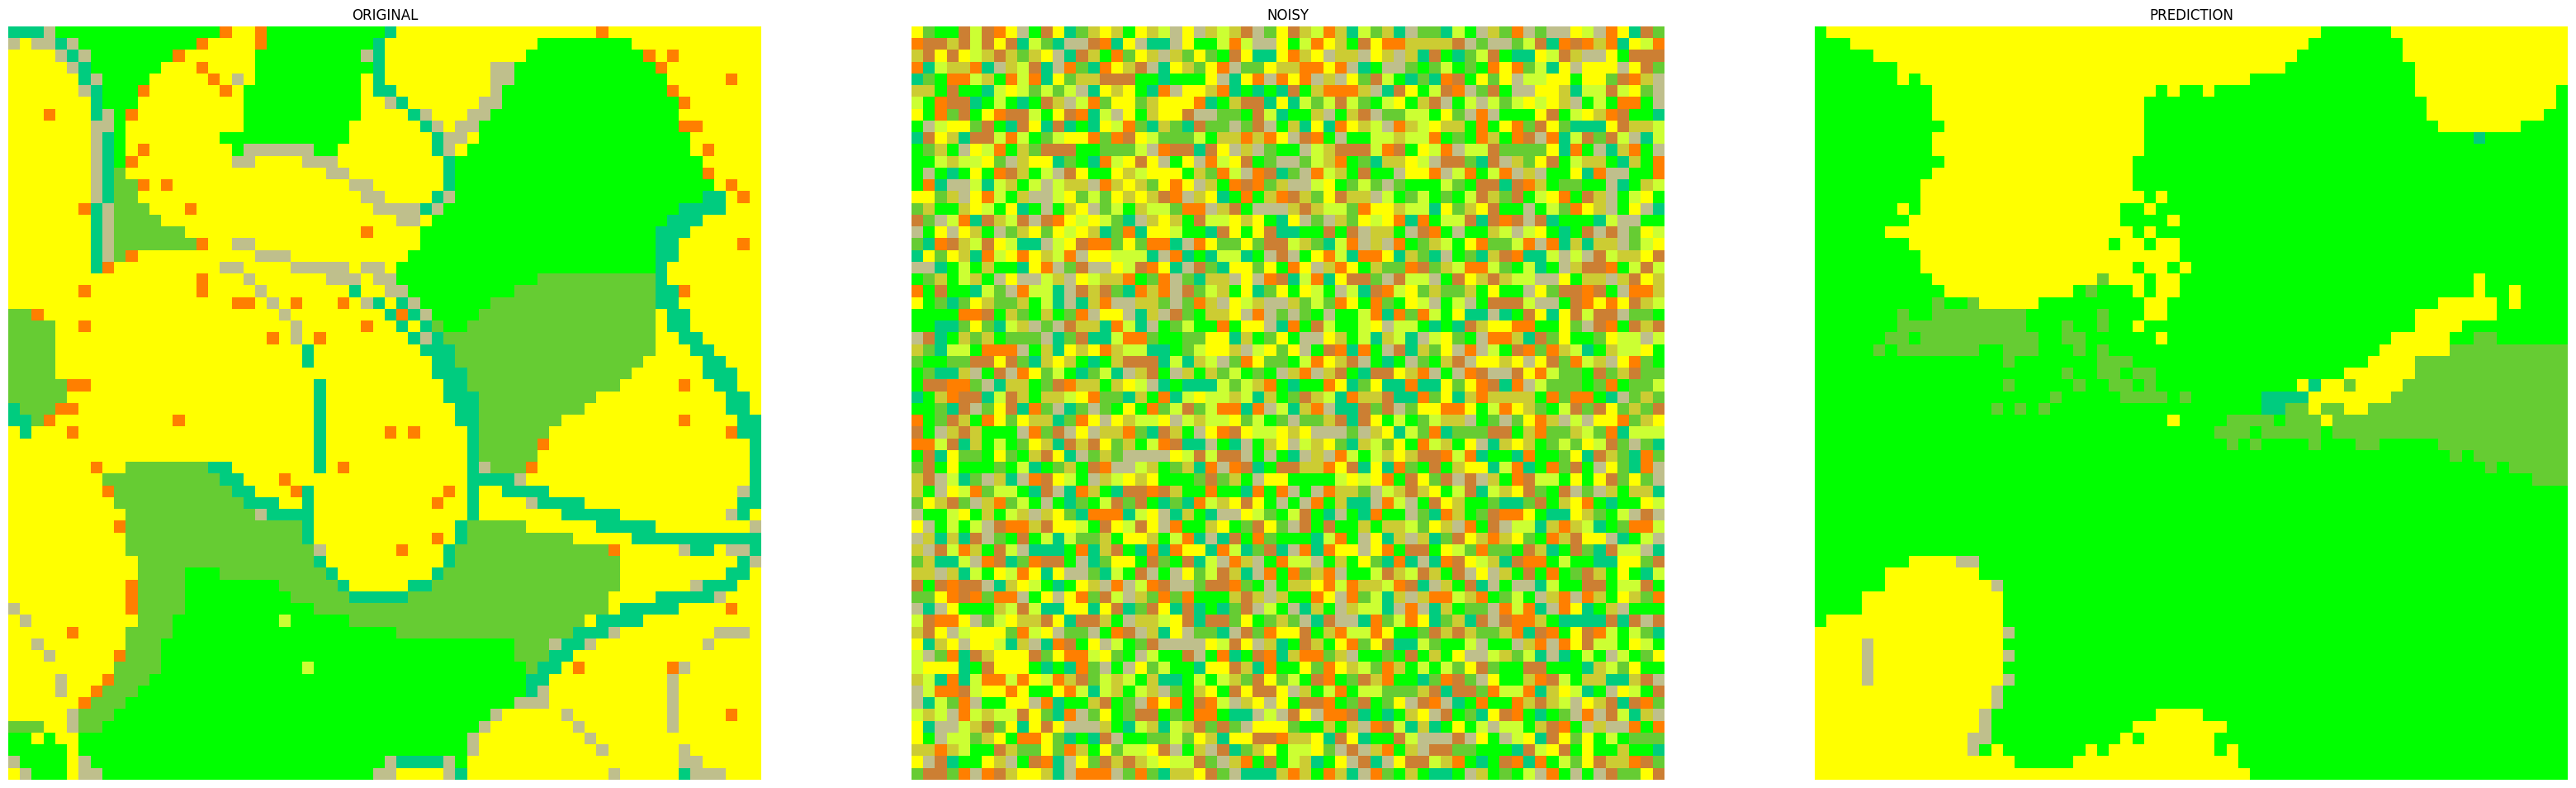

tf.Tensor([[[[0.81]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.8]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.01011631 0.91659578 0.01032468 0.00983935 0.00990017 0.00984837
 0.01054    0.01267971 0.01015562], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 18, step: 0.8


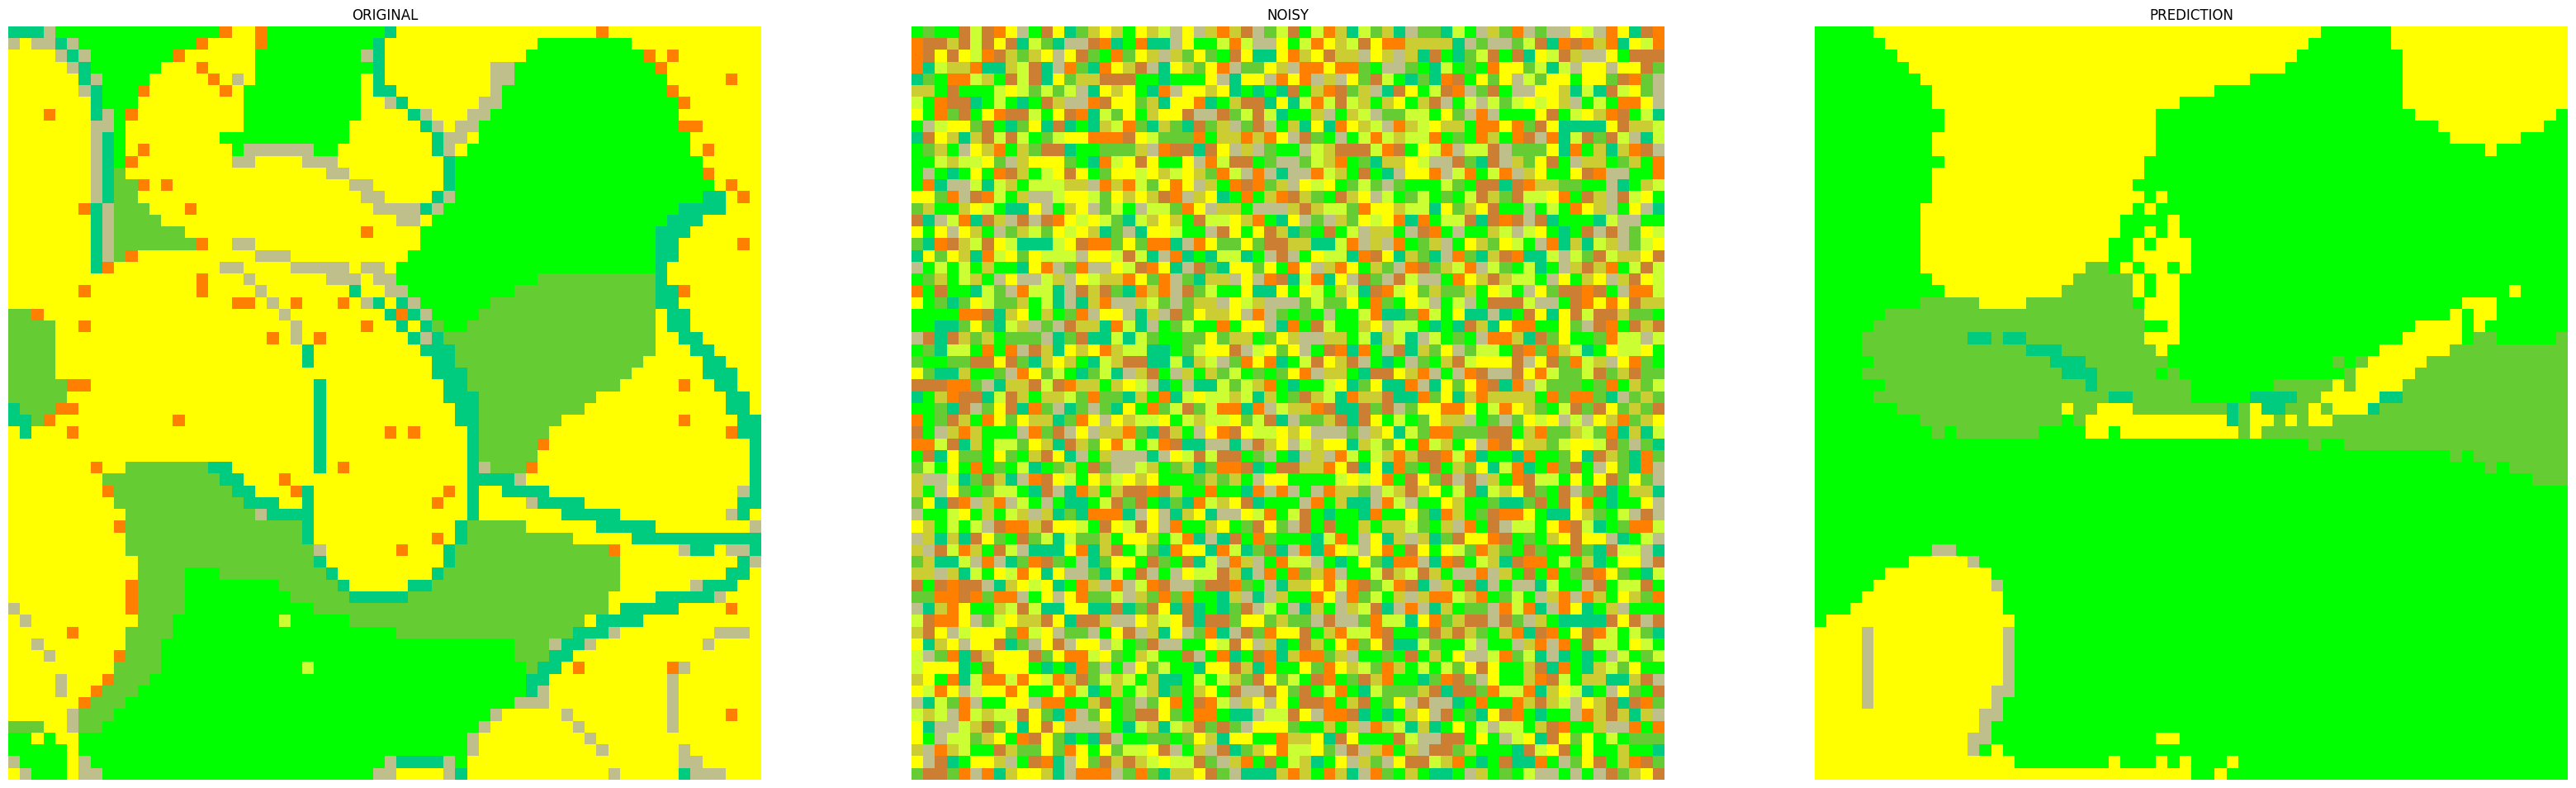

tf.Tensor([[[[0.8]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.79]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00839771 0.00956774 0.0085622  0.0081673  0.00821528 0.00817475
 0.00881277 0.93165754 0.00844472], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 19, step: 0.79


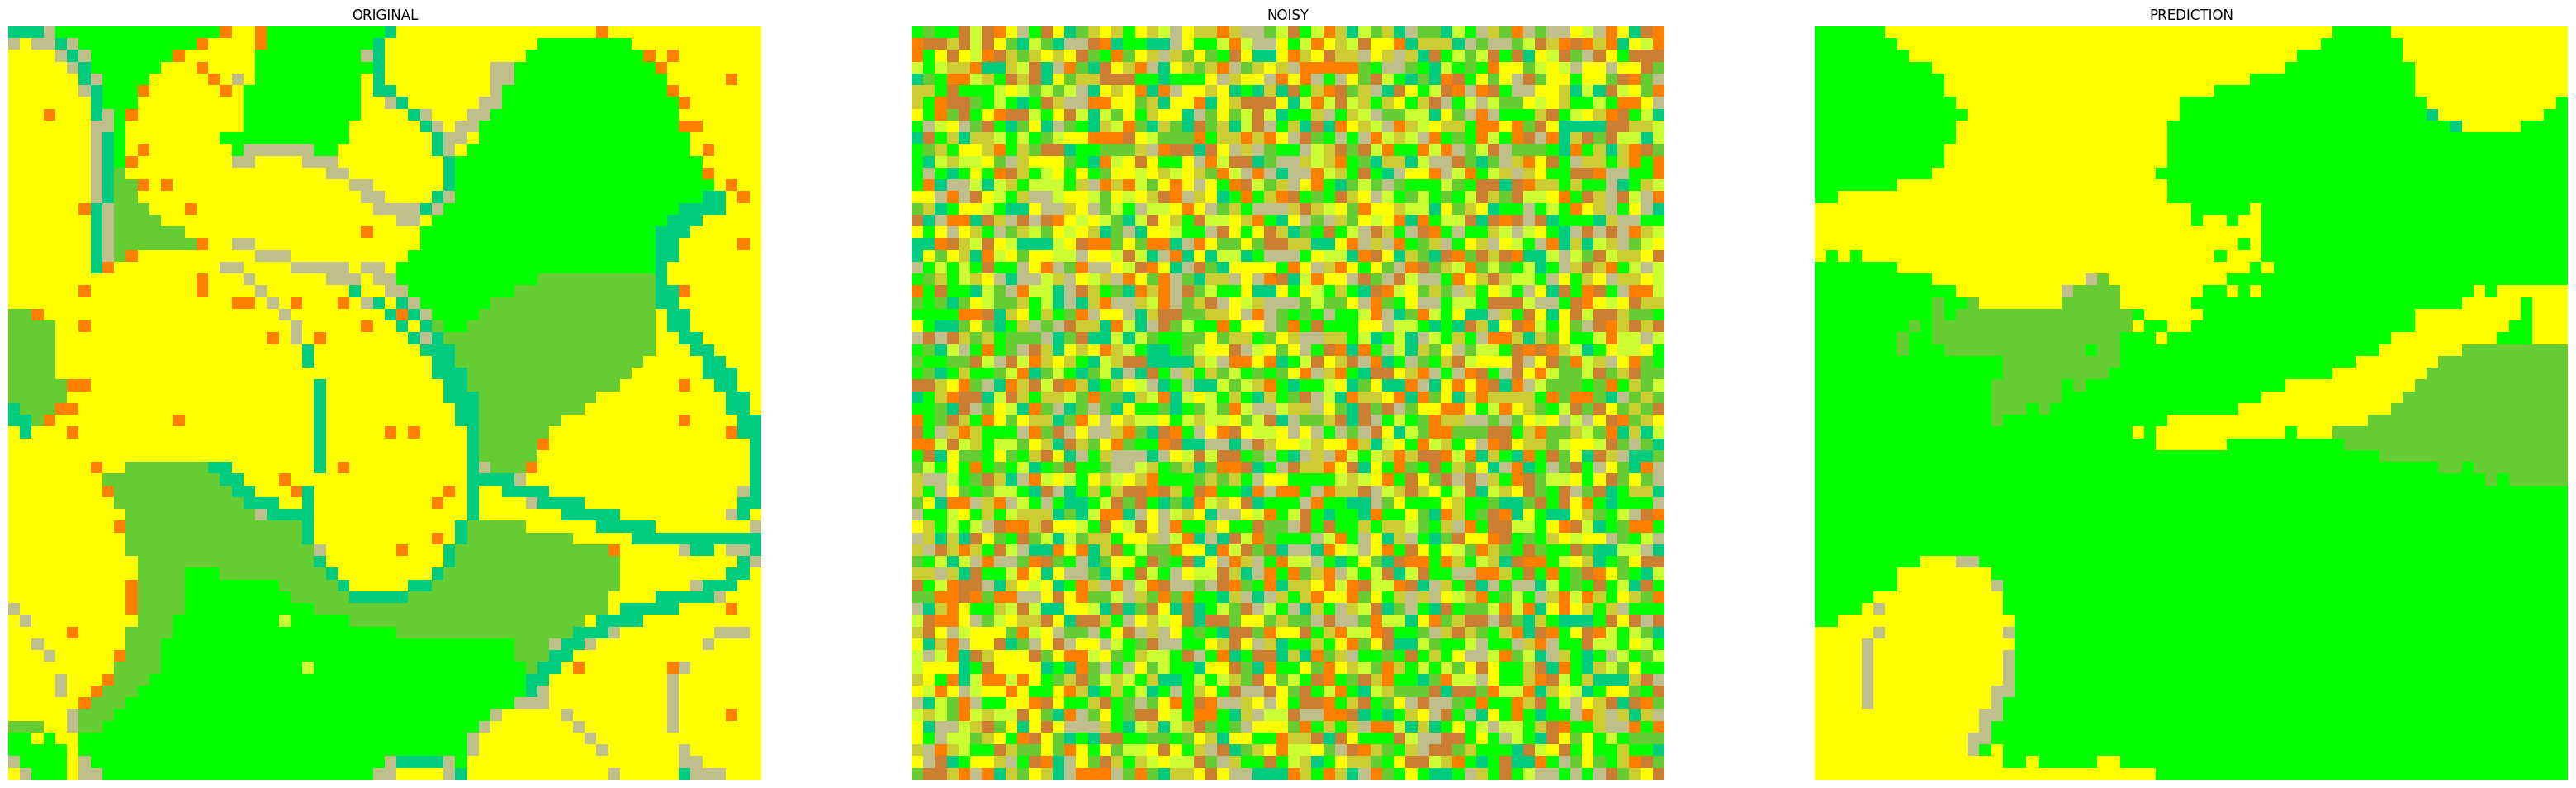

tf.Tensor([[[[0.79]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.78]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00721017 0.00773233 0.00740647 0.00705912 0.00712572 0.00706953
 0.00765711 0.94141242 0.00732713], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 20, step: 0.78


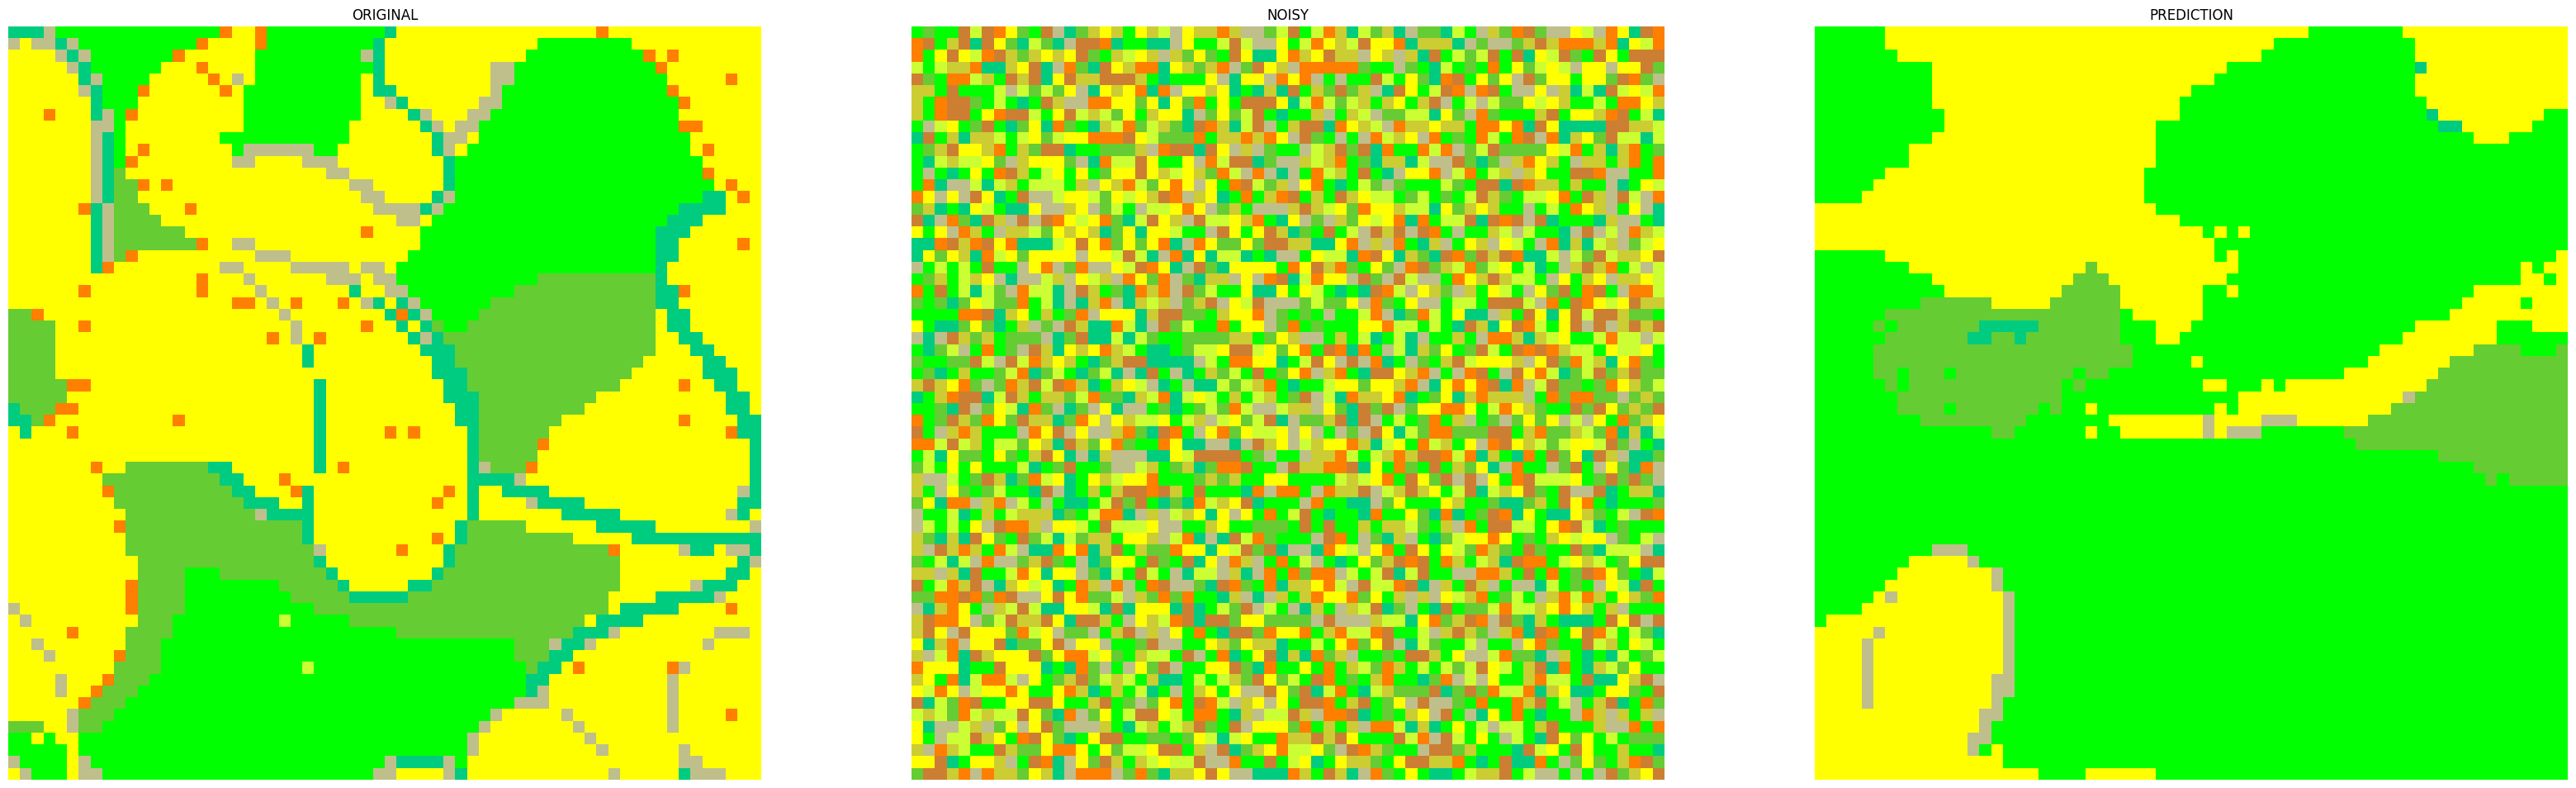

tf.Tensor([[[[0.78]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.77]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00635974 0.00671267 0.00653828 0.00623698 0.00629725 0.00624672
 0.00668521 0.94845882 0.00646433], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 21, step: 0.77


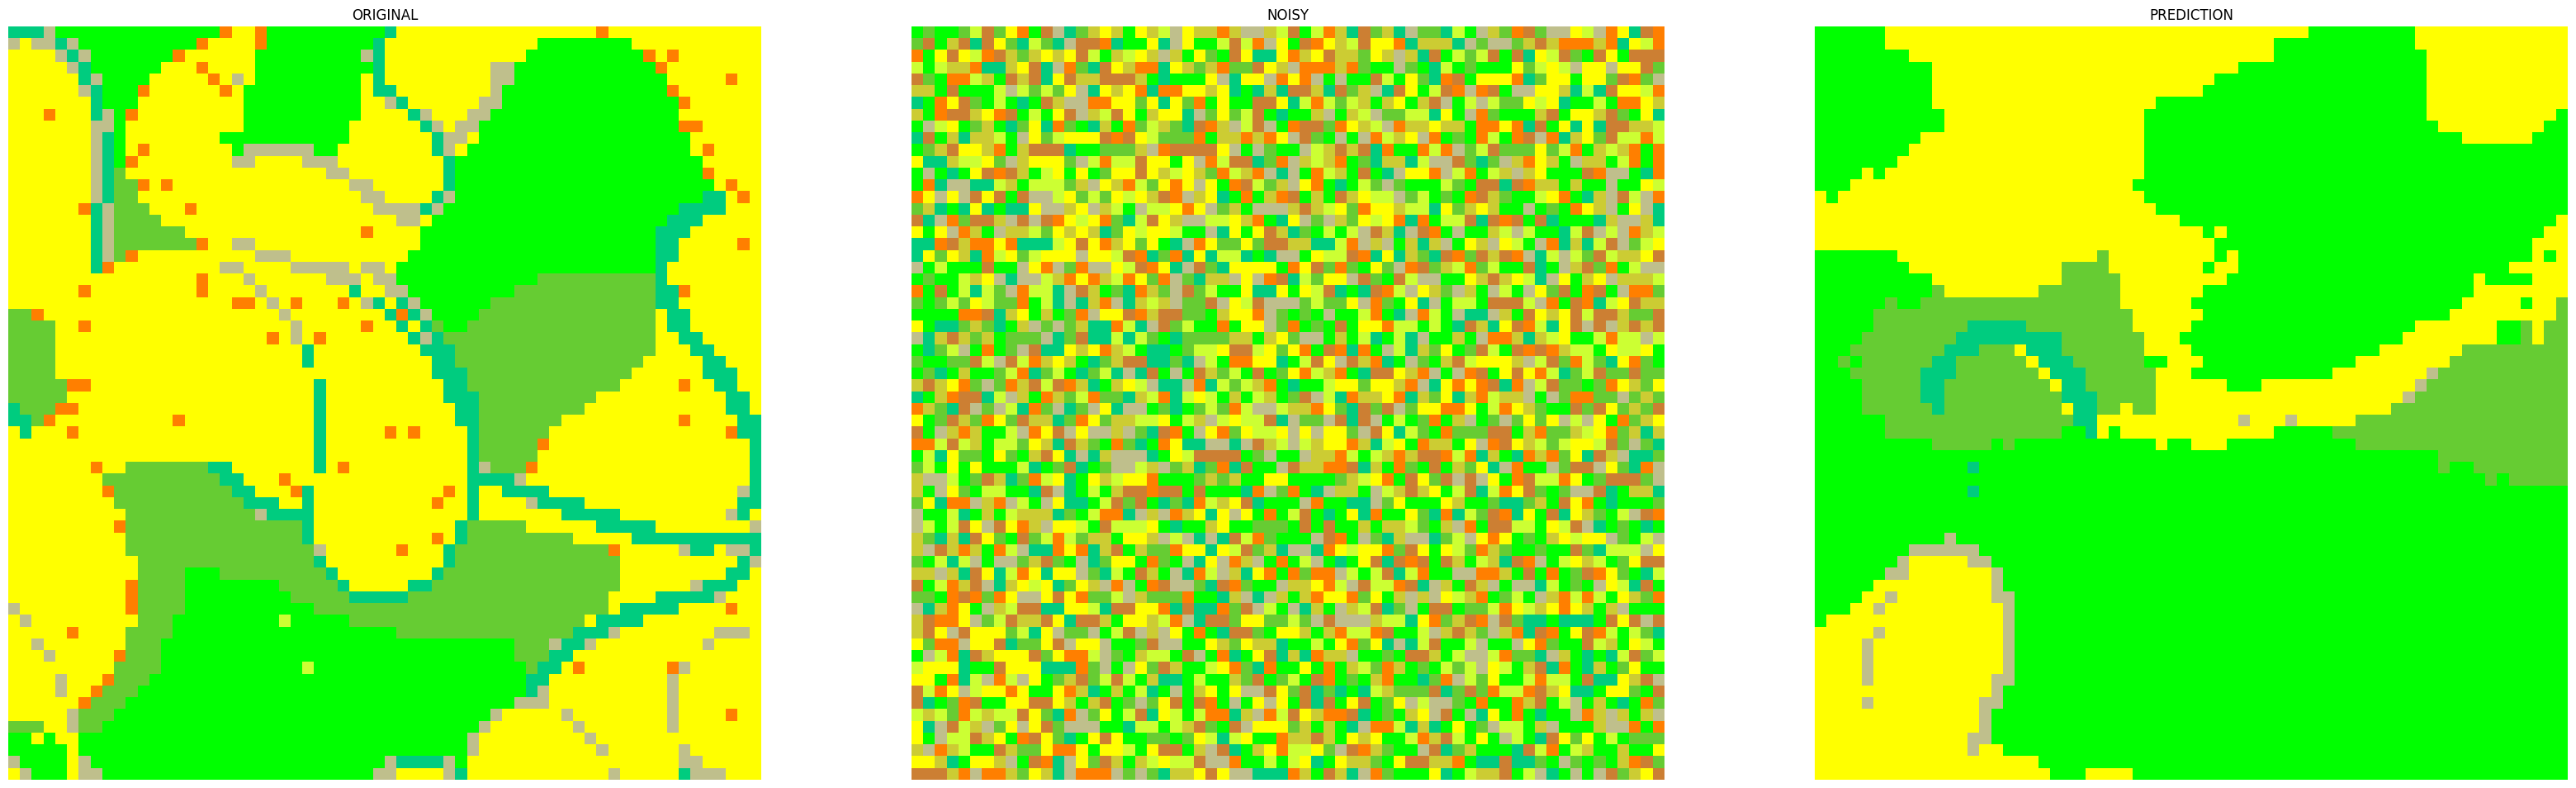

tf.Tensor([[[[0.77]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.76]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00594106 0.00626904 0.00614633 0.00582333 0.00589269 0.00583437
 0.00652091 0.95152614 0.00604613], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 22, step: 0.76


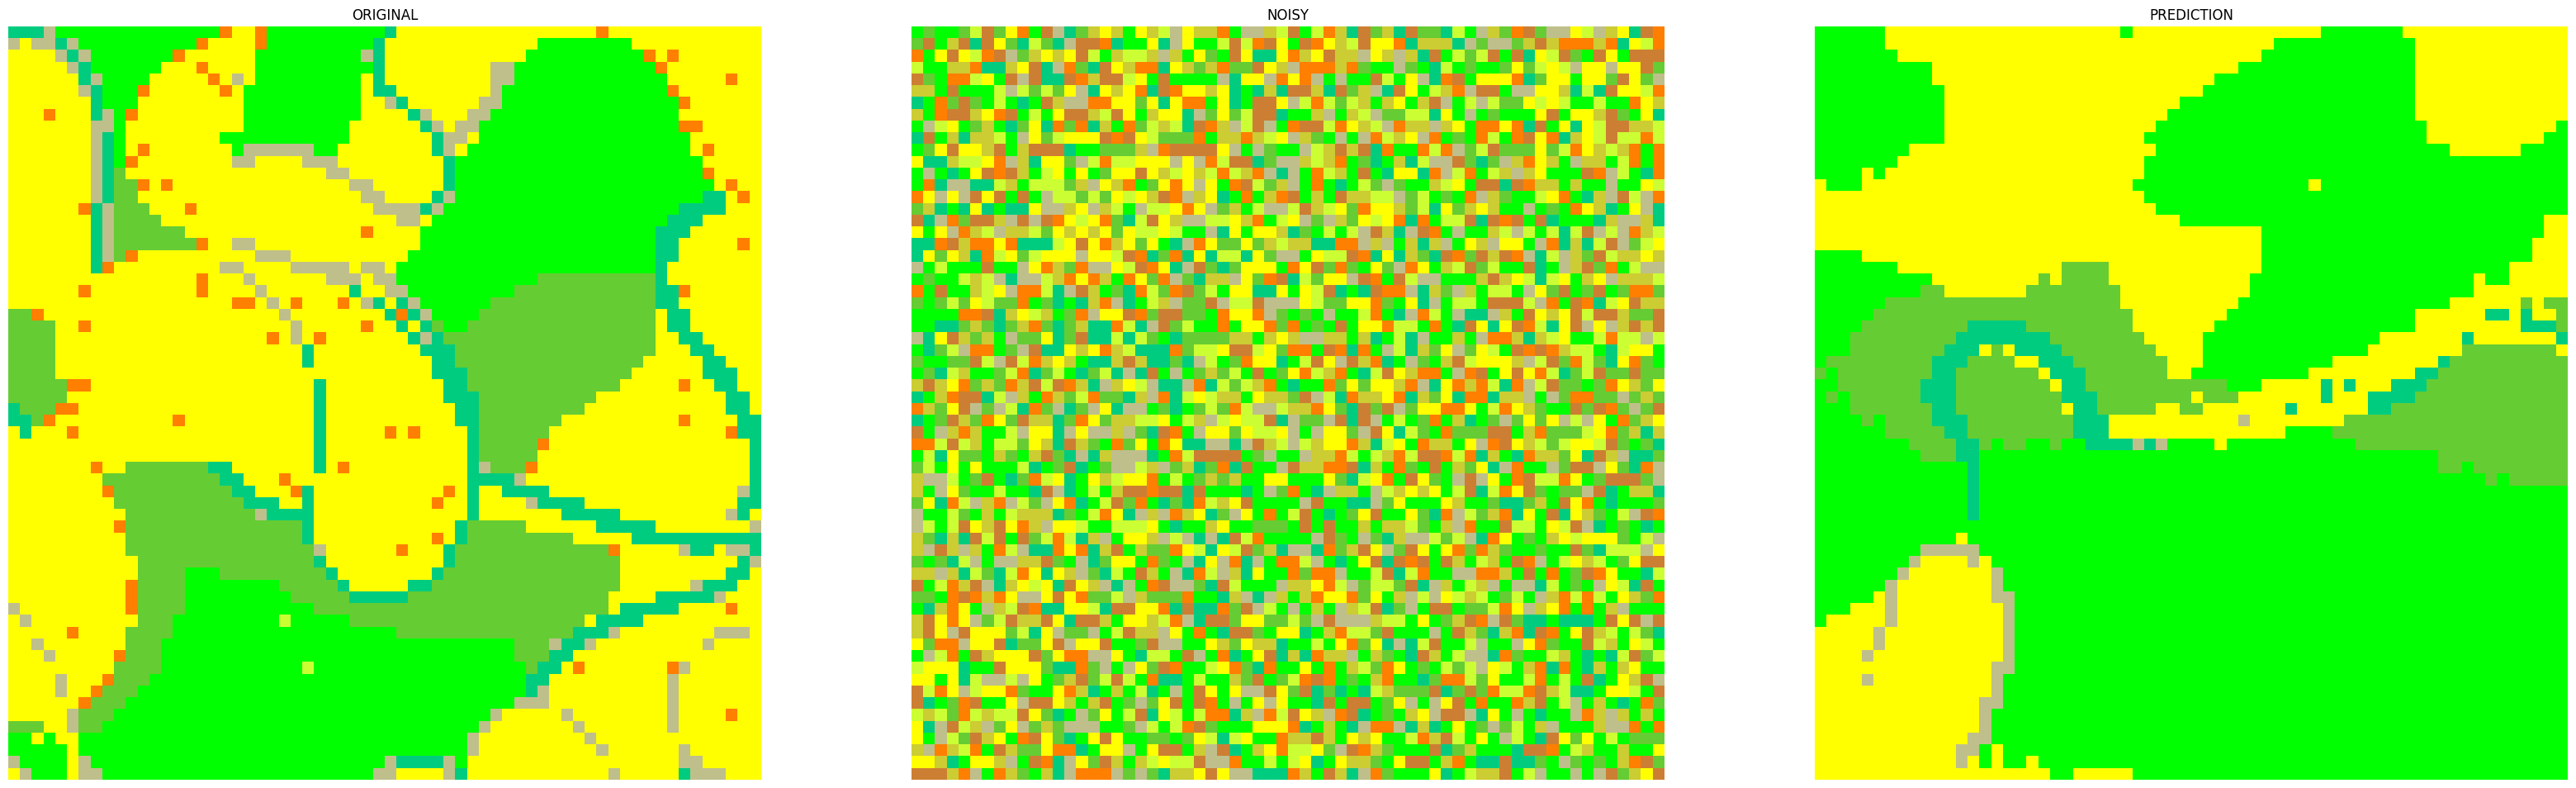

tf.Tensor([[[[0.76]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.75]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00542193 0.00571054 0.00562386 0.00531039 0.00537286 0.00532058
 0.00603435 0.95568285 0.00552265], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 23, step: 0.75


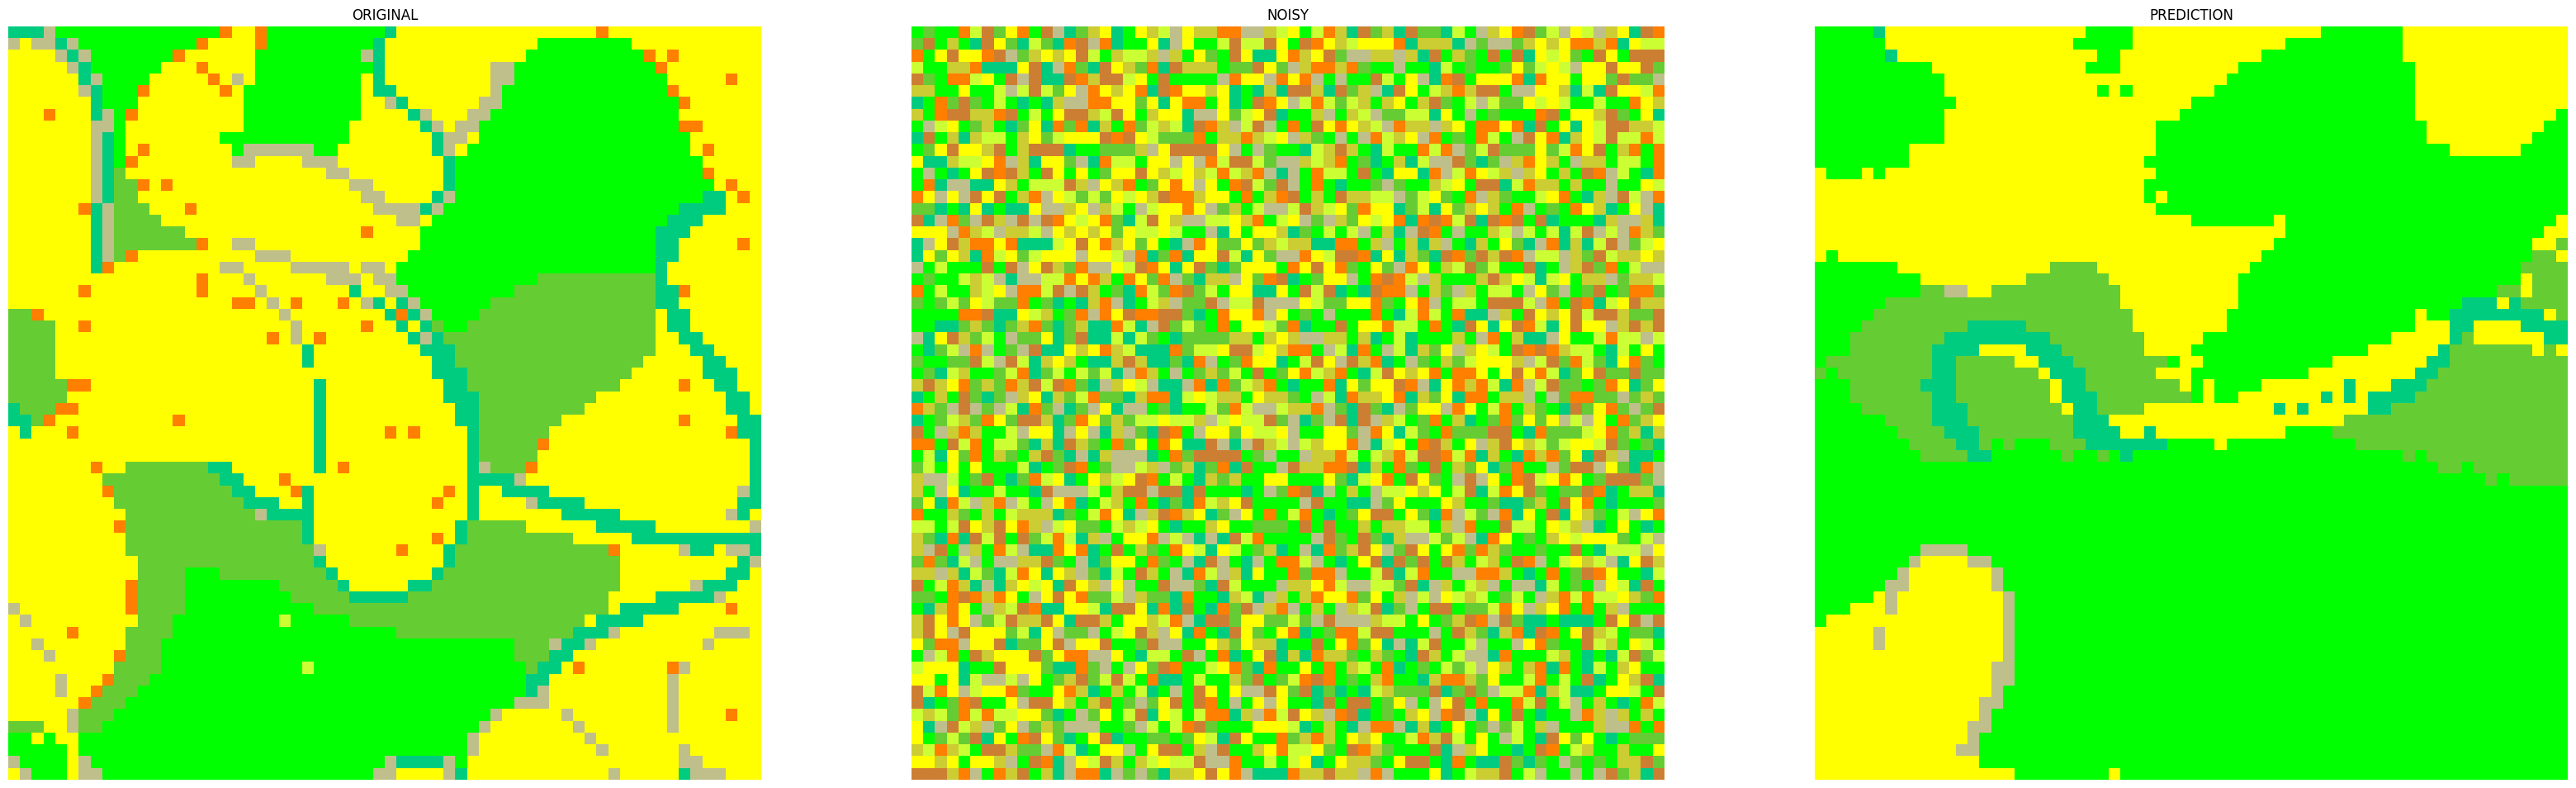

tf.Tensor([[[[0.75]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.74]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0048715  0.00514384 0.00505399 0.00475673 0.00481231 0.004766
 0.00525829 0.96036707 0.00497026], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 24, step: 0.74


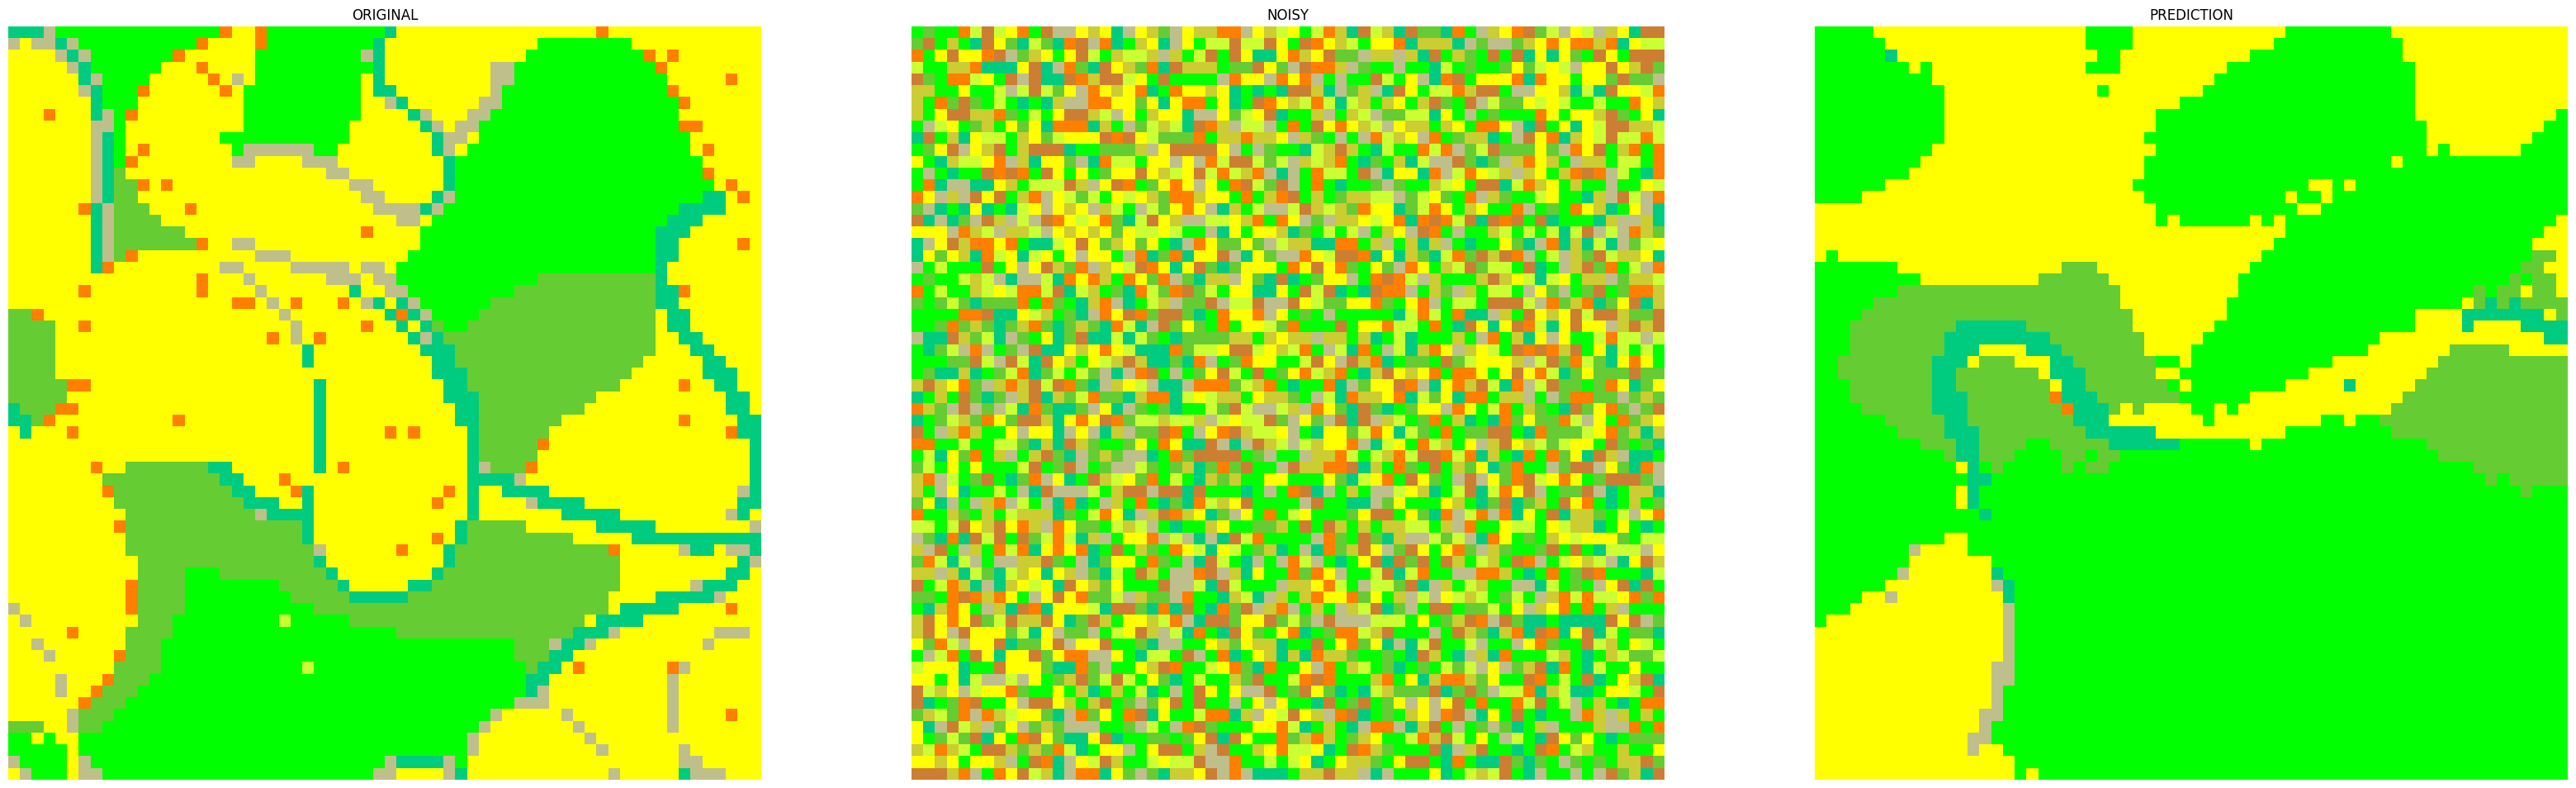

tf.Tensor([[[[0.74]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.73]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00444441 0.00472025 0.00460978 0.00432032 0.00437073 0.0043292
 0.00473631 0.9639507  0.00451831], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 25, step: 0.73


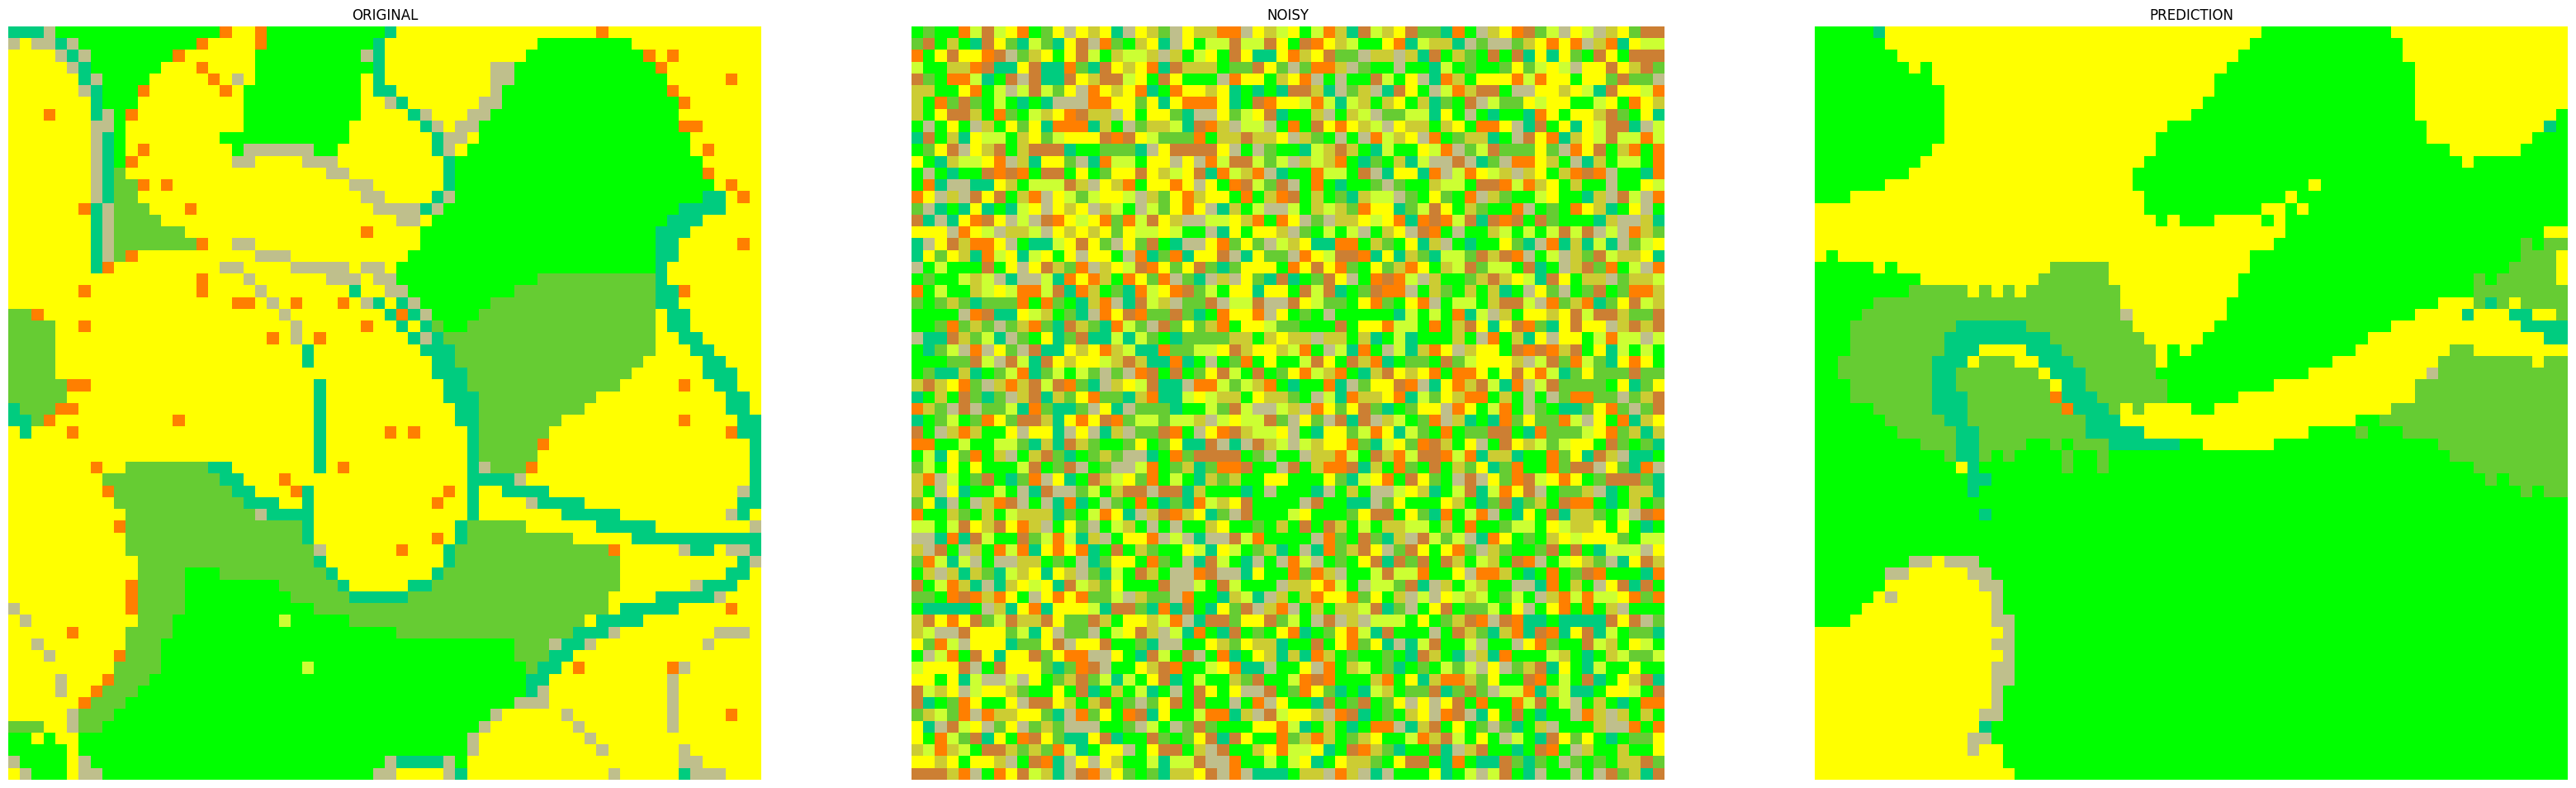

tf.Tensor([[[[0.73]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.72]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00409592 0.00433506 0.00425624 0.00397884 0.0040354  0.00398936
 0.00445973 0.96666316 0.00418628], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 26, step: 0.72


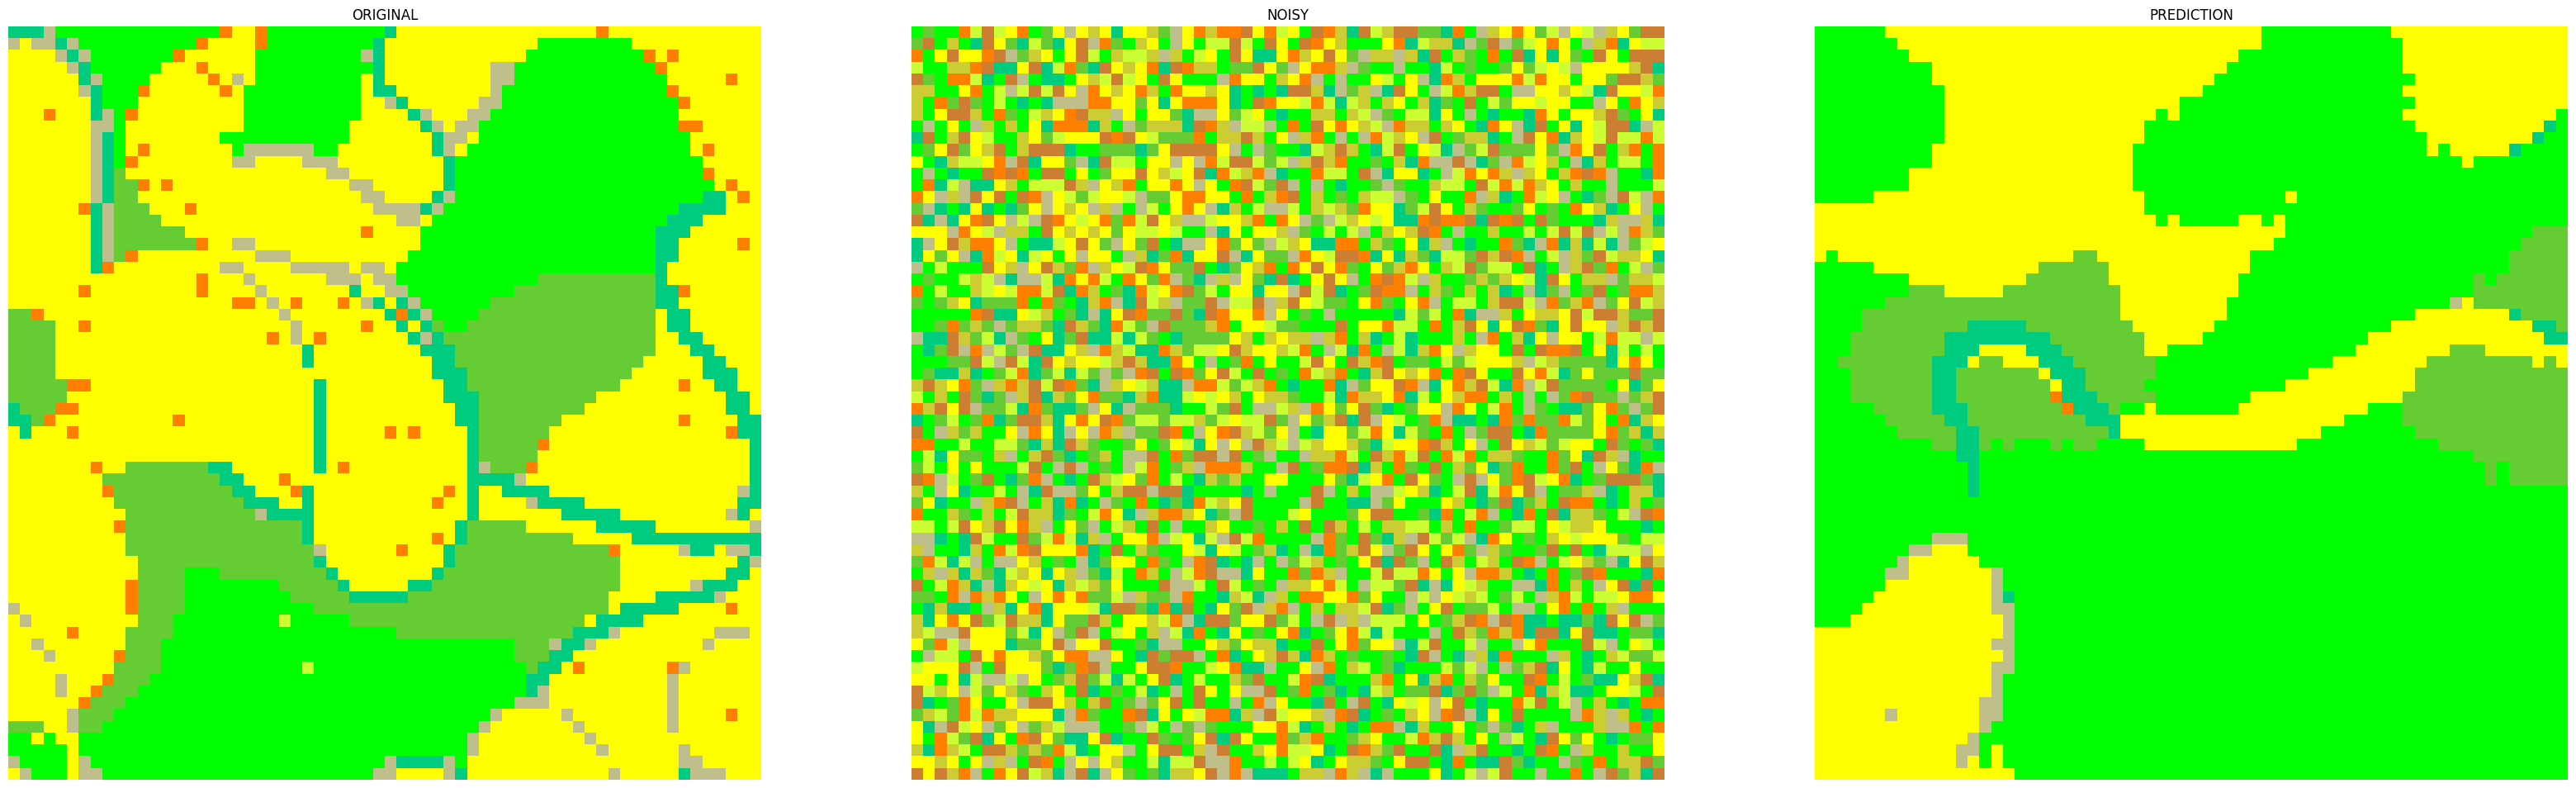

tf.Tensor([[[[0.72]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.71]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00372815 0.0039453  0.00387549 0.00361551 0.00367078 0.00362589
 0.00406466 0.96967202 0.00380221], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 27, step: 0.71


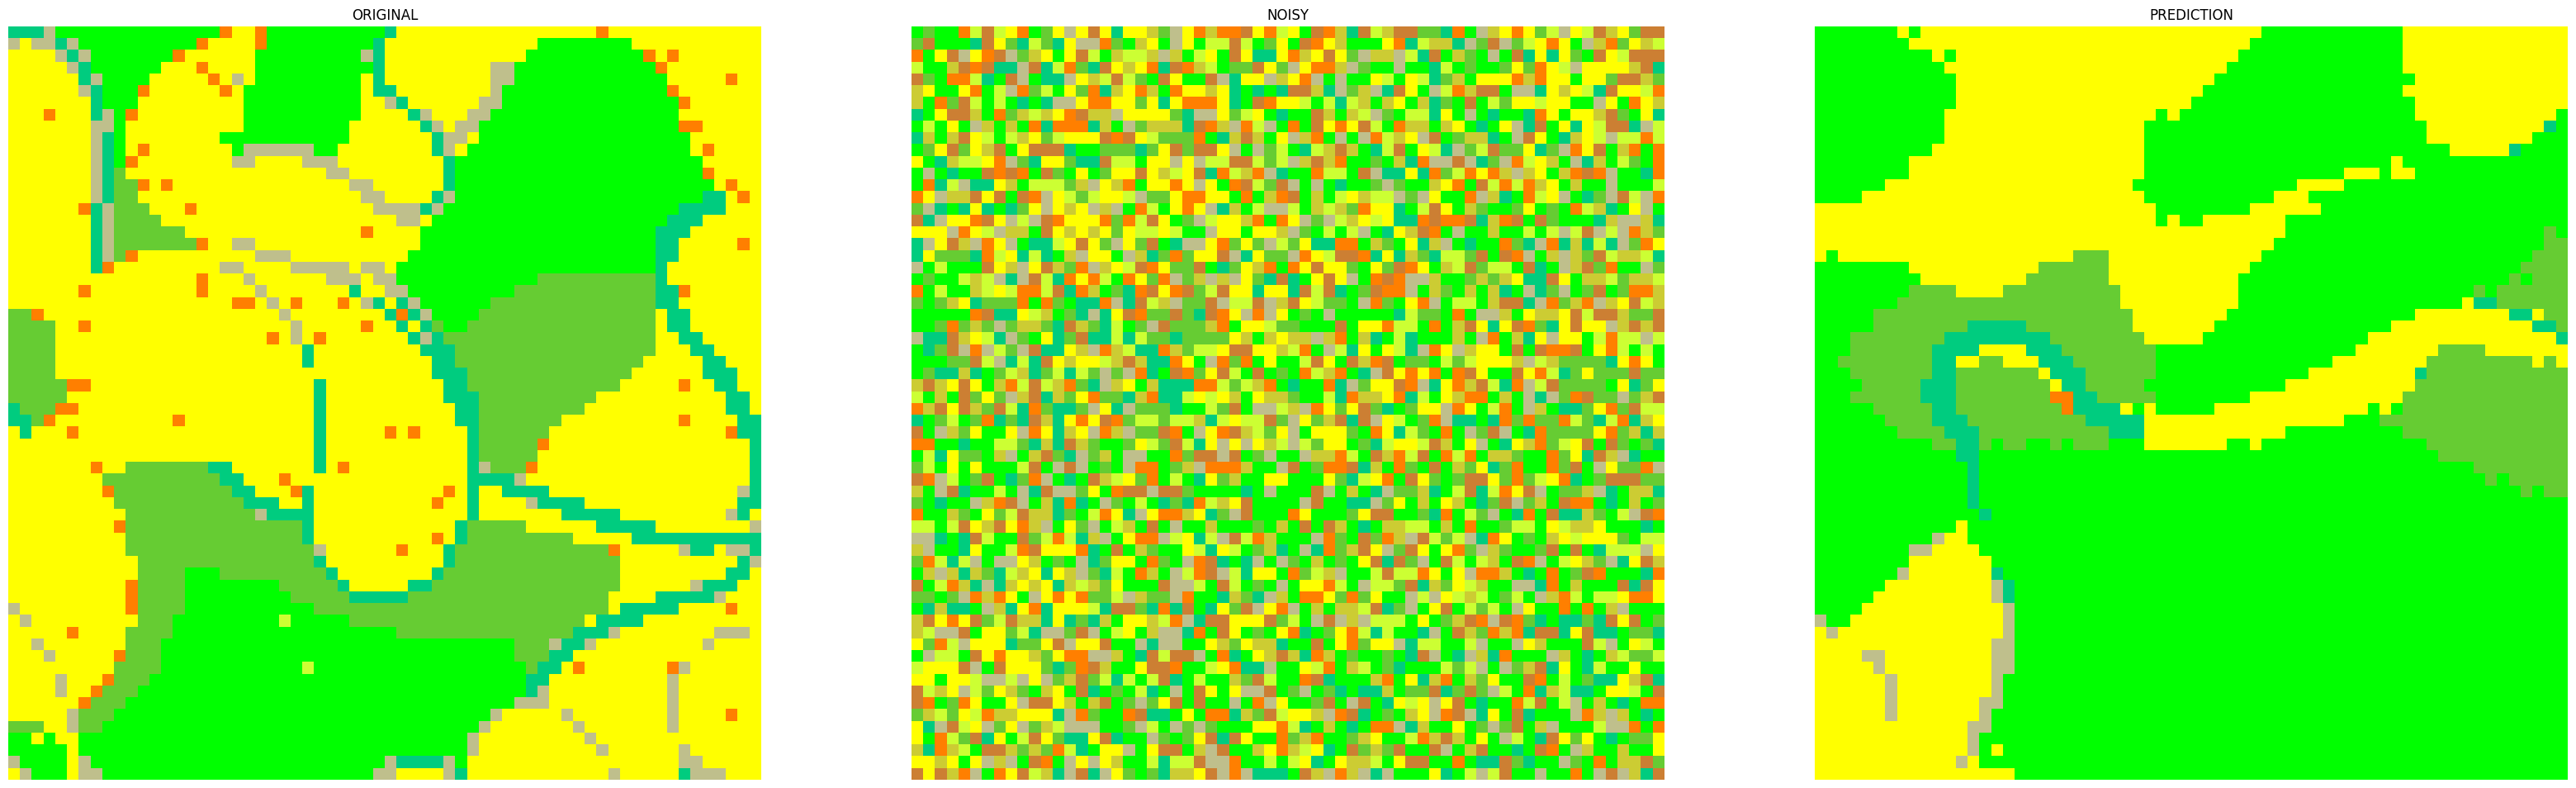

tf.Tensor([[[[0.71]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.7]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00338417 0.00356837 0.00356793 0.00329348 0.00334589 0.0033023
 0.00375506 0.97230349 0.00347932], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 28, step: 0.7000000000000001


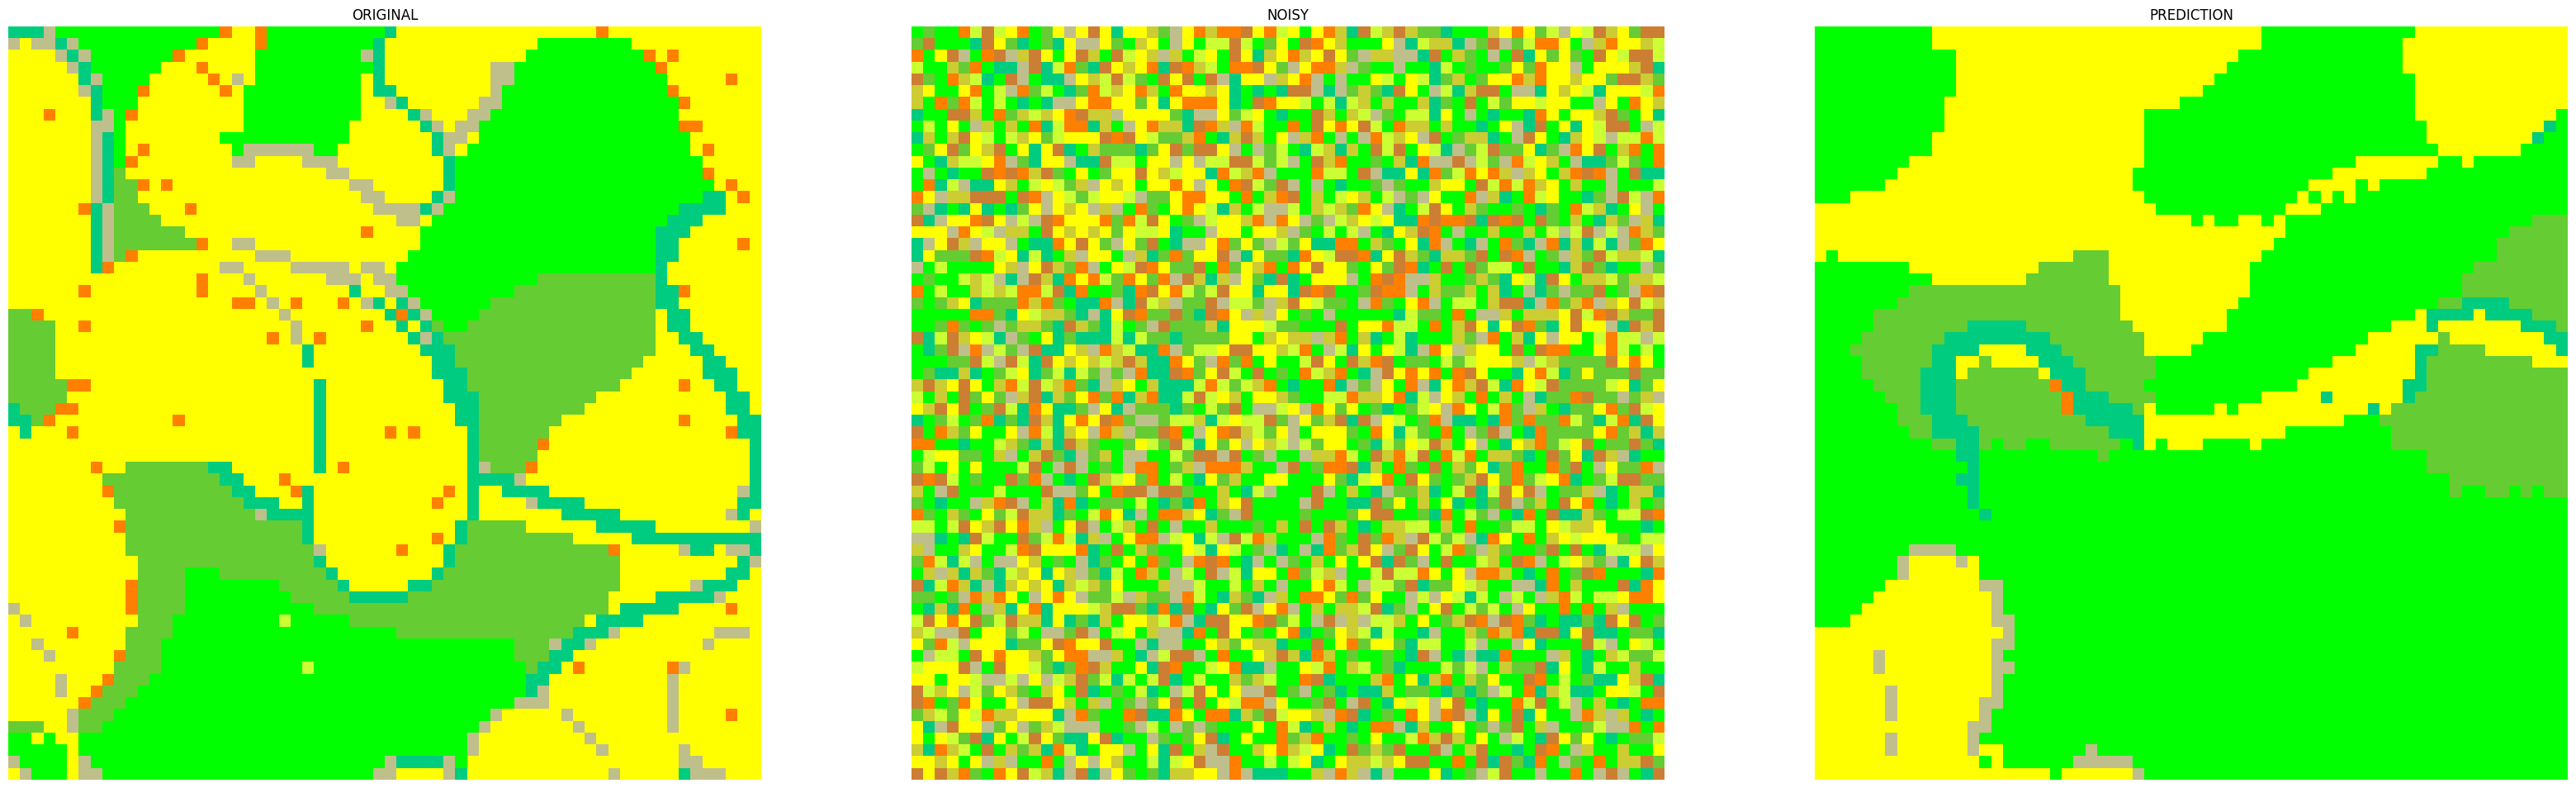

tf.Tensor([[[[0.7]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.69]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00304989 0.00321957 0.00324285 0.00297019 0.00301282 0.00297711
 0.00333786 0.9750294  0.00316031], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 29, step: 0.6900000000000001


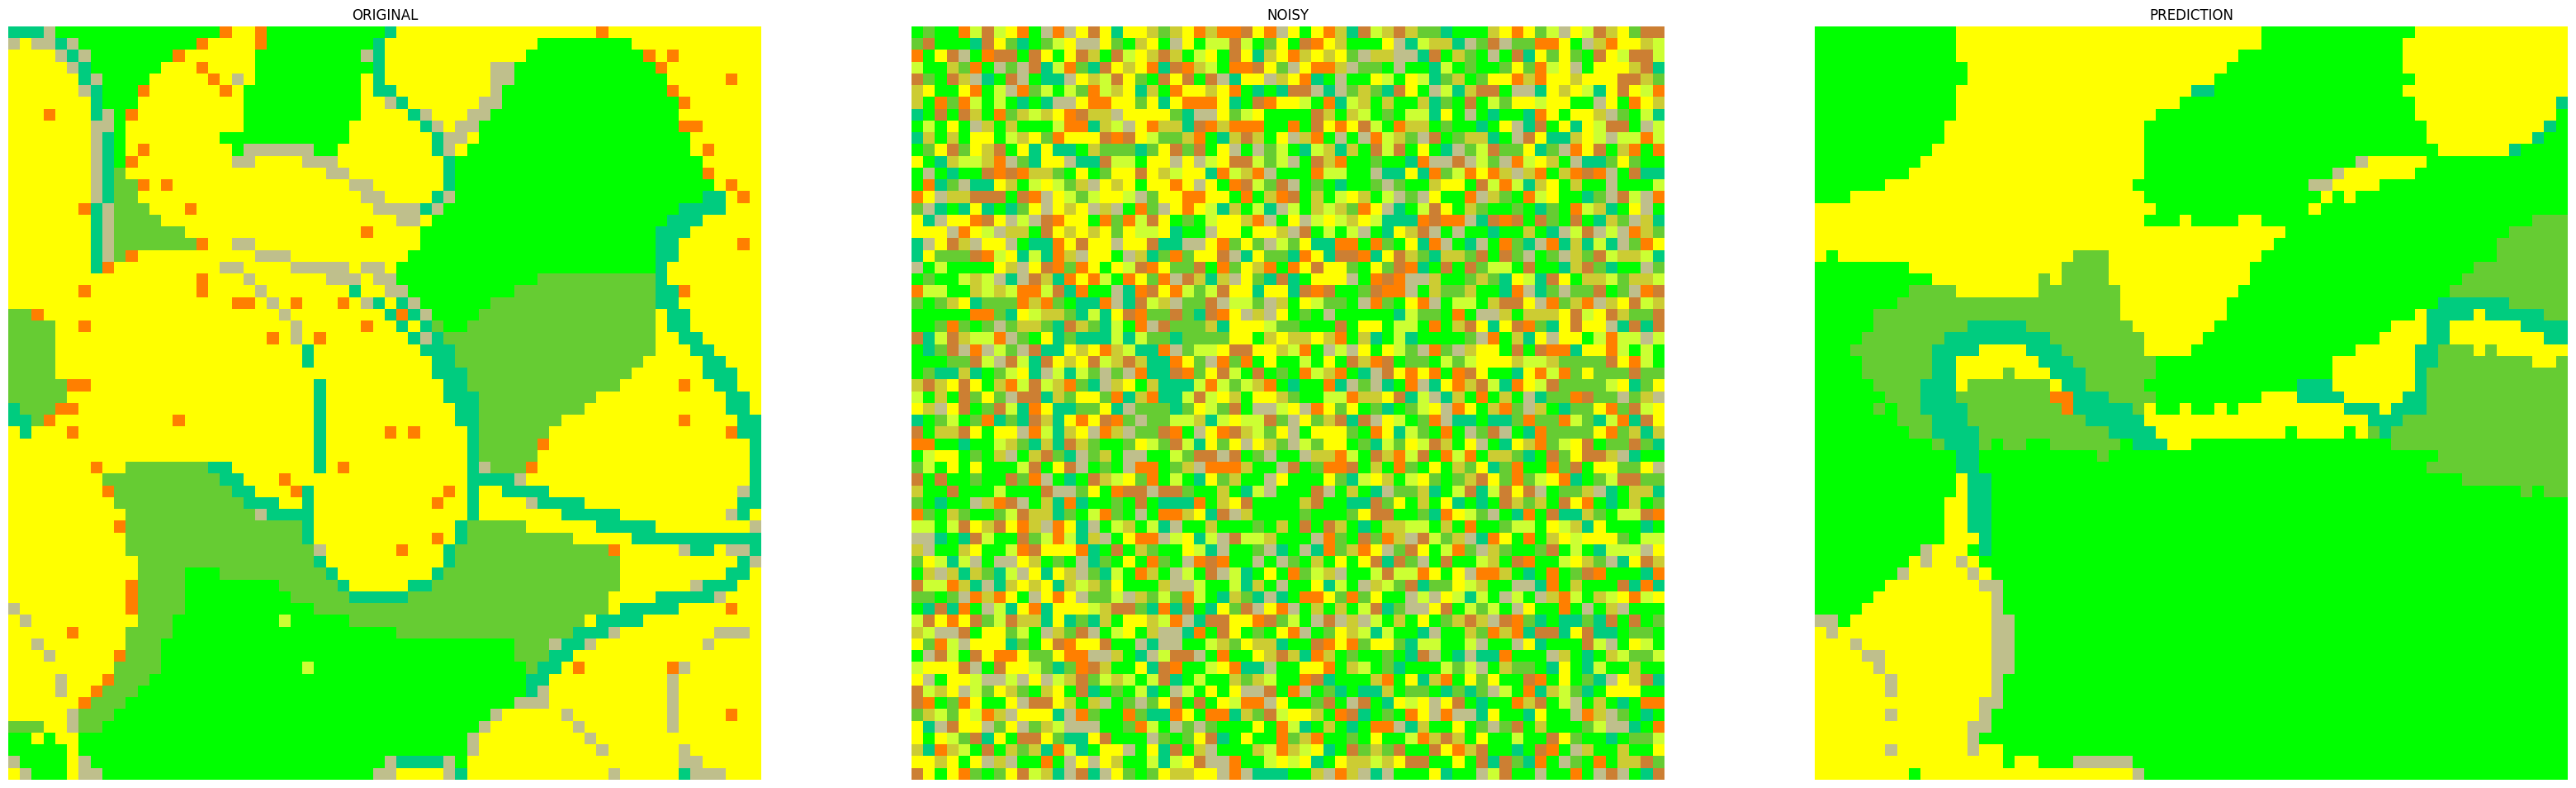

tf.Tensor([[[[0.69]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.68]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00279665 0.00296415 0.00297346 0.00271085 0.00274948 0.00271709
 0.00304507 0.97715224 0.002891  ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 30, step: 0.68


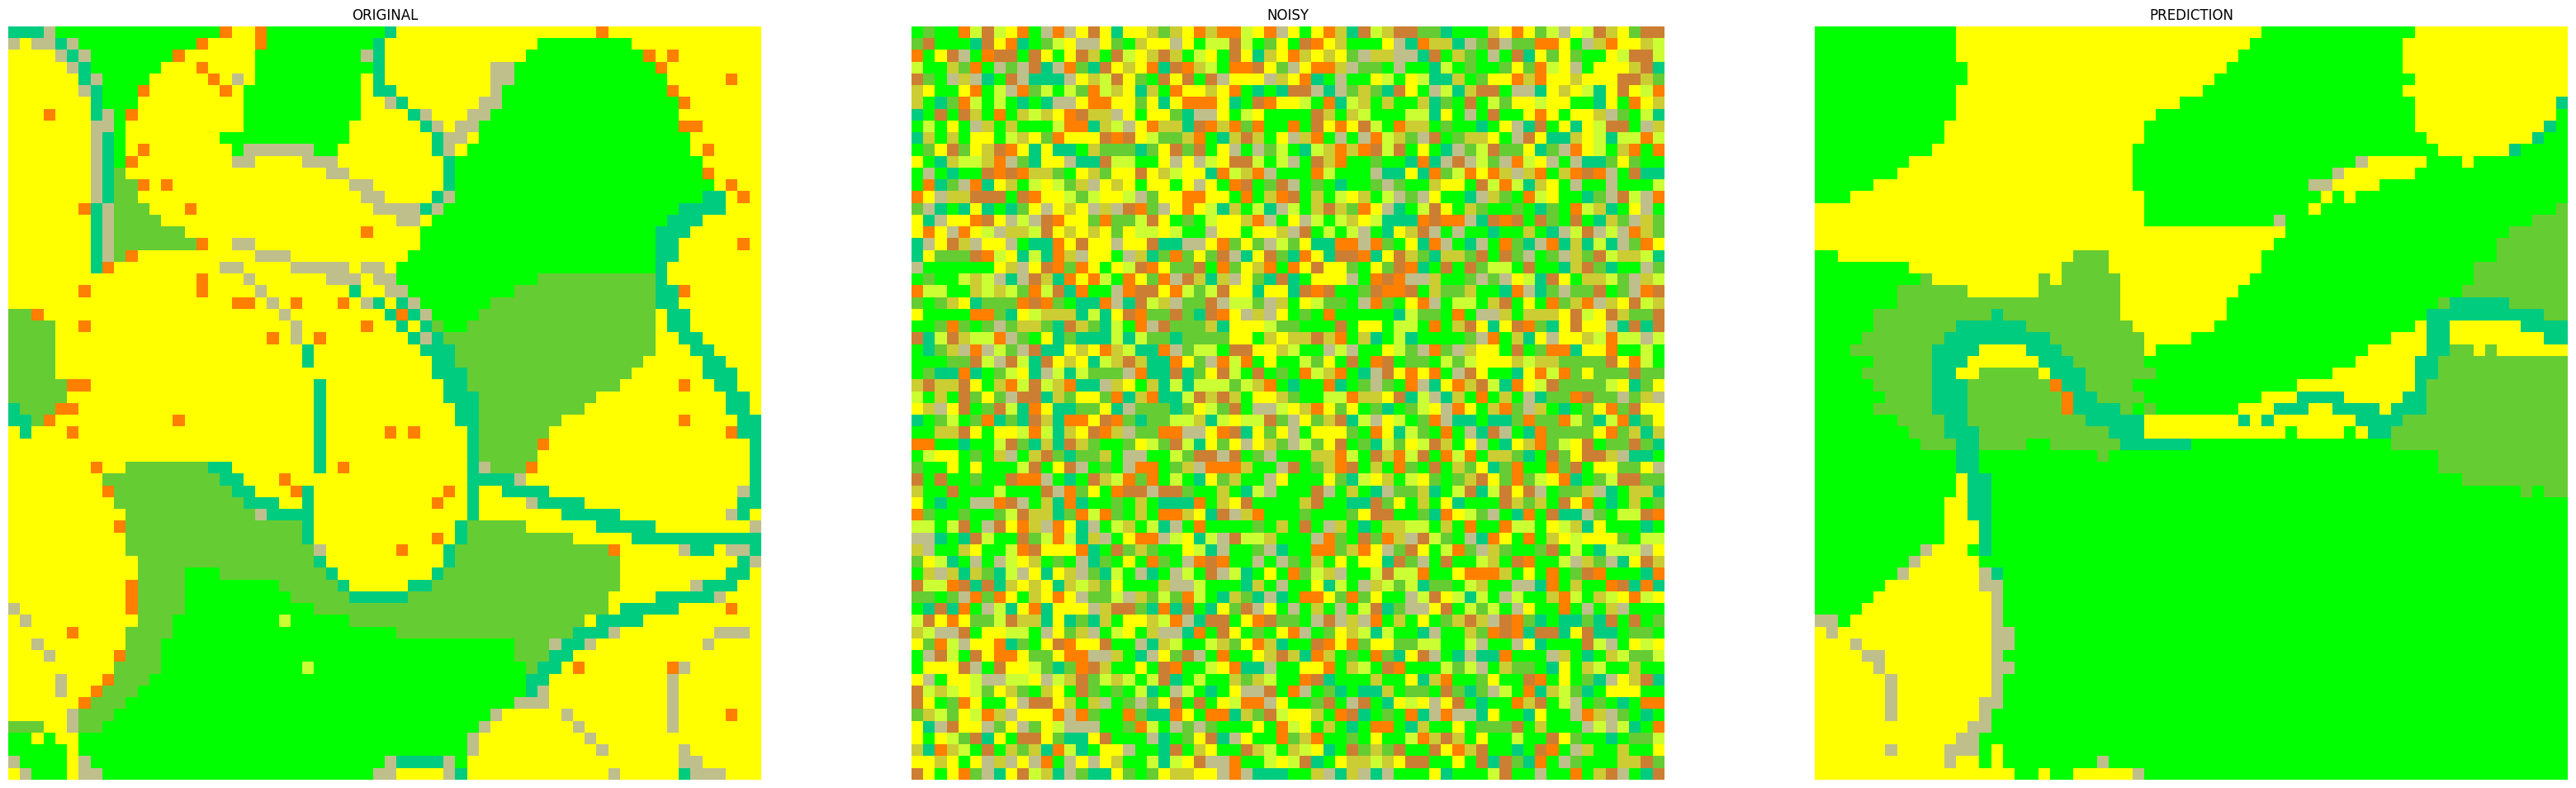

tf.Tensor([[[[0.68]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.67]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00255909 0.00271913 0.00272214 0.00247266 0.00251021 0.00247894
 0.00278082 0.97911243 0.00264458], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 31, step: 0.67


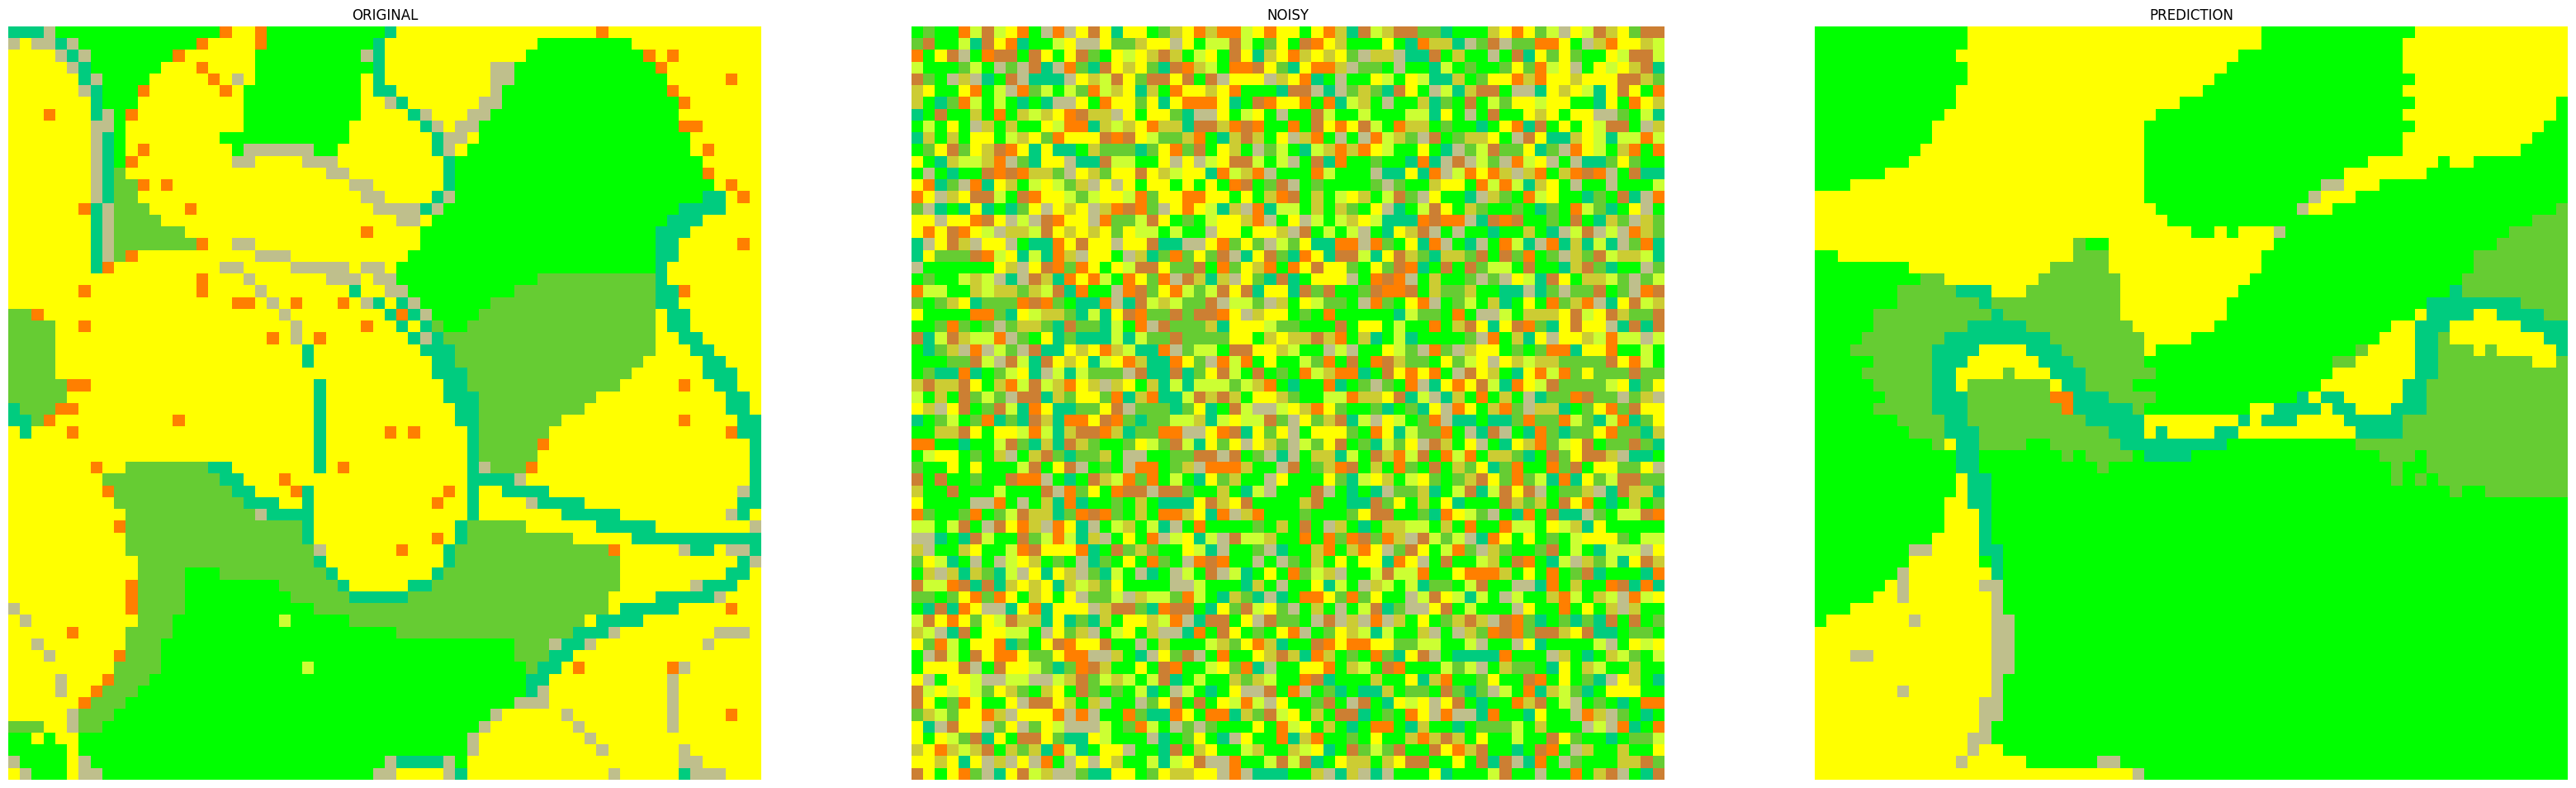

tf.Tensor([[[[0.67]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.66]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00235728 0.00251025 0.00251712 0.00227054 0.00231307 0.0022775
 0.00257243 0.98074201 0.0024398 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 32, step: 0.66


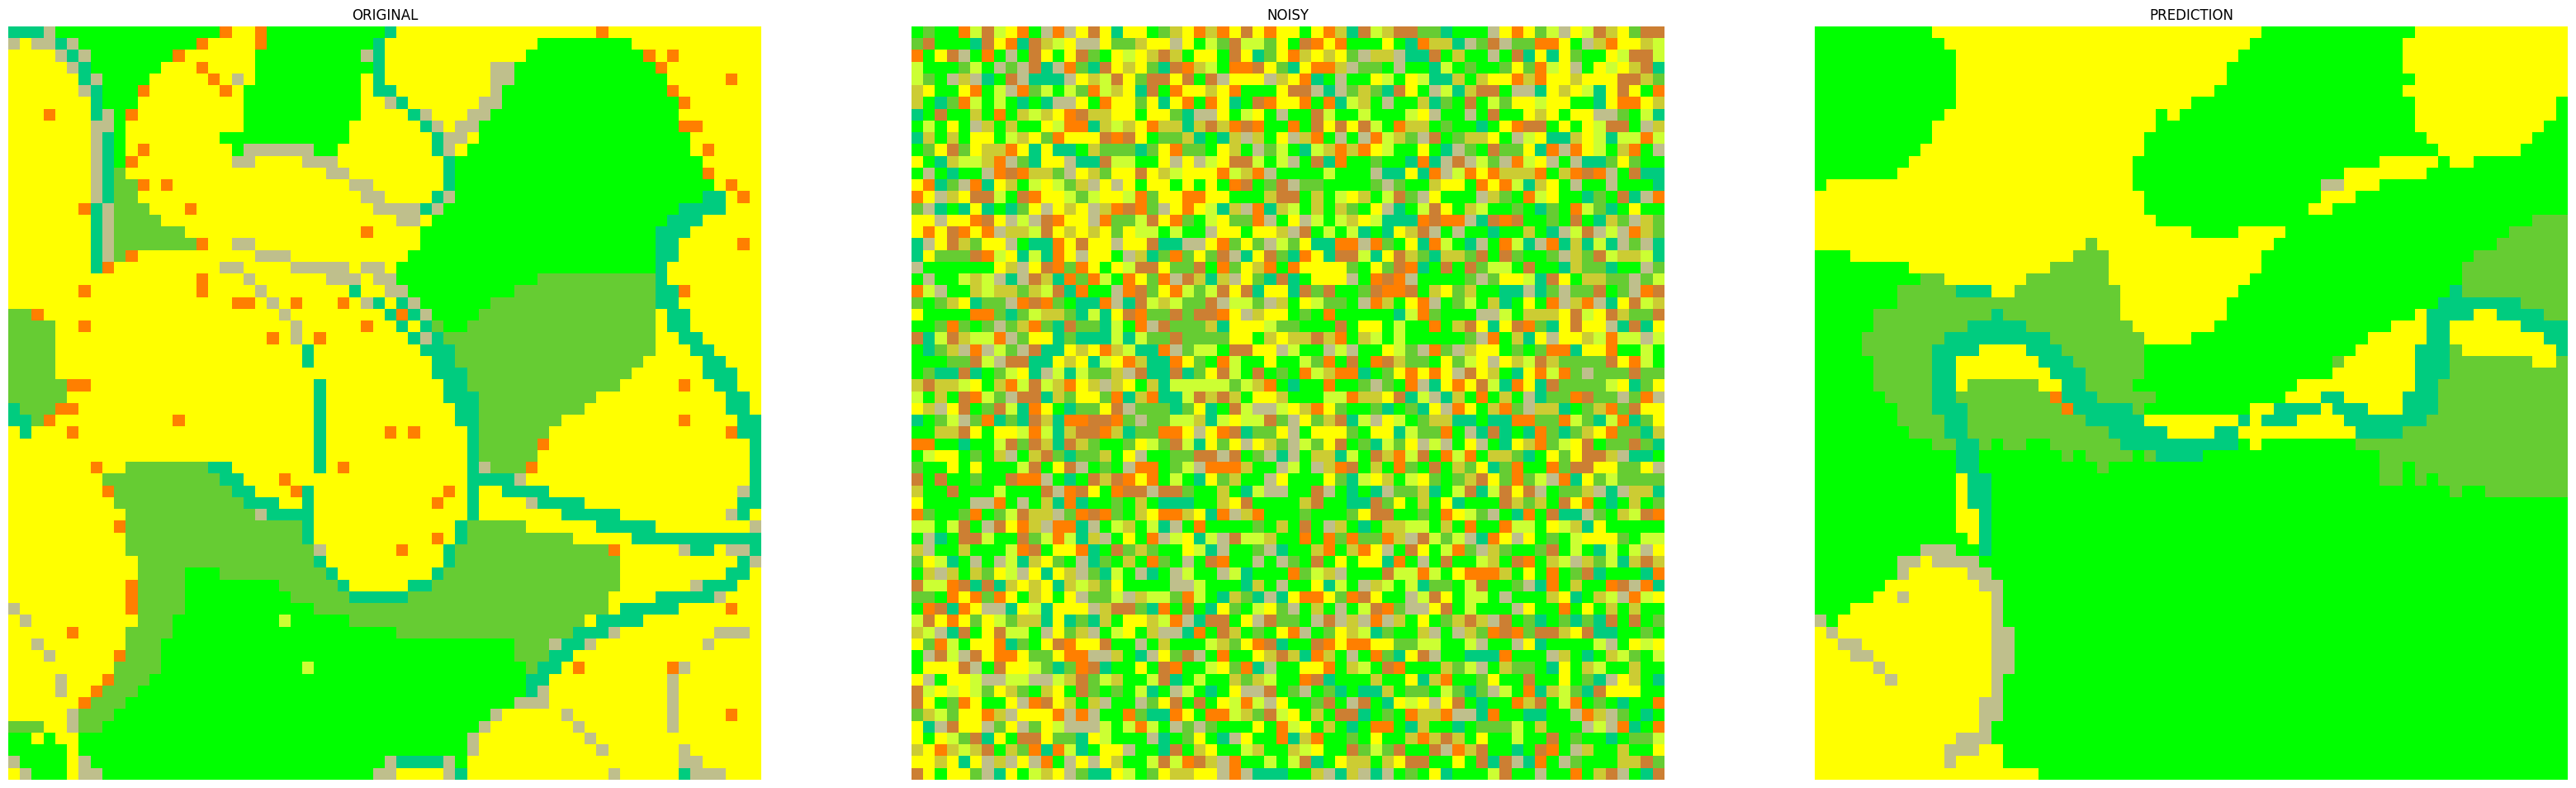

tf.Tensor([[[[0.66]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.65]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00217524 0.00232732 0.00233603 0.00208989 0.00213476 0.00209689
 0.00239868 0.98217634 0.00226484], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 33, step: 0.65


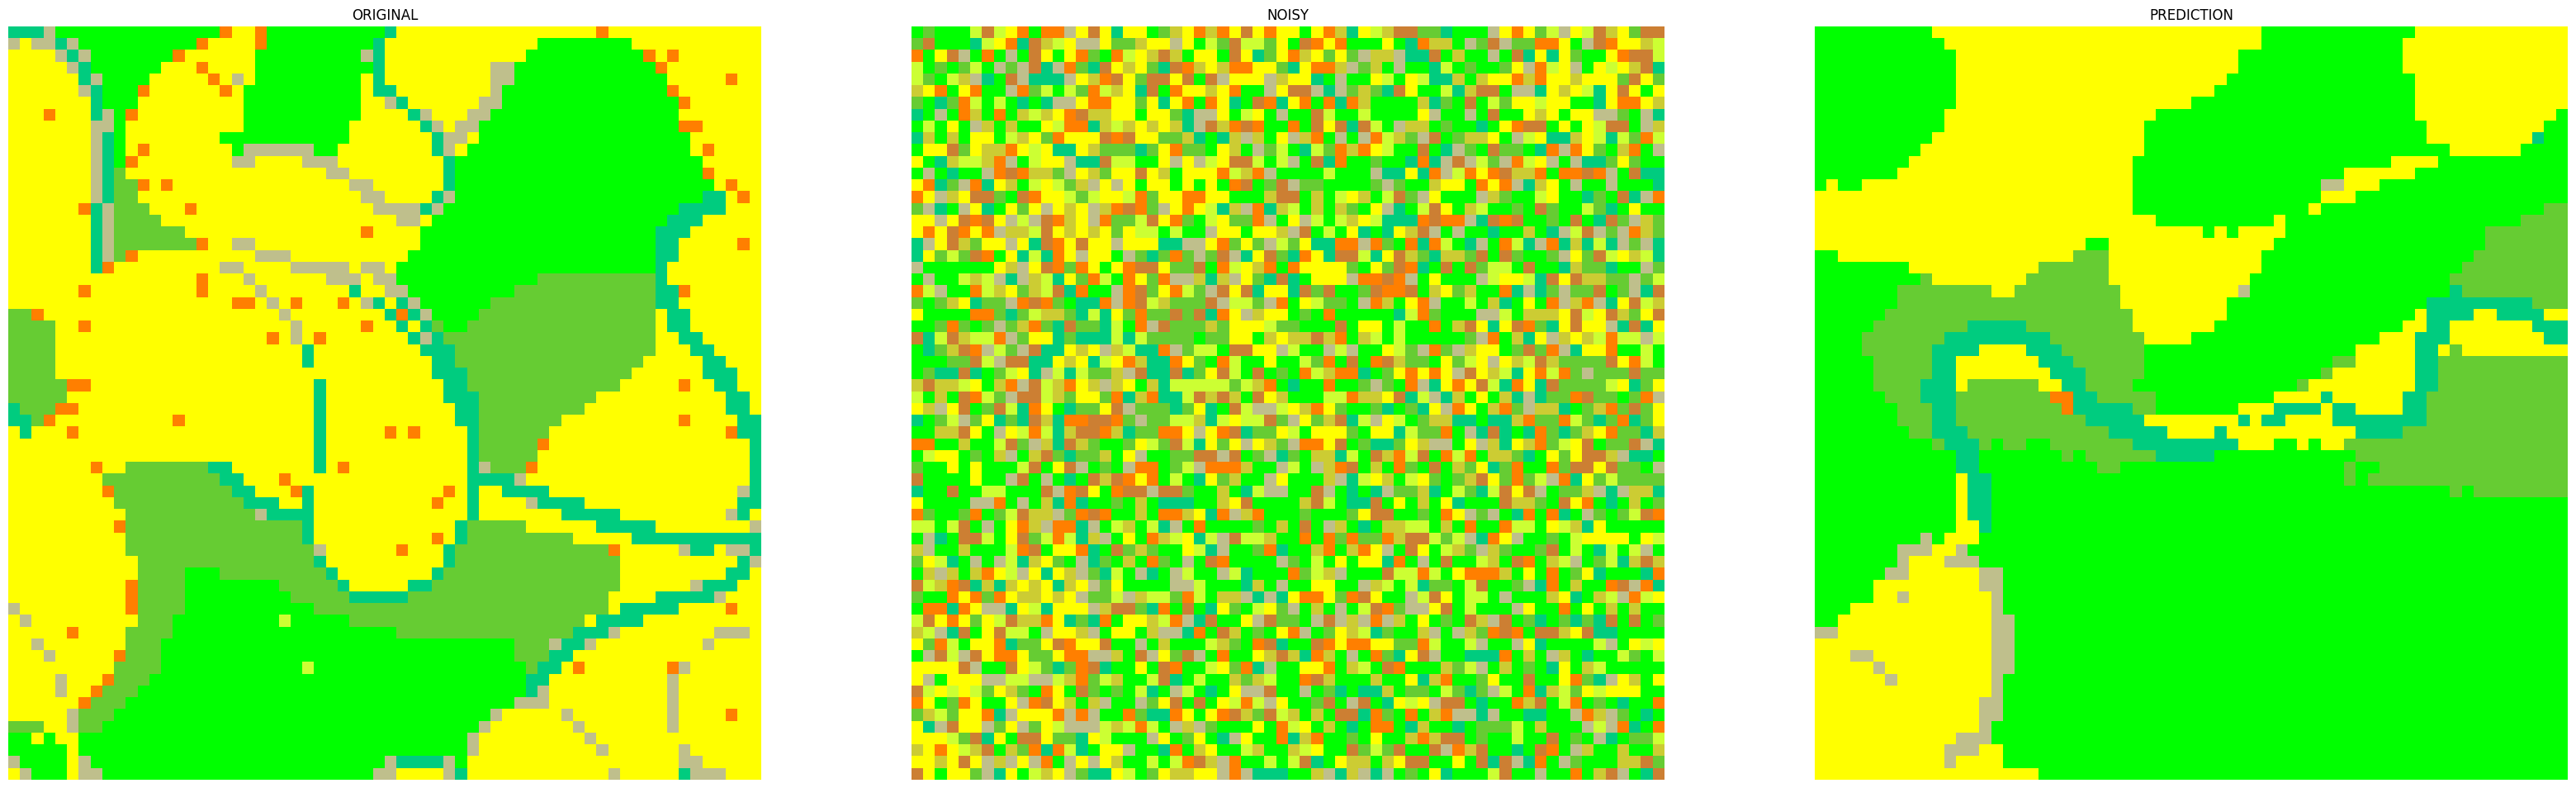

tf.Tensor([[[[0.65]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.64]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00197655 0.00210989 0.00212123 0.00190315 0.00194897 0.0019106
 0.00221416 0.98374778 0.00206767], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 34, step: 0.64


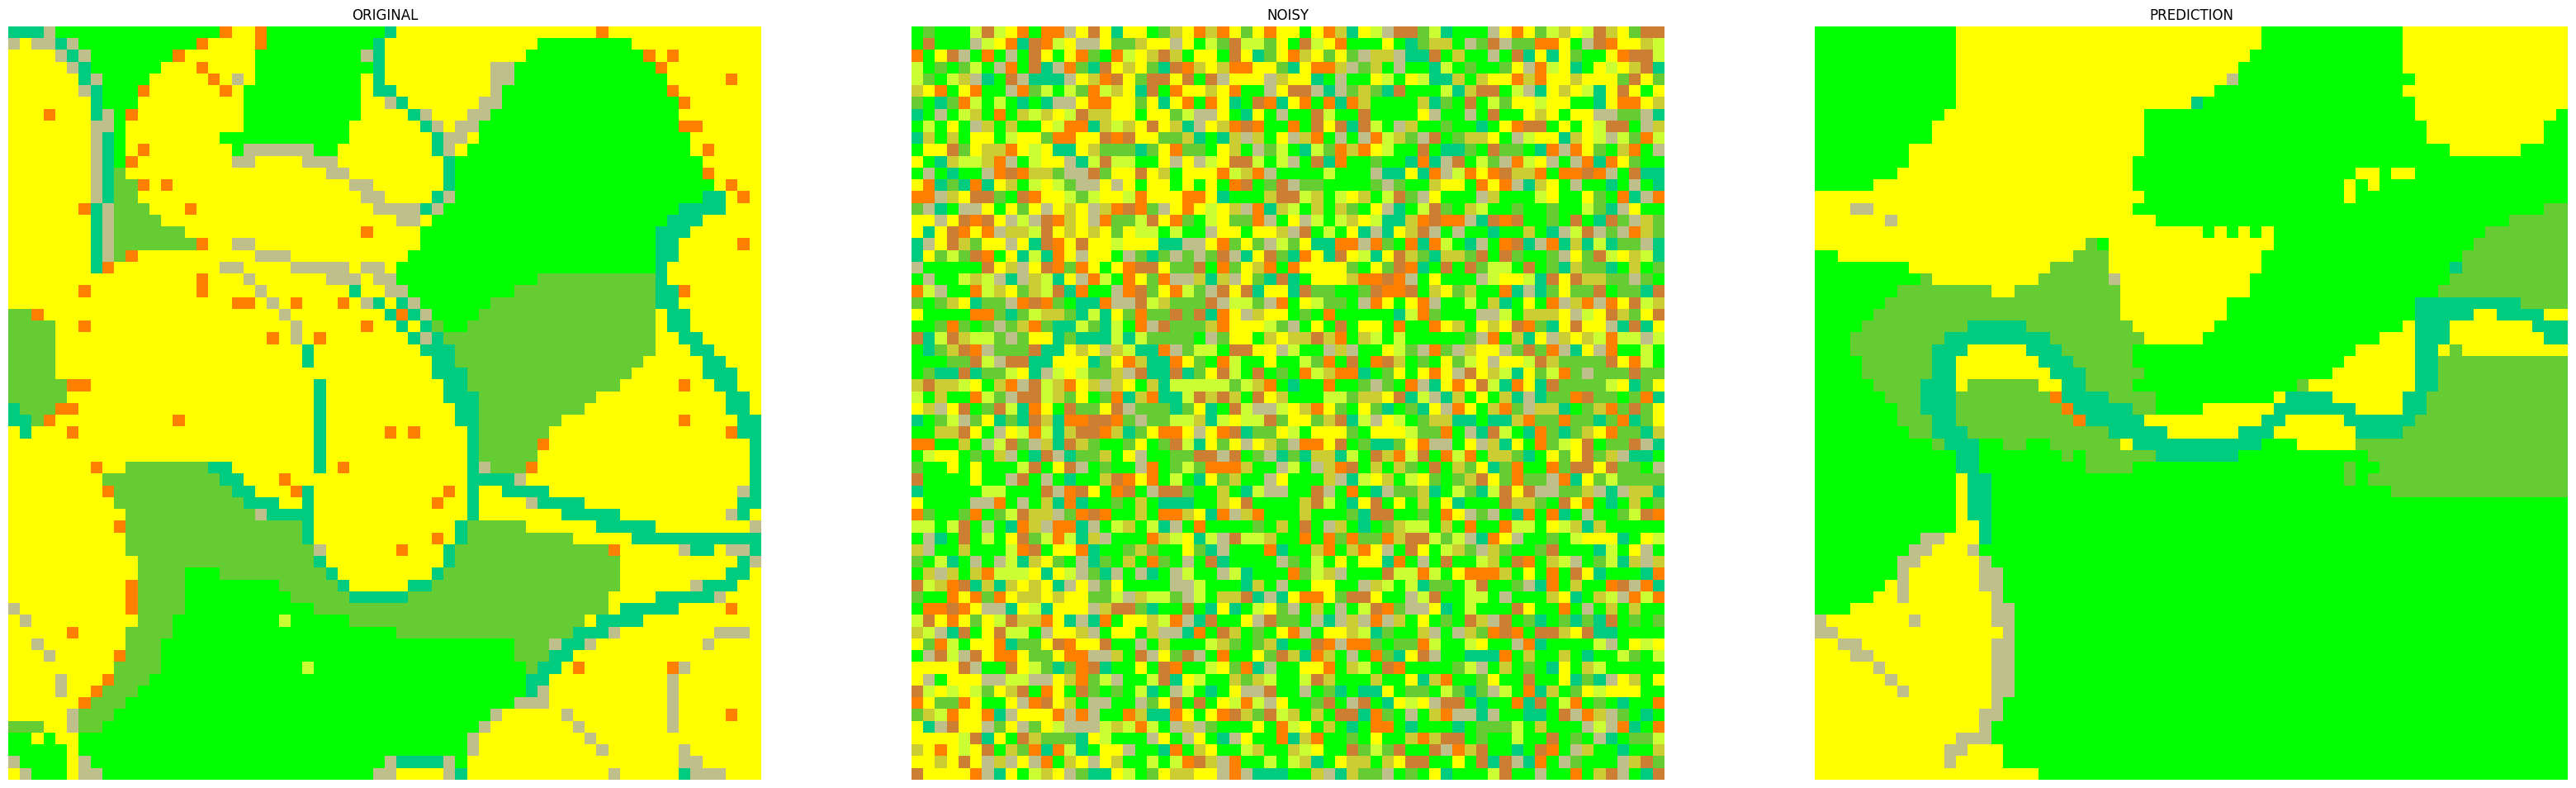

tf.Tensor([[[[0.64]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.63]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00172727 0.00182364 0.00182154 0.00166955 0.00170683 0.00167574
 0.00183948 0.98594921 0.00178674], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 35, step: 0.63


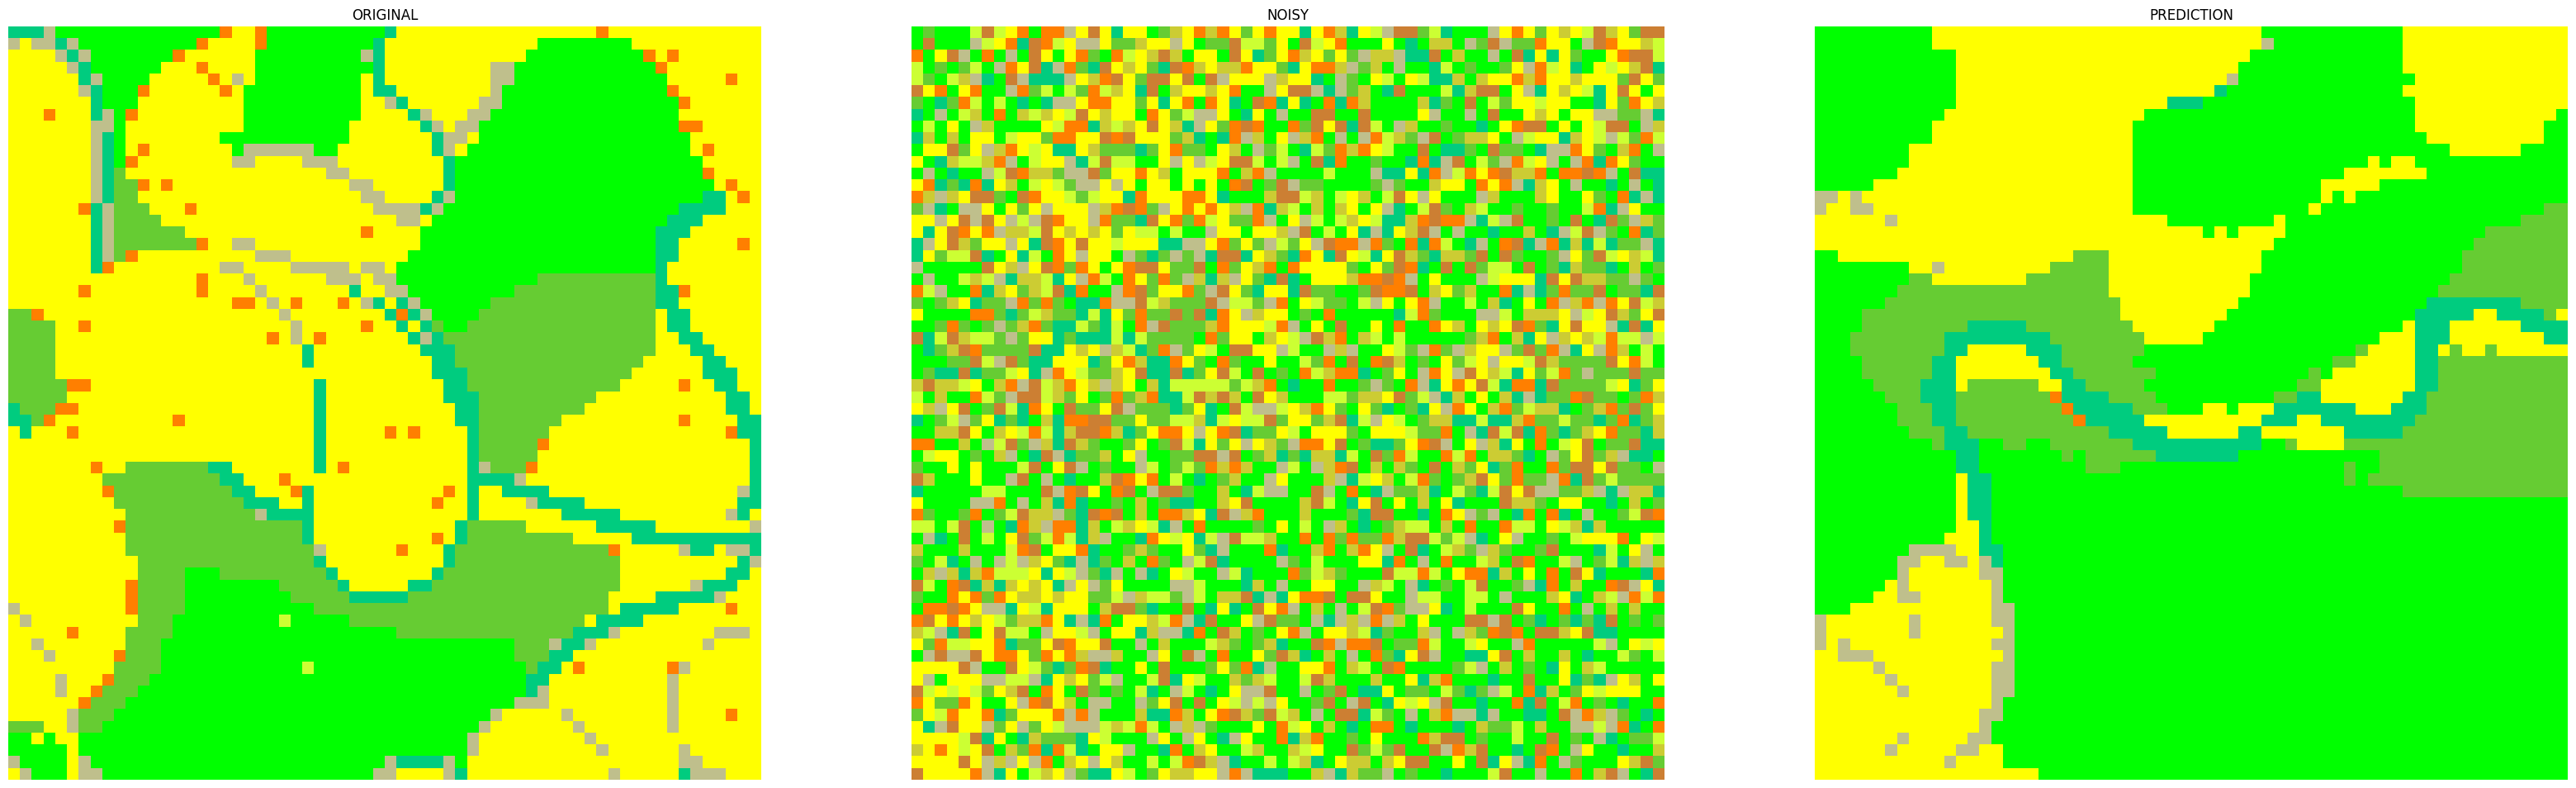

tf.Tensor([[[[0.63]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.62]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00158186 0.0016752  0.00167148 0.00152651 0.00156201 0.00153216
 0.0016949  0.98712078 0.00163511], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 36, step: 0.62


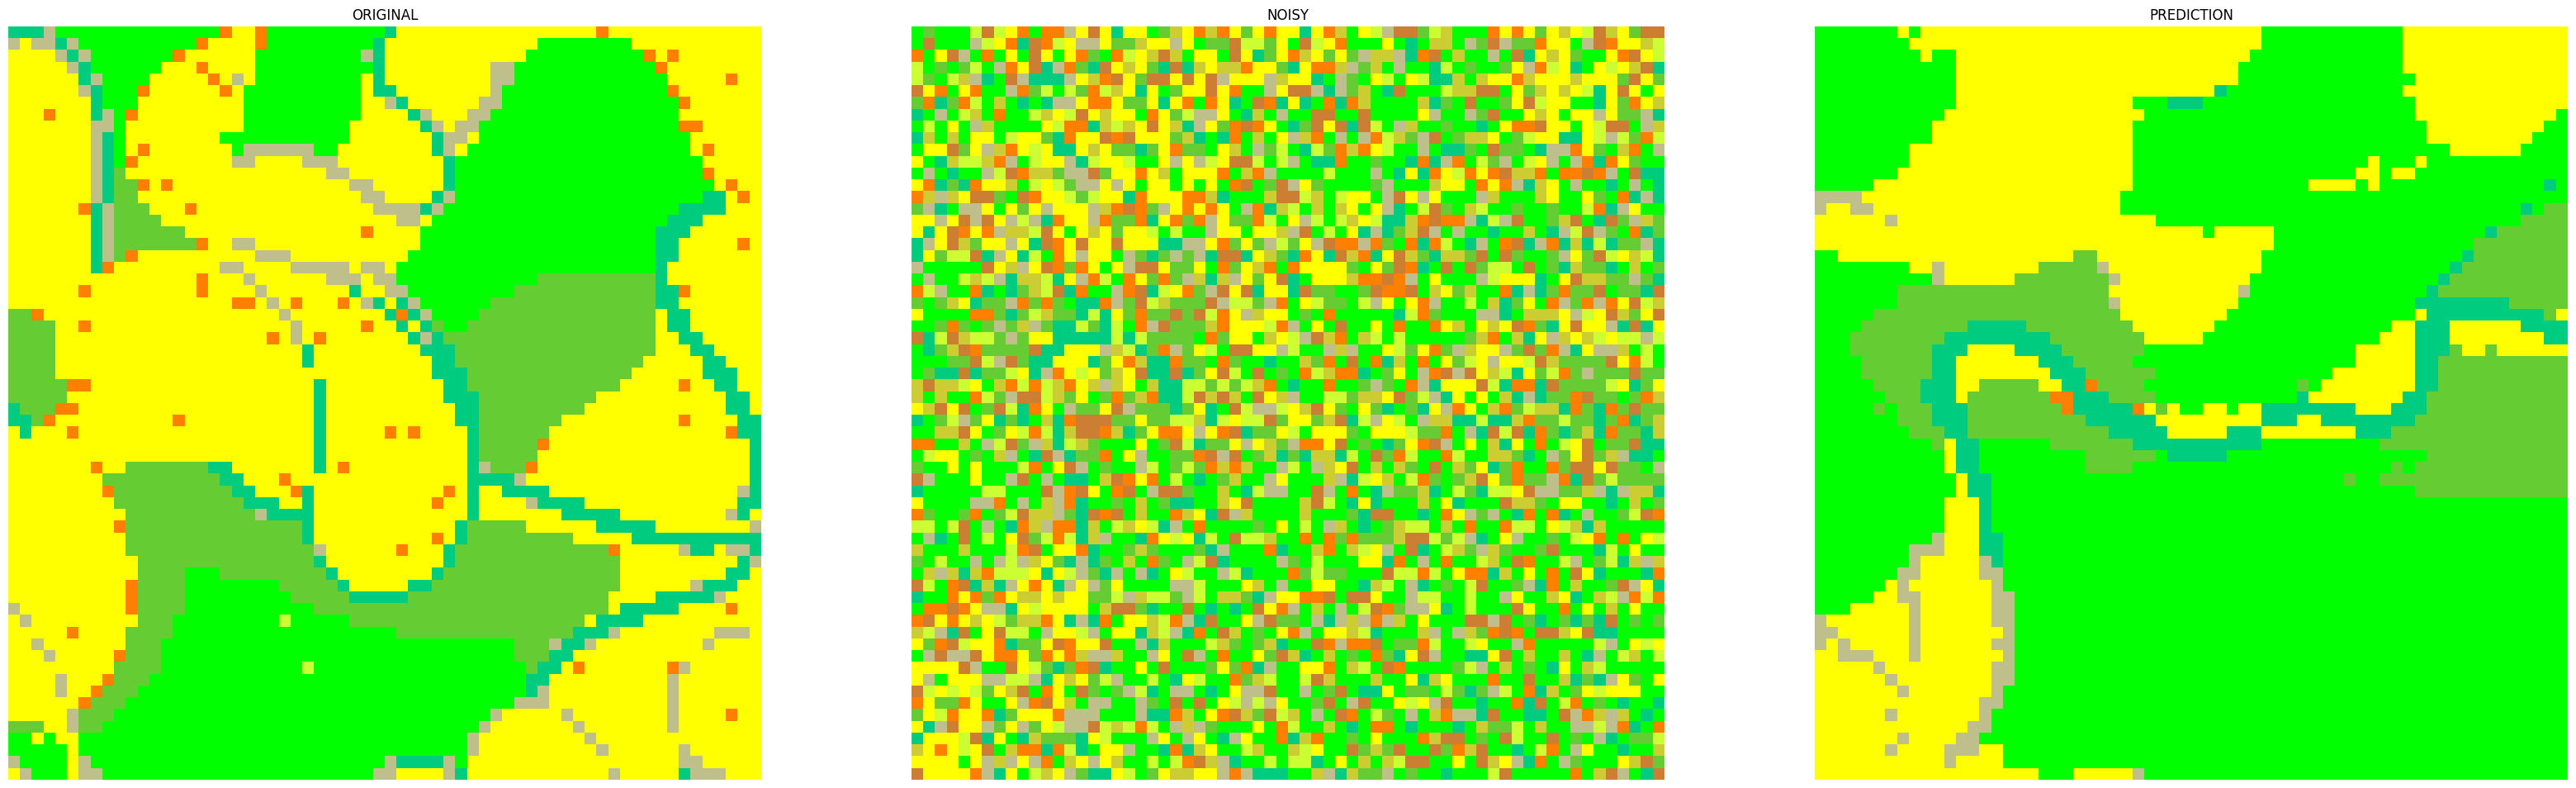

tf.Tensor([[[[0.62]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.61]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0014536  0.00154561 0.00153401 0.00139796 0.0014314  0.00140333
 0.00156127 0.98816891 0.00150391], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 37, step: 0.61


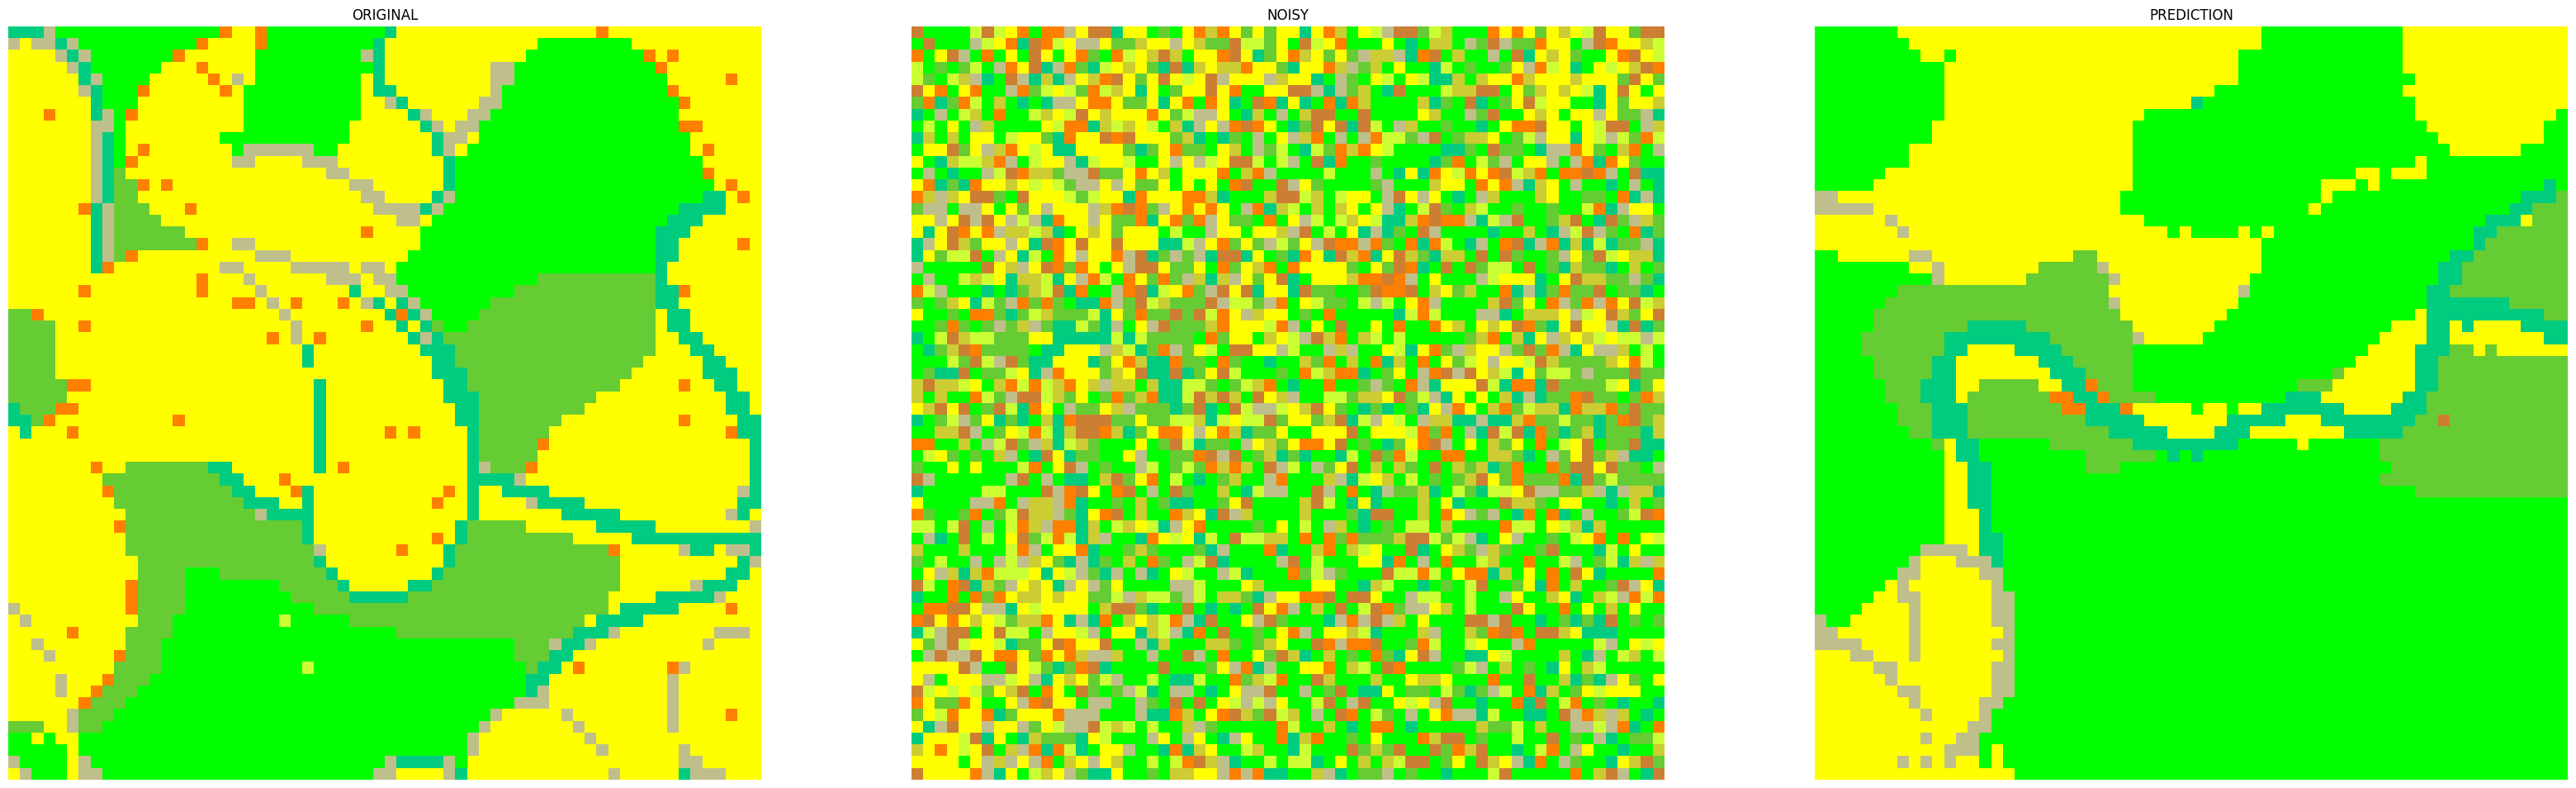

tf.Tensor([[[[0.61]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.6]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00542703 0.00568349 0.00570646 0.93768775 0.00536995 0.00527541
 0.0055834  0.0237173  0.0055492 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 38, step: 0.6


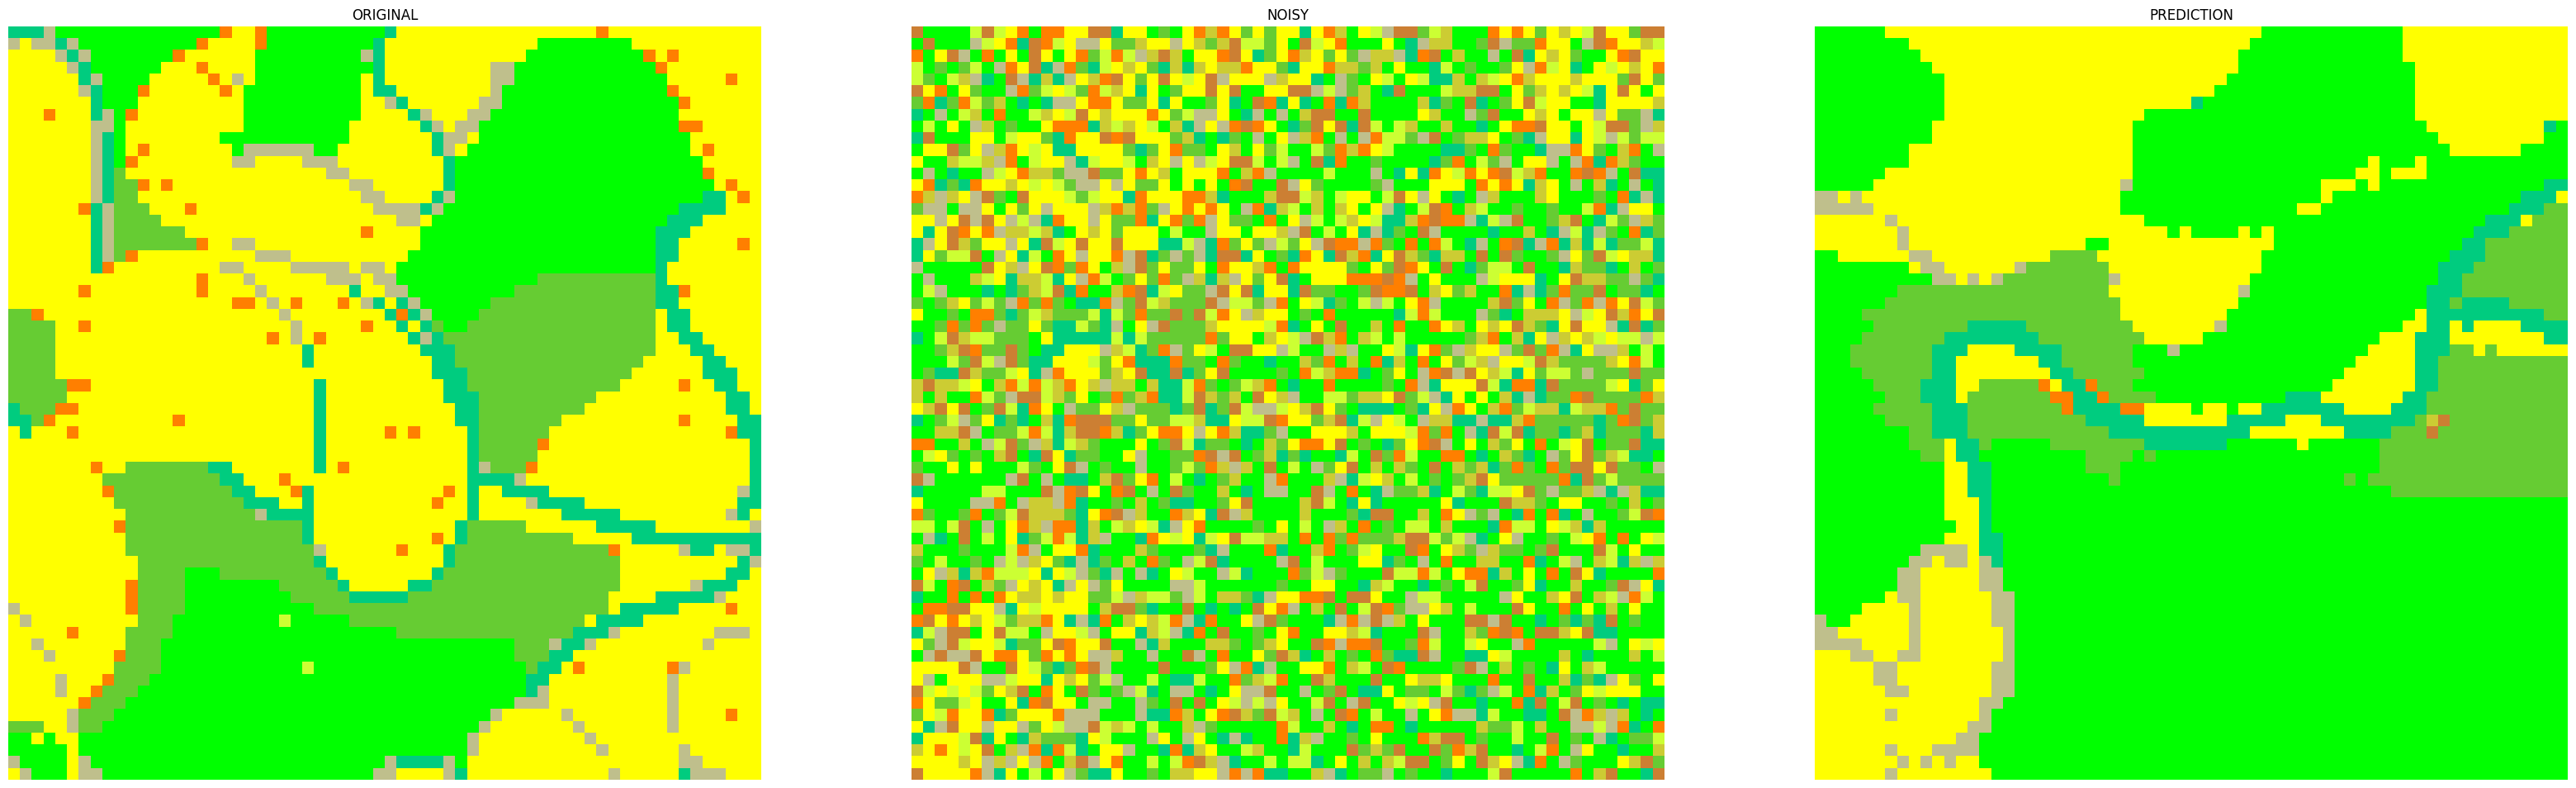

tf.Tensor([[[[0.6]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.59]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00525522 0.00550072 0.00554386 0.93831154 0.0052017  0.0051052
 0.00543982 0.02425903 0.00538292], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 39, step: 0.59


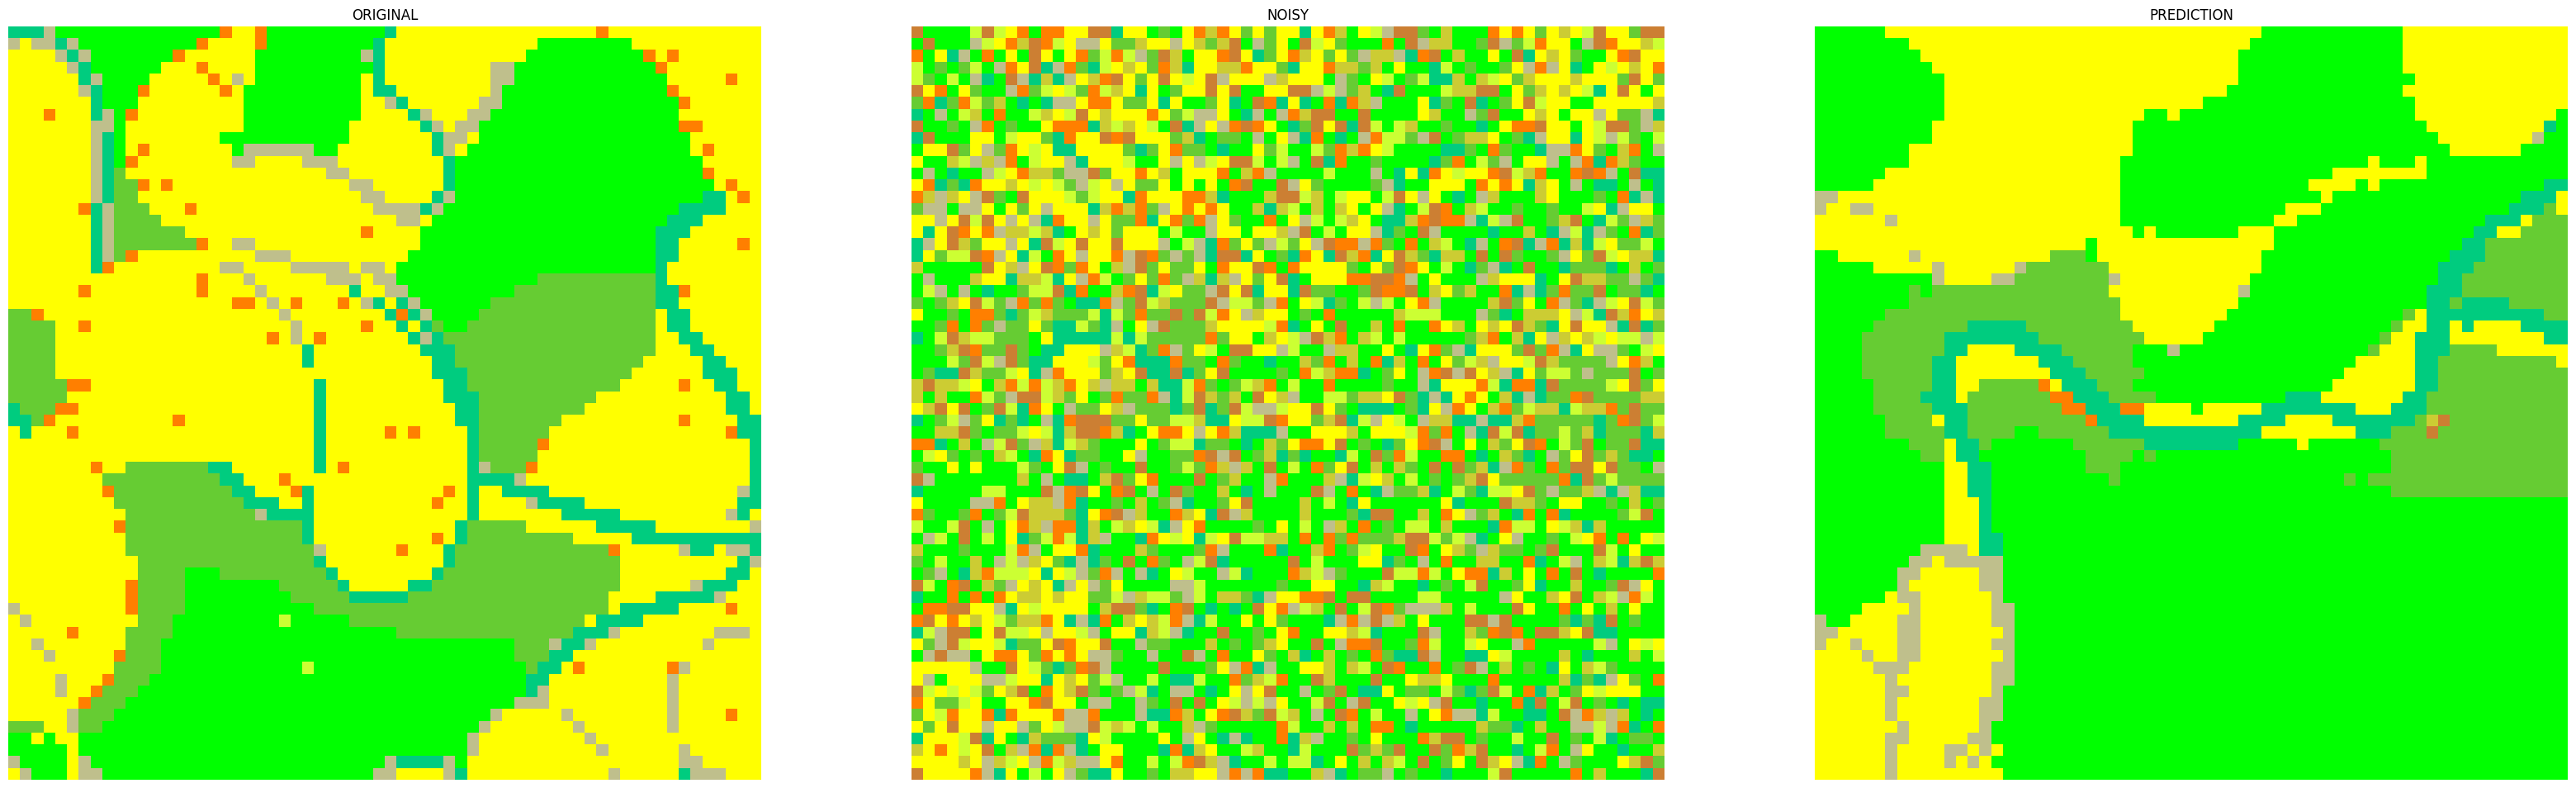

tf.Tensor([[[[0.59]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.58]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00508361 0.00533418 0.00534648 0.93882601 0.00502974 0.00494008
 0.00525042 0.02499453 0.00519495], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 40, step: 0.58


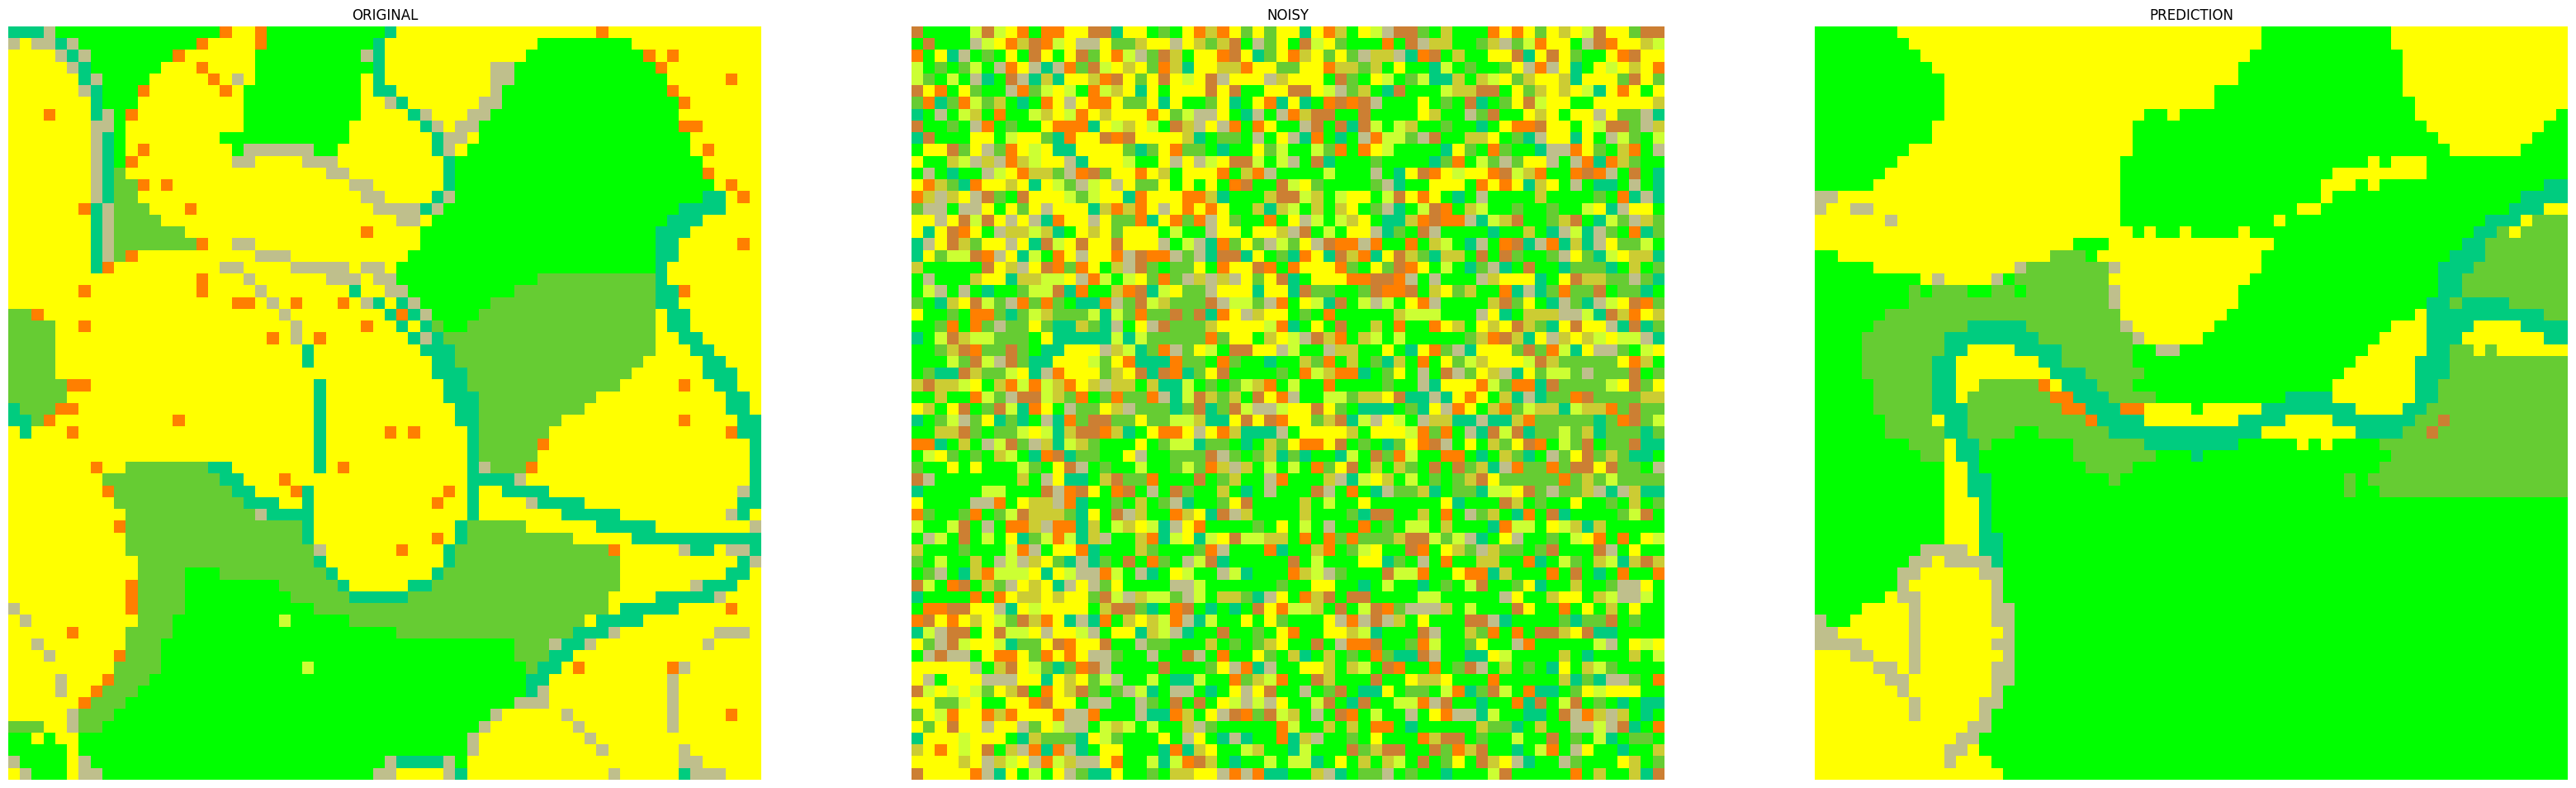

tf.Tensor([[[[0.58]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.57]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00493638 0.00518882 0.00519586 0.93931008 0.00487598 0.00478354
 0.00512987 0.02554535 0.00503412], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 41, step: 0.5700000000000001


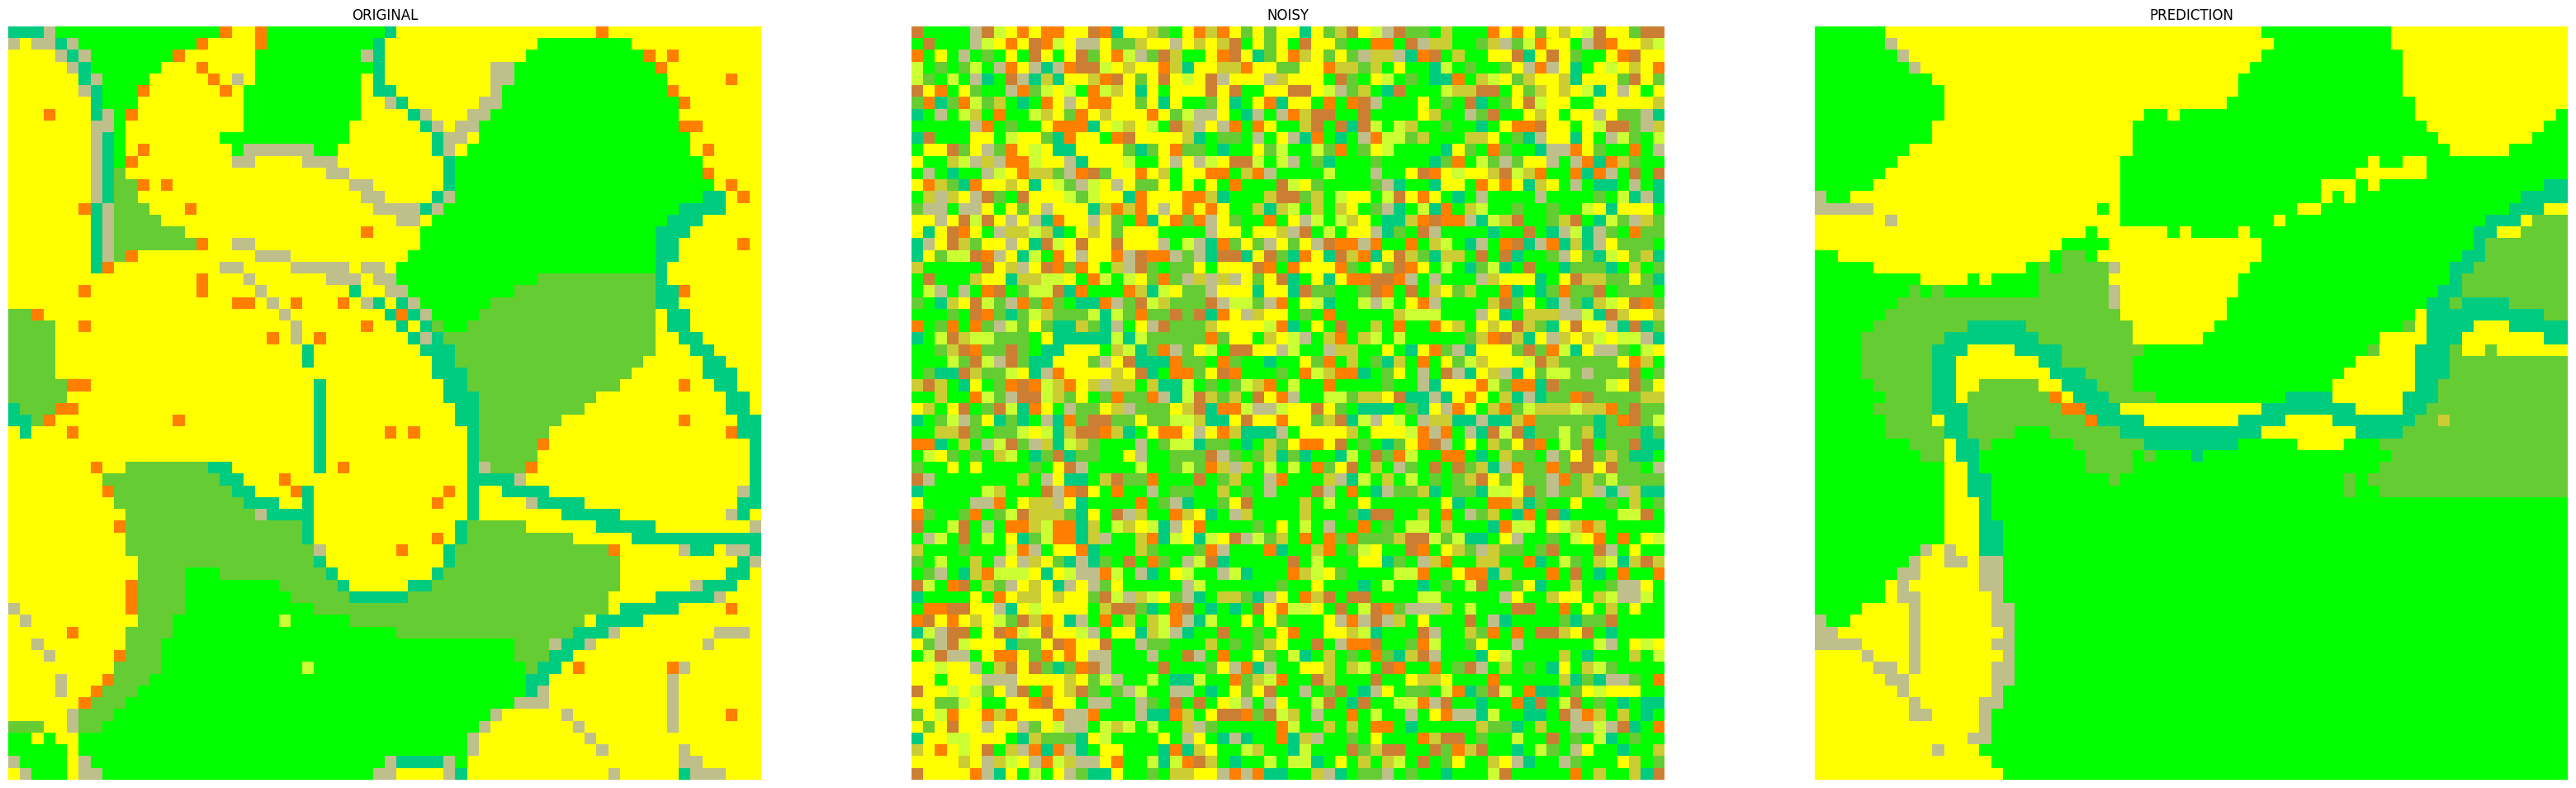

tf.Tensor([[[[0.57]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.56]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00479614 0.00504867 0.00504934 0.93972005 0.00472844 0.00463337
 0.00501135 0.02613984 0.0048728 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 42, step: 0.56


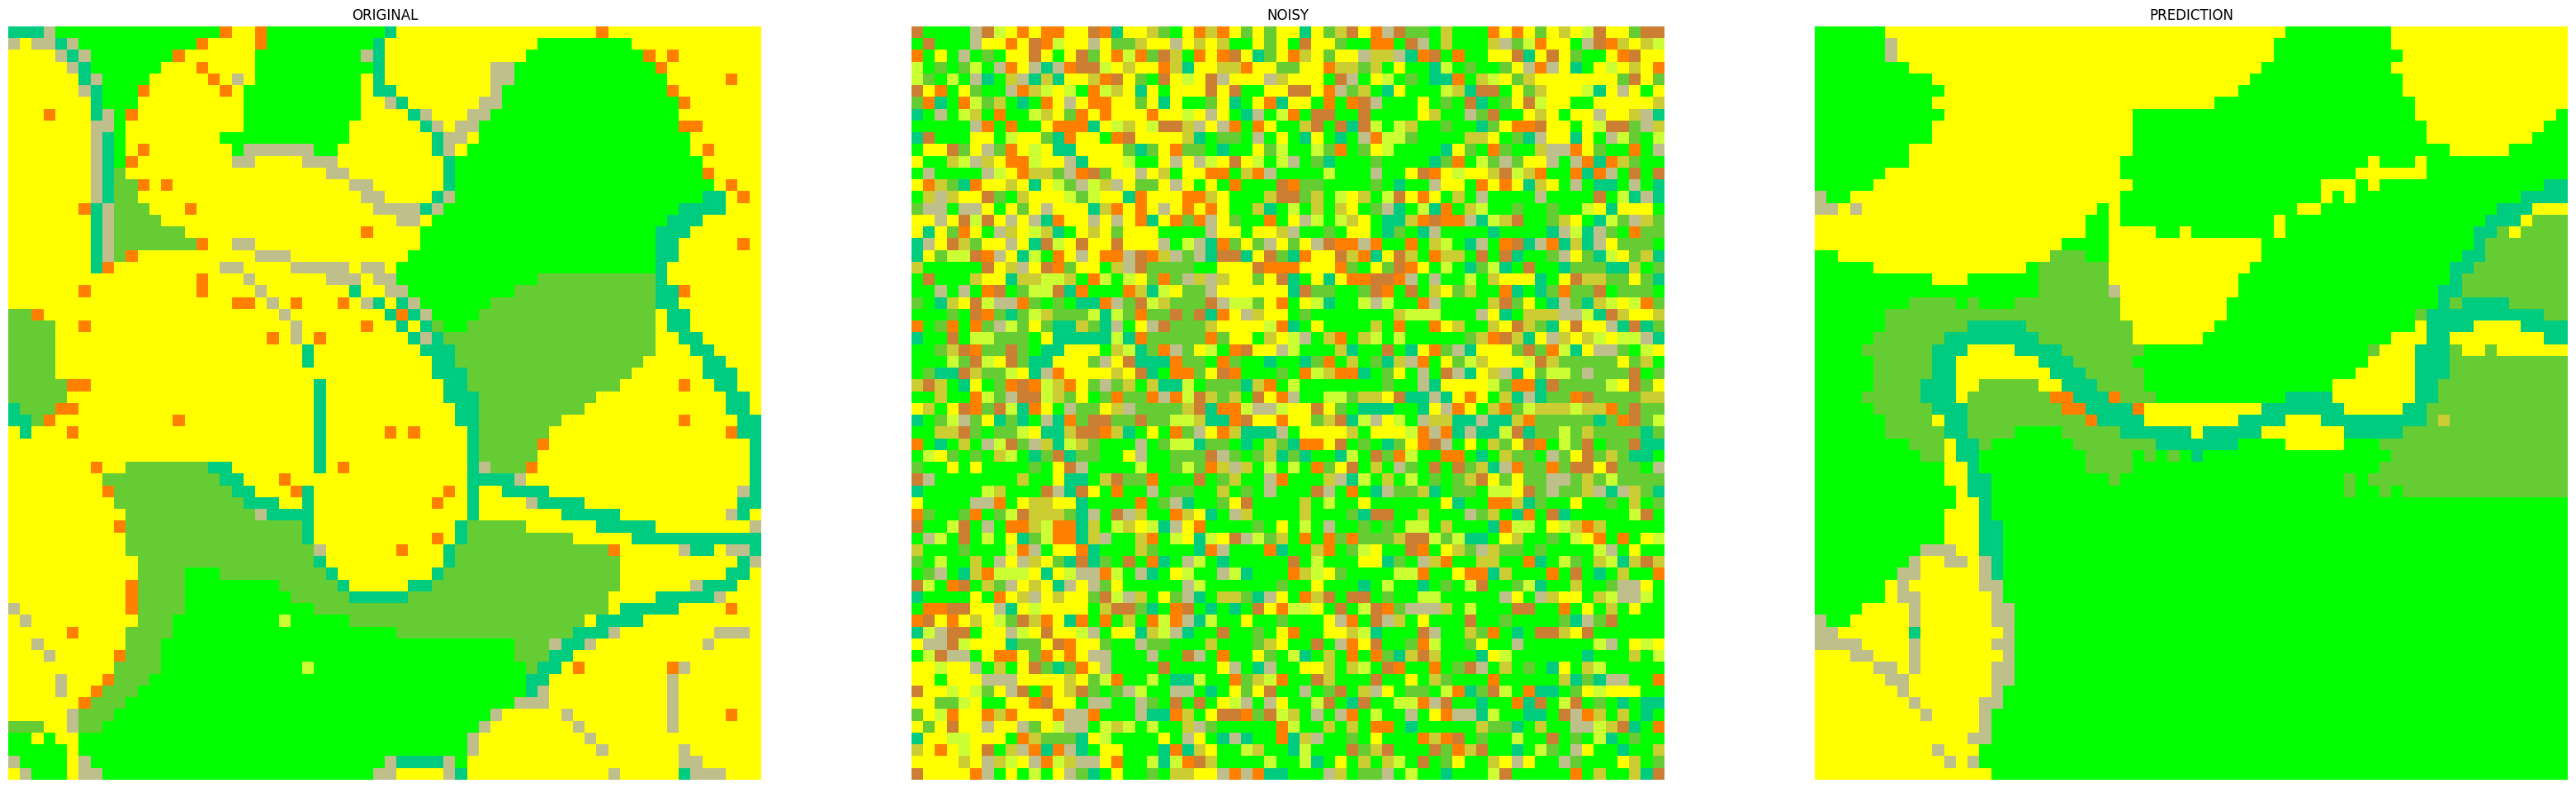

tf.Tensor([[[[0.56]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.55]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00466957 0.00494184 0.00489639 0.94007257 0.00458656 0.00448804
 0.00486527 0.02675647 0.00472328], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 43, step: 0.55


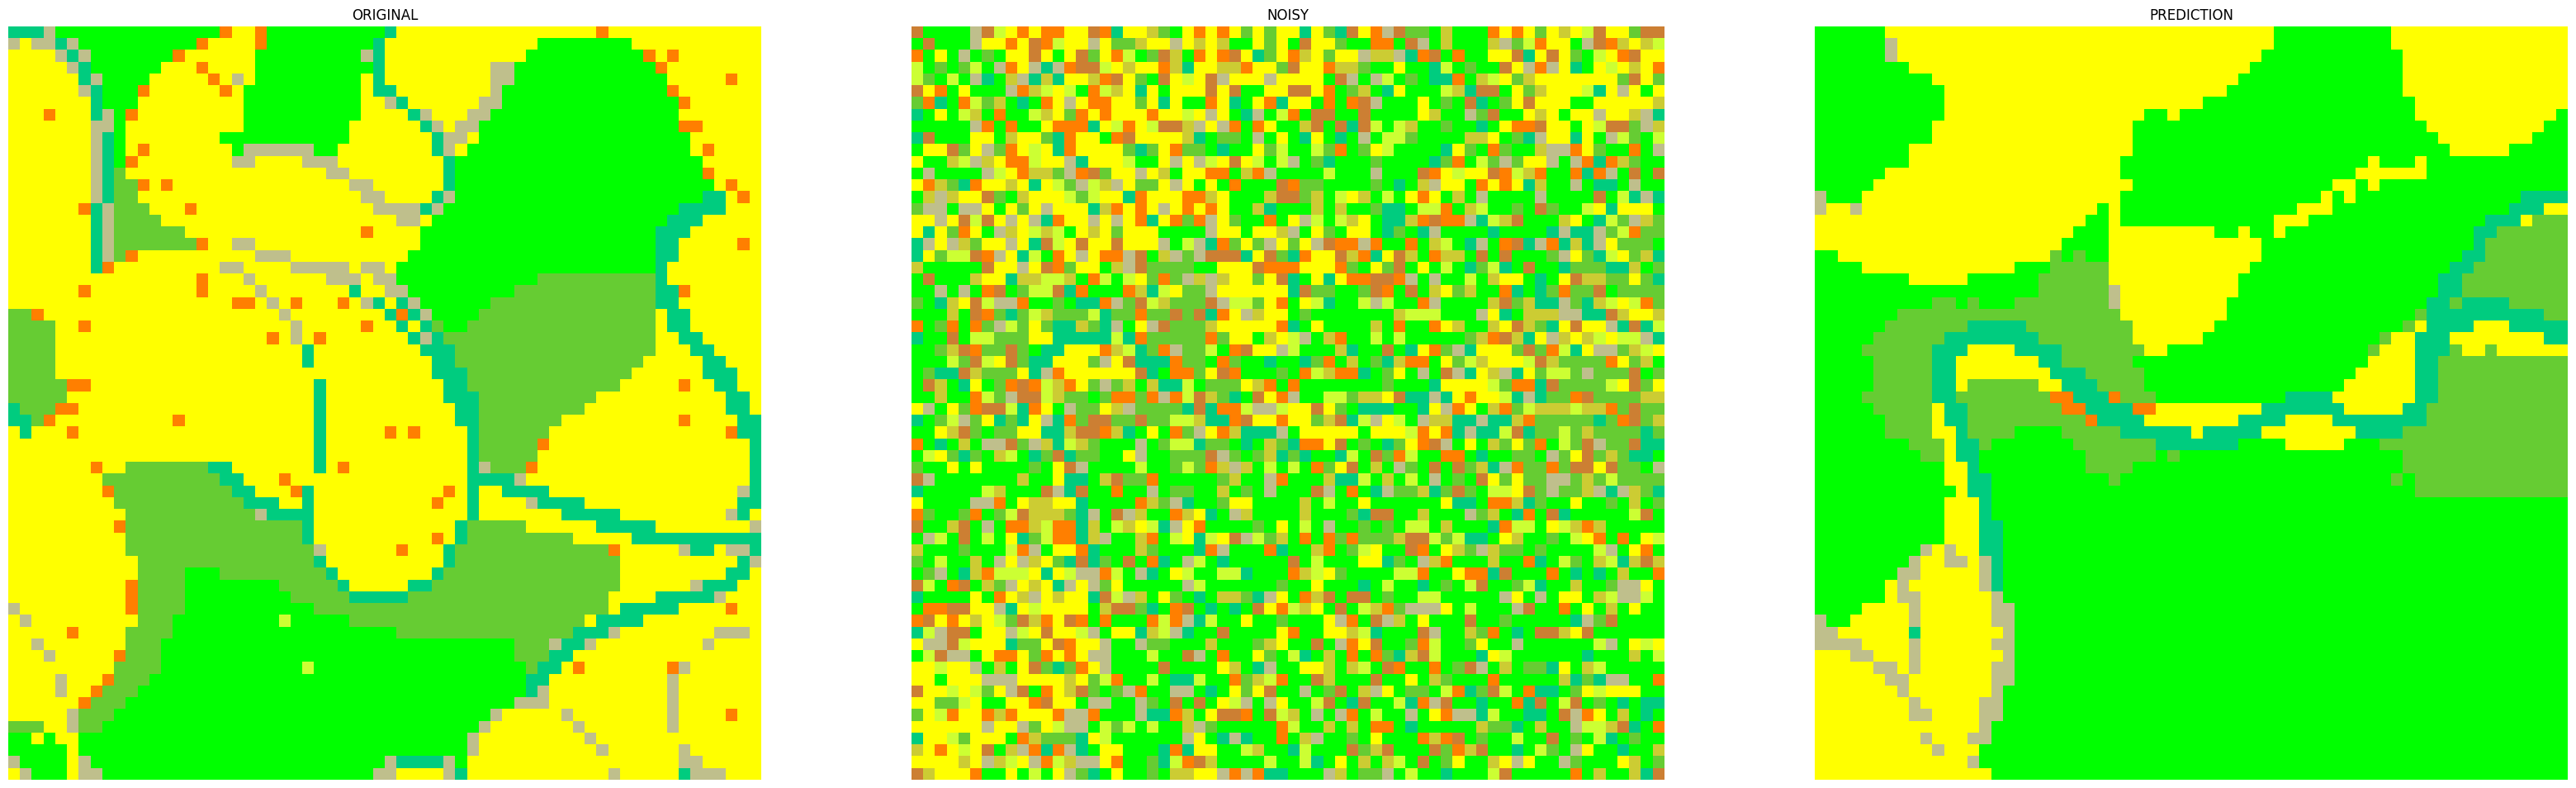

tf.Tensor([[[[0.55]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.54]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00454692 0.00483224 0.00475939 0.94035548 0.00444514 0.00434748
 0.00474351 0.02738612 0.00458372], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 44, step: 0.54


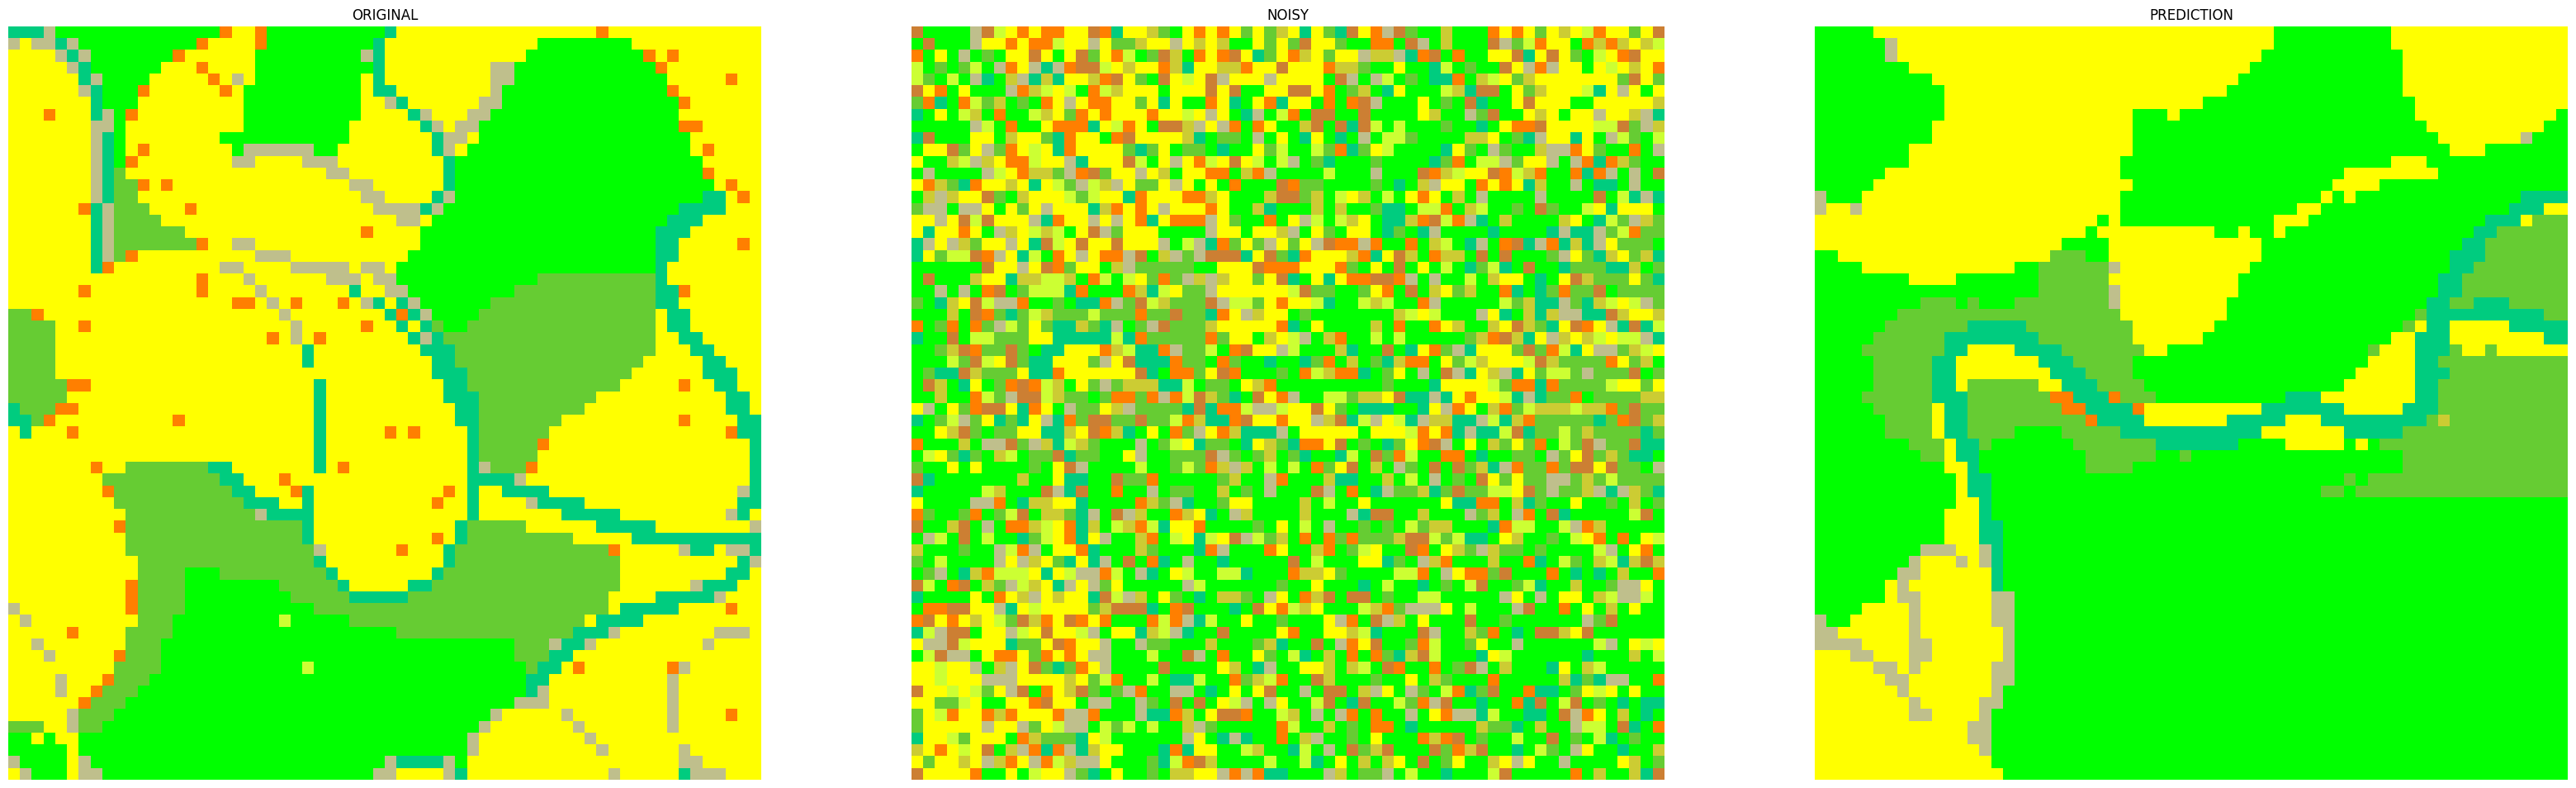

tf.Tensor([[[[0.54]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.53]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00441661 0.00470657 0.00463198 0.94057053 0.00430885 0.00421129
 0.00460649 0.02810139 0.0044463 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 45, step: 0.53


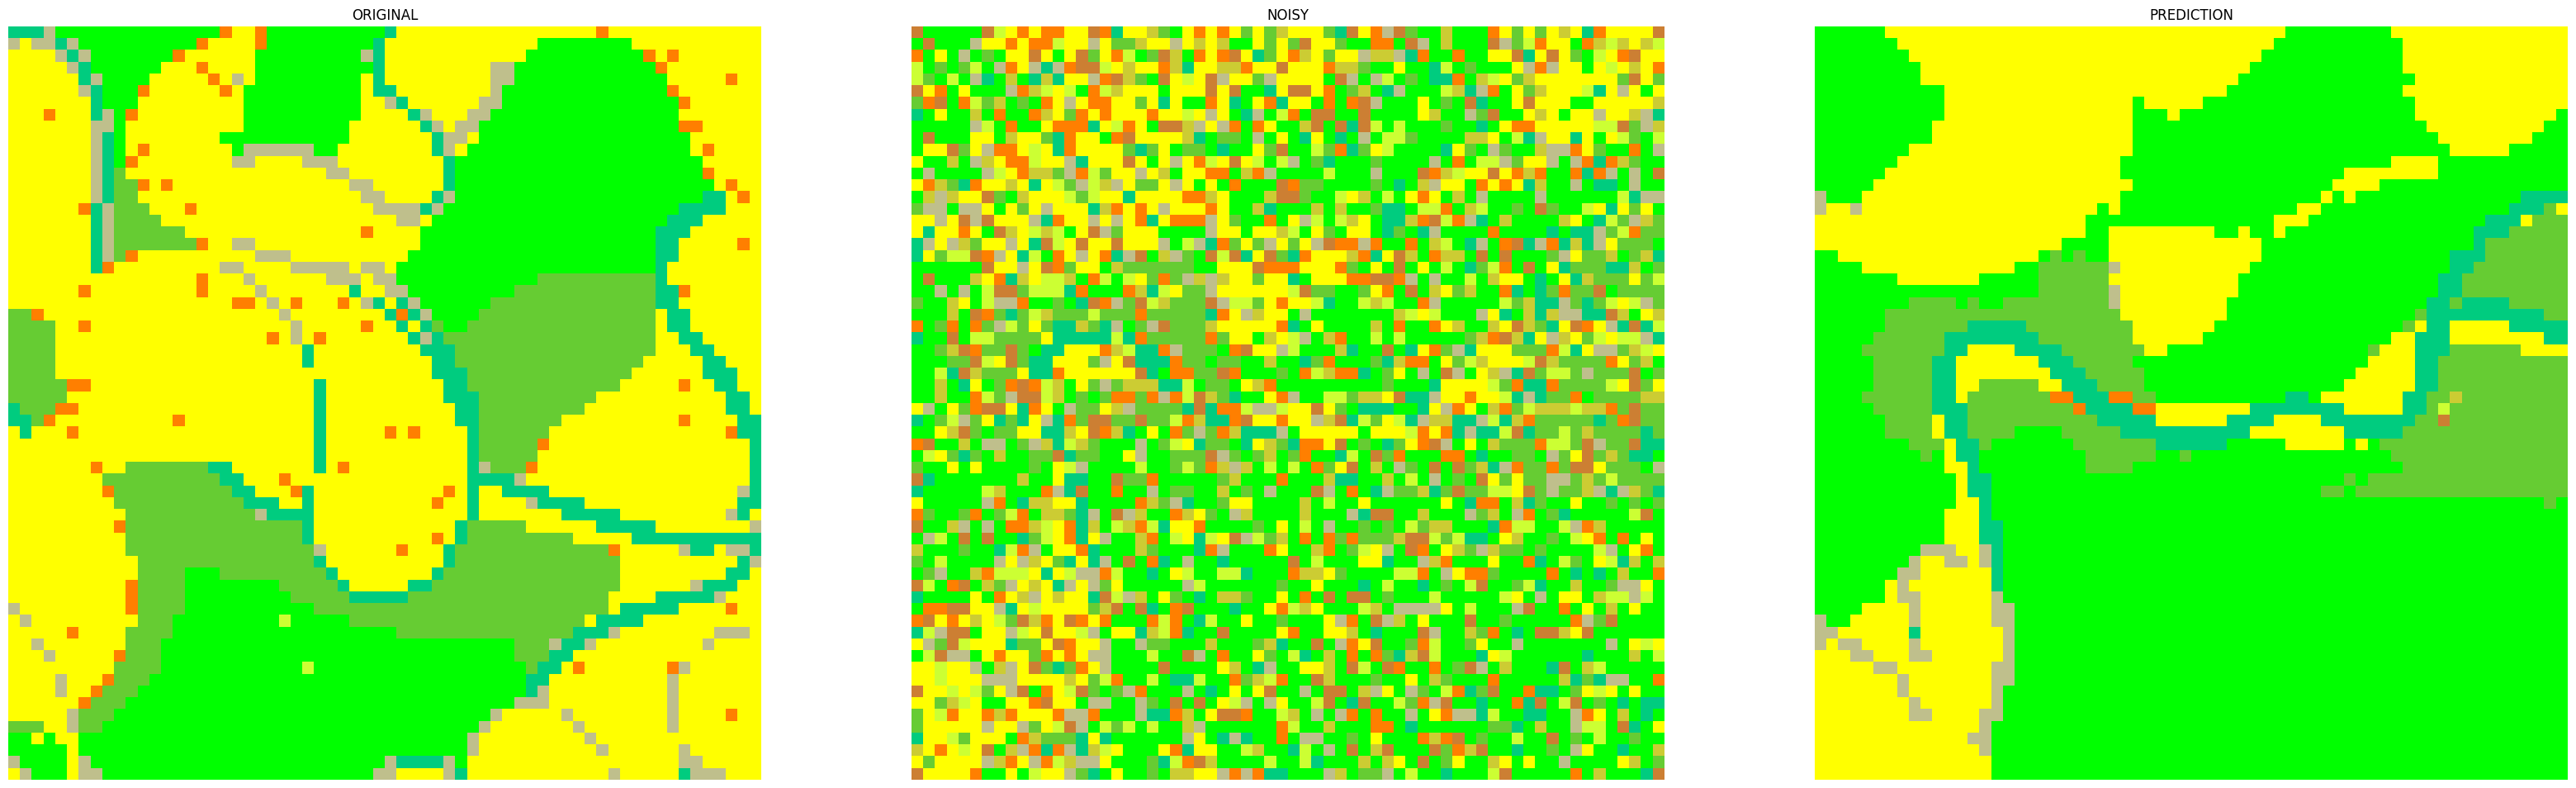

tf.Tensor([[[[0.53]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.52]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00429739 0.00458048 0.0044804  0.94069924 0.00415911 0.00407855
 0.00444455 0.0289566  0.00430369], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 46, step: 0.52


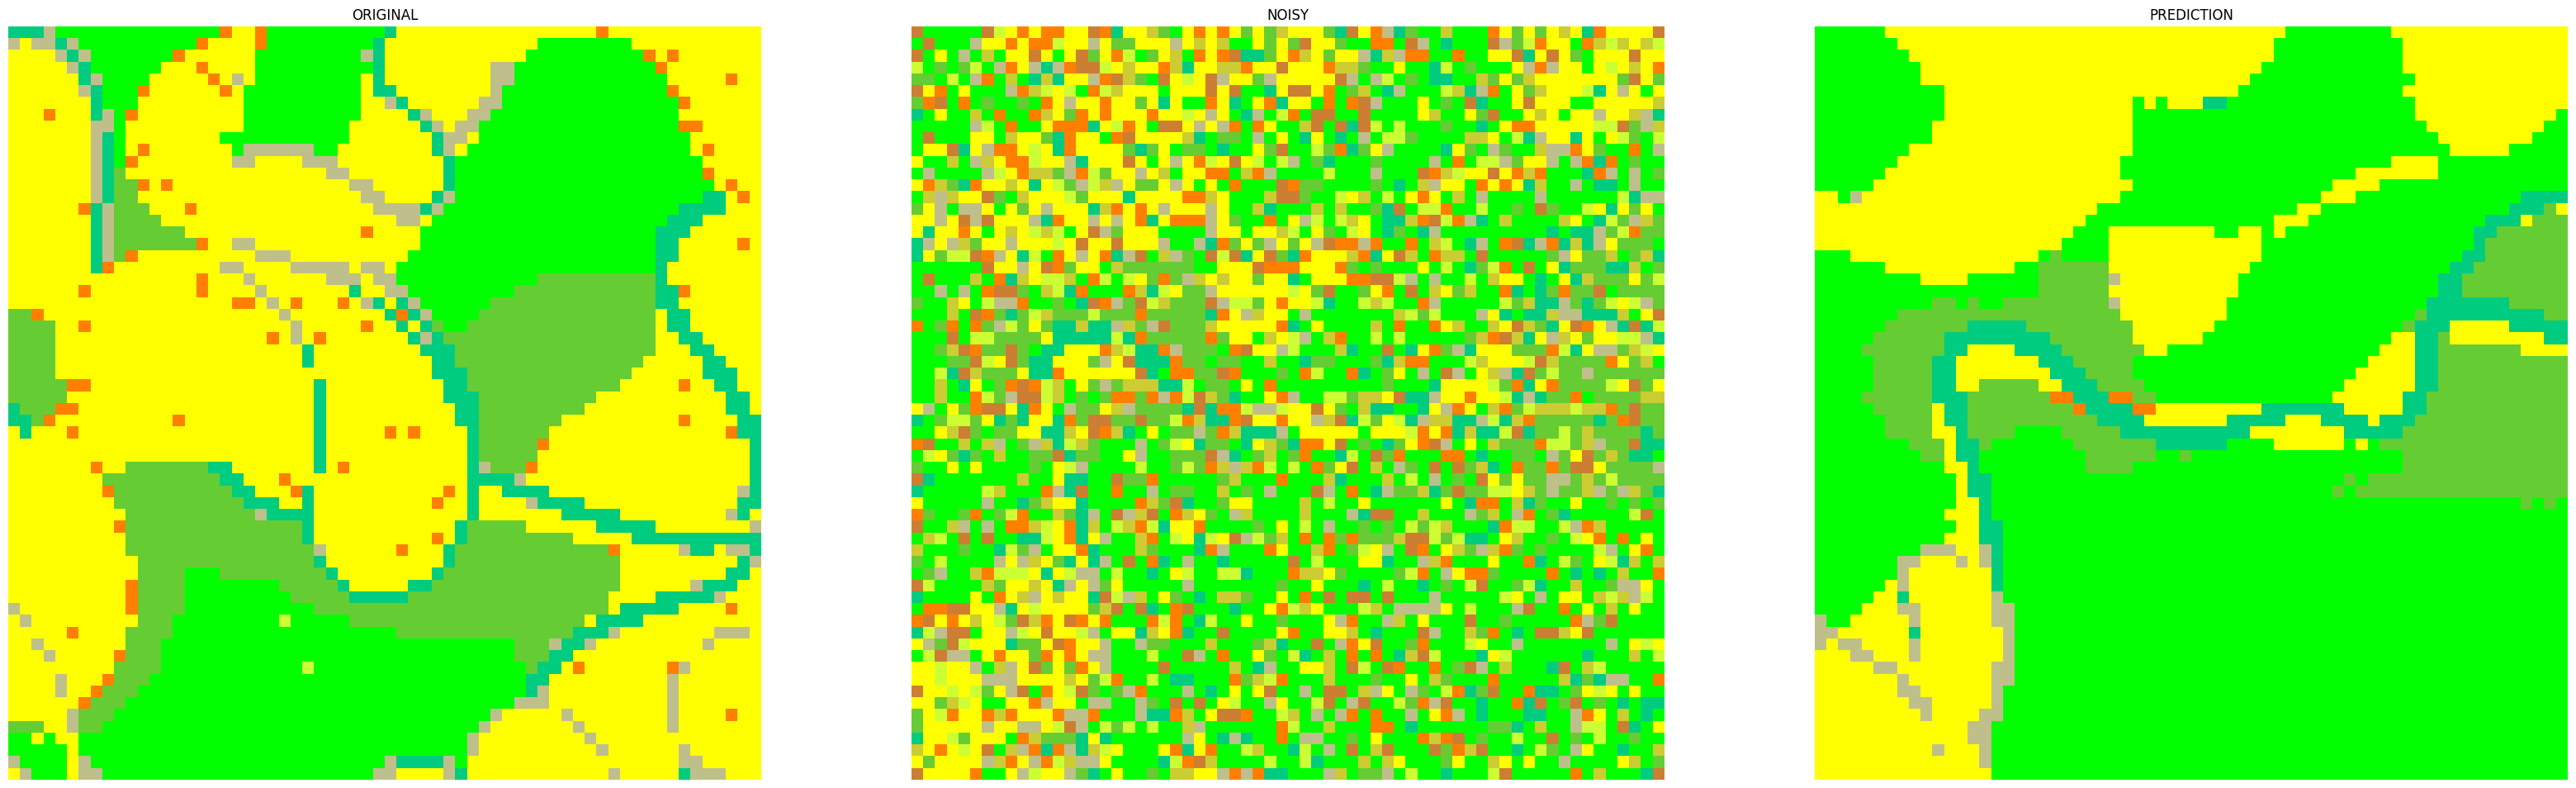

tf.Tensor([[[[0.52]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.51]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00414453 0.00443915 0.00439121 0.94077997 0.00402977 0.00394808
 0.00439948 0.02965963 0.00420818], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 47, step: 0.51


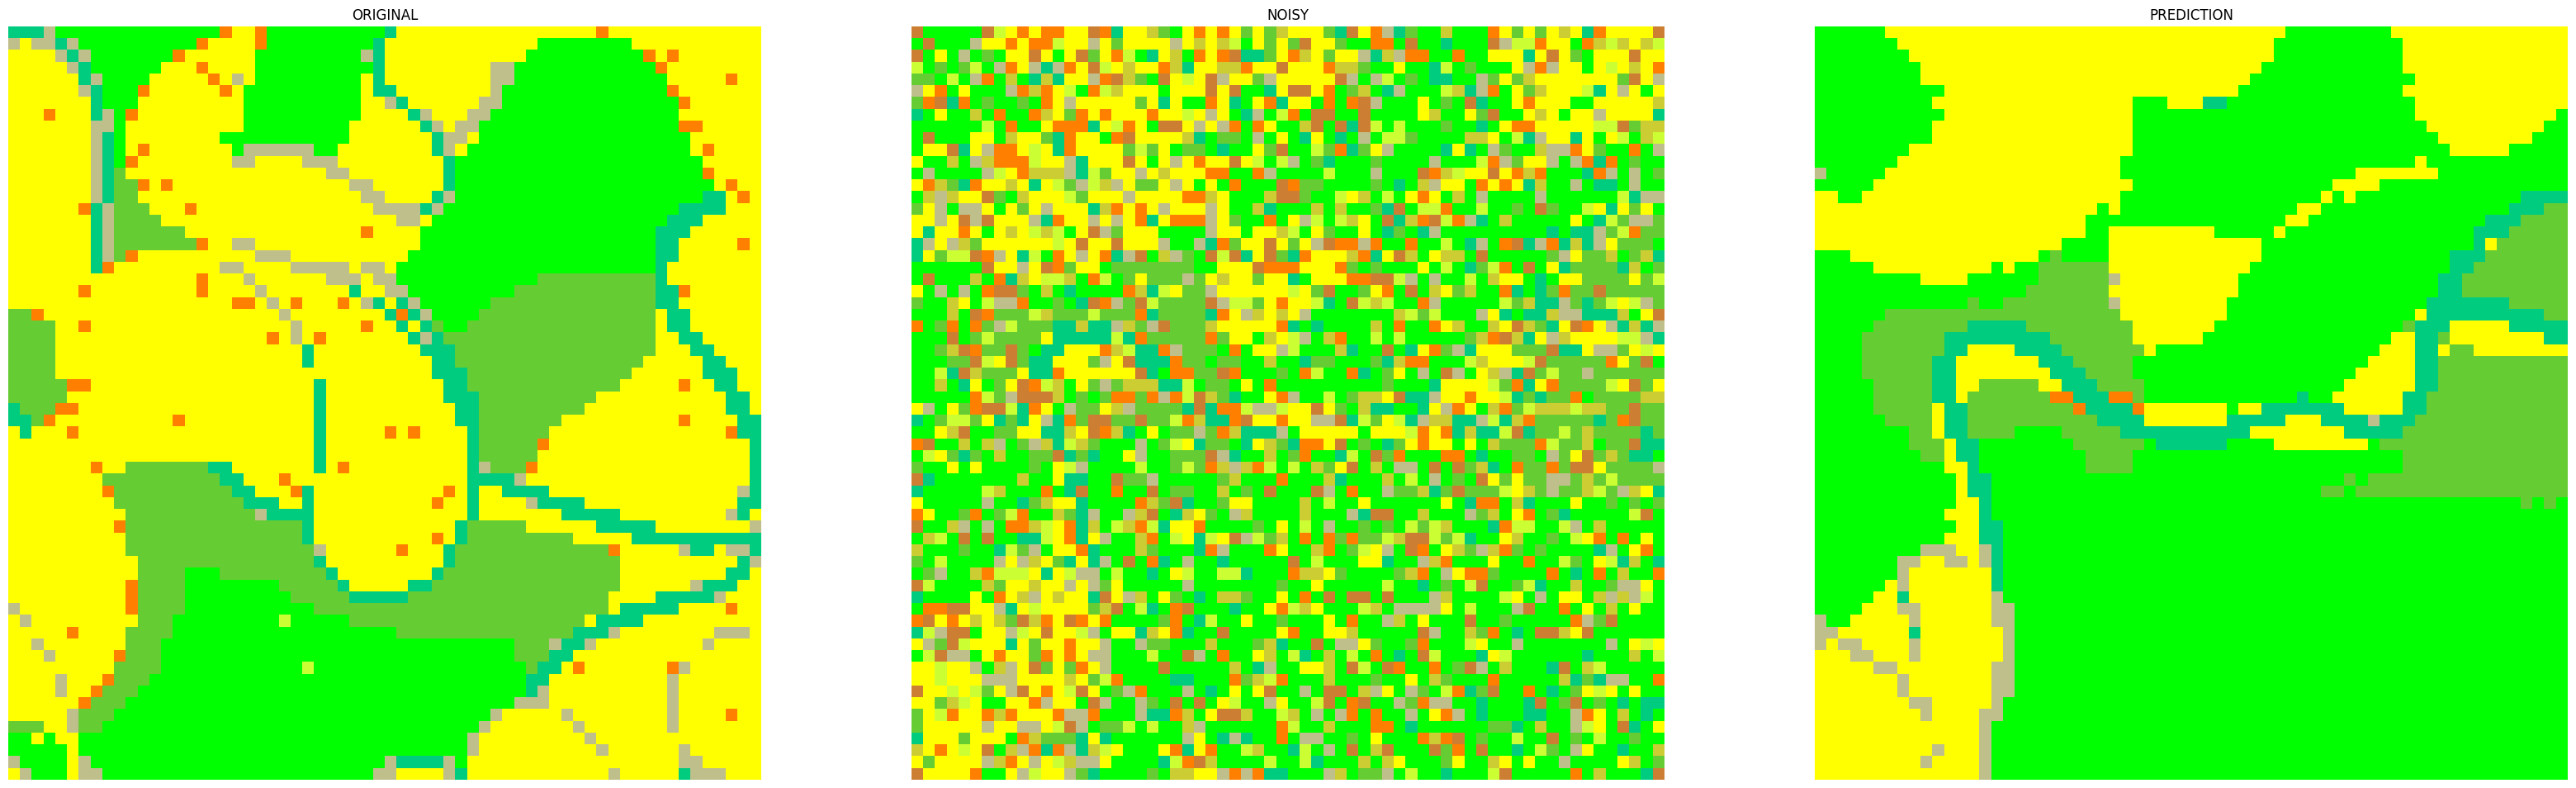

tf.Tensor([[[[0.51]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.5]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00403262 0.00434873 0.0043161  0.94080966 0.00390526 0.00382416
 0.00431204 0.0303503  0.00410112], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 48, step: 0.5


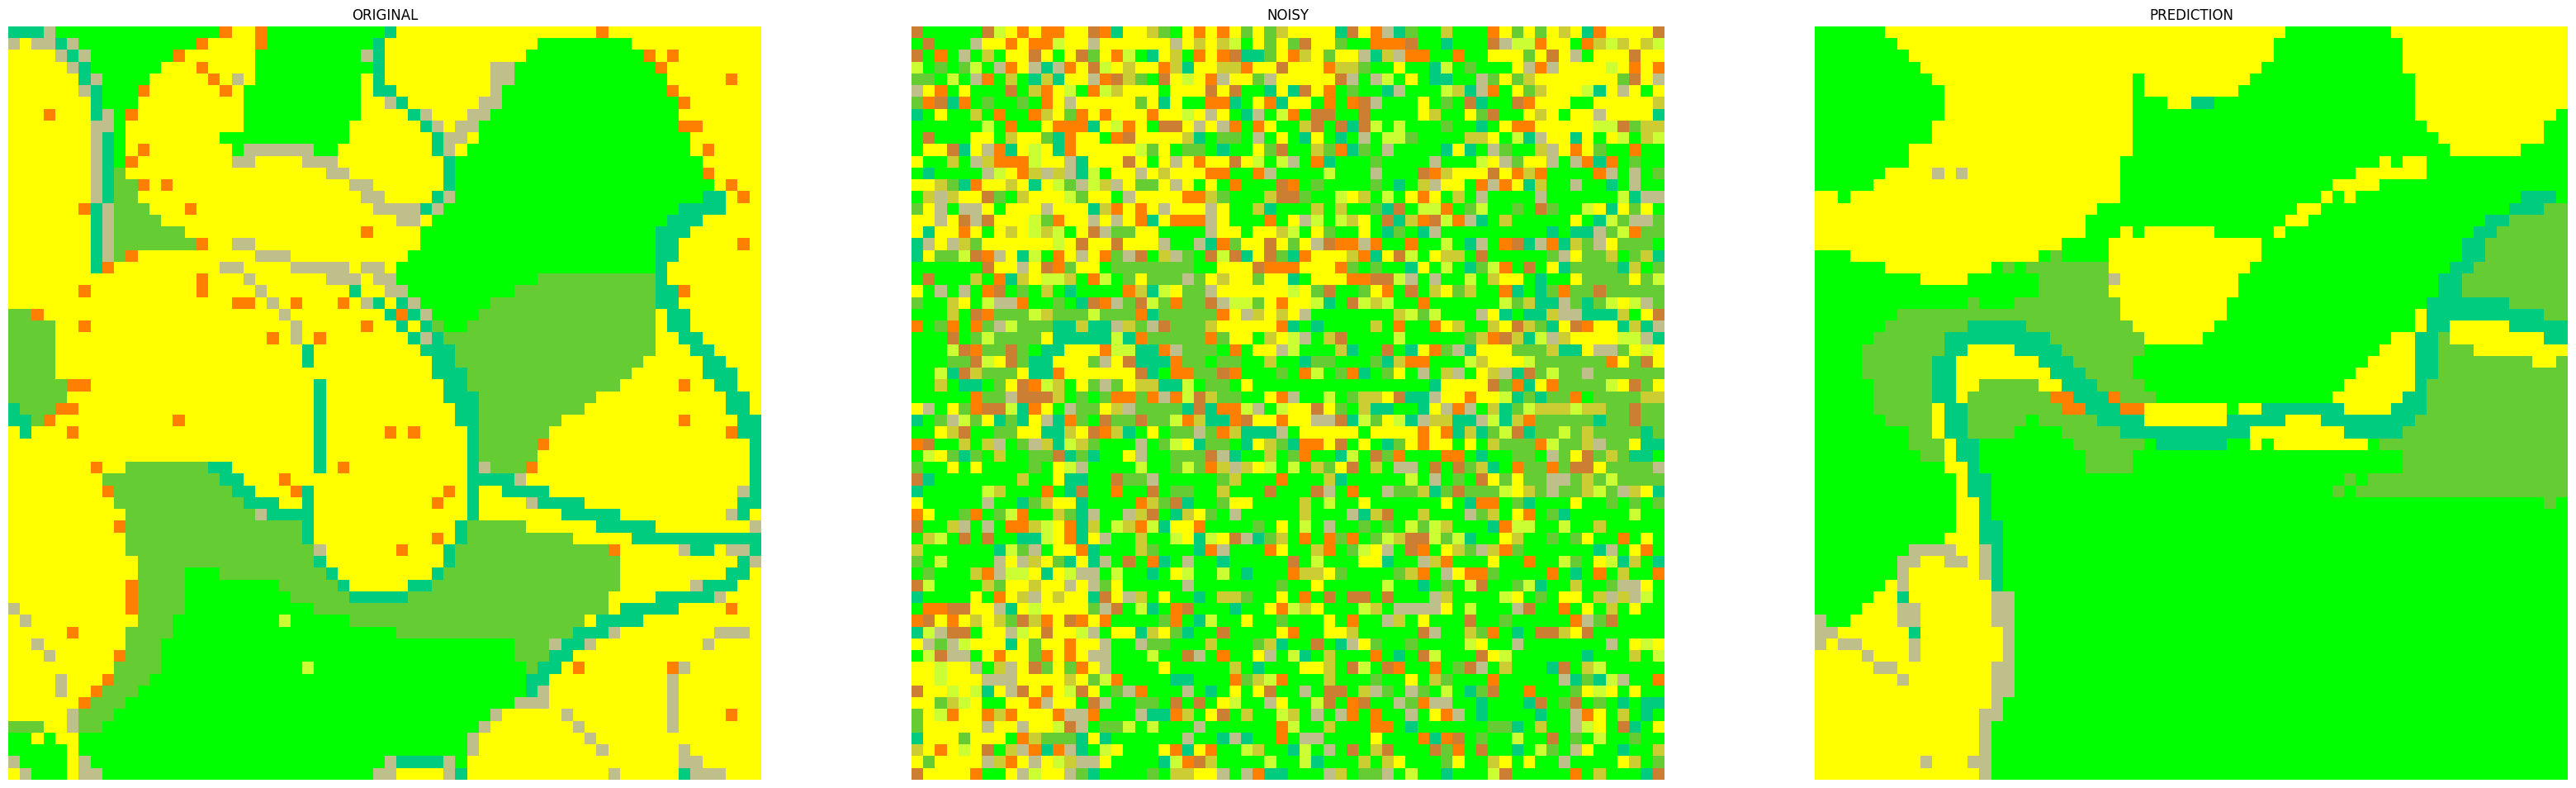

tf.Tensor([[[[0.5]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.49]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.0039419  0.00425091 0.00421263 0.94078644 0.00377713 0.00370423
 0.00425031 0.03107966 0.0039968 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 49, step: 0.49


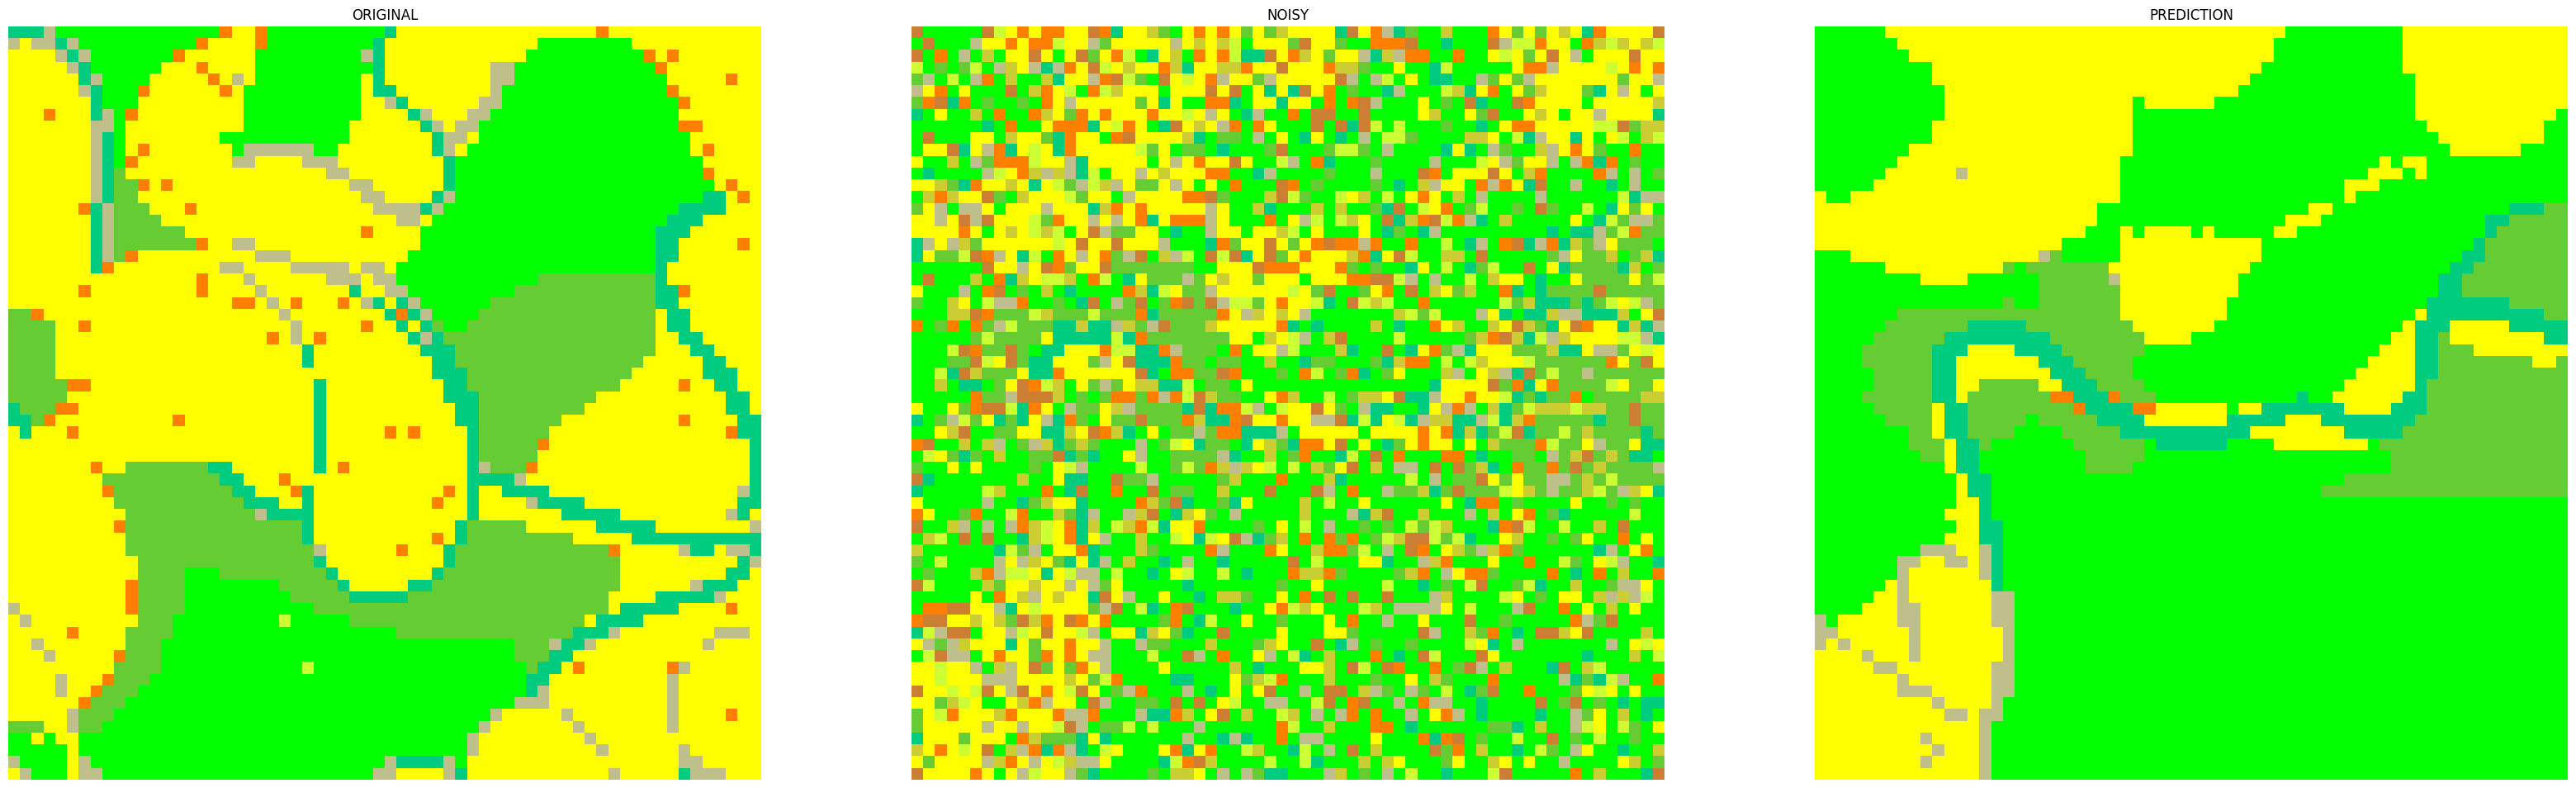

tf.Tensor([[[[0.49]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.48]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00383672 0.00419079 0.0040948  0.94068337 0.00366235 0.00358787
 0.00409509 0.0320211  0.0038279 ], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 50, step: 0.48


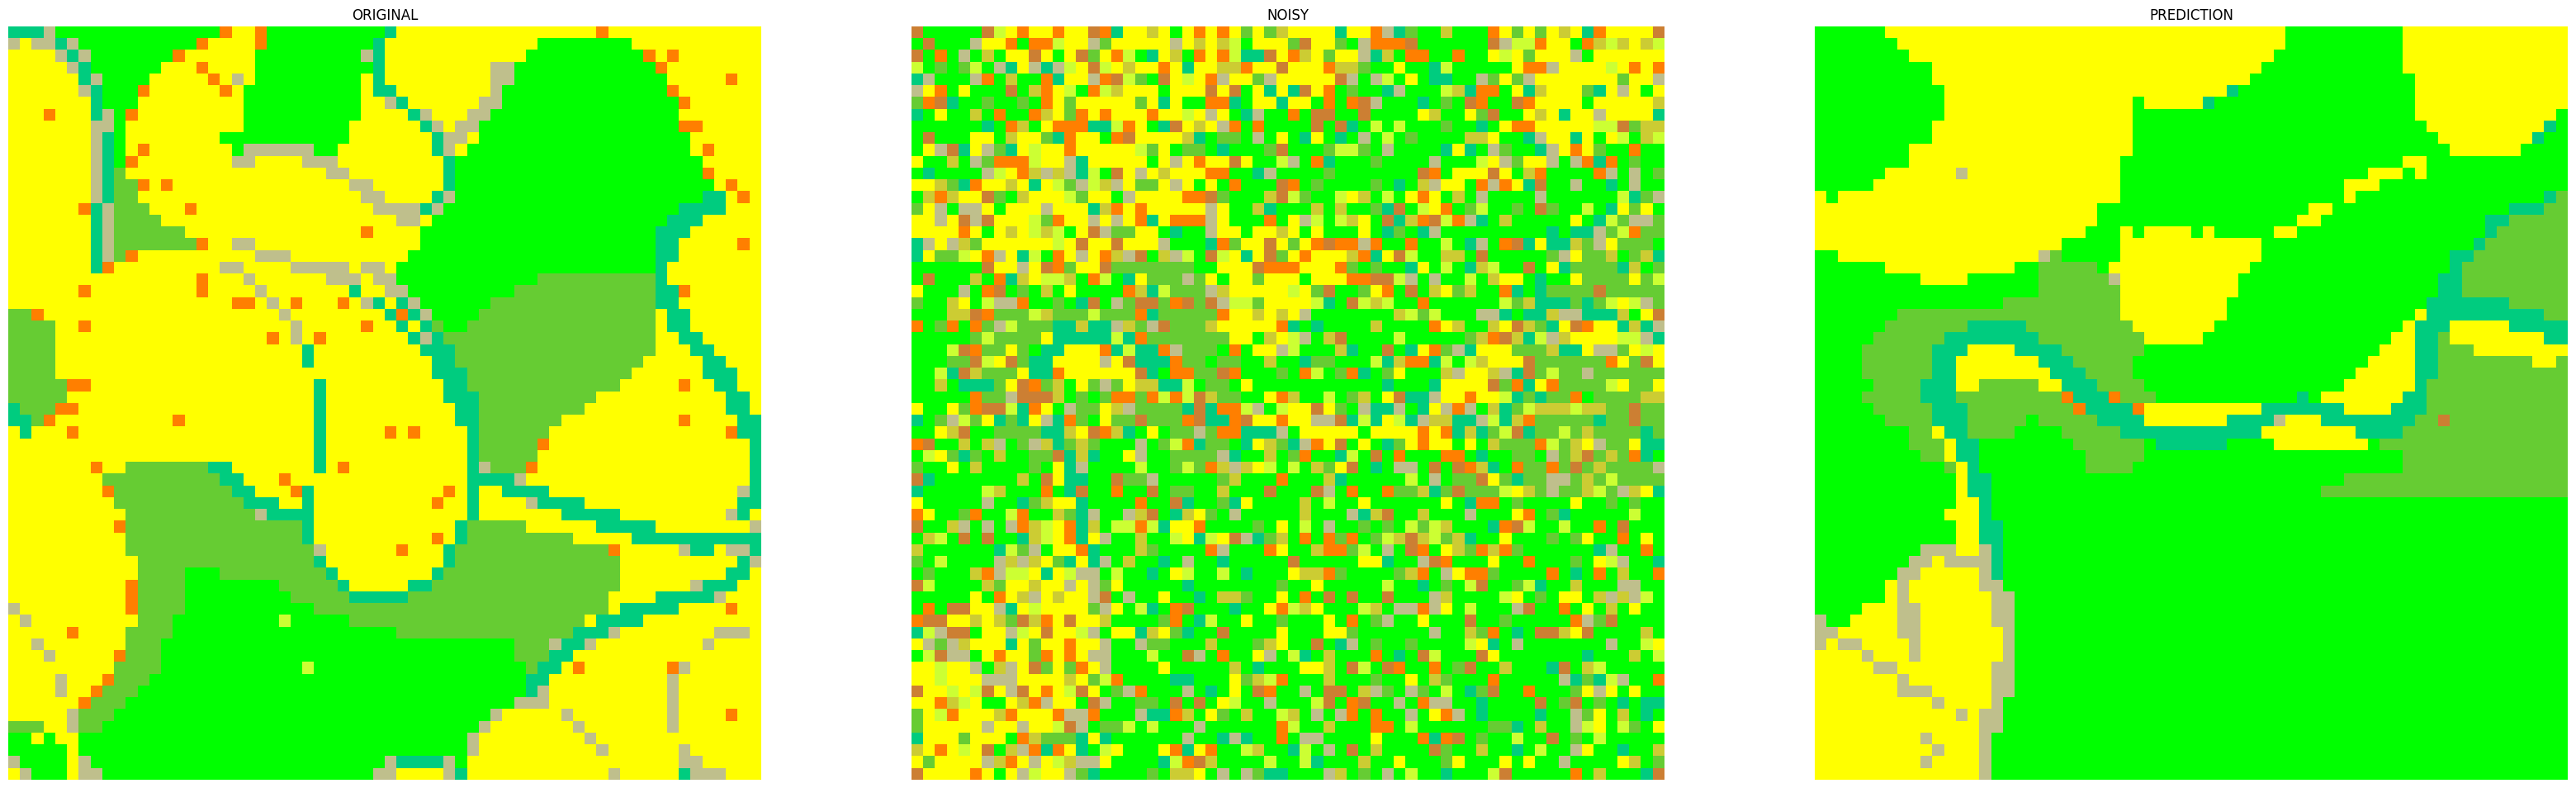

tf.Tensor([[[[0.48]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.47]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.003747   0.00412374 0.00404662 0.94055464 0.00355823 0.00347636
 0.00391589 0.03277457 0.00380296], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 51, step: 0.47000000000000003


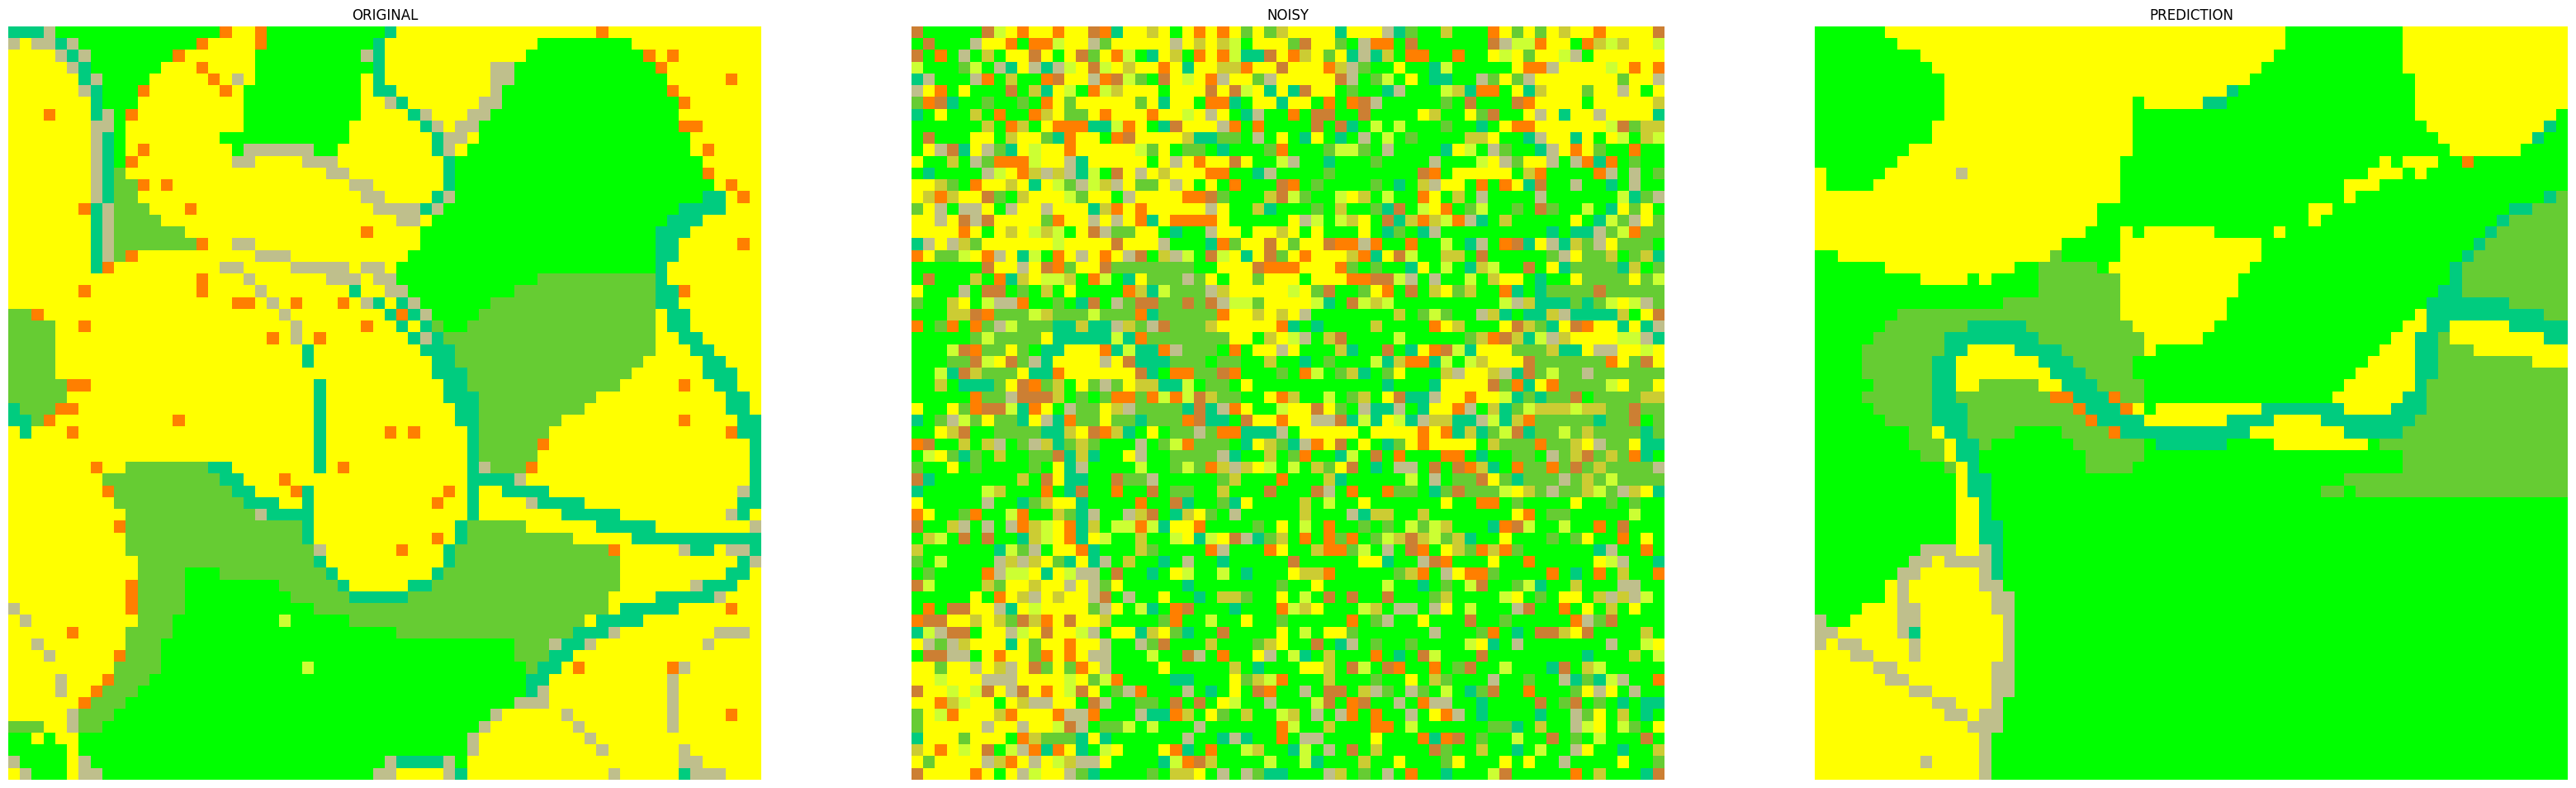

tf.Tensor([[[[0.47]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.46]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00365141 0.00405107 0.0039573  0.94036407 0.0034559  0.00336756
 0.00376123 0.03368111 0.00371034], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 52, step: 0.46


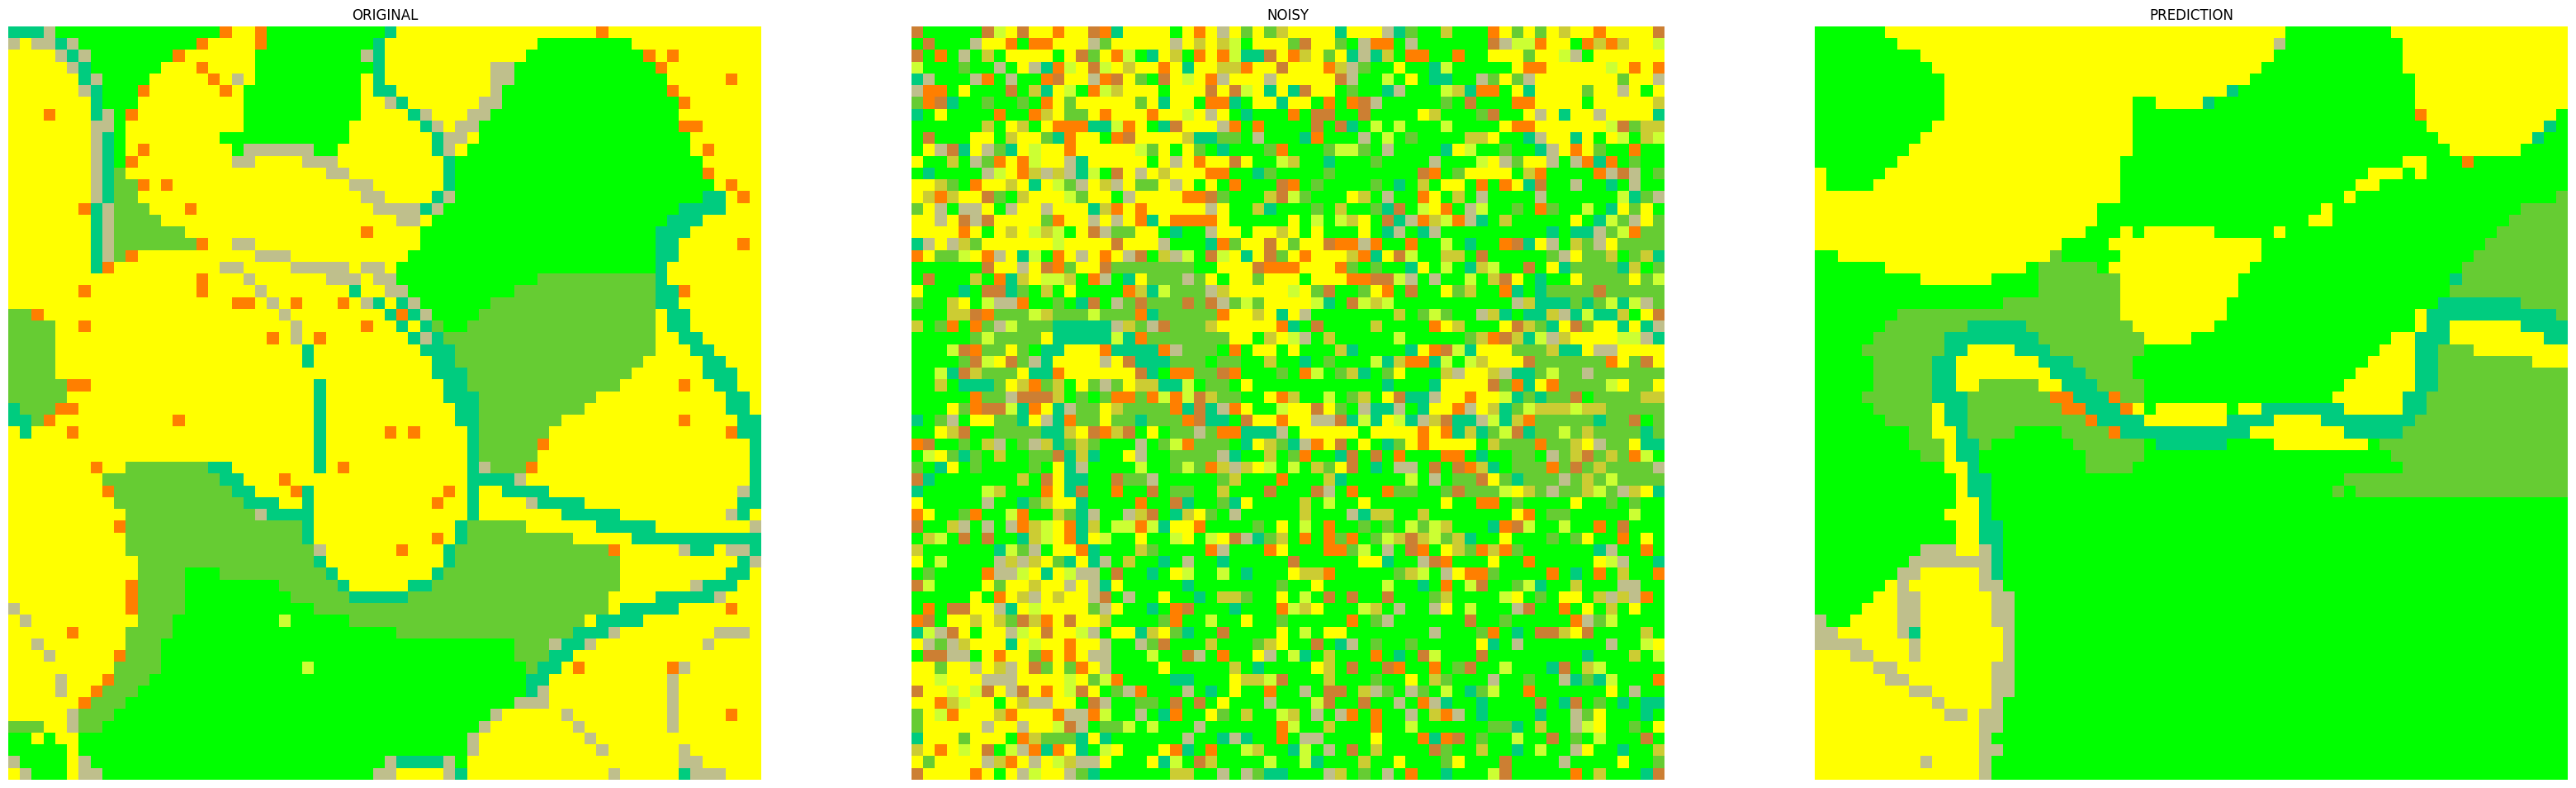

tf.Tensor([[[[0.46]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.45]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00357062 0.00401264 0.00392408 0.94012222 0.00335258 0.0032617
 0.00371239 0.0343885  0.00365528], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 53, step: 0.45


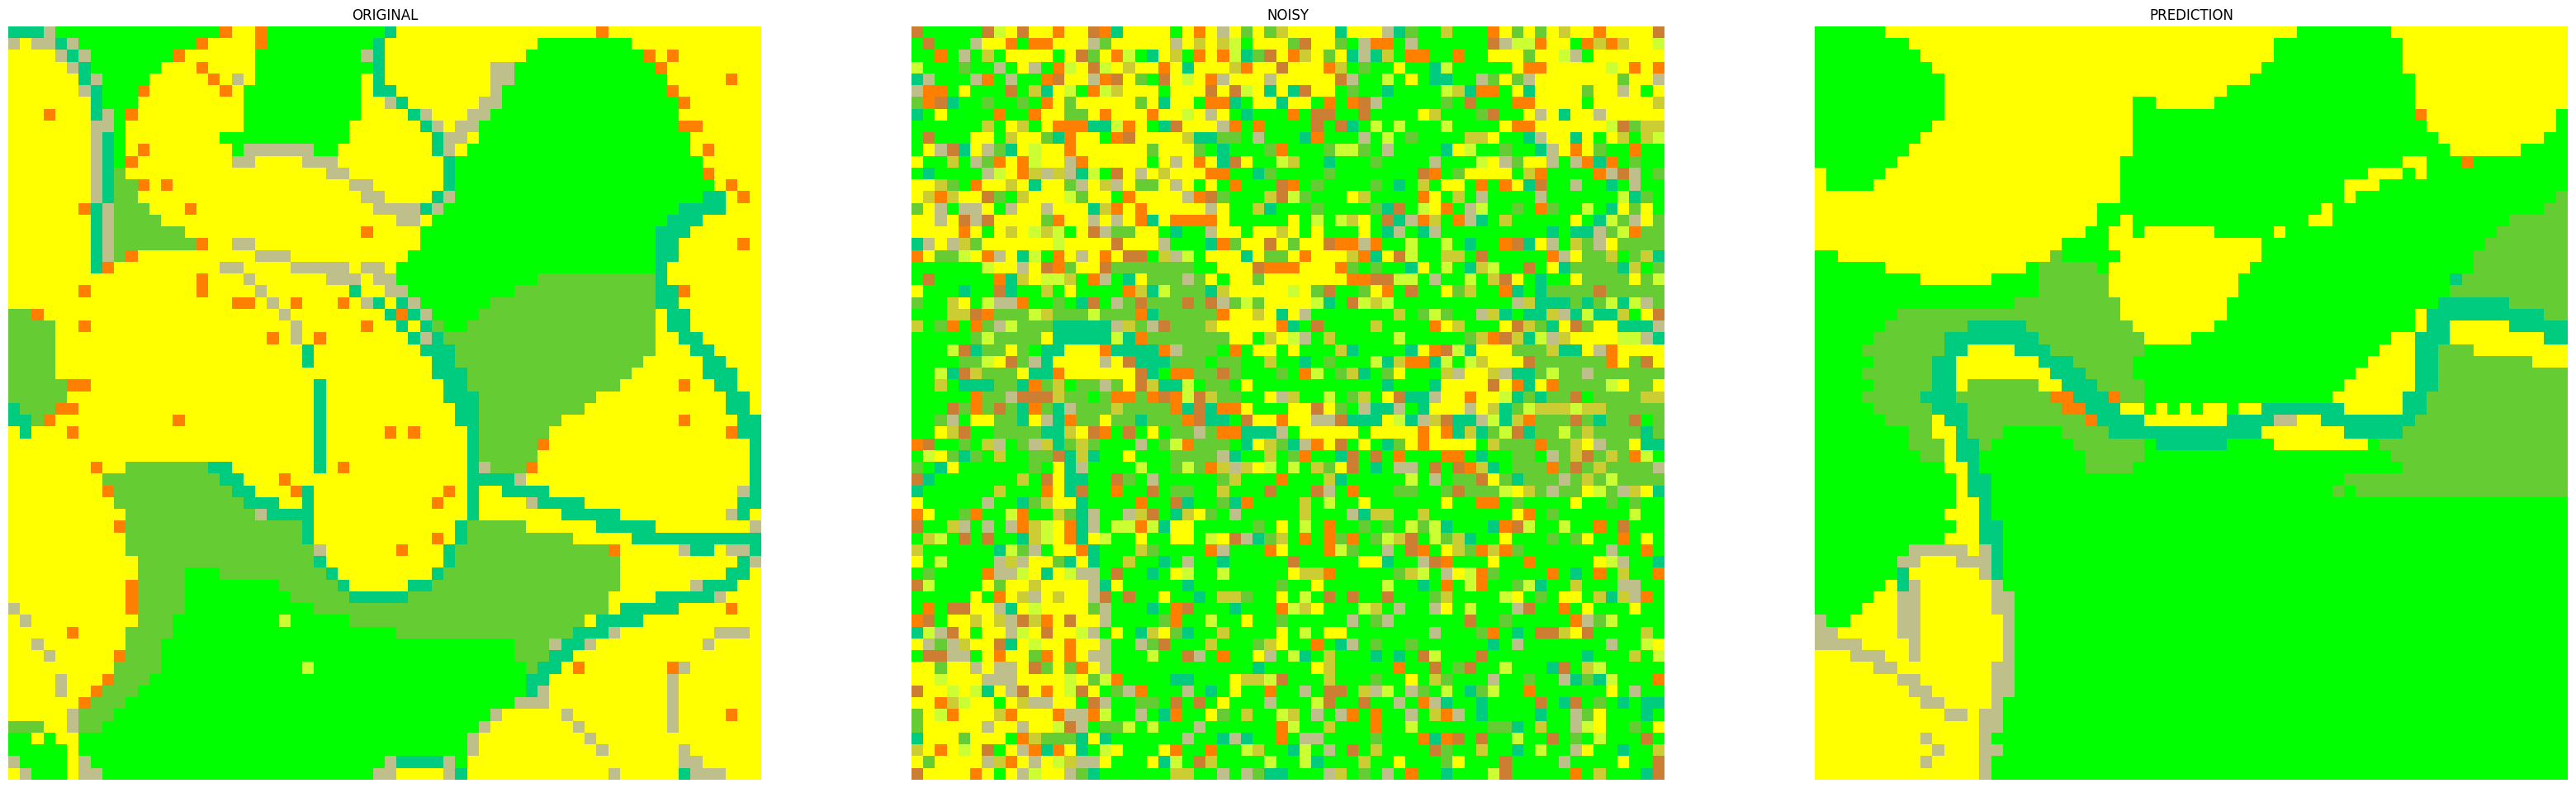

tf.Tensor([[[[0.45]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.44]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00339907 0.00369404 0.00355028 0.93977858 0.00324521 0.00315676
 0.00352984 0.03628923 0.00335699], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 54, step: 0.44


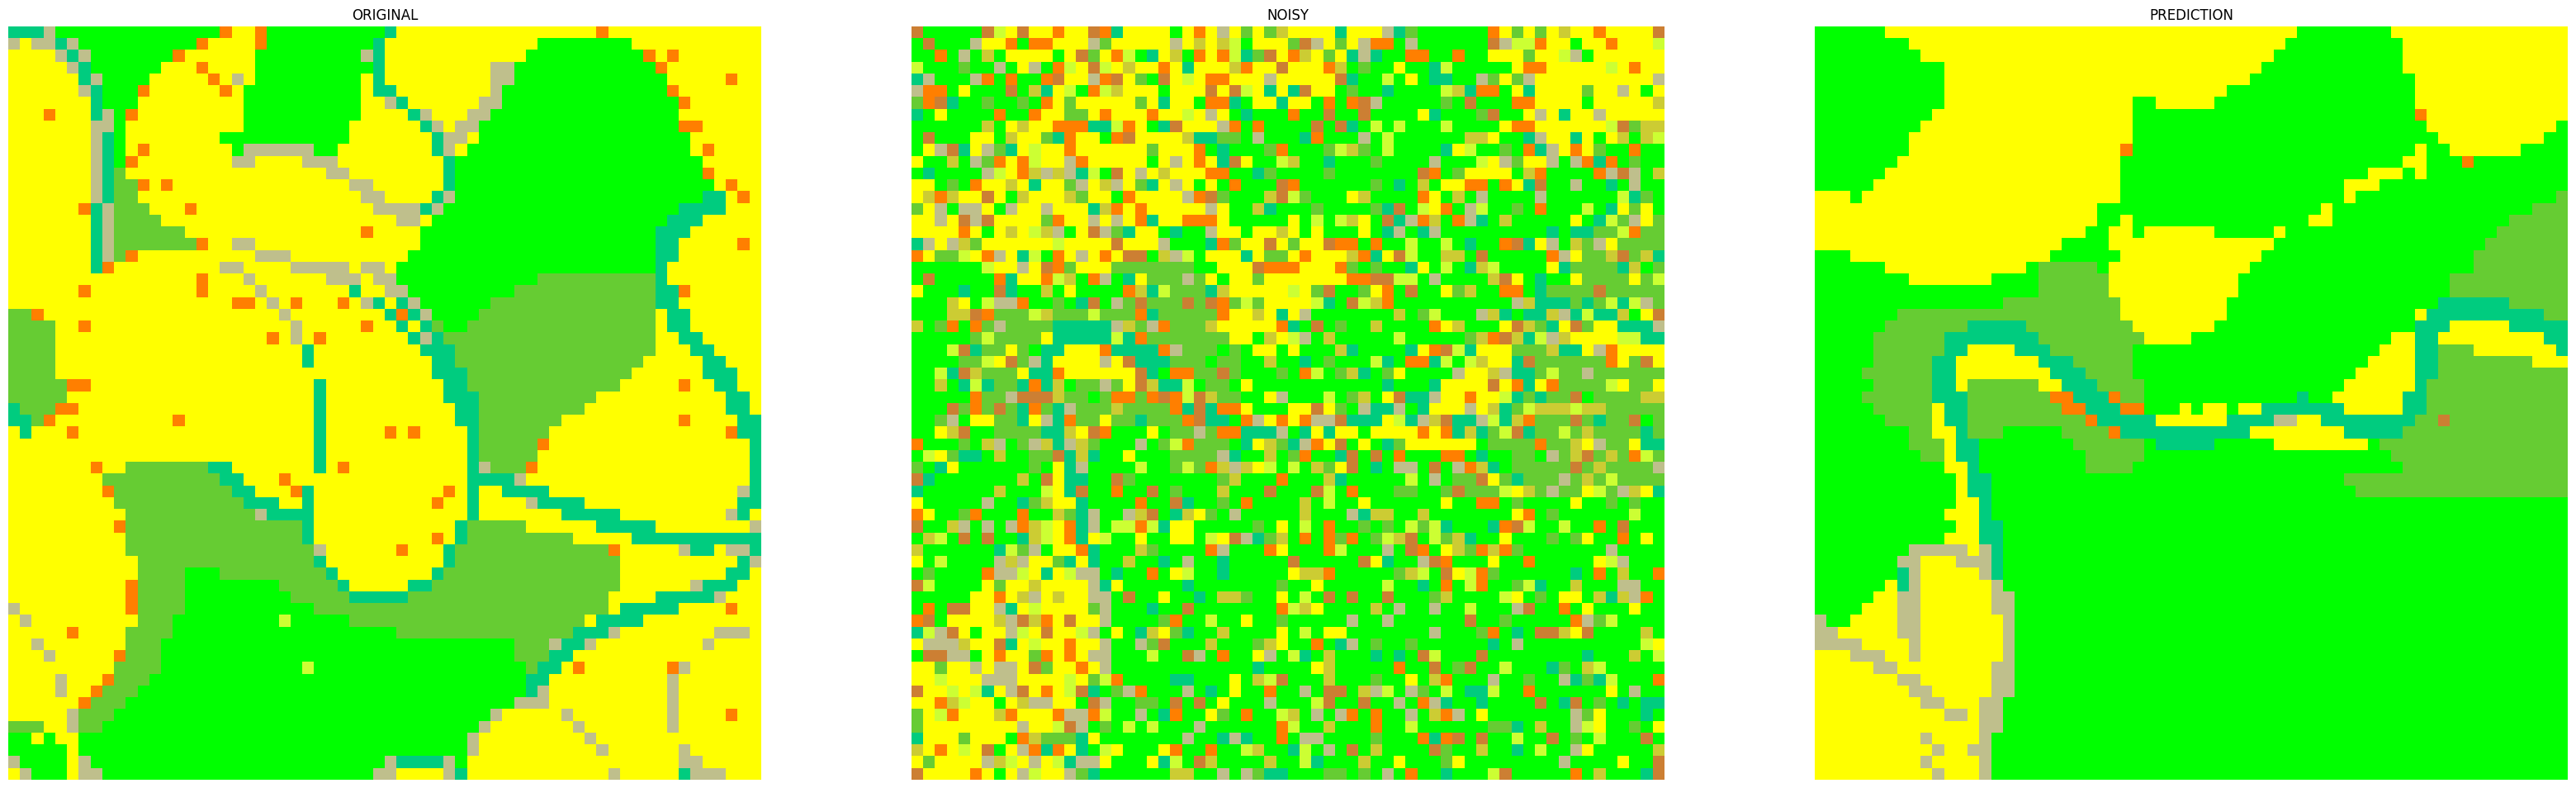

tf.Tensor([[[[0.44]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.43]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00331242 0.0036058  0.00344984 0.93940901 0.00314343 0.00305601
 0.00344014 0.0373229  0.00326045], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 55, step: 0.43


tf.Tensor([[[[0.43]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.42]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00324031 0.00354704 0.00334357 0.93898406 0.00304741 0.00295813
 0.00333923 0.03838122 0.00315901], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 56, step: 0.42


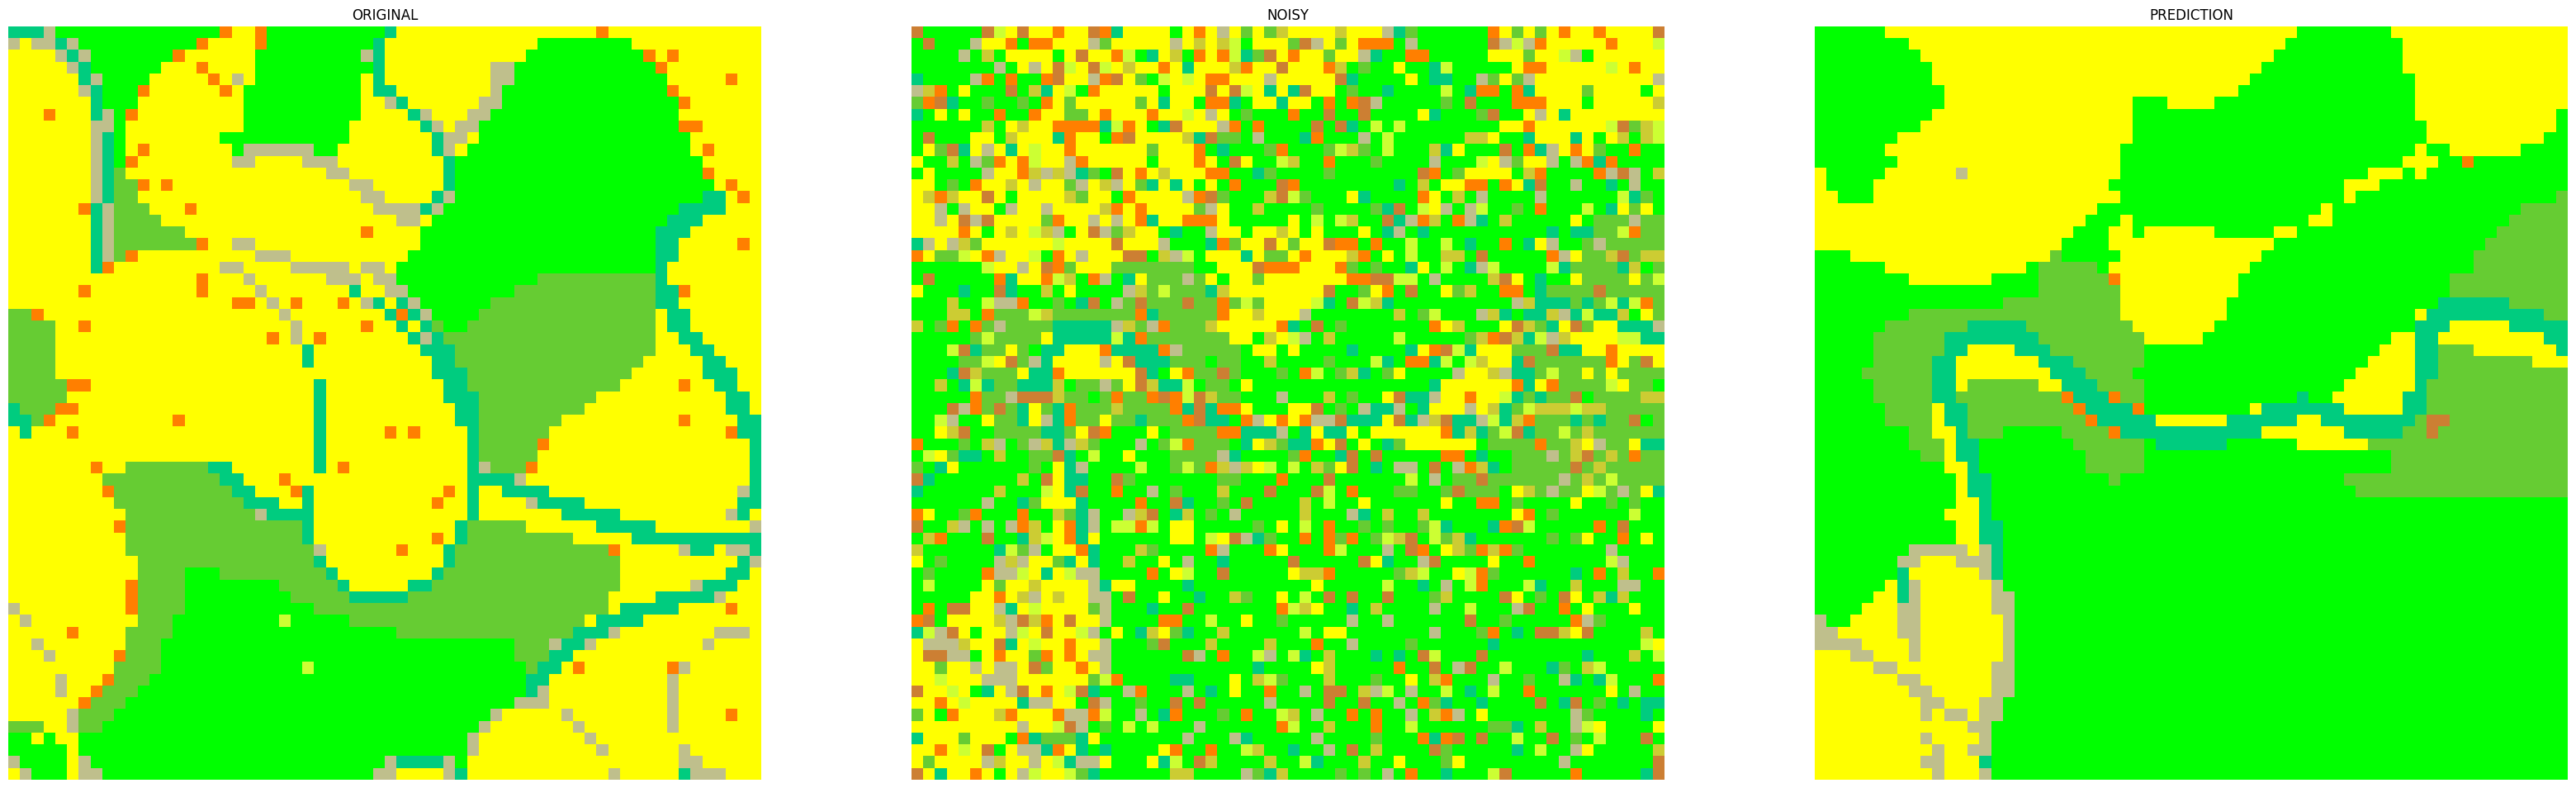

tf.Tensor([[[[0.42]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.41]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00310262 0.00342677 0.00318044 0.93842371 0.00292563 0.00285745
 0.00315001 0.03991132 0.00302204], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 57, step: 0.41000000000000003


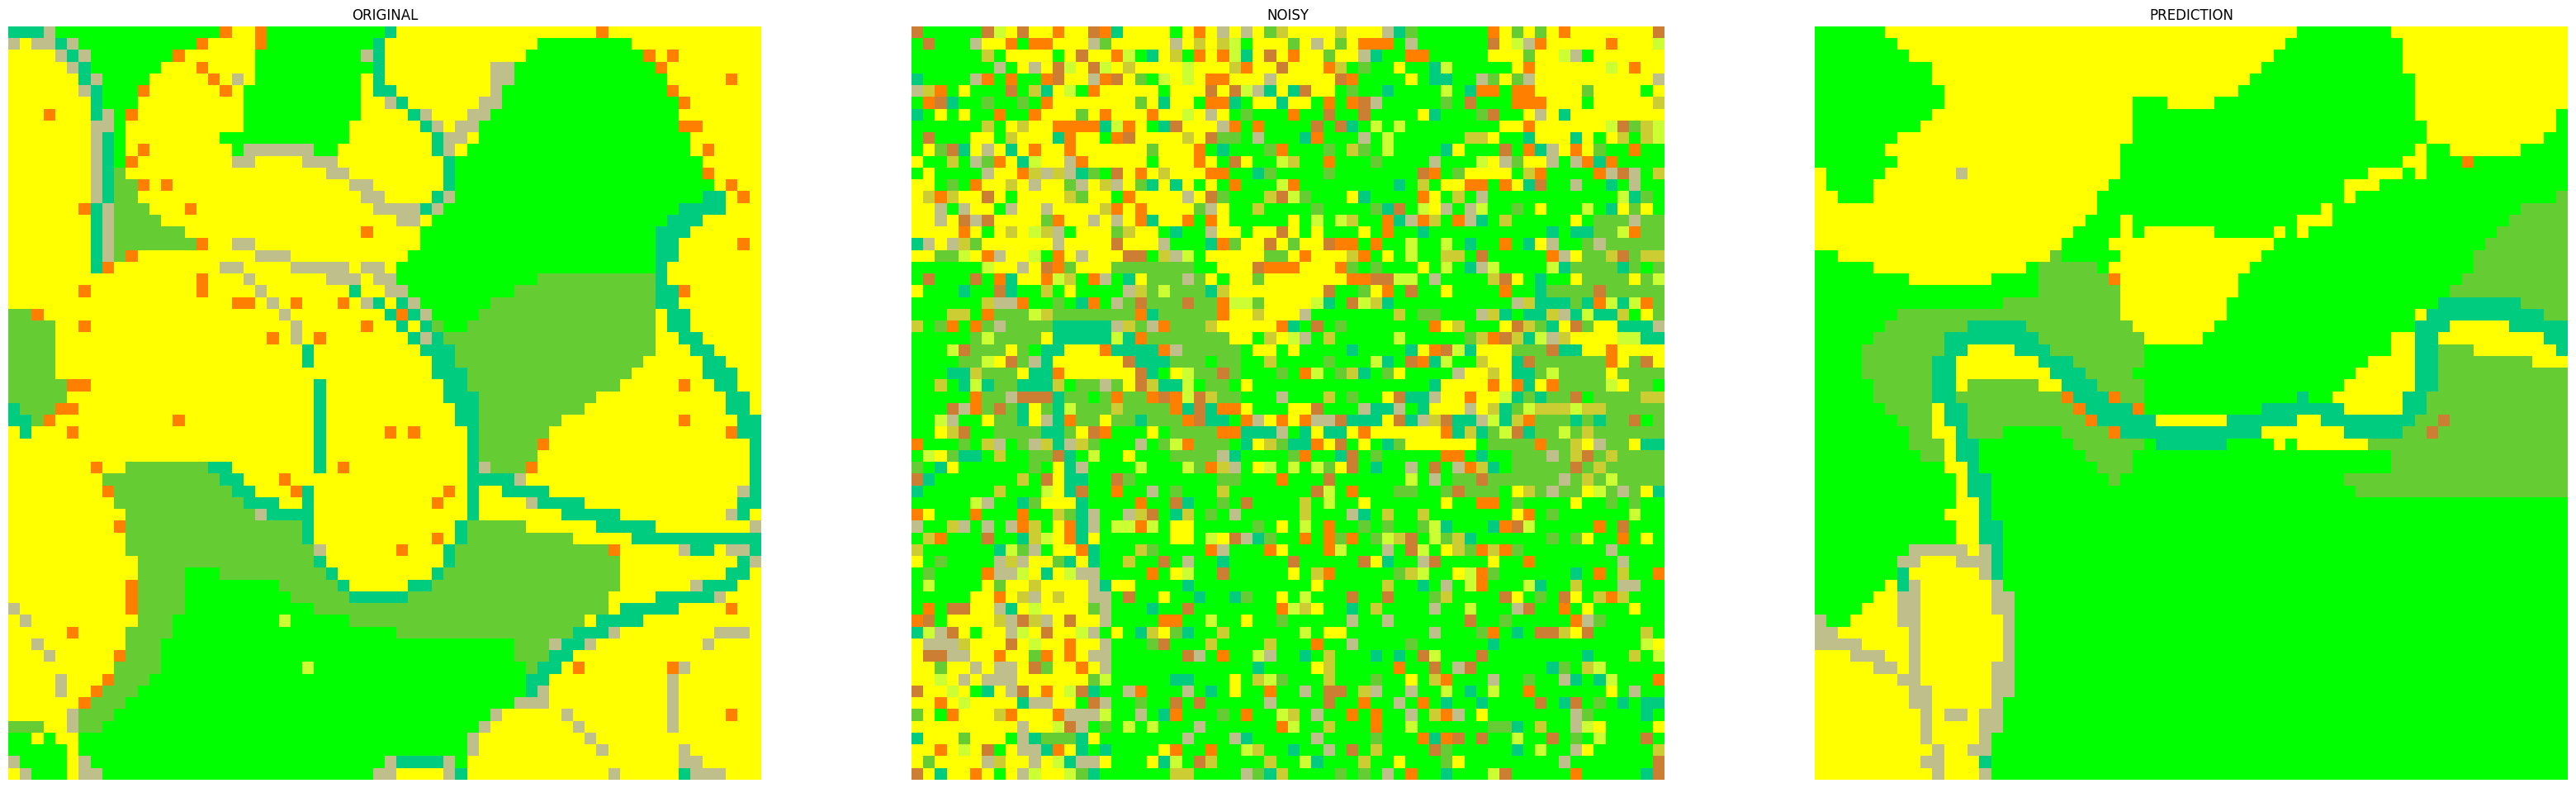

tf.Tensor([[[[0.41]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.4]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00301351 0.00333681 0.0030842  0.93783592 0.00283045 0.00276252
 0.00304791 0.04116601 0.00292267], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 58, step: 0.4


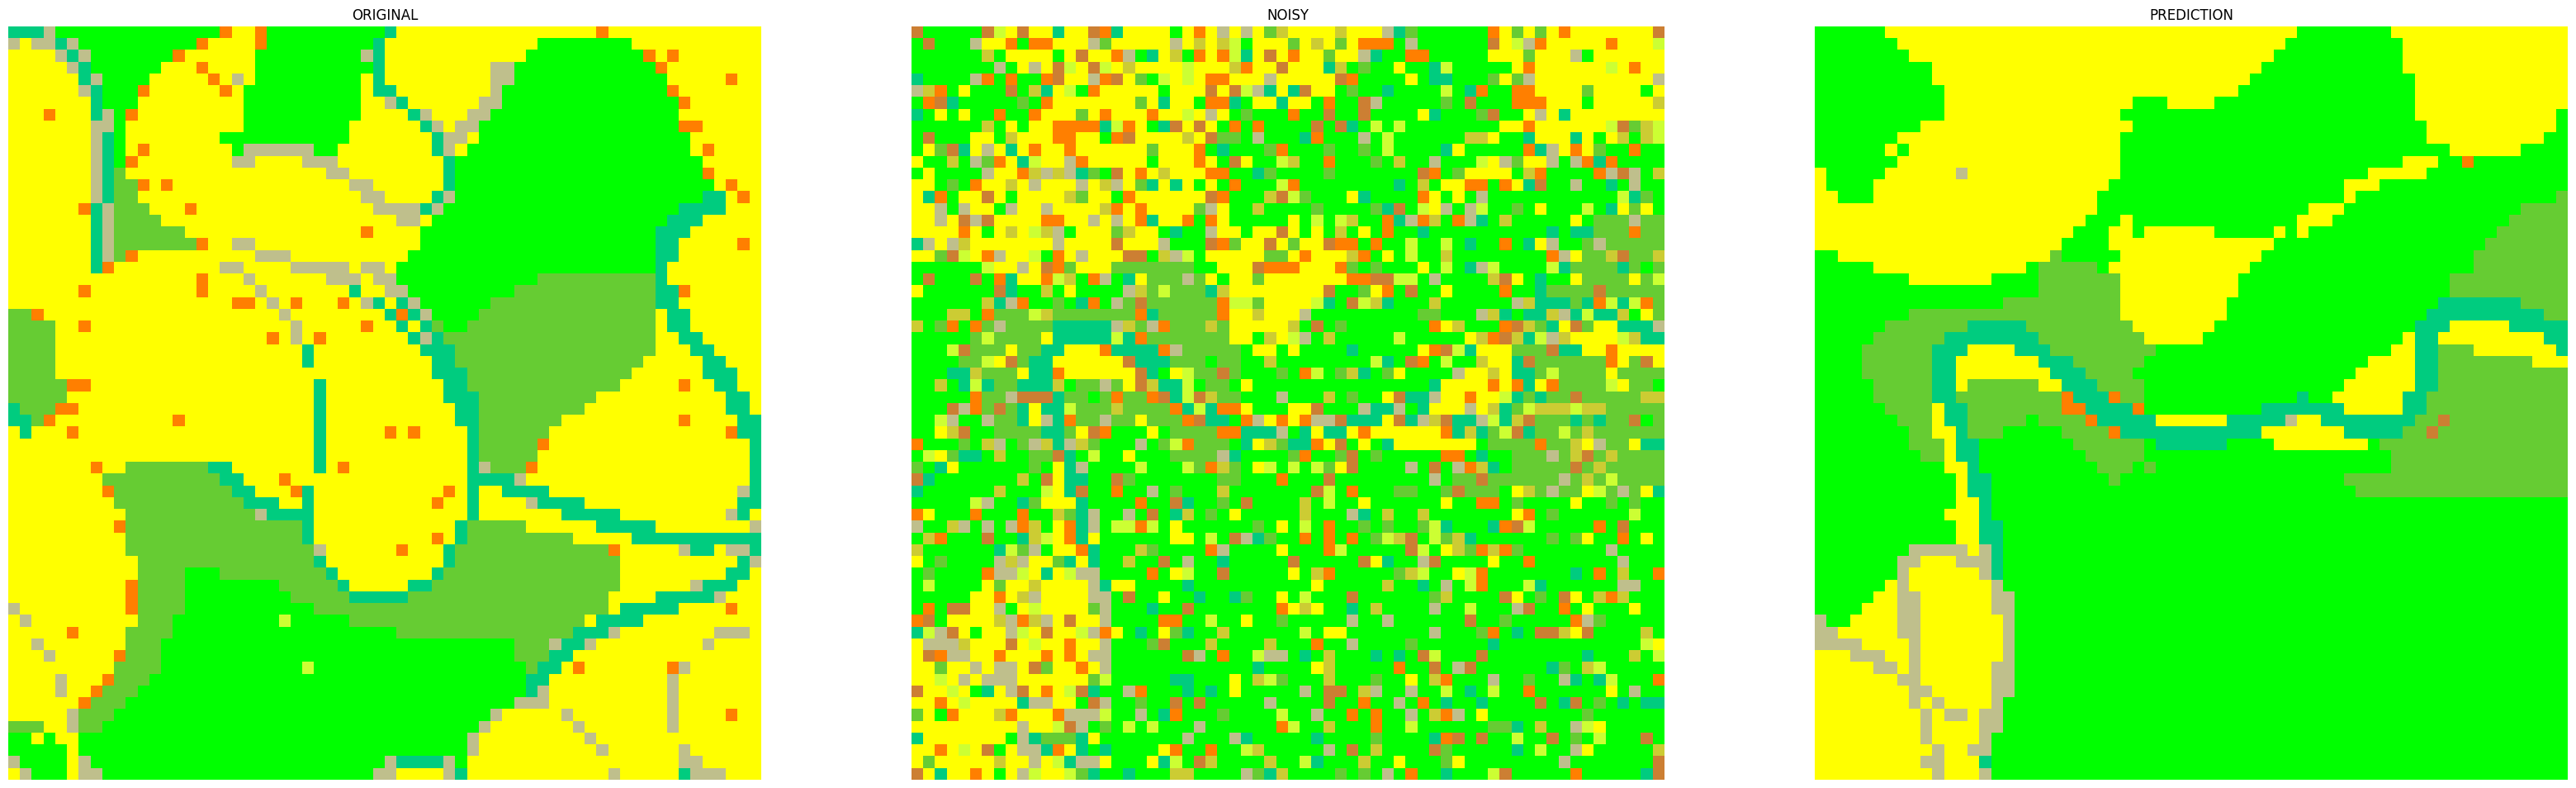

tf.Tensor([[[[0.4]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.39]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00292305 0.00324919 0.00299156 0.93718187 0.00273676 0.00267022
 0.00295736 0.04246148 0.00282851], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 59, step: 0.39


tf.Tensor([[[[0.39]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.38]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.002891   0.00322267 0.00298446 0.93644579 0.00266313 0.00258284
 0.00294655 0.04346491 0.00279865], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 60, step: 0.38


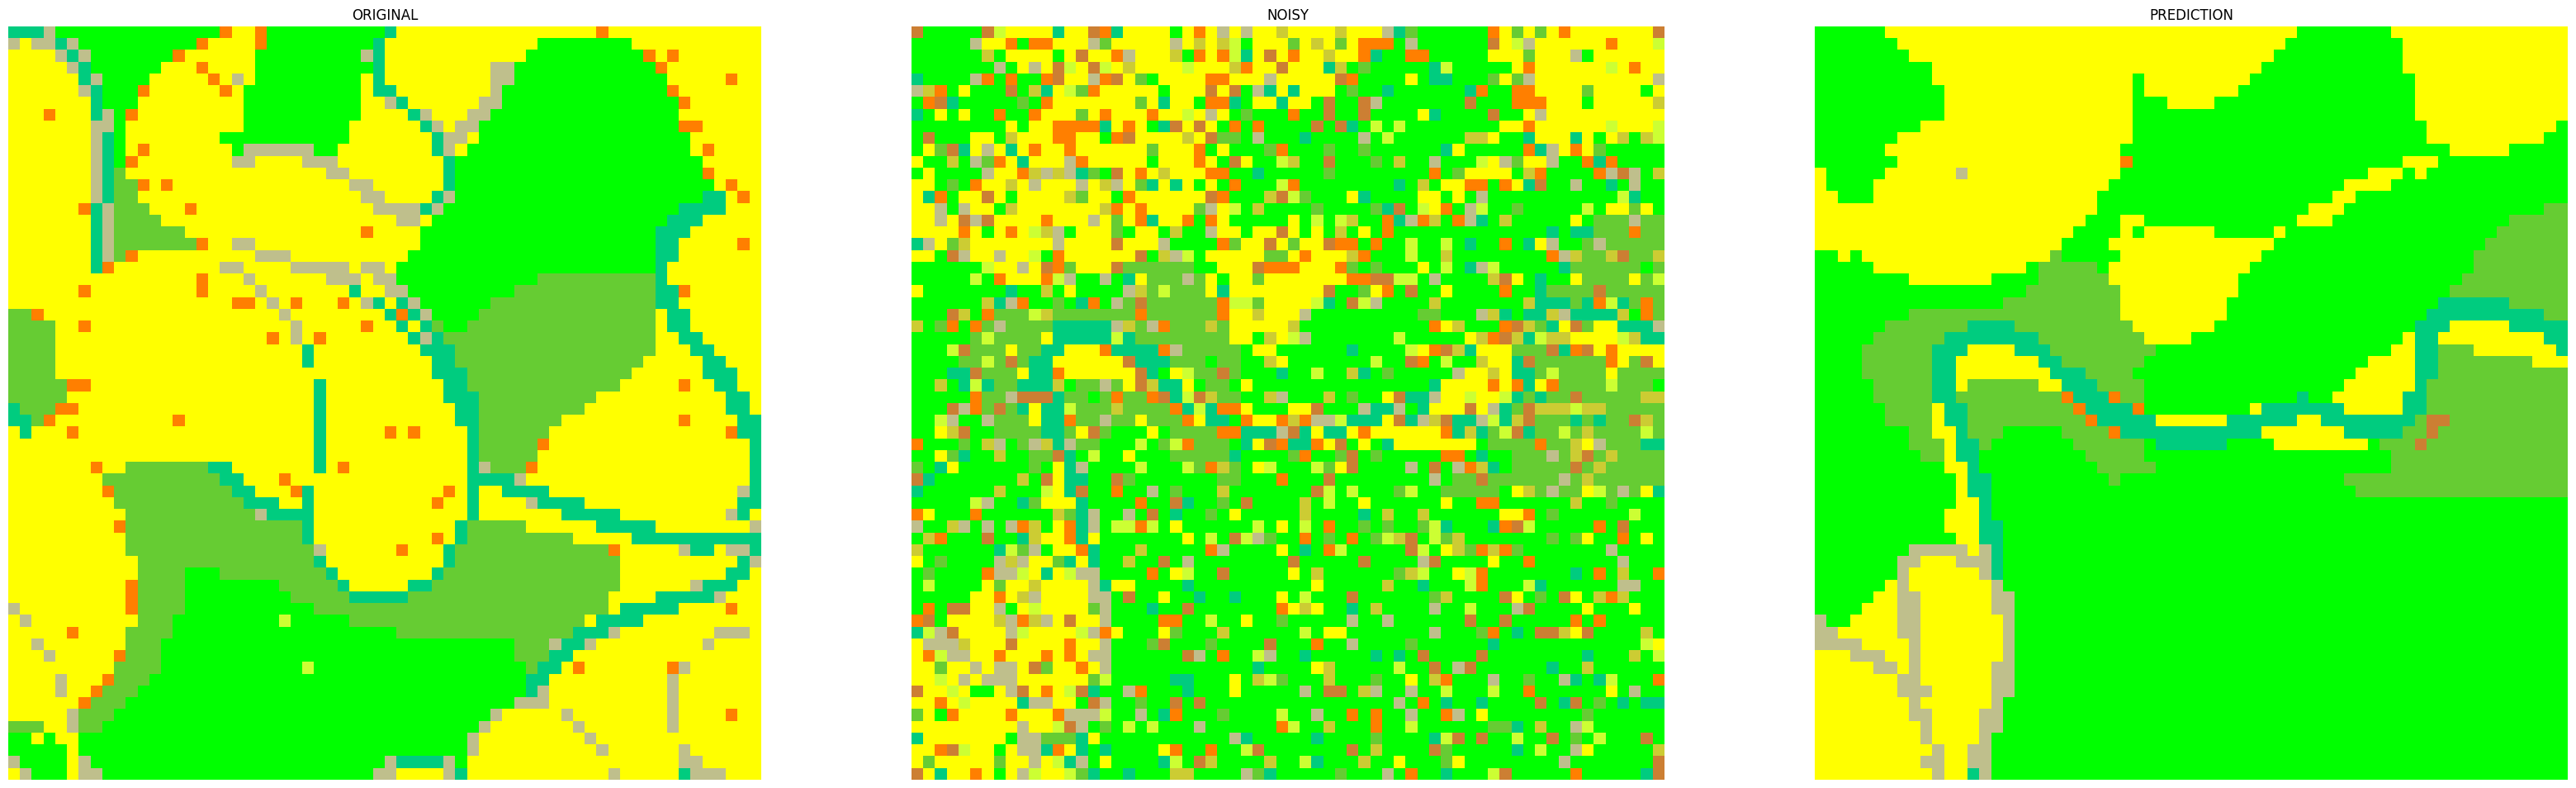

tf.Tensor([[[[0.38]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.37]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00280633 0.00314015 0.00290031 0.93564225 0.00257252 0.00249443
 0.0028832  0.04485049 0.00271032], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 61, step: 0.37


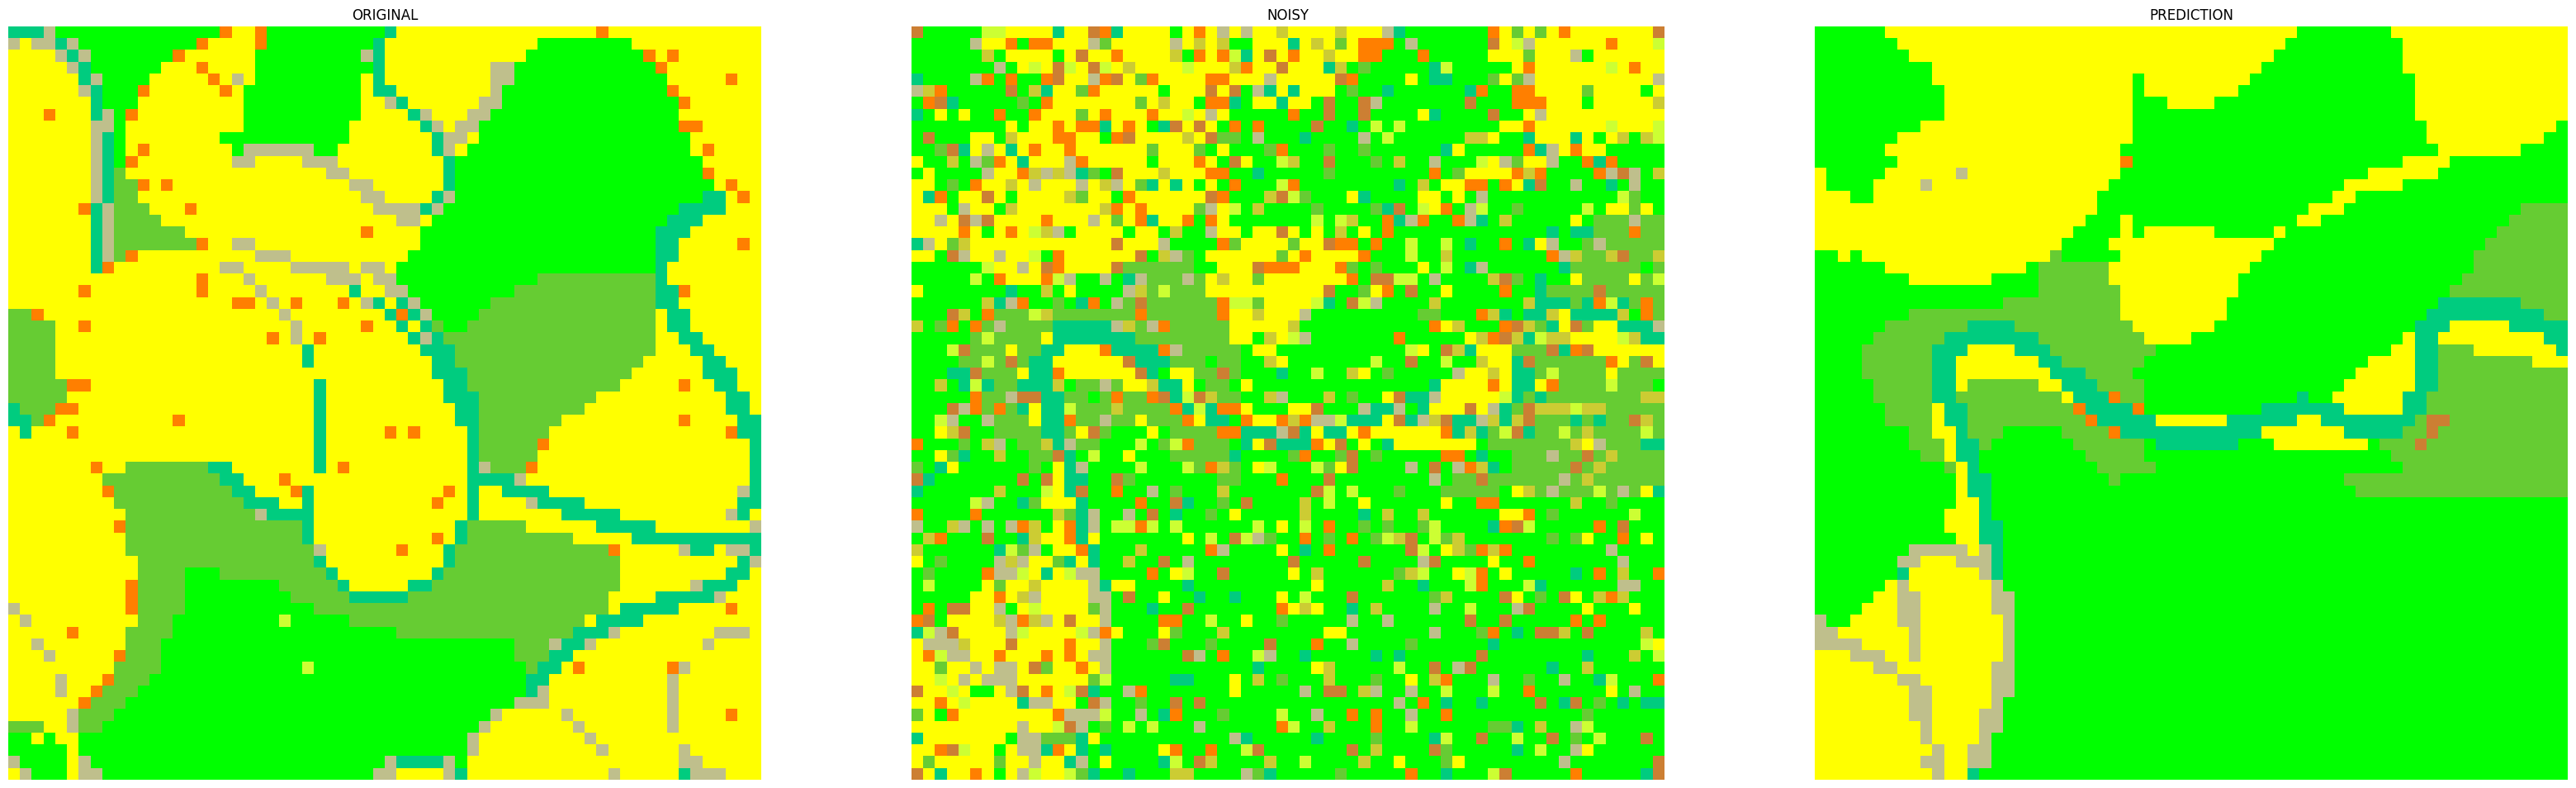

tf.Tensor([[[[0.37]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.36]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[0.00272401 0.00304737 0.00281238 0.93476485 0.00248722 0.00240817
 0.00277027 0.04636001 0.00262571], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 62, step: 0.36


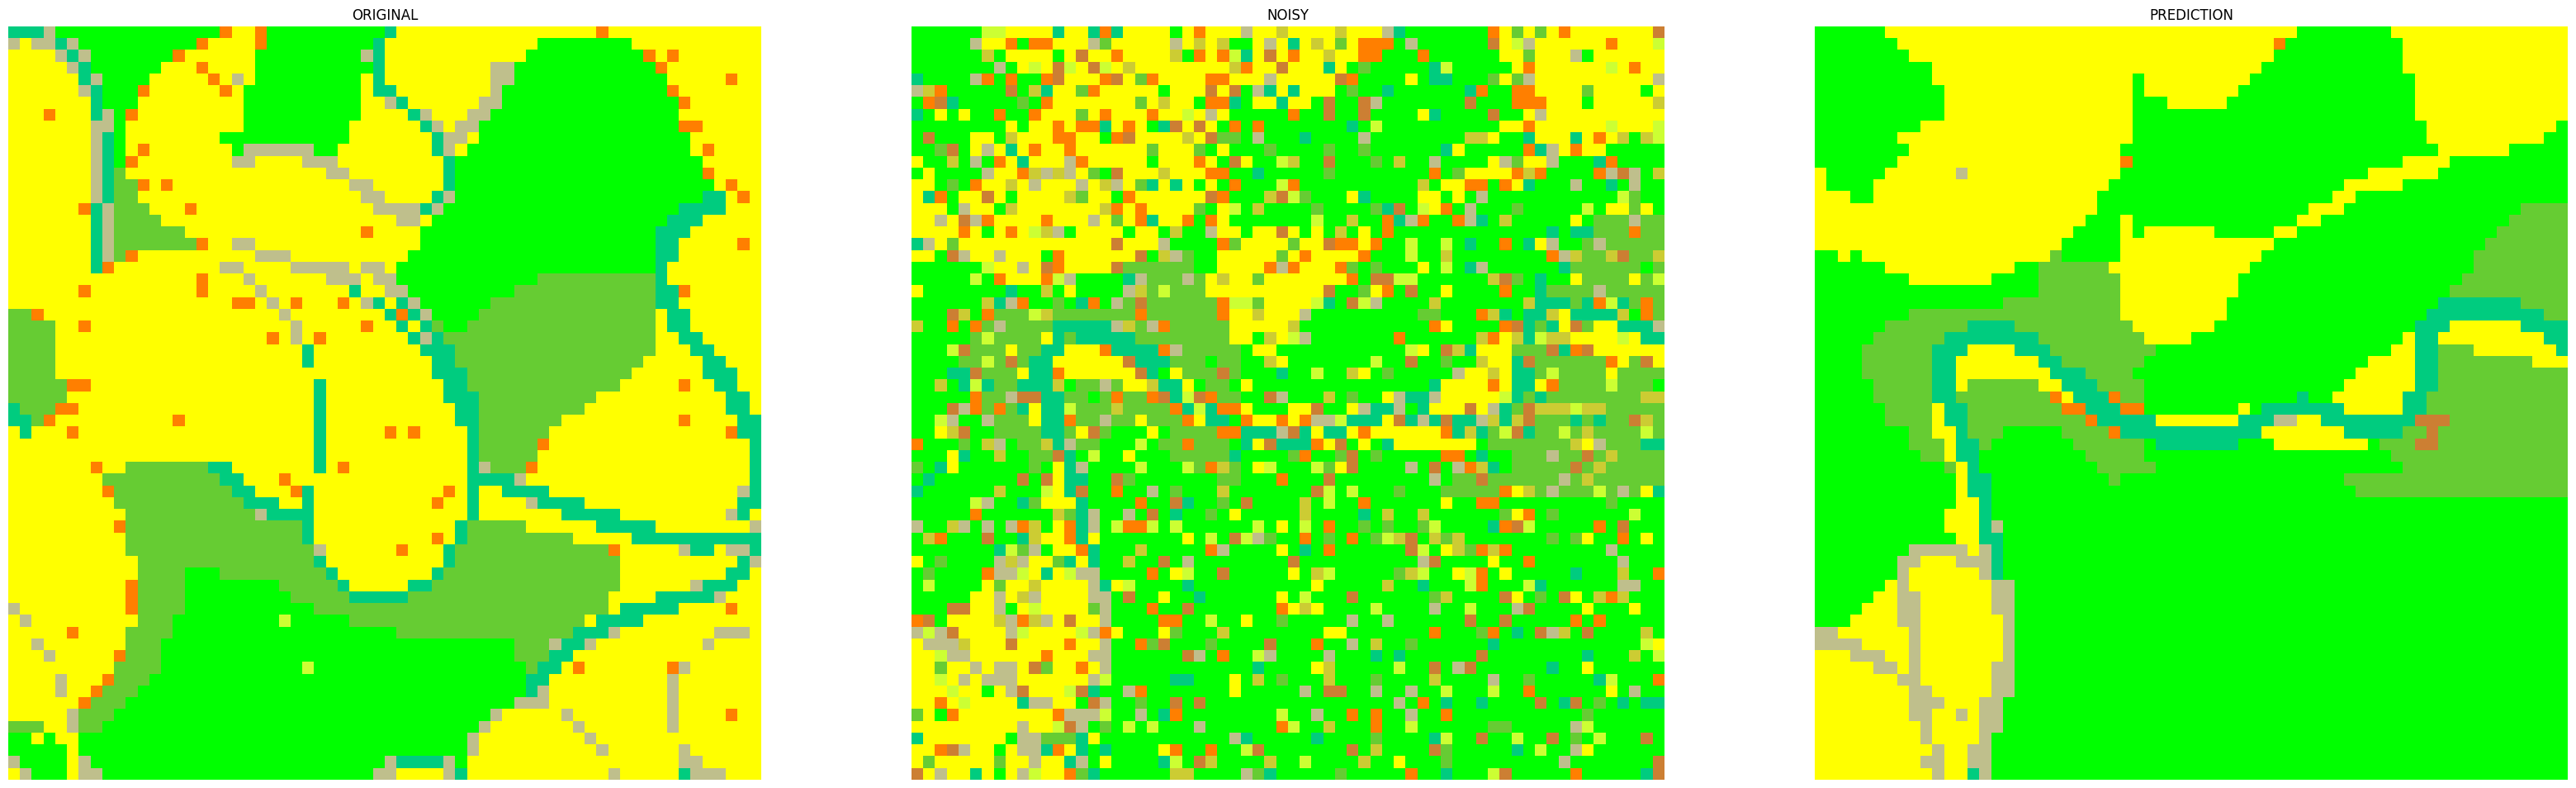

tf.Tensor([[[[0.36]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.35]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.39221875e-04 1.56667952e-04 1.35484367e-04 1.19550113e-04
 1.24058089e-04 1.20278773e-04 1.41491787e-04 9.98934558e-01
 1.28688598e-04], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 63, step: 0.35000000000000003


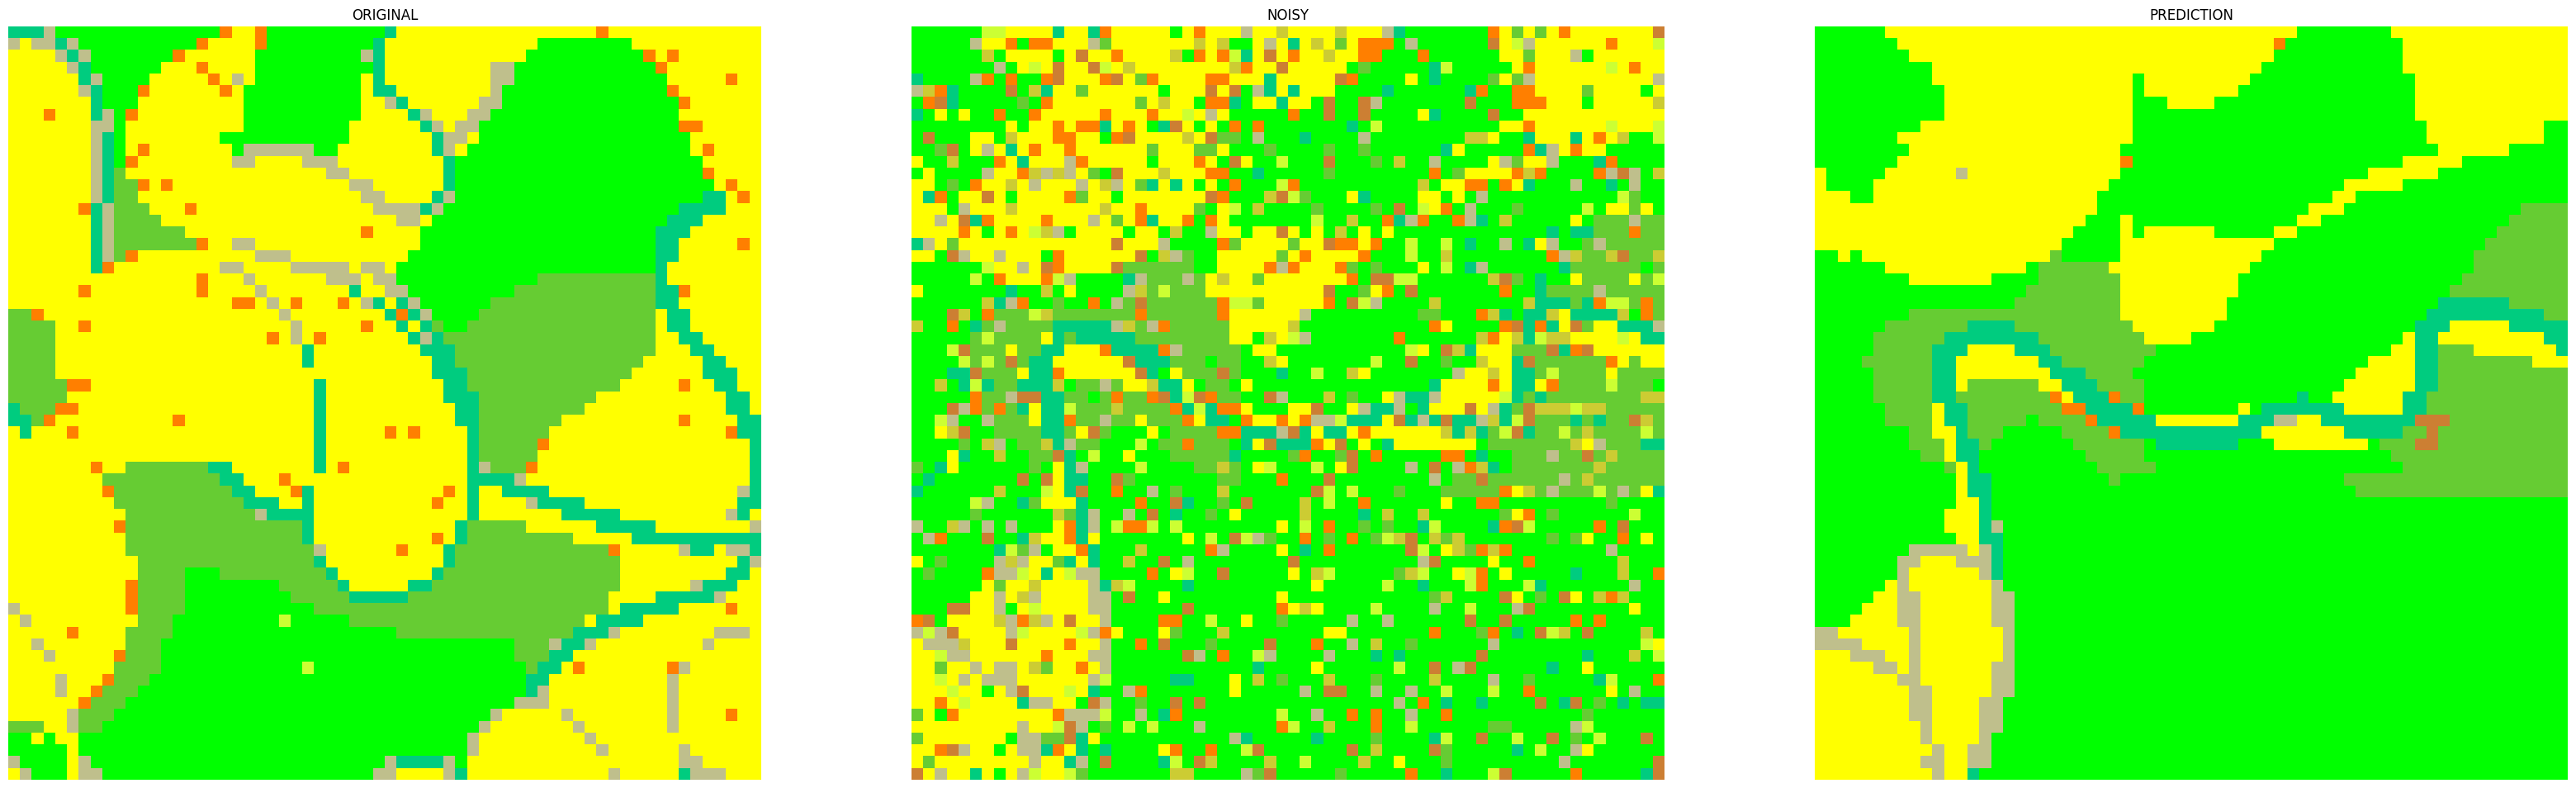

tf.Tensor([[[[0.35]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.34]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.27032293e-04 1.43570169e-04 1.22971307e-04 1.07817225e-04
 1.12291364e-04 1.08530871e-04 1.29794895e-04 9.99031148e-01
 1.16844198e-04], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 64, step: 0.34


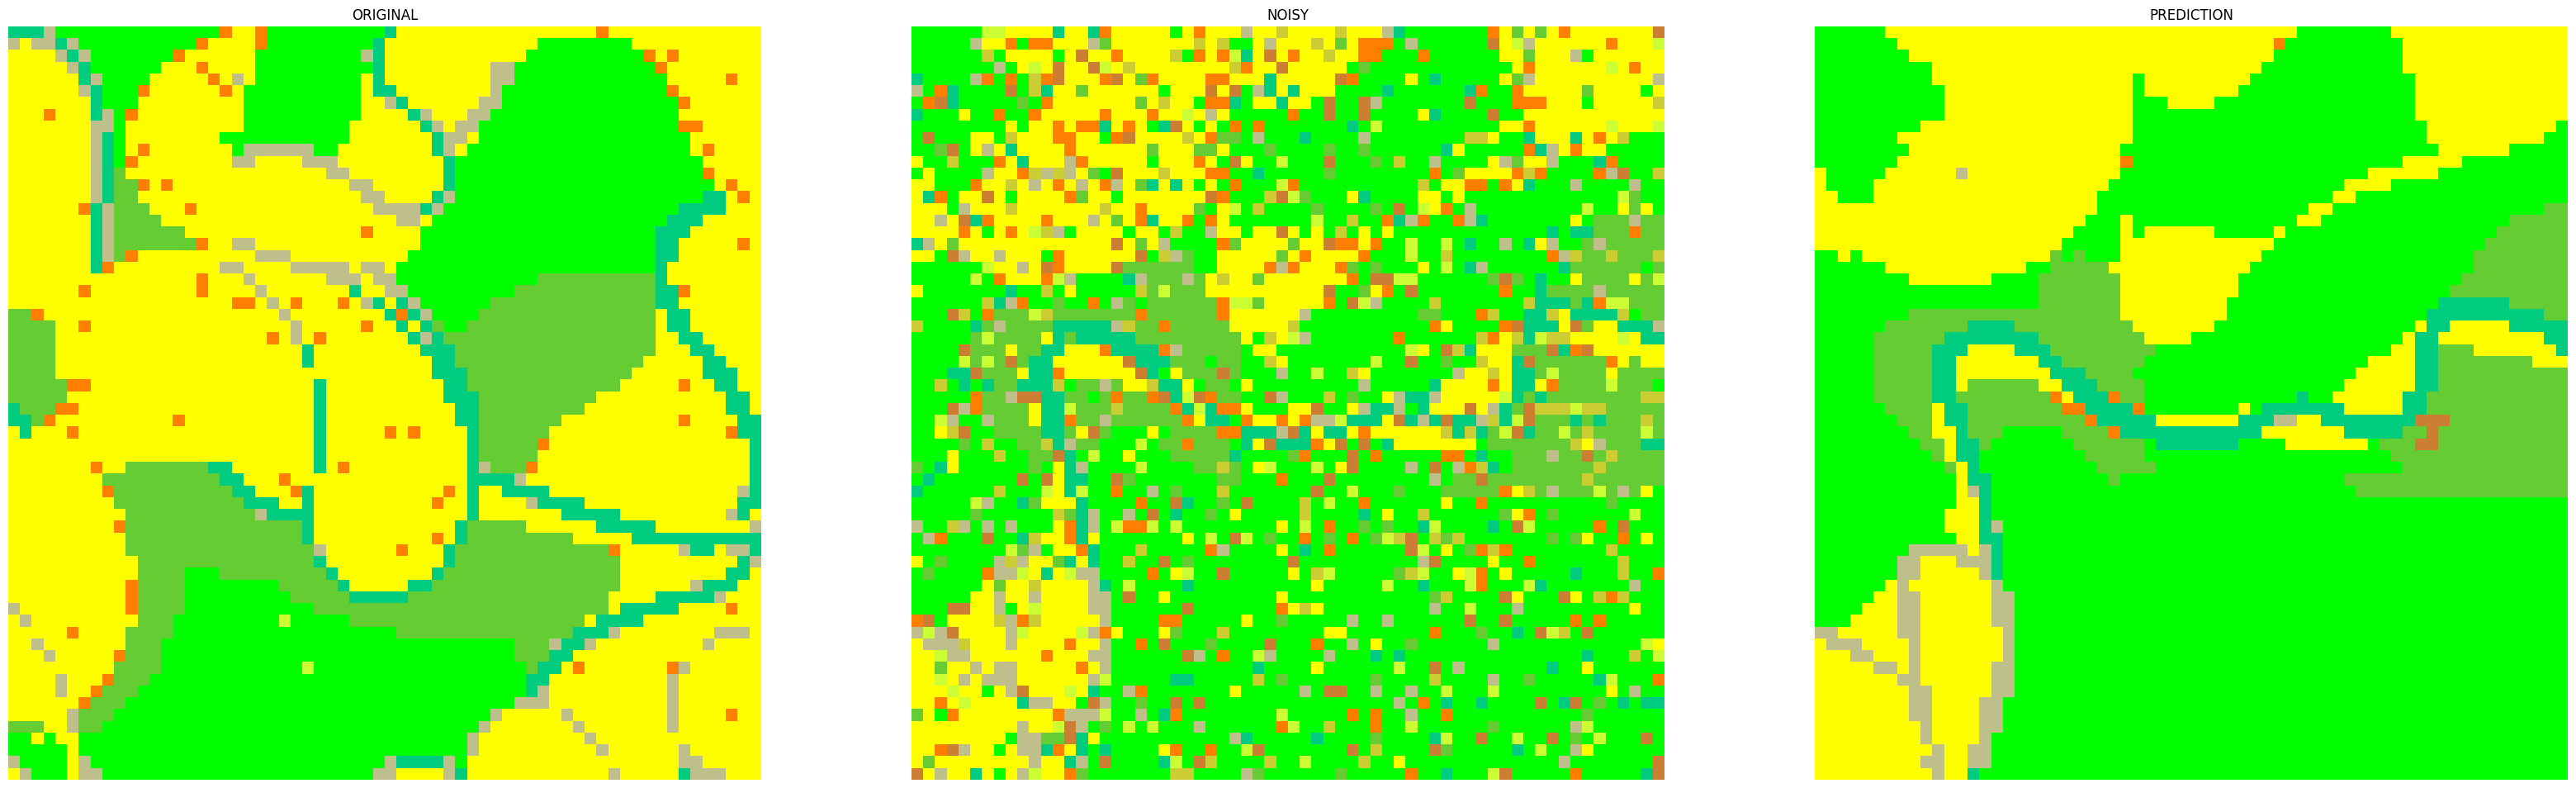

tf.Tensor([[[[0.34]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.33]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.15430216e-04 1.31318201e-04 1.11922938e-04 9.69356699e-05
 1.01050697e-04 9.76046265e-05 1.18196574e-04 9.99121799e-01
 1.05742048e-04], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 65, step: 0.33


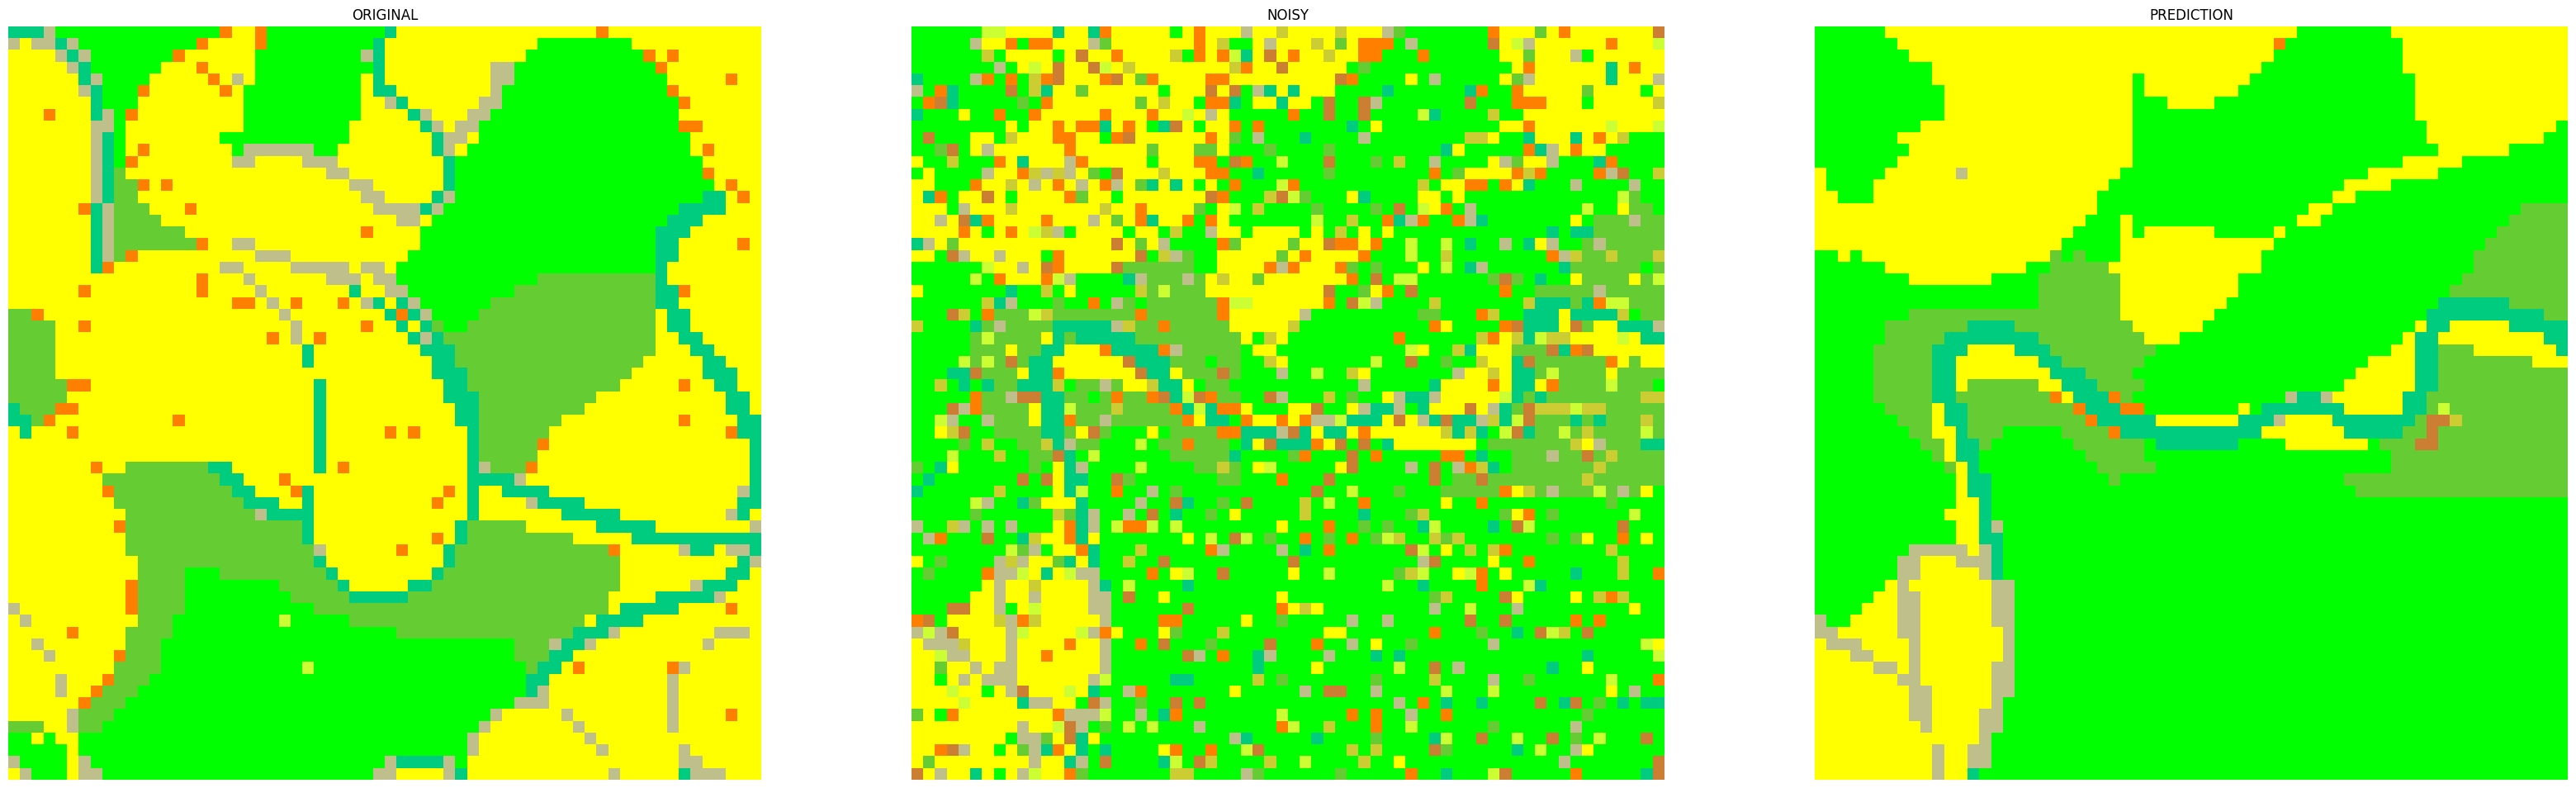

tf.Tensor([[[[0.33]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.32]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.05151330e-04 1.20326270e-04 1.01535200e-04 8.70811473e-05
 9.11218062e-05 8.77285125e-05 1.08213124e-04 9.99203390e-01
 9.54527713e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 66, step: 0.32


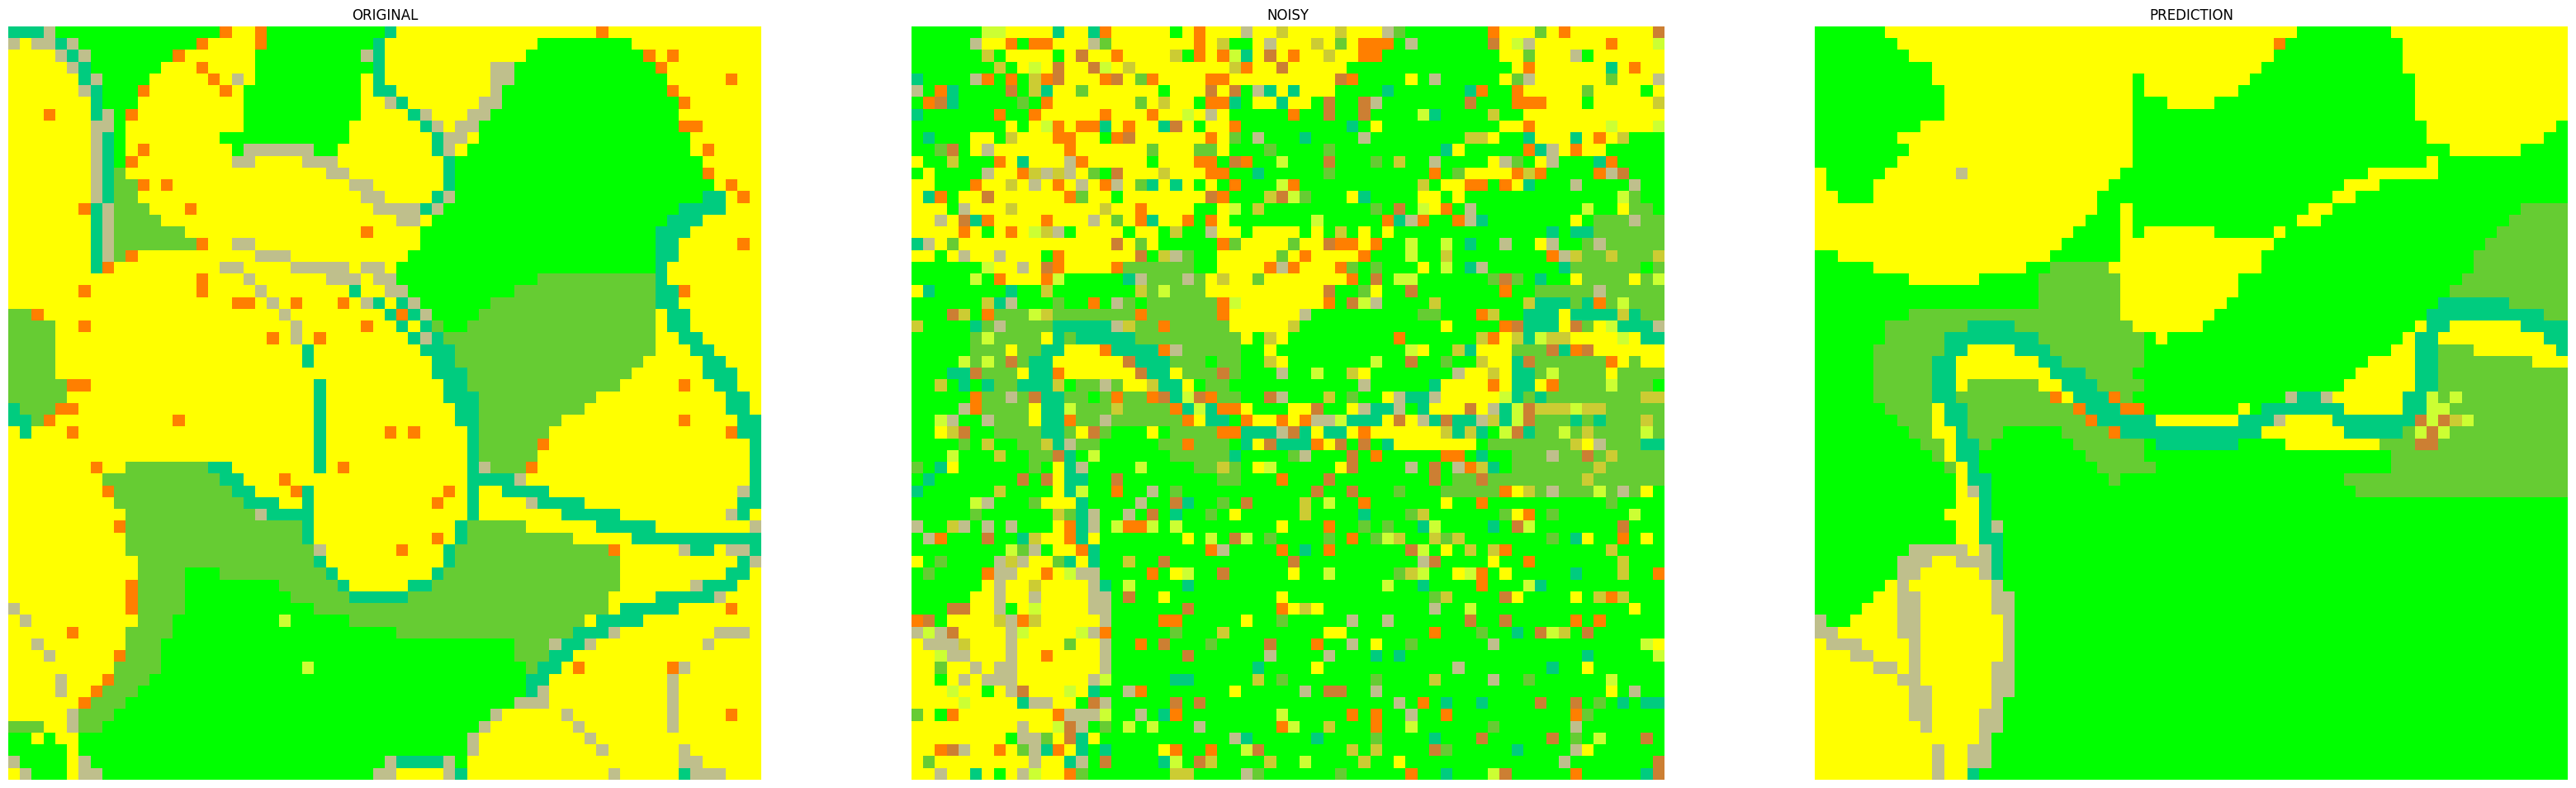

tf.Tensor([[[[0.32]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.31]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[9.57017886e-05 1.10929381e-04 9.24786184e-05 7.80699499e-05
 8.19004868e-05 7.86980259e-05 9.91018657e-05 9.99276589e-01
 8.65309201e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 67, step: 0.31


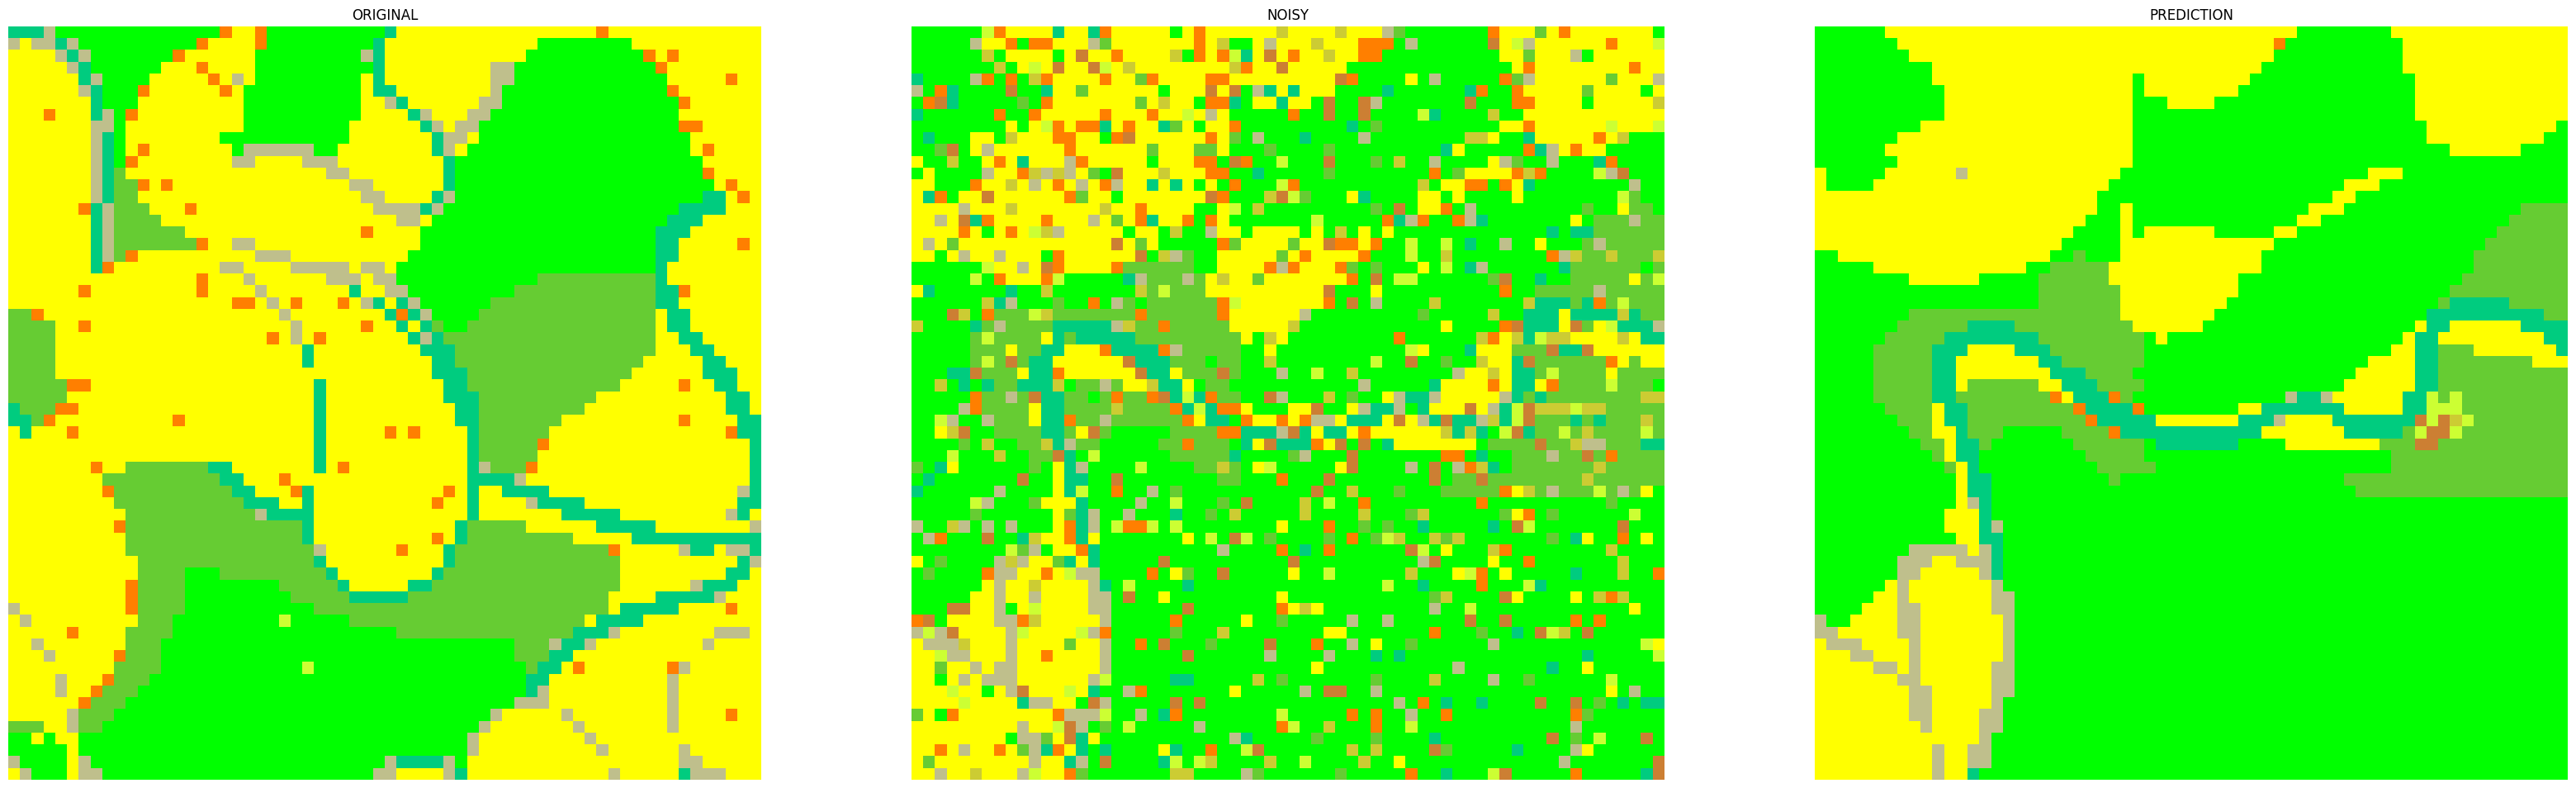

tf.Tensor([[[[0.31]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.3]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[8.68574775e-05 1.01747718e-04 8.35337208e-05 6.97322921e-05
 7.32535519e-05 7.03045551e-05 9.02999895e-05 9.99346685e-01
 7.75855776e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 68, step: 0.3


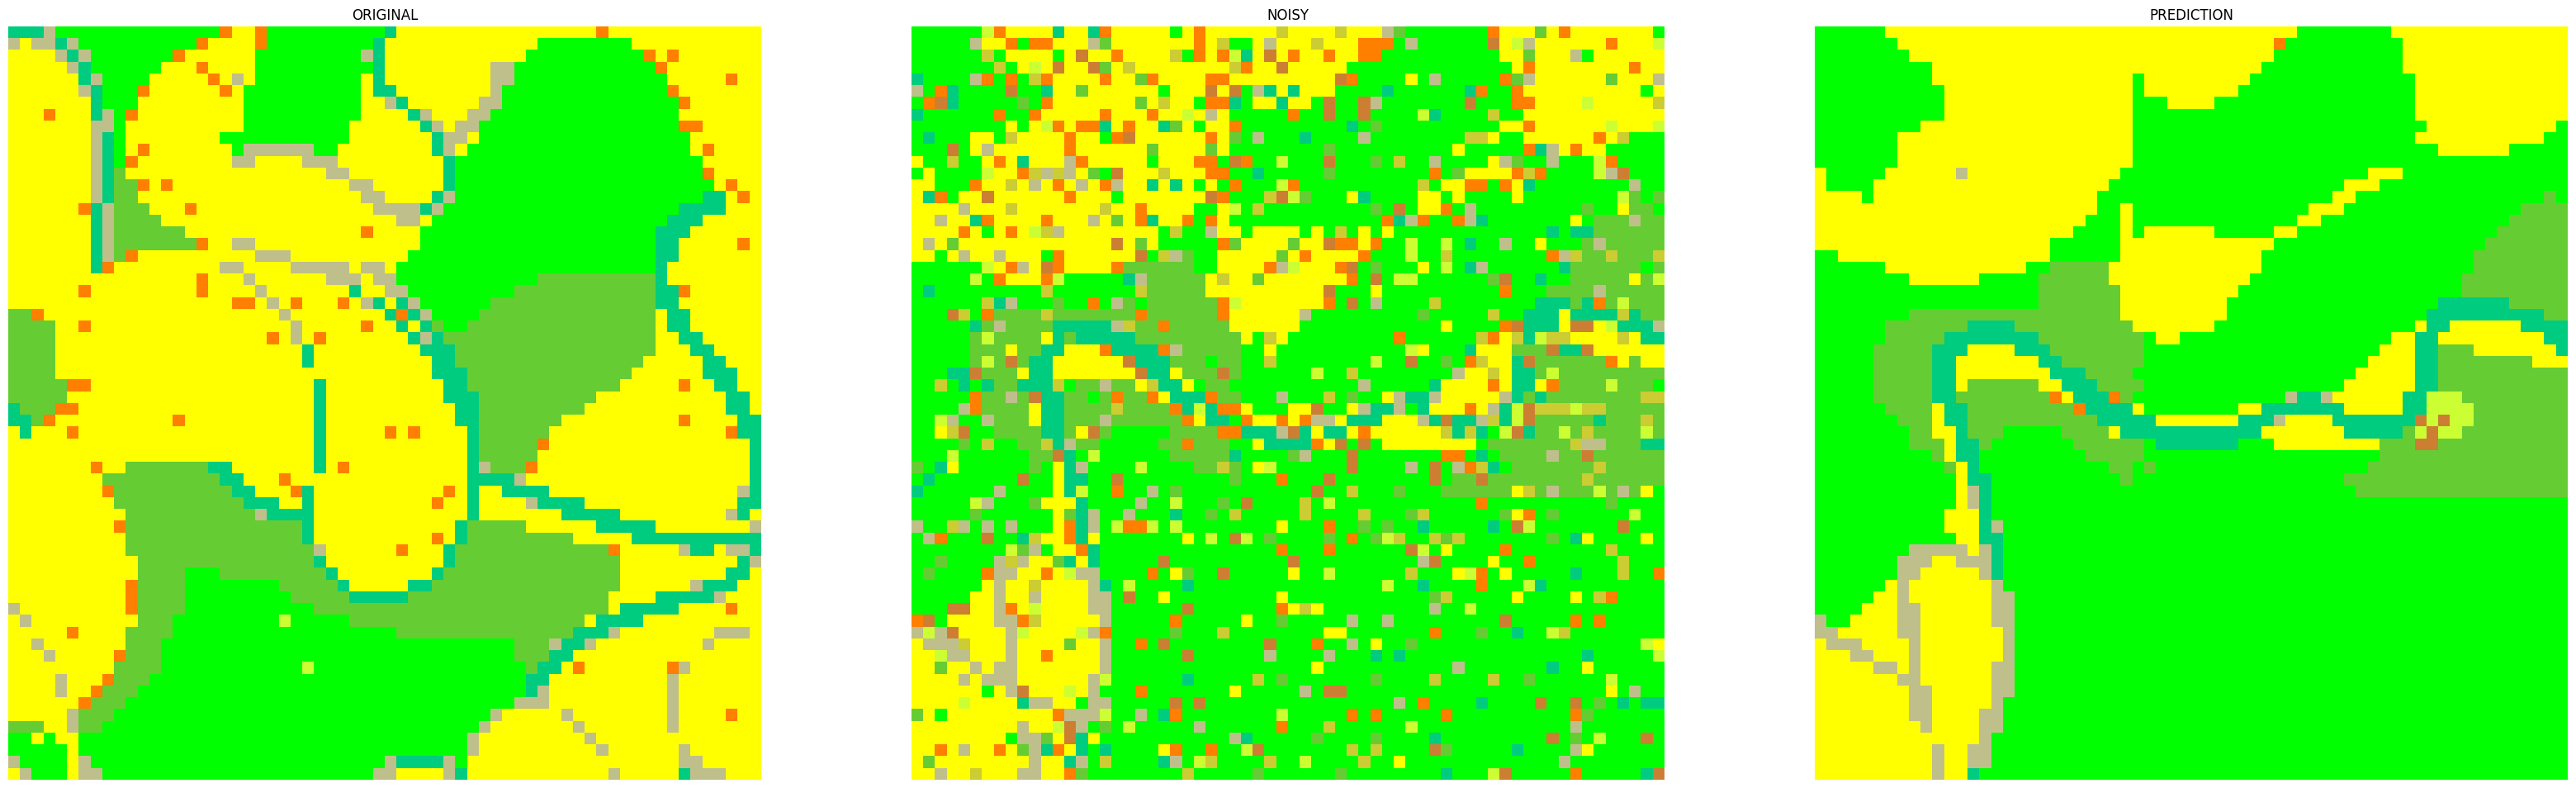

tf.Tensor([[[[0.3]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.29]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[7.85270283e-05 9.29909115e-05 7.54591238e-05 6.21177444e-05
 6.54028753e-05 6.26430774e-05 8.21852029e-05 9.99411071e-01
 6.96030442e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 69, step: 0.29


tf.Tensor([[[[0.29]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.28]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[7.18142728e-05 8.68554633e-05 6.82411744e-05 5.52749173e-05
 5.83994602e-05 5.57687901e-05 7.48984004e-05 9.99466127e-01
 6.26201480e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 70, step: 0.28


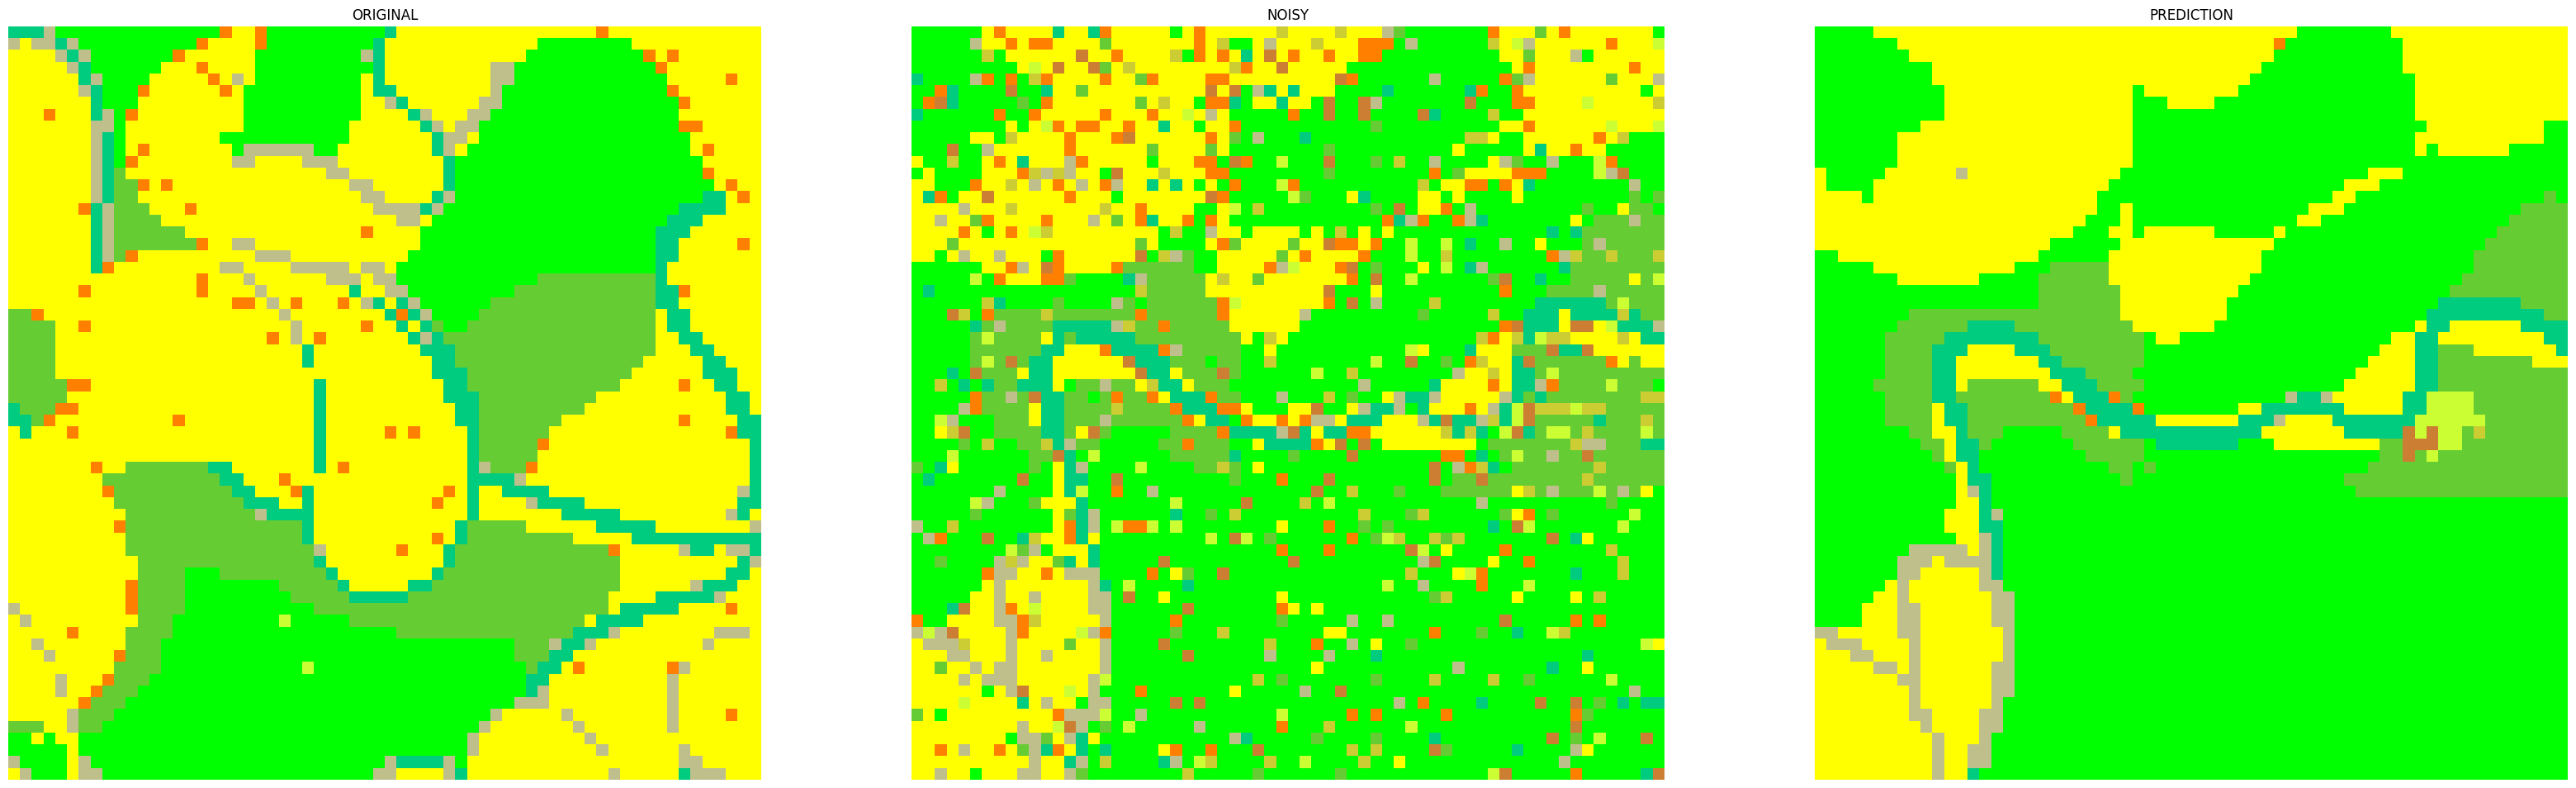

tf.Tensor([[[[0.28]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.27]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[6.35636526e-05 7.62416380e-05 6.04103182e-05 4.87938625e-05
 5.15708344e-05 4.92382804e-05 6.63143327e-05 9.99528406e-01
 5.54607367e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 71, step: 0.27


tf.Tensor([[[[0.27]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.26]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[5.69573384e-05 6.89139338e-05 5.39507426e-05 4.30127902e-05
 4.55353467e-05 4.34180531e-05 5.93500262e-05 9.99579568e-01
 4.92934714e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 72, step: 0.26


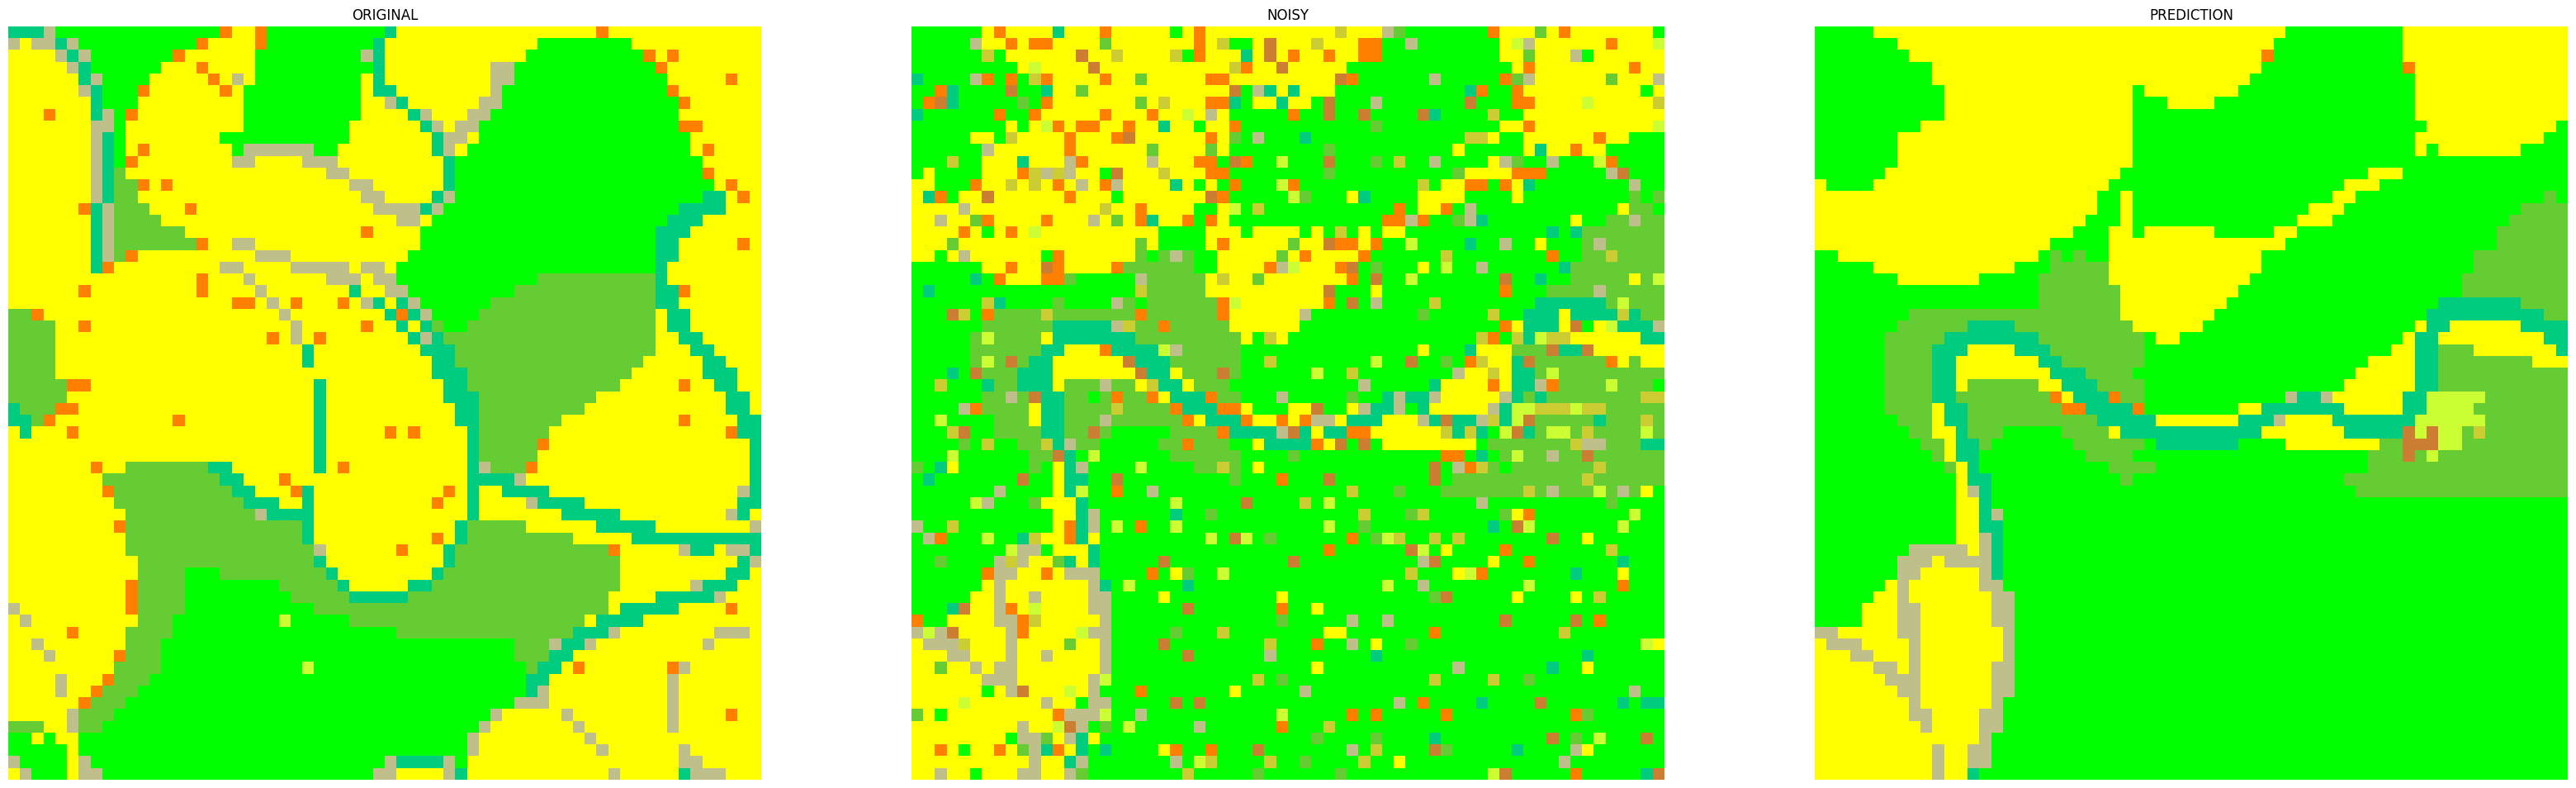

tf.Tensor([[[[0.26]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.25]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[5.13295585e-05 6.29690290e-05 4.84104293e-05 3.78304929e-05
 4.01599783e-05 3.82035708e-05 5.36568768e-05 9.99623555e-01
 4.38847870e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 73, step: 0.25


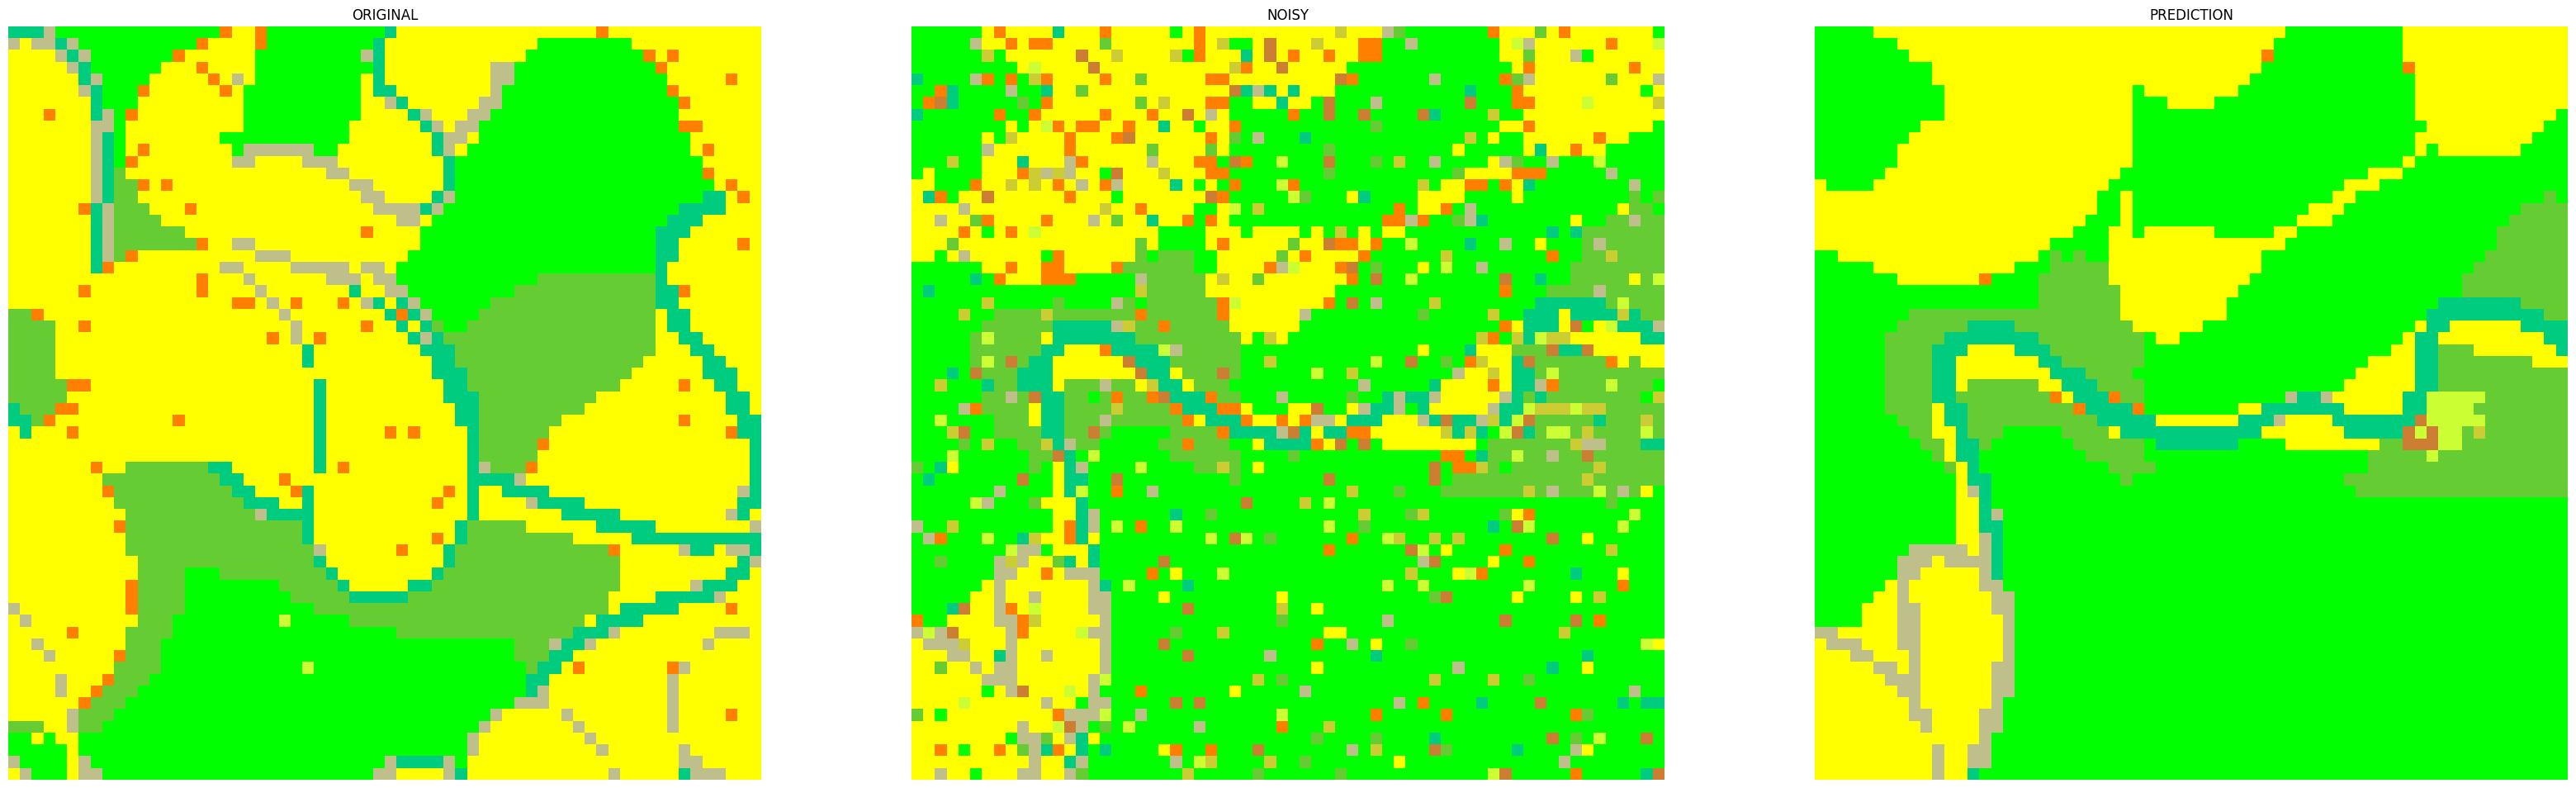

tf.Tensor([[[[0.25]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.24]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[4.60281113e-05 5.70686681e-05 4.33924130e-05 3.31436043e-05
 3.53615852e-05 3.35041659e-05 4.85769253e-05 9.99663897e-01
 3.90276114e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 74, step: 0.24


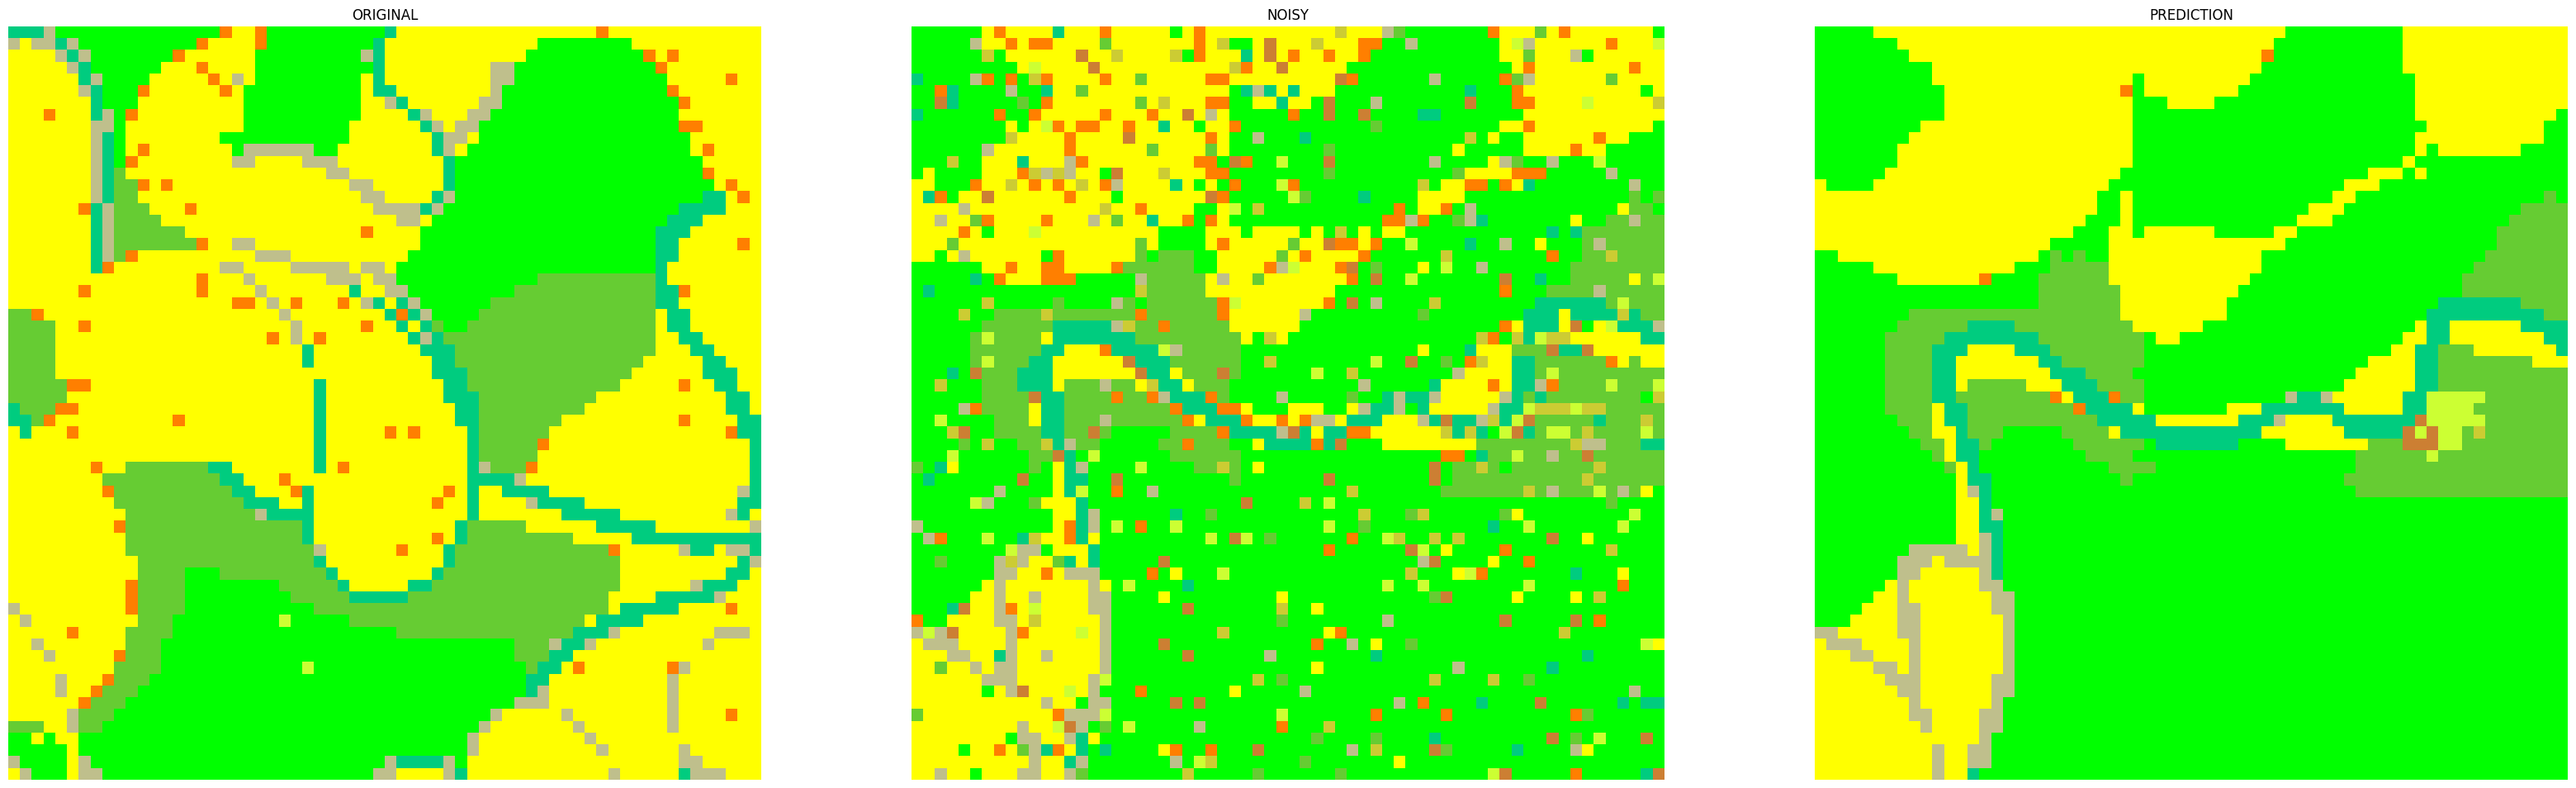

tf.Tensor([[[[0.24]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.23]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[4.12571506e-05 5.19404571e-05 3.86171217e-05 2.88917699e-05
 3.09908137e-05 2.92336823e-05 4.33945006e-05 9.99701419e-01
 3.42551983e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 75, step: 0.23


tf.Tensor([[[[0.23]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.22]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[3.64839190e-05 4.61360862e-05 3.40536143e-05 2.50552840e-05
 2.69205155e-05 2.53631276e-05 3.89162877e-05 9.99737635e-01
 2.94359957e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 76, step: 0.22


tf.Tensor([[[[0.22]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.21]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[3.24820738e-05 4.24092723e-05 3.02245346e-05 2.16147898e-05
 2.33746467e-05 2.19008612e-05 3.41504455e-05 9.99768176e-01
 2.56673141e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 77, step: 0.21


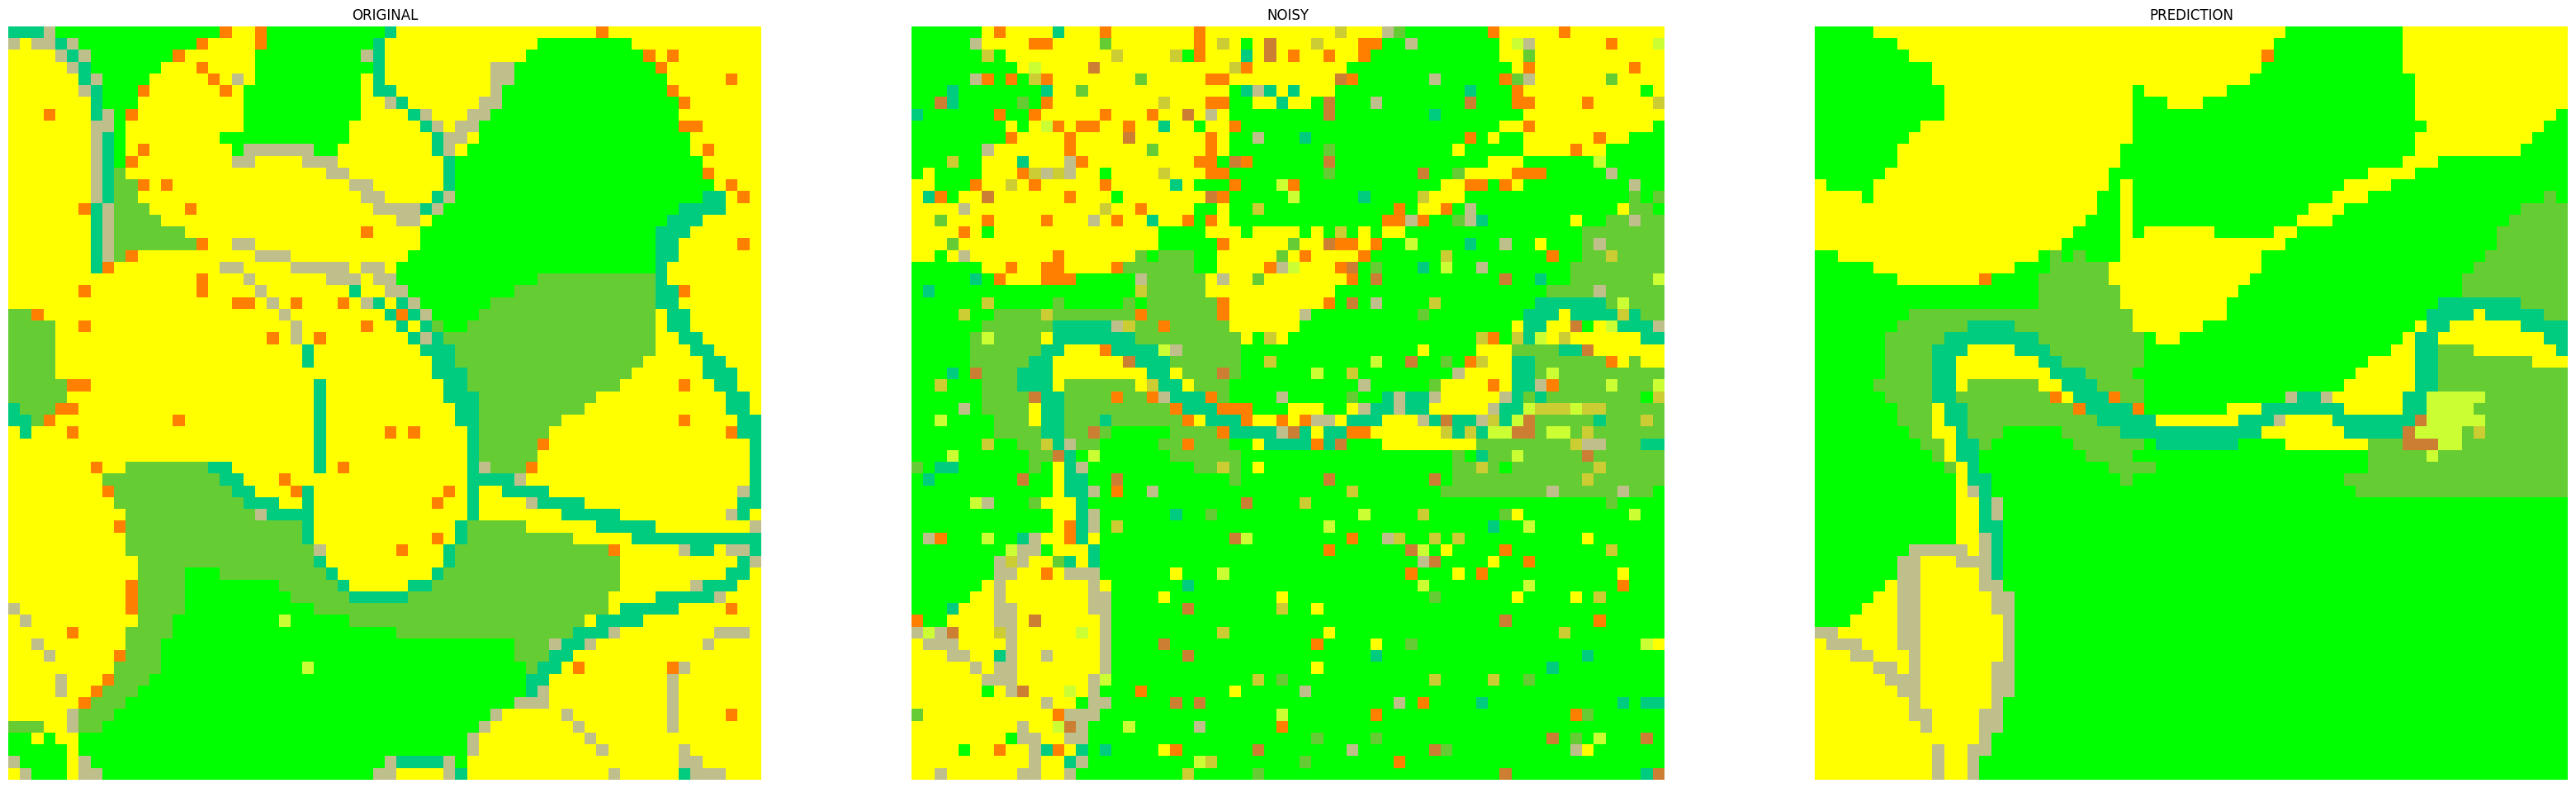

tf.Tensor([[[[0.21]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.2]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.89633278e-05 3.83547150e-05 2.65479573e-05 1.85466392e-05
 2.01757167e-05 1.88105340e-05 3.06047894e-05 9.99795699e-01
 2.22977714e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 78, step: 0.2


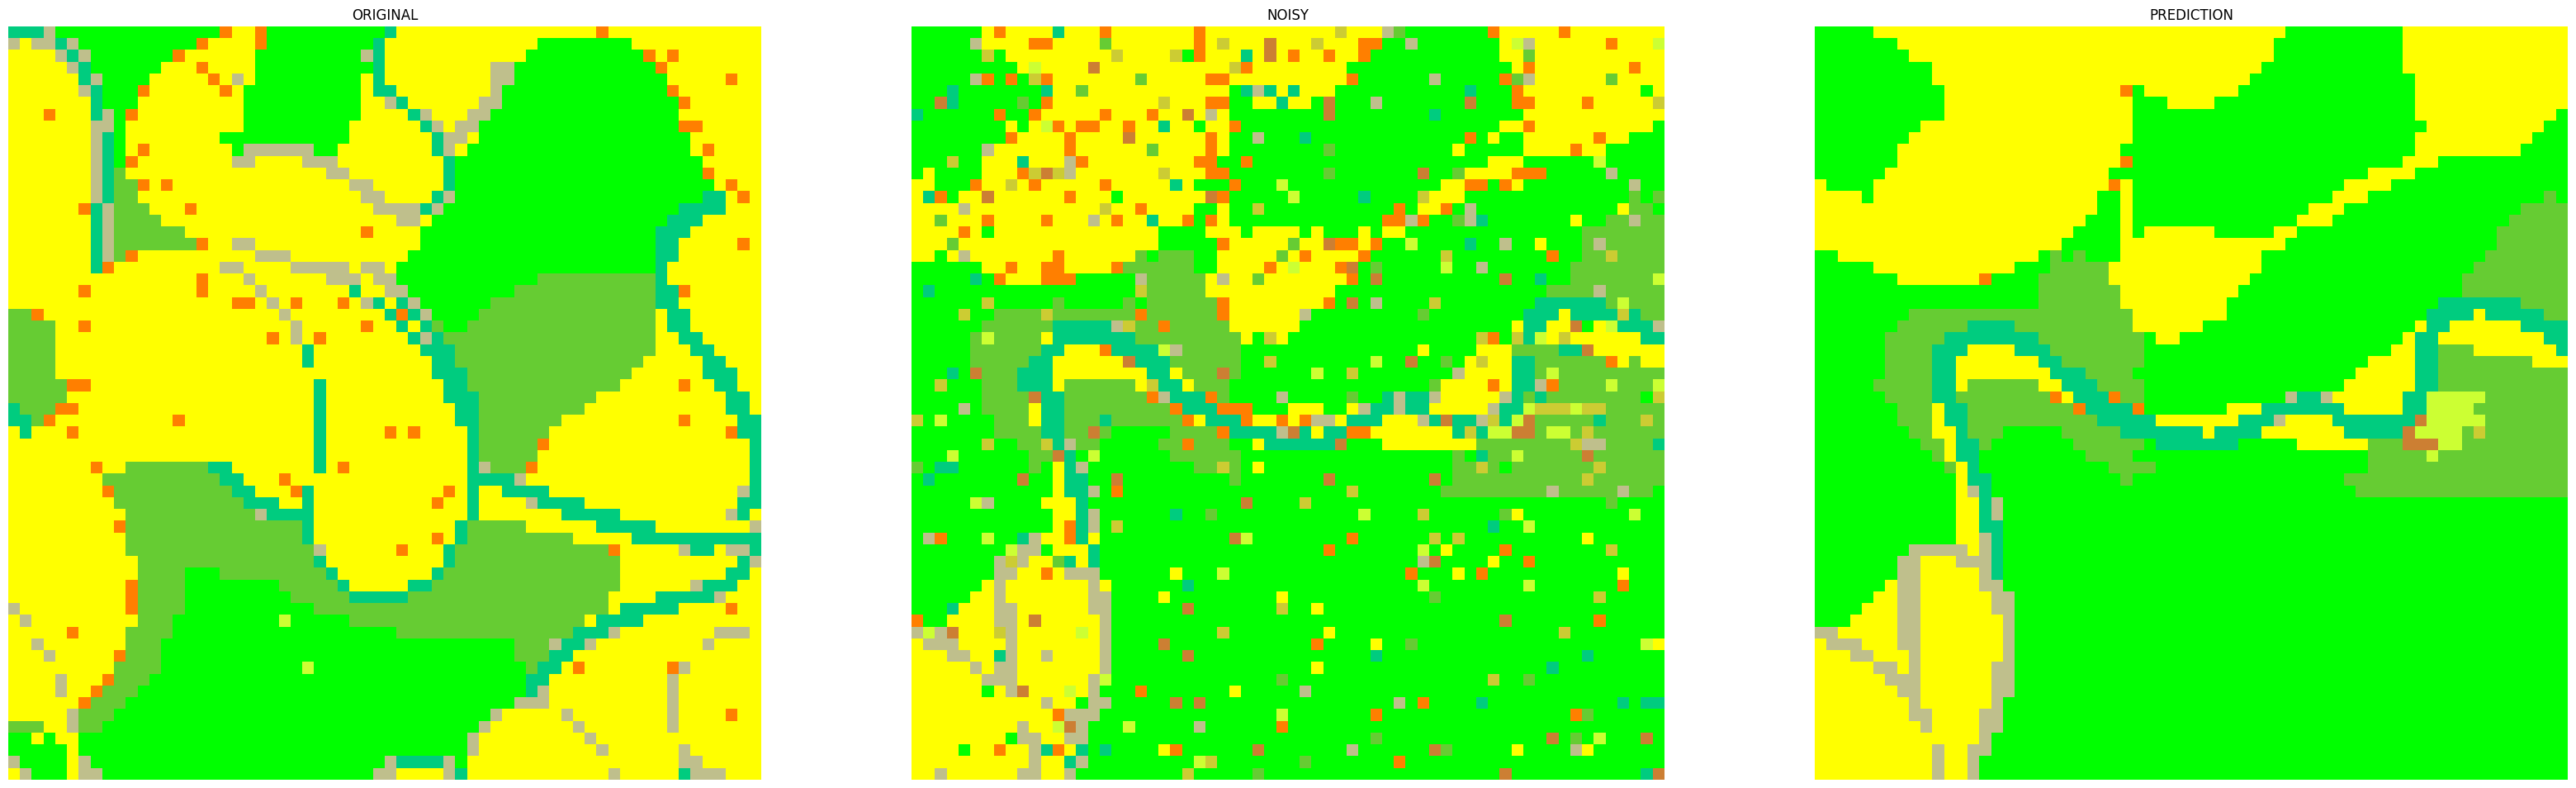

tf.Tensor([[[[0.2]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.19]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.57847571e-05 3.46957097e-05 2.34025994e-05 1.58122354e-05
 1.73371382e-05 1.60579809e-05 2.72661253e-05 9.99820297e-01
 1.93468359e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 79, step: 0.19


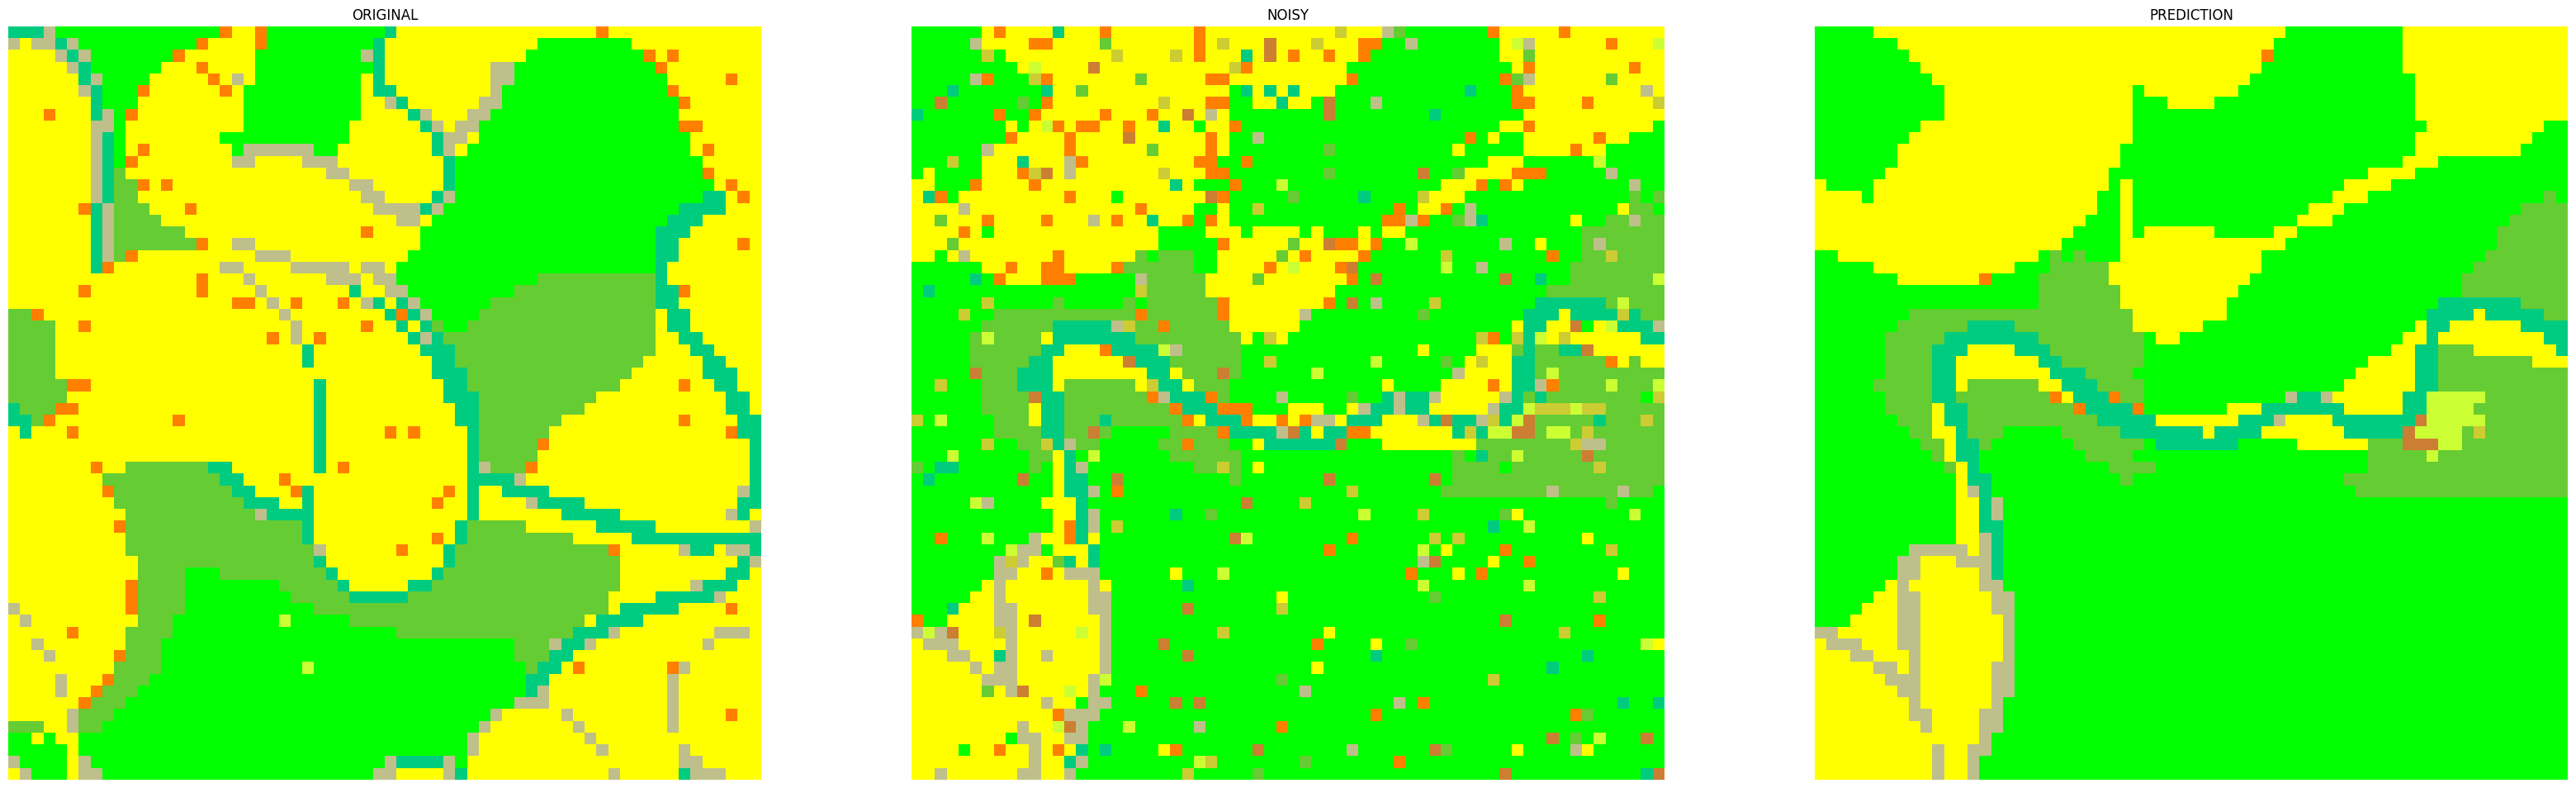

tf.Tensor([[[[0.19]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.18]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.24735782e-05 3.07092531e-05 2.03541079e-05 1.33540067e-05
 1.47349768e-05 1.35741919e-05 2.39631656e-05 9.99844361e-01
 1.64761354e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 80, step: 0.18


tf.Tensor([[[[0.18]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.17]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.00182811e-05 2.78234944e-05 1.79077977e-05 1.12220870e-05
 1.25372328e-05 1.14304692e-05 2.13445762e-05 9.99863558e-01
 1.41578727e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 81, step: 0.17


tf.Tensor([[[[0.17]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.16]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.77368540e-05 2.51011117e-05 1.56590572e-05 9.34197958e-06
 1.05745053e-05 9.53600196e-06 1.90201836e-05 9.99880914e-01
 1.21164138e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 82, step: 0.16


tf.Tensor([[[[0.16]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.15]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.52014163e-05 2.20672771e-05 1.35963152e-05 7.67675984e-06
 8.78503925e-06 7.85314012e-06 1.63912767e-05 9.99898239e-01
 1.01902146e-05], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 83, step: 0.15


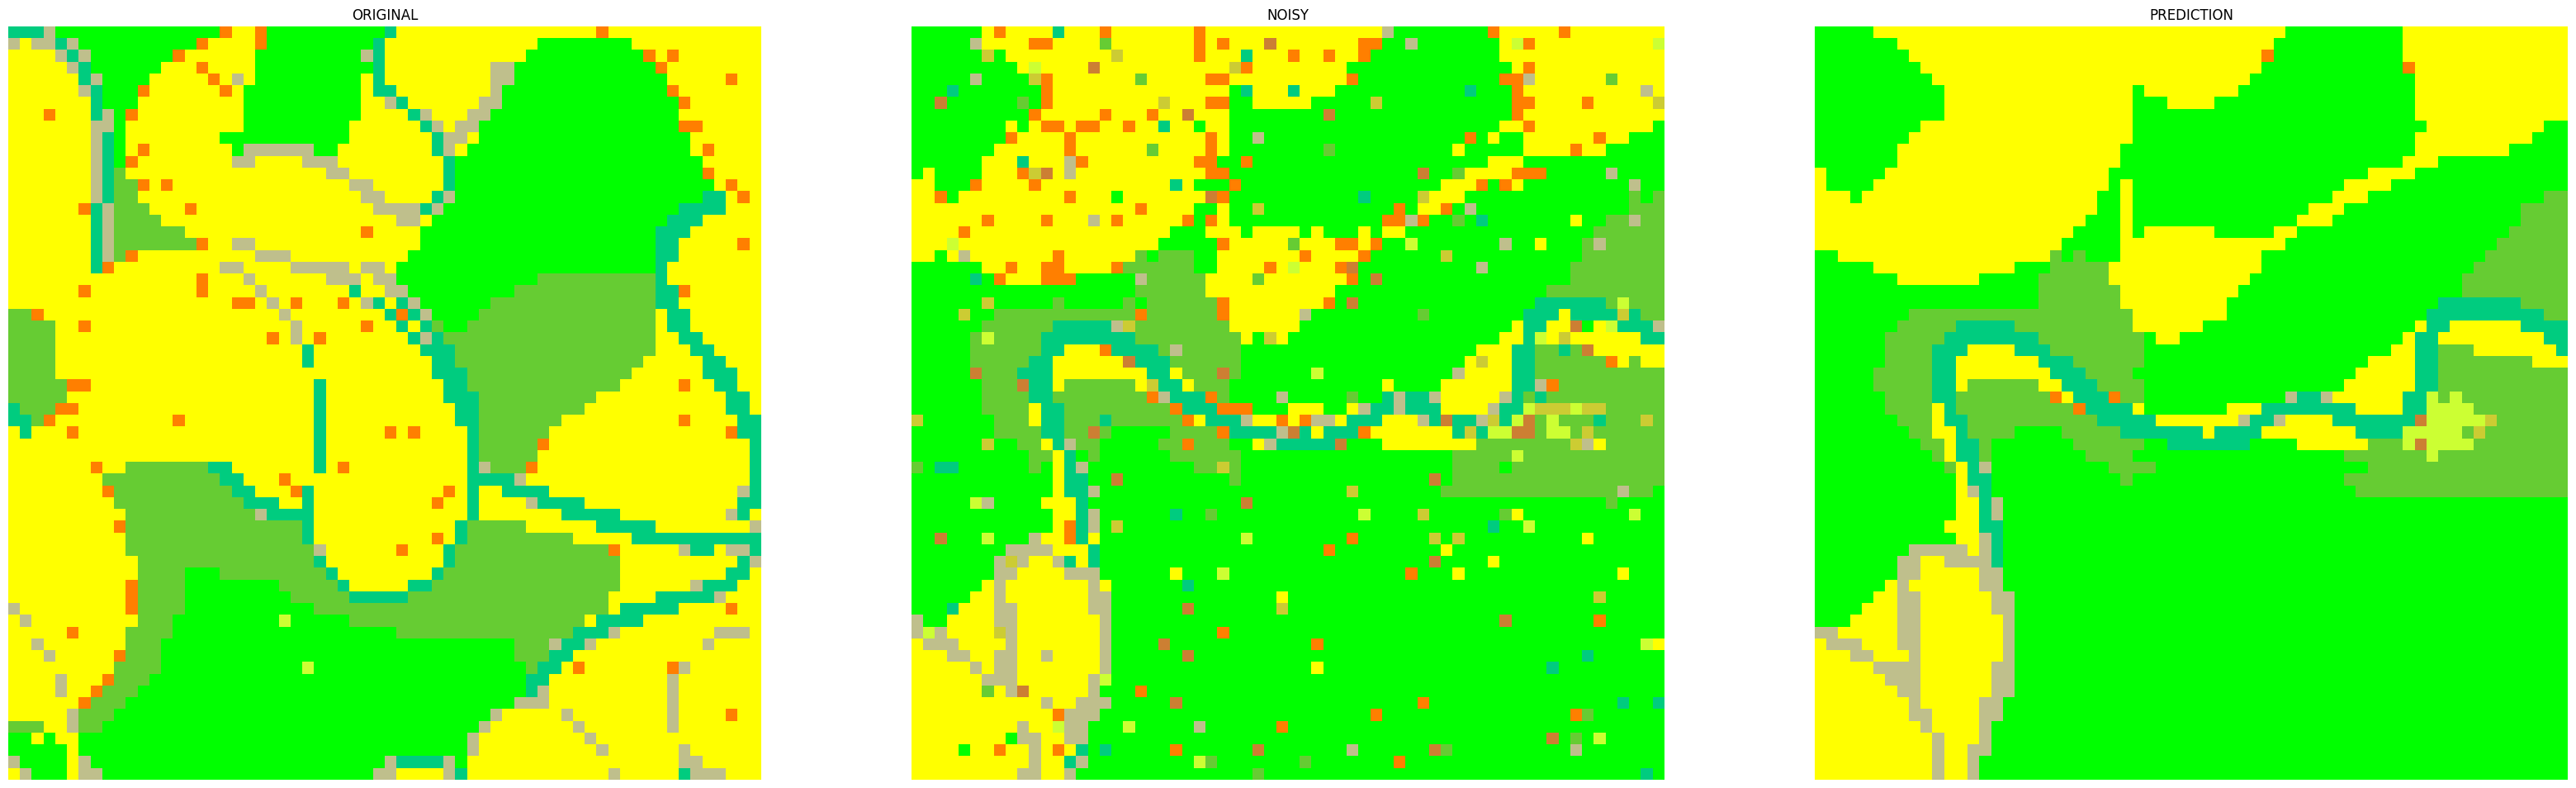

tf.Tensor([[[[0.15]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.14]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.33314161e-05 1.97710749e-05 1.17575993e-05 6.24888524e-06
 7.27224377e-06 6.41094546e-06 1.44859663e-05 9.99912144e-01
 8.57753402e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 84, step: 0.14


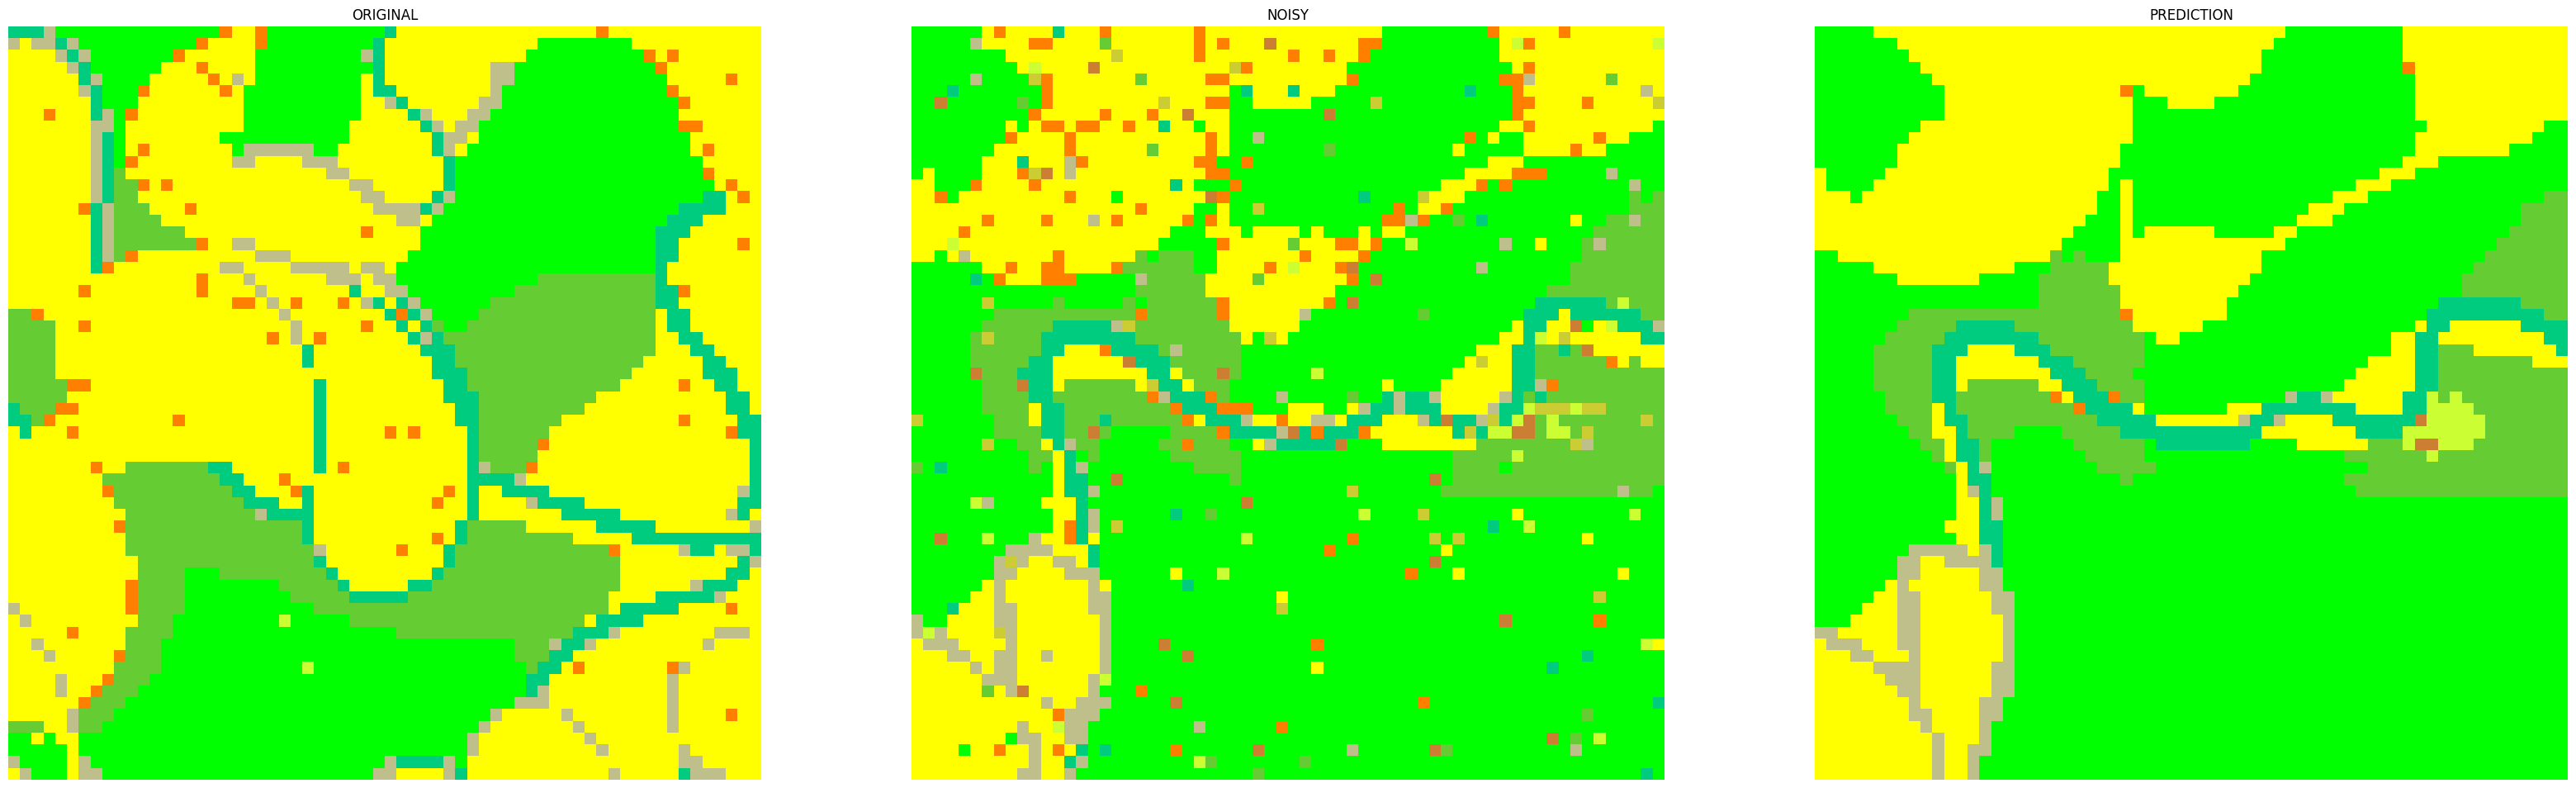

tf.Tensor([[[[0.14]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.13]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.17435409e-05 1.77386474e-05 1.02097068e-05 5.02825544e-06
 5.99481249e-06 5.18240994e-06 1.25421025e-05 9.99924351e-01
 7.20941342e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 85, step: 0.13


tf.Tensor([[[[0.13]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.12]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.02306272e-05 1.57905196e-05 8.73740592e-06 3.97690039e-06
 4.85988587e-06 4.11681271e-06 1.08950683e-05 9.99935435e-01
 5.95793539e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 86, step: 0.12


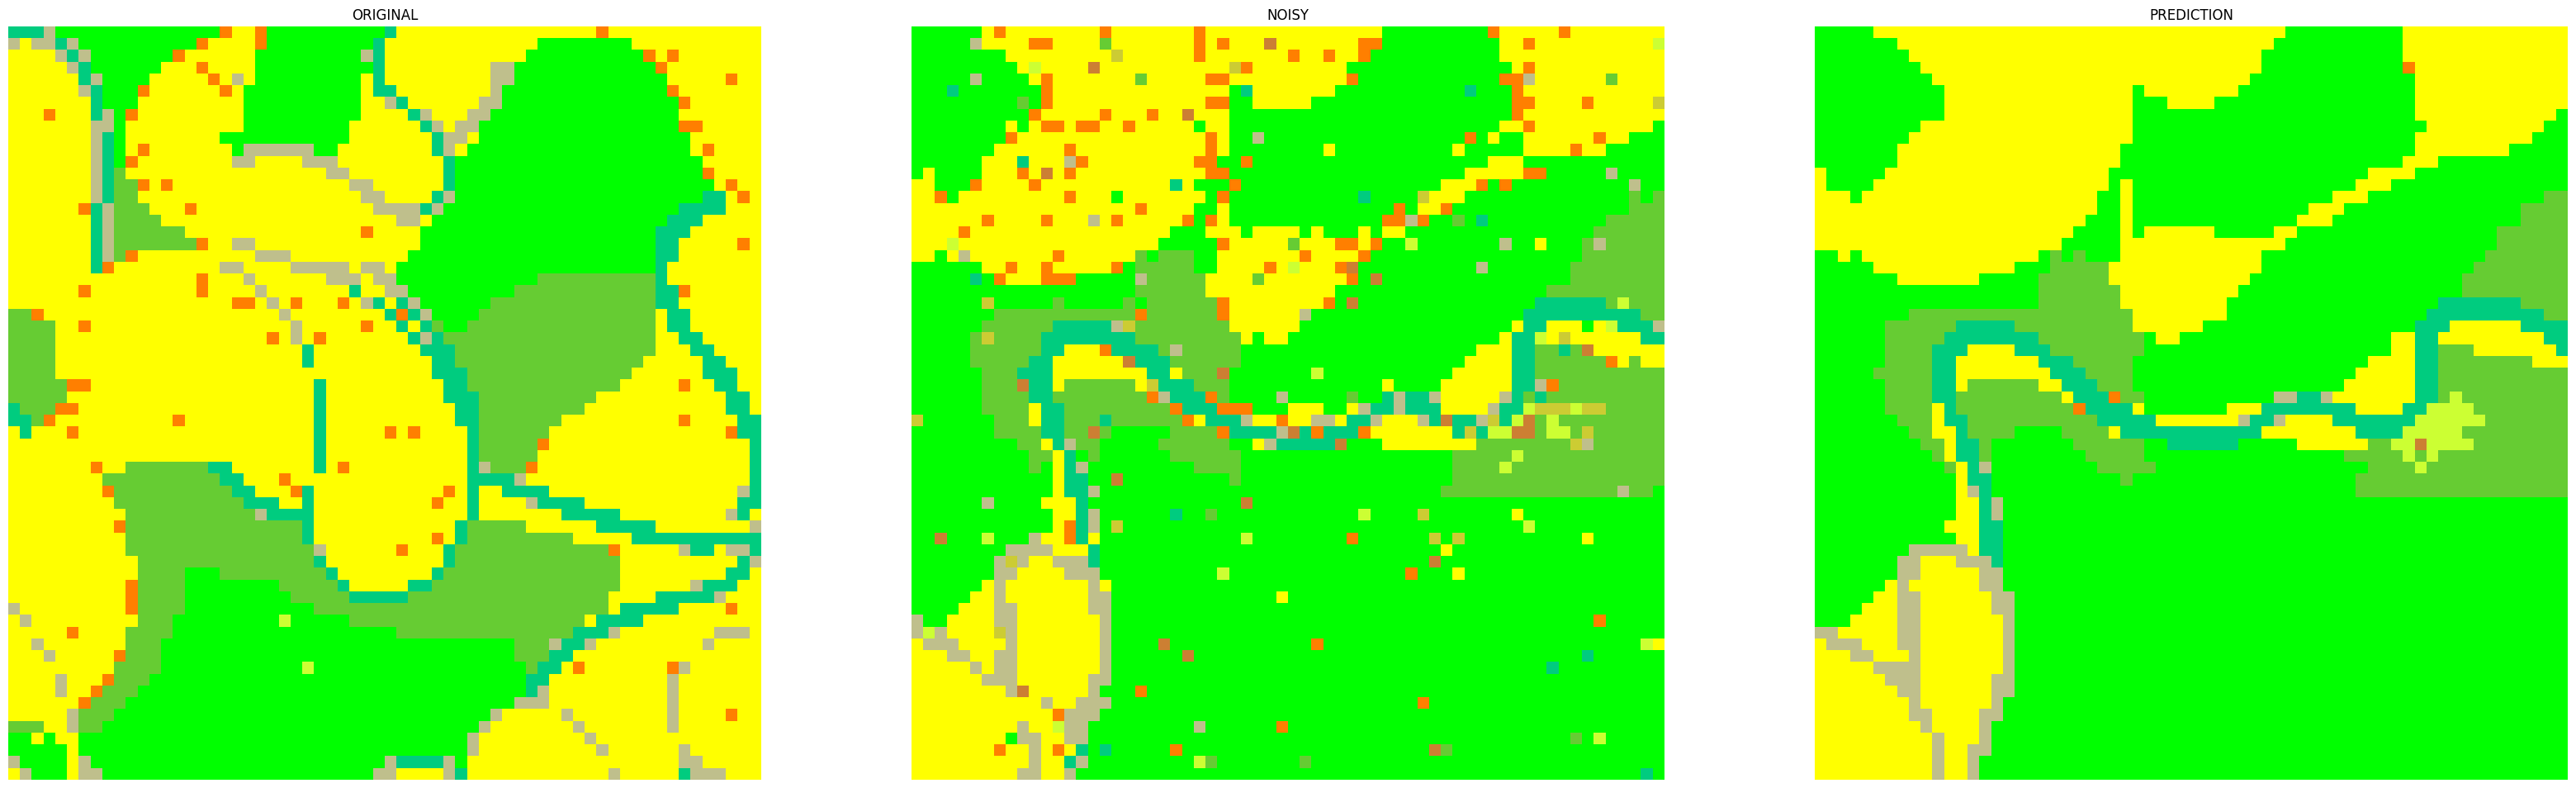

tf.Tensor([[[[0.12]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.11]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[8.94060449e-06 1.41354185e-05 7.49137696e-06 3.09356985e-06
 3.90487263e-06 3.22022828e-06 9.50733610e-06 9.99944833e-01
 4.87364926e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 87, step: 0.11


tf.Tensor([[[[0.11]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.1]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[7.66686764e-06 1.23439699e-05 6.33390930e-06 2.35272798e-06
 3.07599164e-06 2.46435629e-06 8.15729170e-06 9.99953653e-01
 3.95179095e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 88, step: 0.1


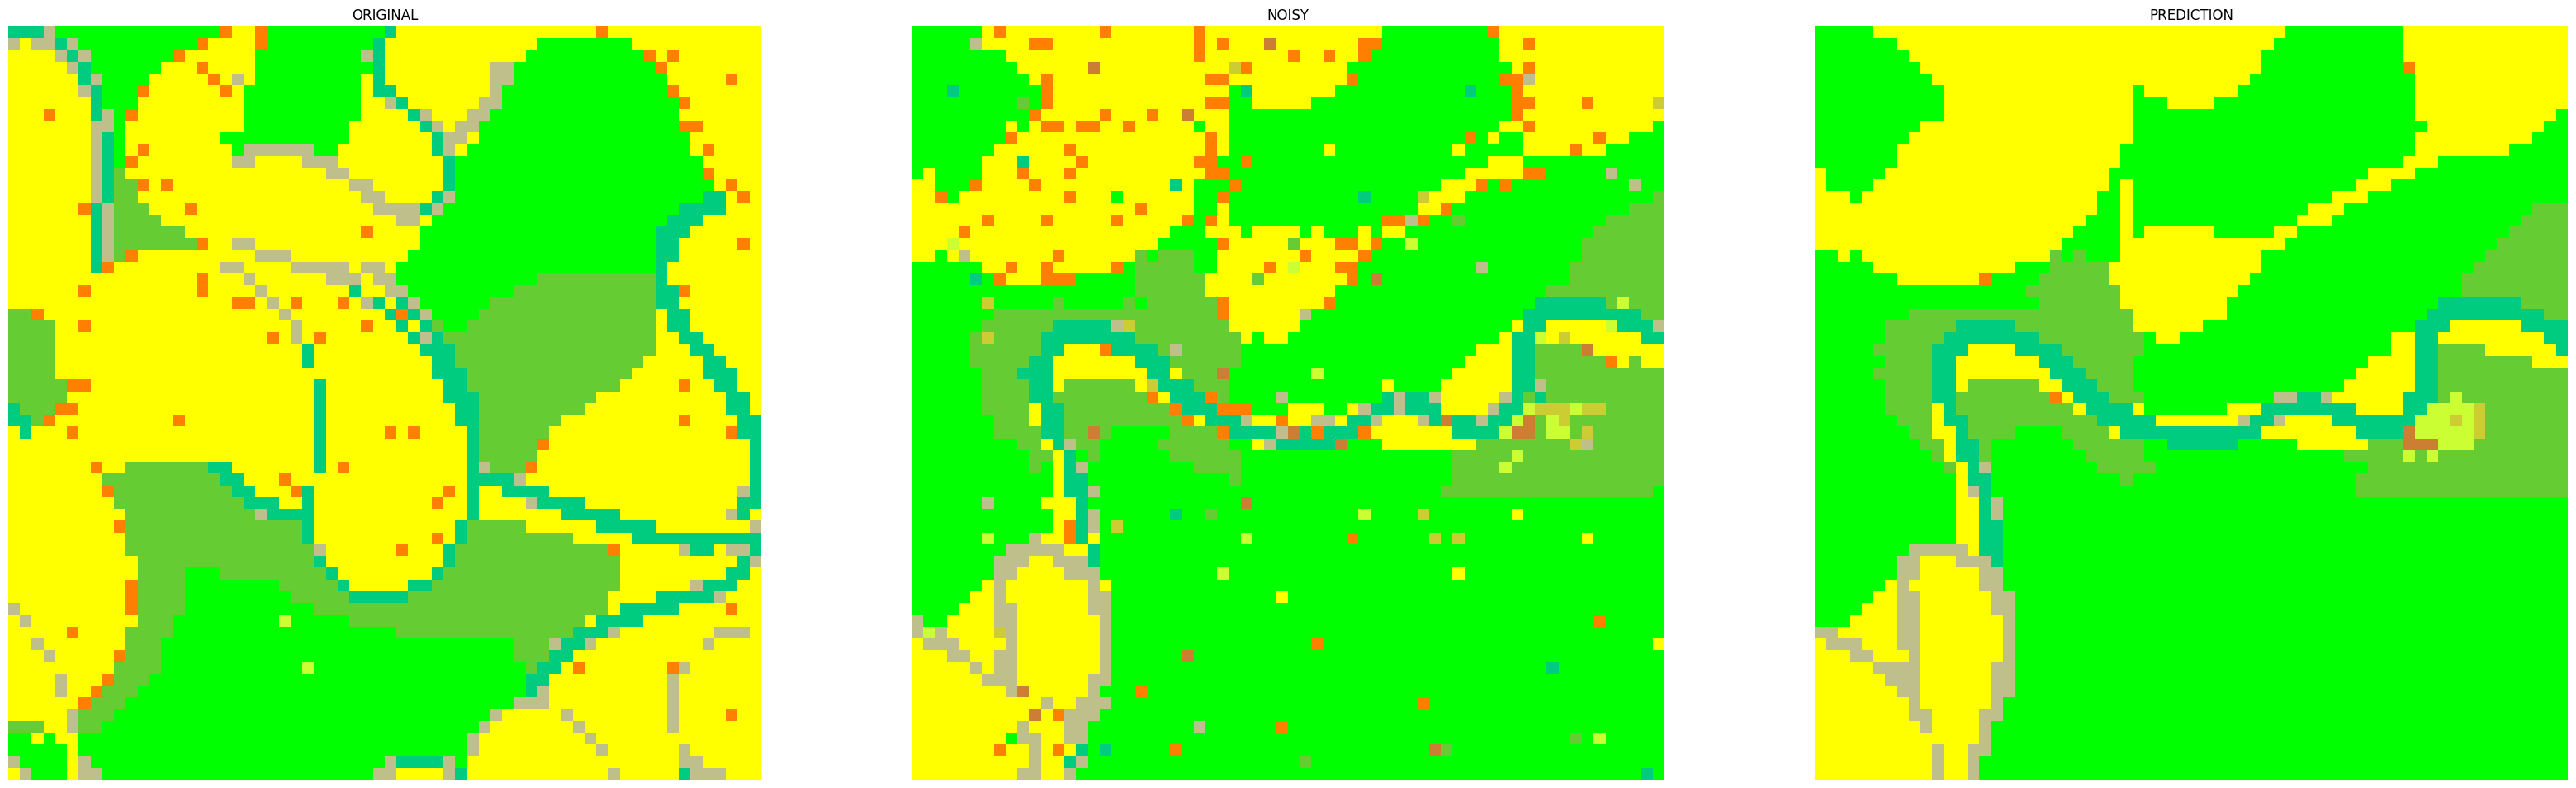

tf.Tensor([[[[0.1]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.09]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[6.55024100e-06 1.06634205e-05 5.36338635e-06 1.75578273e-06
 2.41420655e-06 1.85735227e-06 7.01858116e-06 9.99961136e-01
 3.24091650e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 89, step: 0.09


tf.Tensor([[[[0.09]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.08]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[5.60633628e-06 9.31112113e-06 4.50058061e-06 1.26914618e-06
 1.85496707e-06 1.35965066e-06 6.02371317e-06 9.99967477e-01
 2.59758059e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 90, step: 0.08


tf.Tensor([[[[0.08]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.07]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[4.80248974e-06 8.15030943e-06 3.83039027e-06 8.89544771e-07
 1.41712091e-06 9.69016774e-07 5.03020127e-06 9.99972868e-01
 2.04315942e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 91, step: 0.07


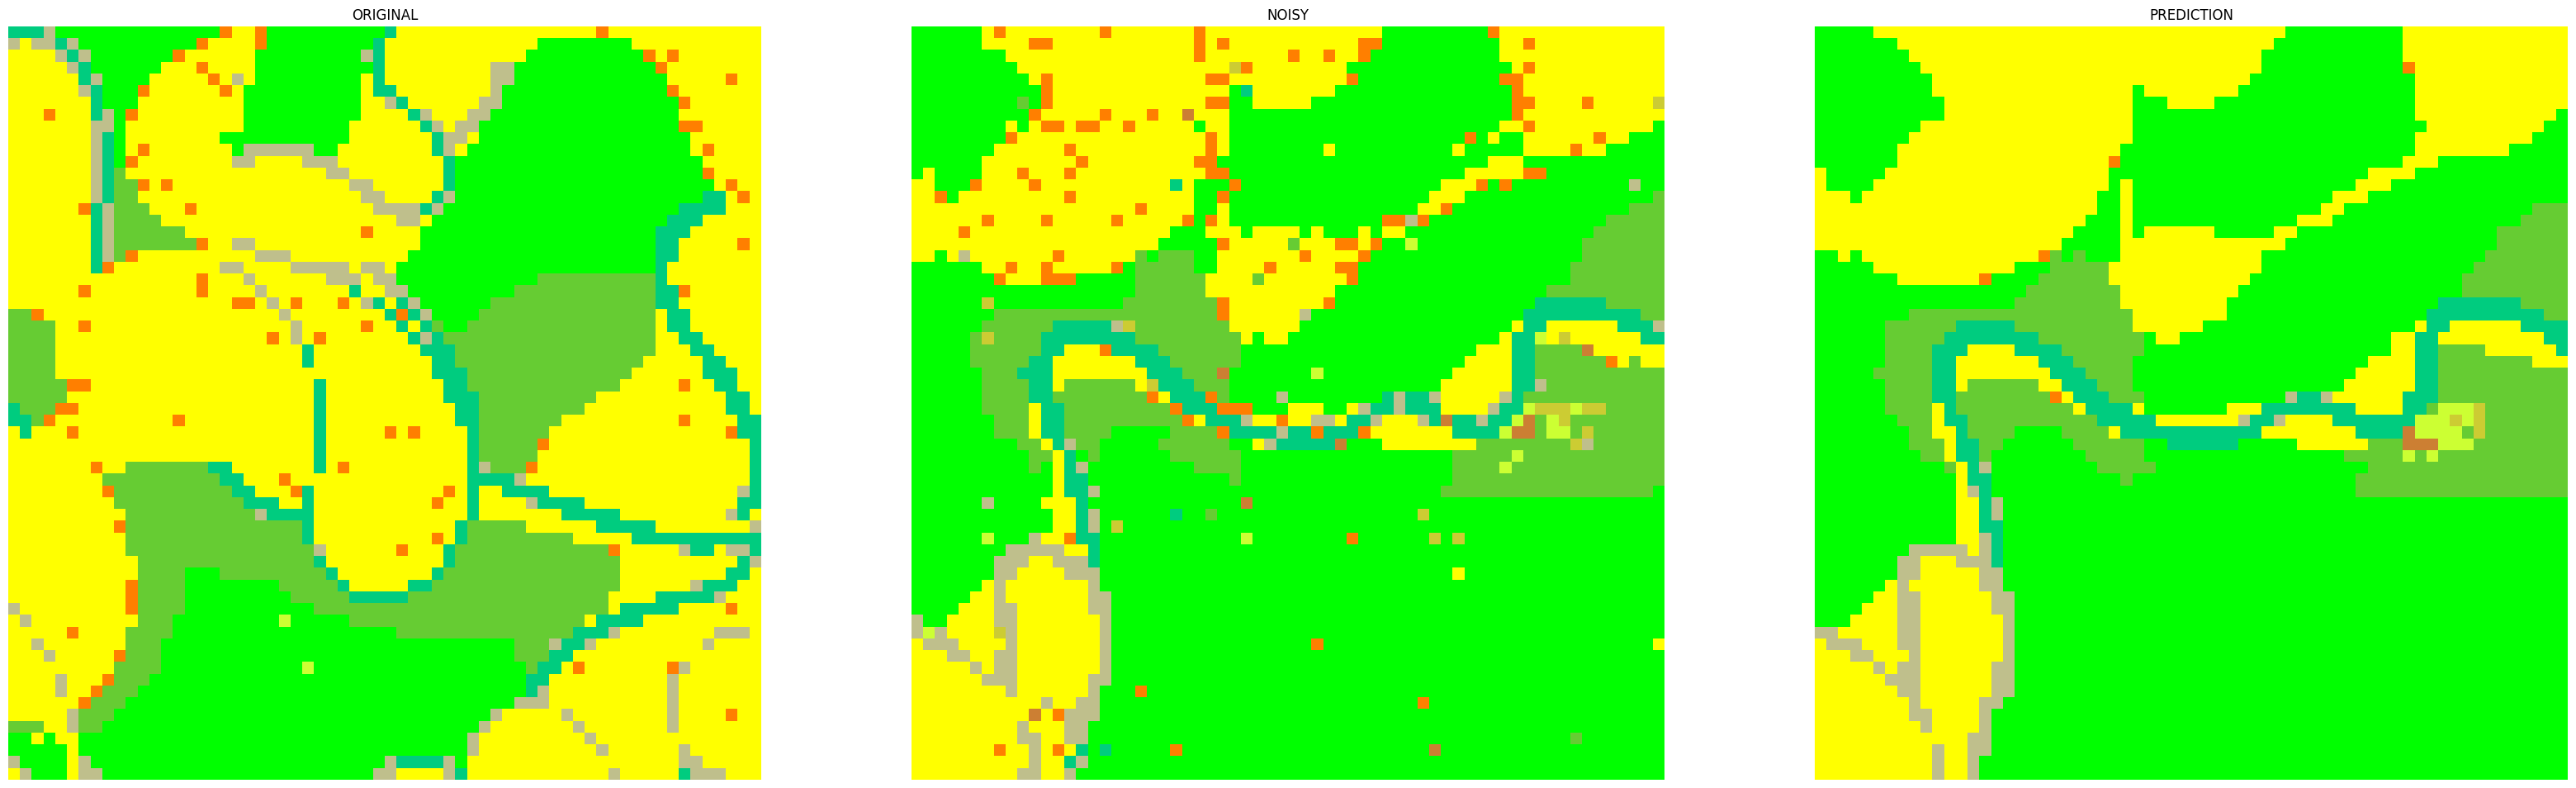

tf.Tensor([[[[0.07]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.06]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[4.11837651e-06 7.03544196e-06 3.17117135e-06 5.96123778e-07
 1.05301805e-06 6.69299288e-07 4.04975191e-06 9.99977666e-01
 1.64081510e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 92, step: 0.06


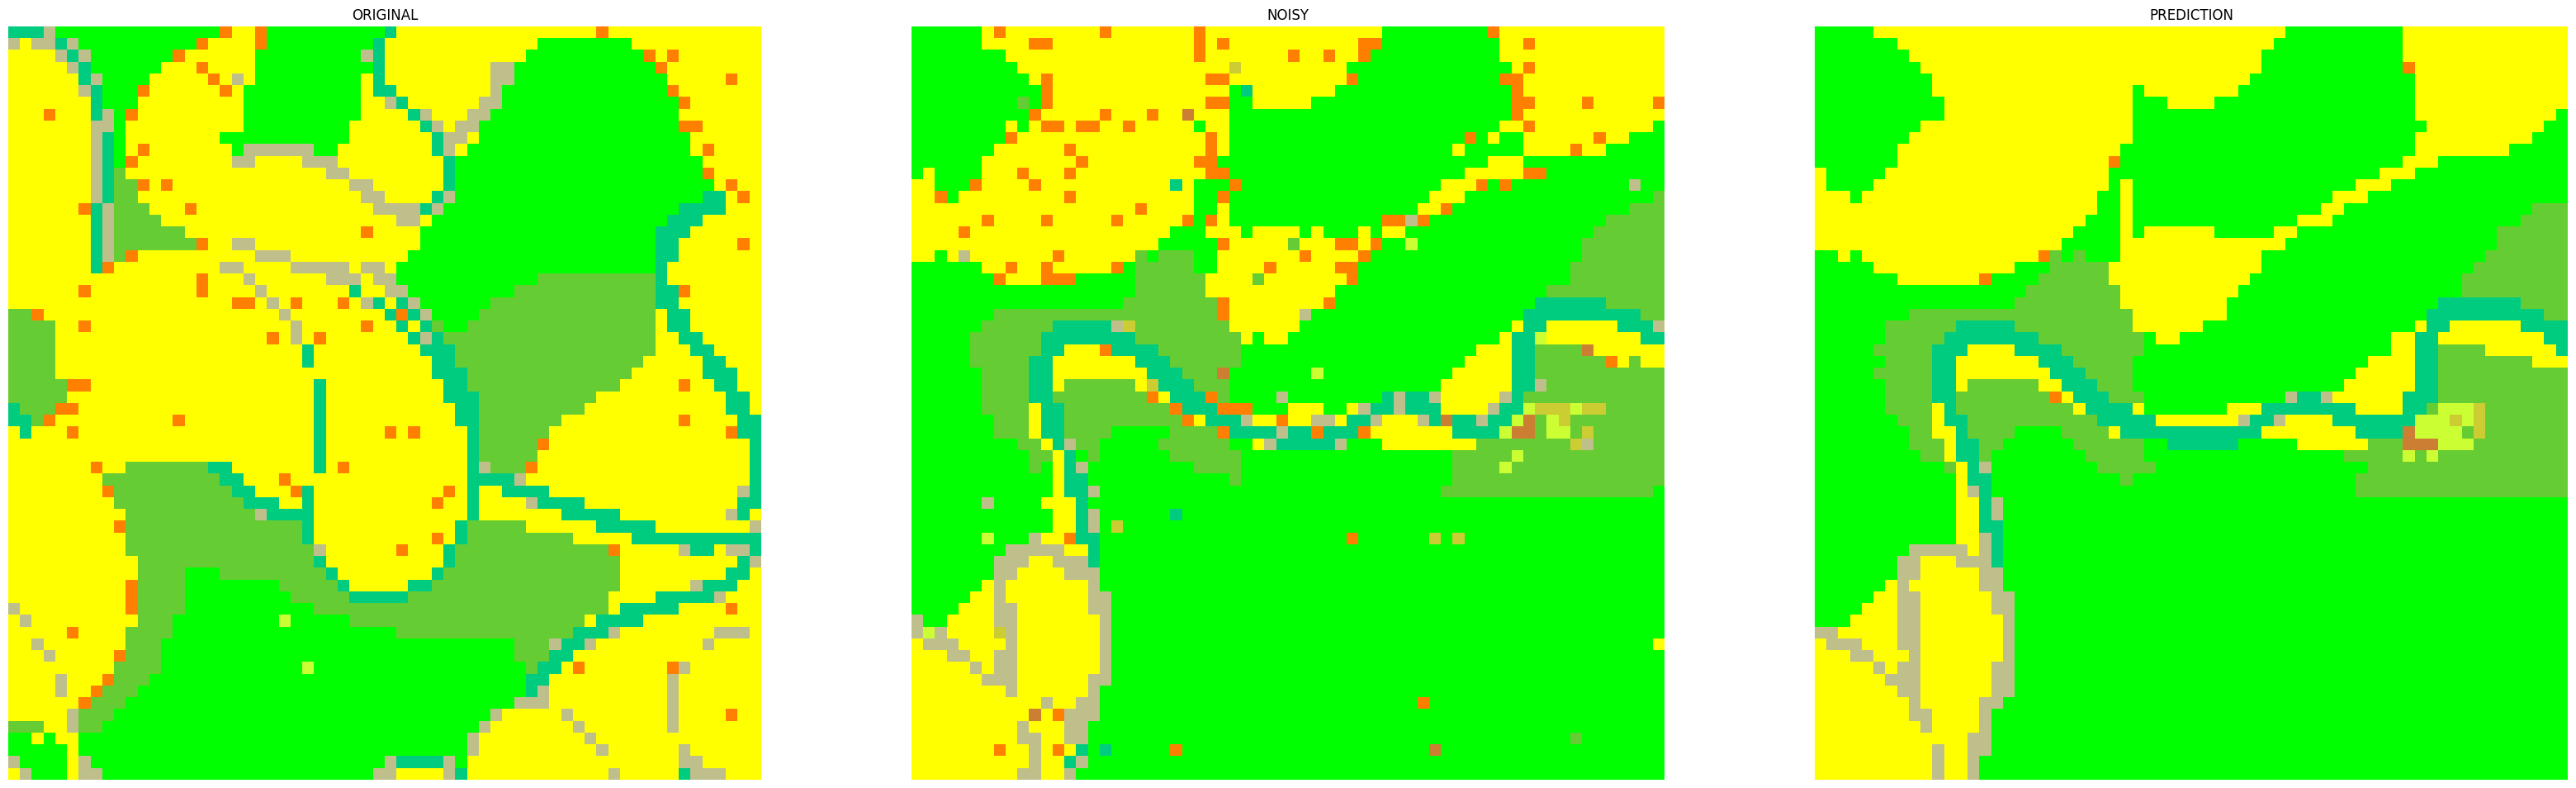

tf.Tensor([[[[0.06]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.05]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[3.38177415e-06 5.87302306e-06 2.56365033e-06 3.78762271e-07
 7.62727067e-07 4.40143808e-07 3.30800245e-06 9.99982033e-01
 1.25855355e-06], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 93, step: 0.05


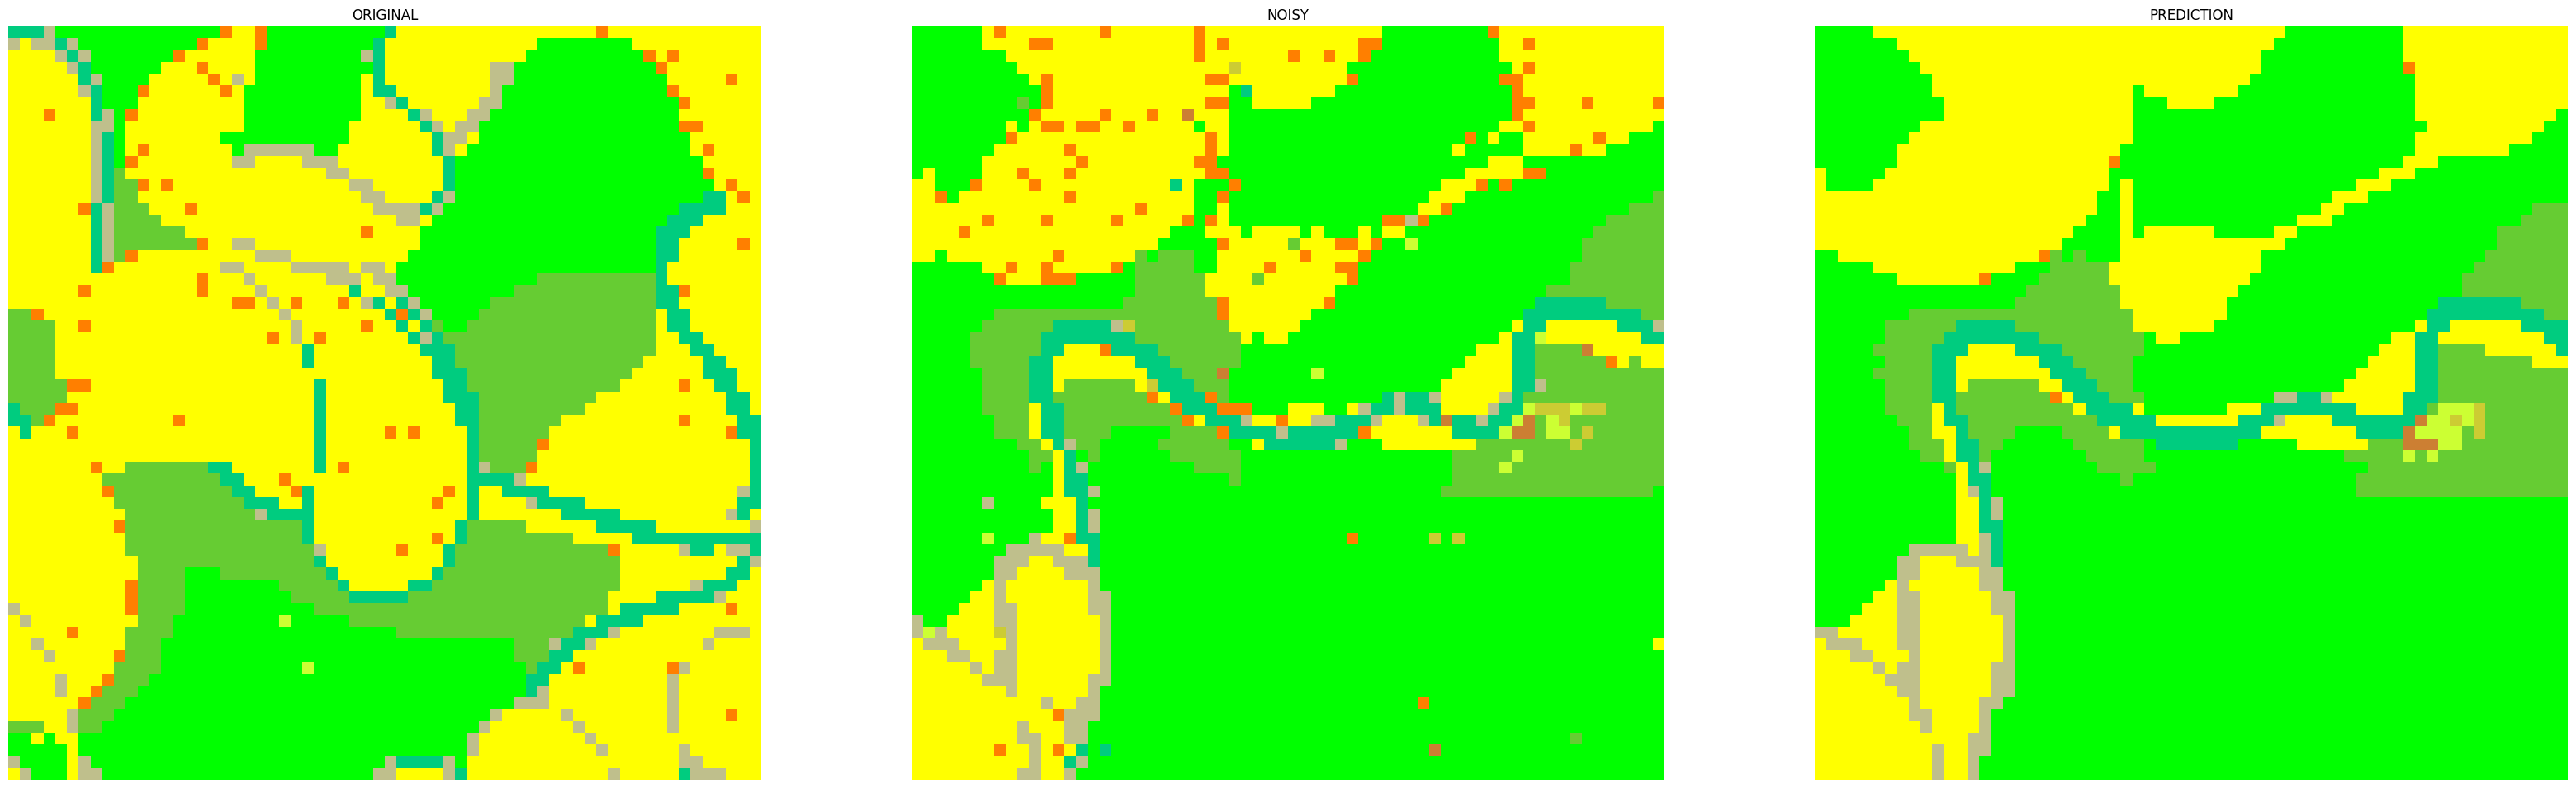

tf.Tensor([[[[0.05]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.04]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.71508971e-06 4.74358058e-06 2.02827559e-06 2.26592020e-07
 5.41381886e-07 2.77050806e-07 2.62959399e-06 9.99985883e-01
 9.55266704e-07], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 94, step: 0.04


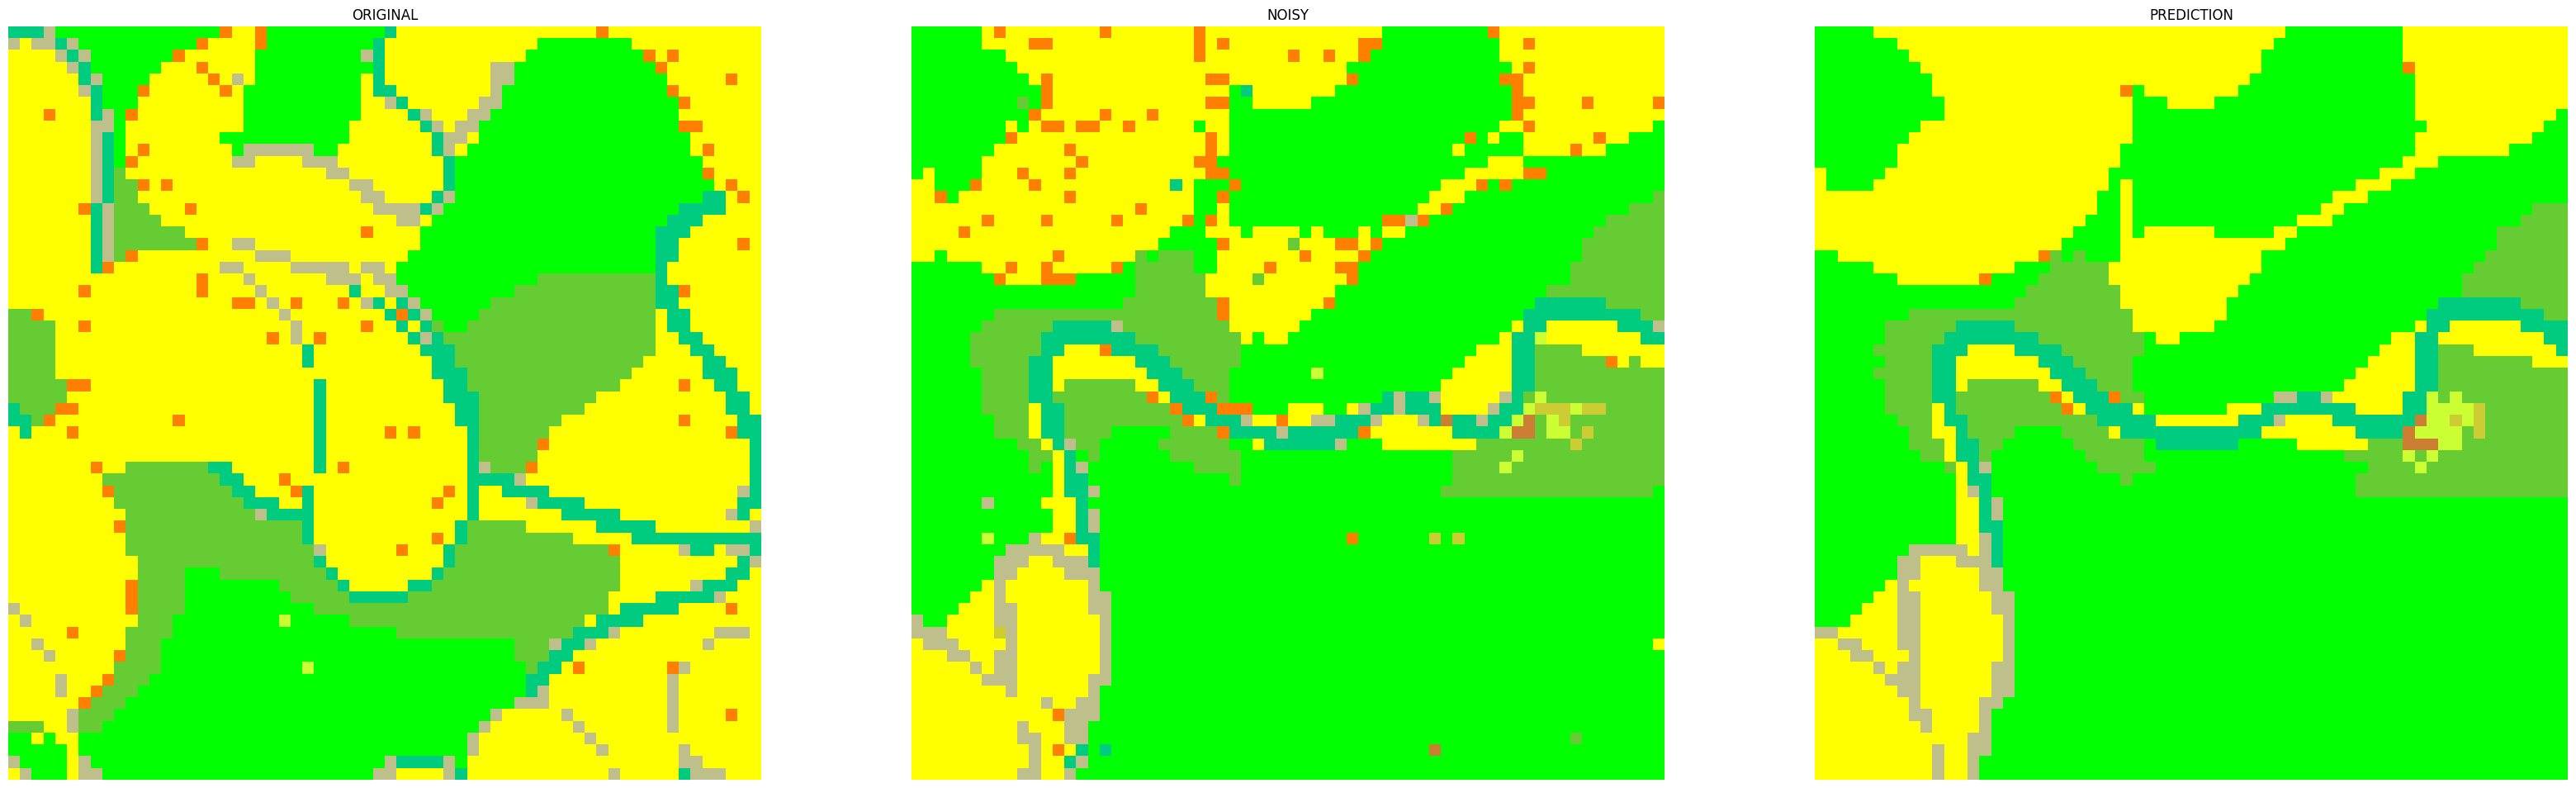

tf.Tensor([[[[0.04]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.03]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[2.06445822e-06 3.65656992e-06 1.53402402e-06 1.24719583e-07
 3.67945645e-07 1.63518628e-07 2.00113571e-06 9.99989396e-01
 6.91588369e-07], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 95, step: 0.03


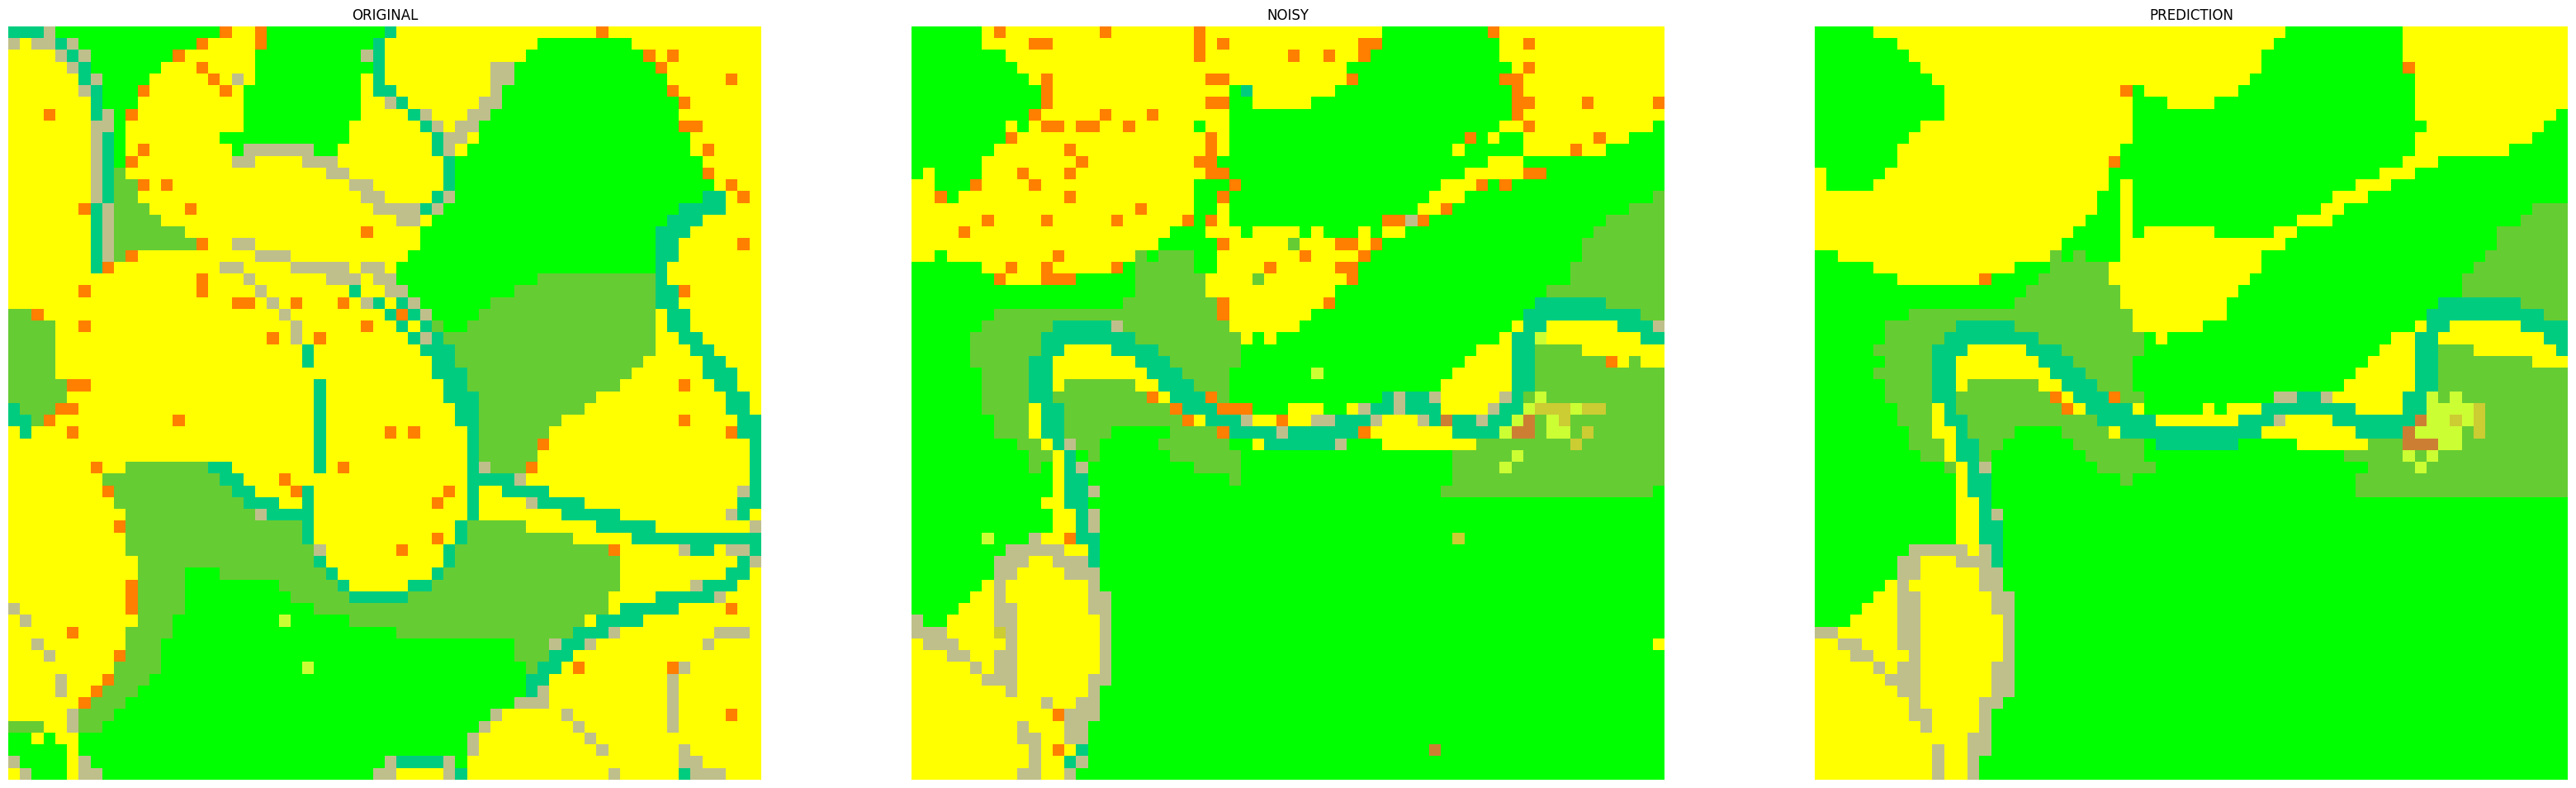

tf.Tensor([[[[0.03]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.02]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[1.46853065e-06 2.62194083e-06 1.07560798e-06 6.33587207e-08
 2.38566573e-07 9.12513548e-08 1.43173079e-06 9.99992537e-01
 4.71659398e-07], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 96, step: 0.02


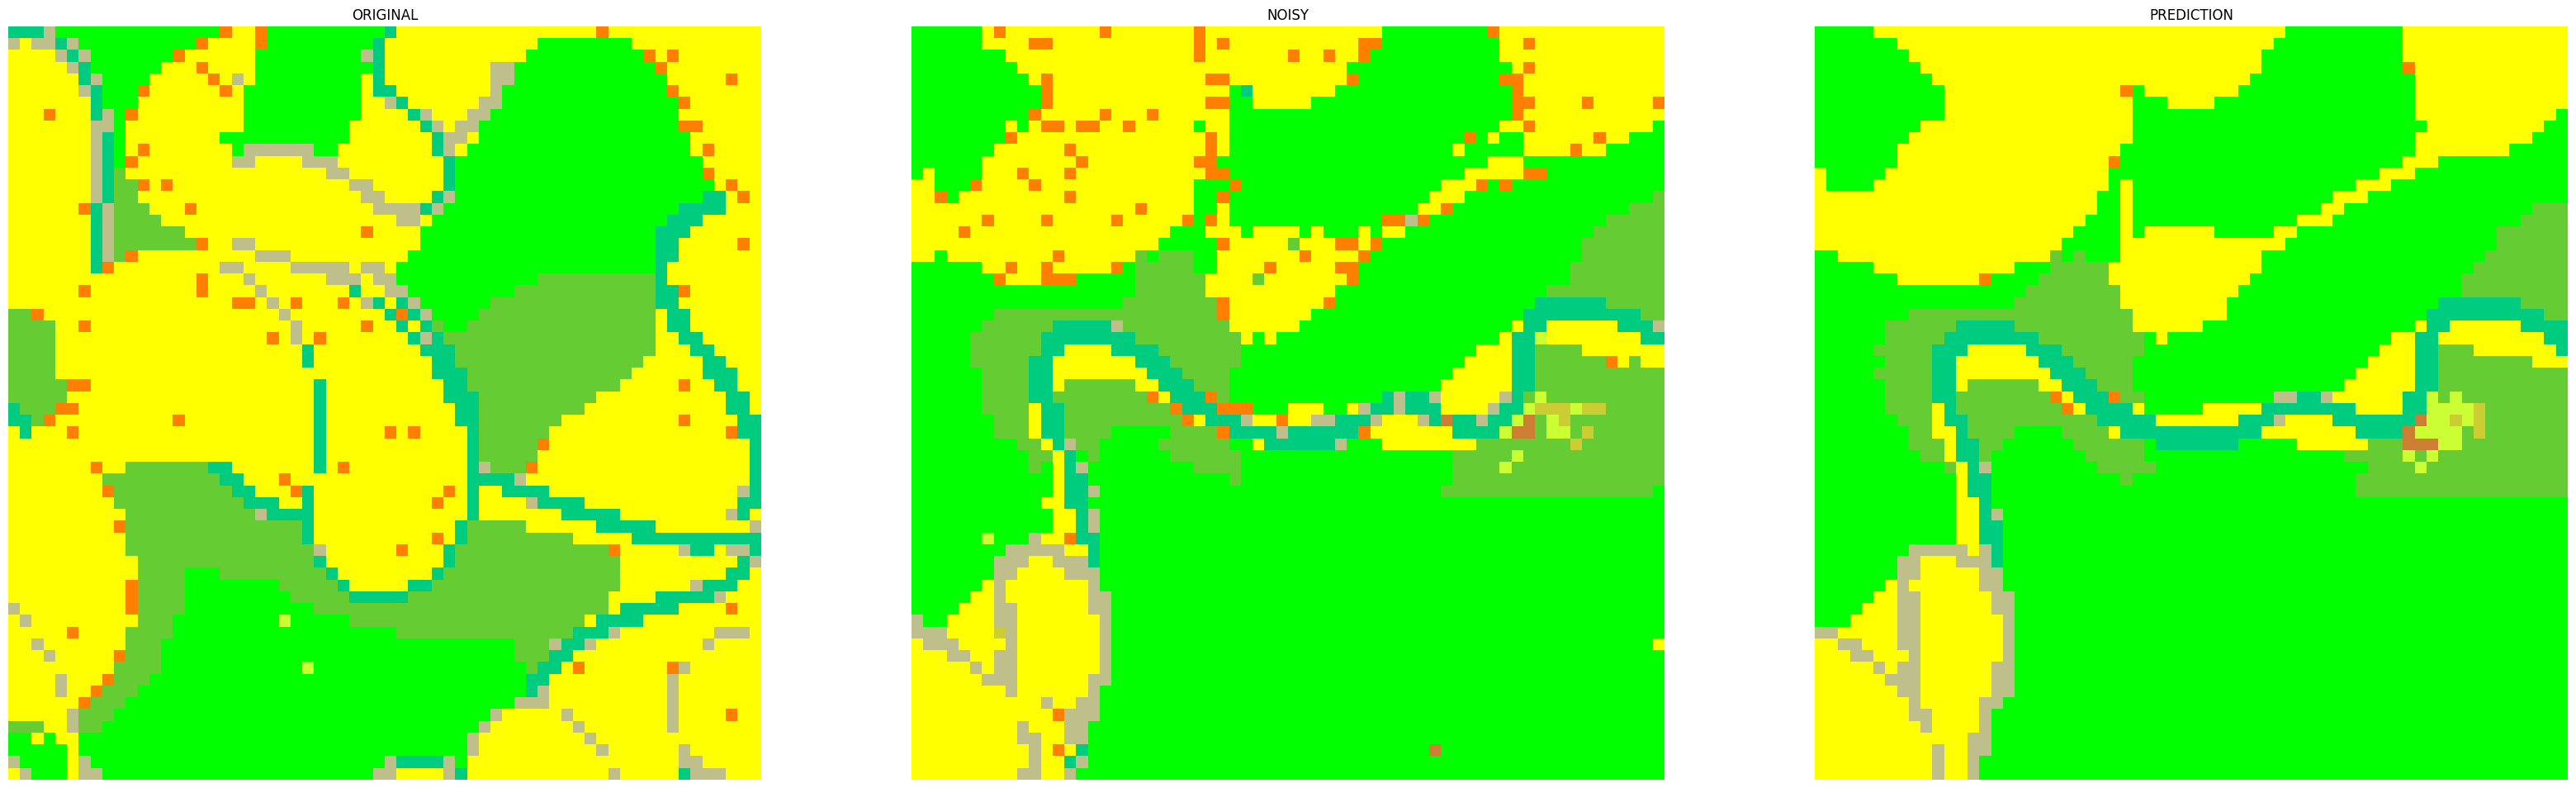

tf.Tensor([[[[0.02]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.01]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[8.95264078e-07 1.60530976e-06 6.51879391e-07 2.88181217e-08
 1.36609873e-07 4.59576725e-08 8.70771988e-07 9.99995485e-01
 2.80016835e-07], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 97, step: 0.01


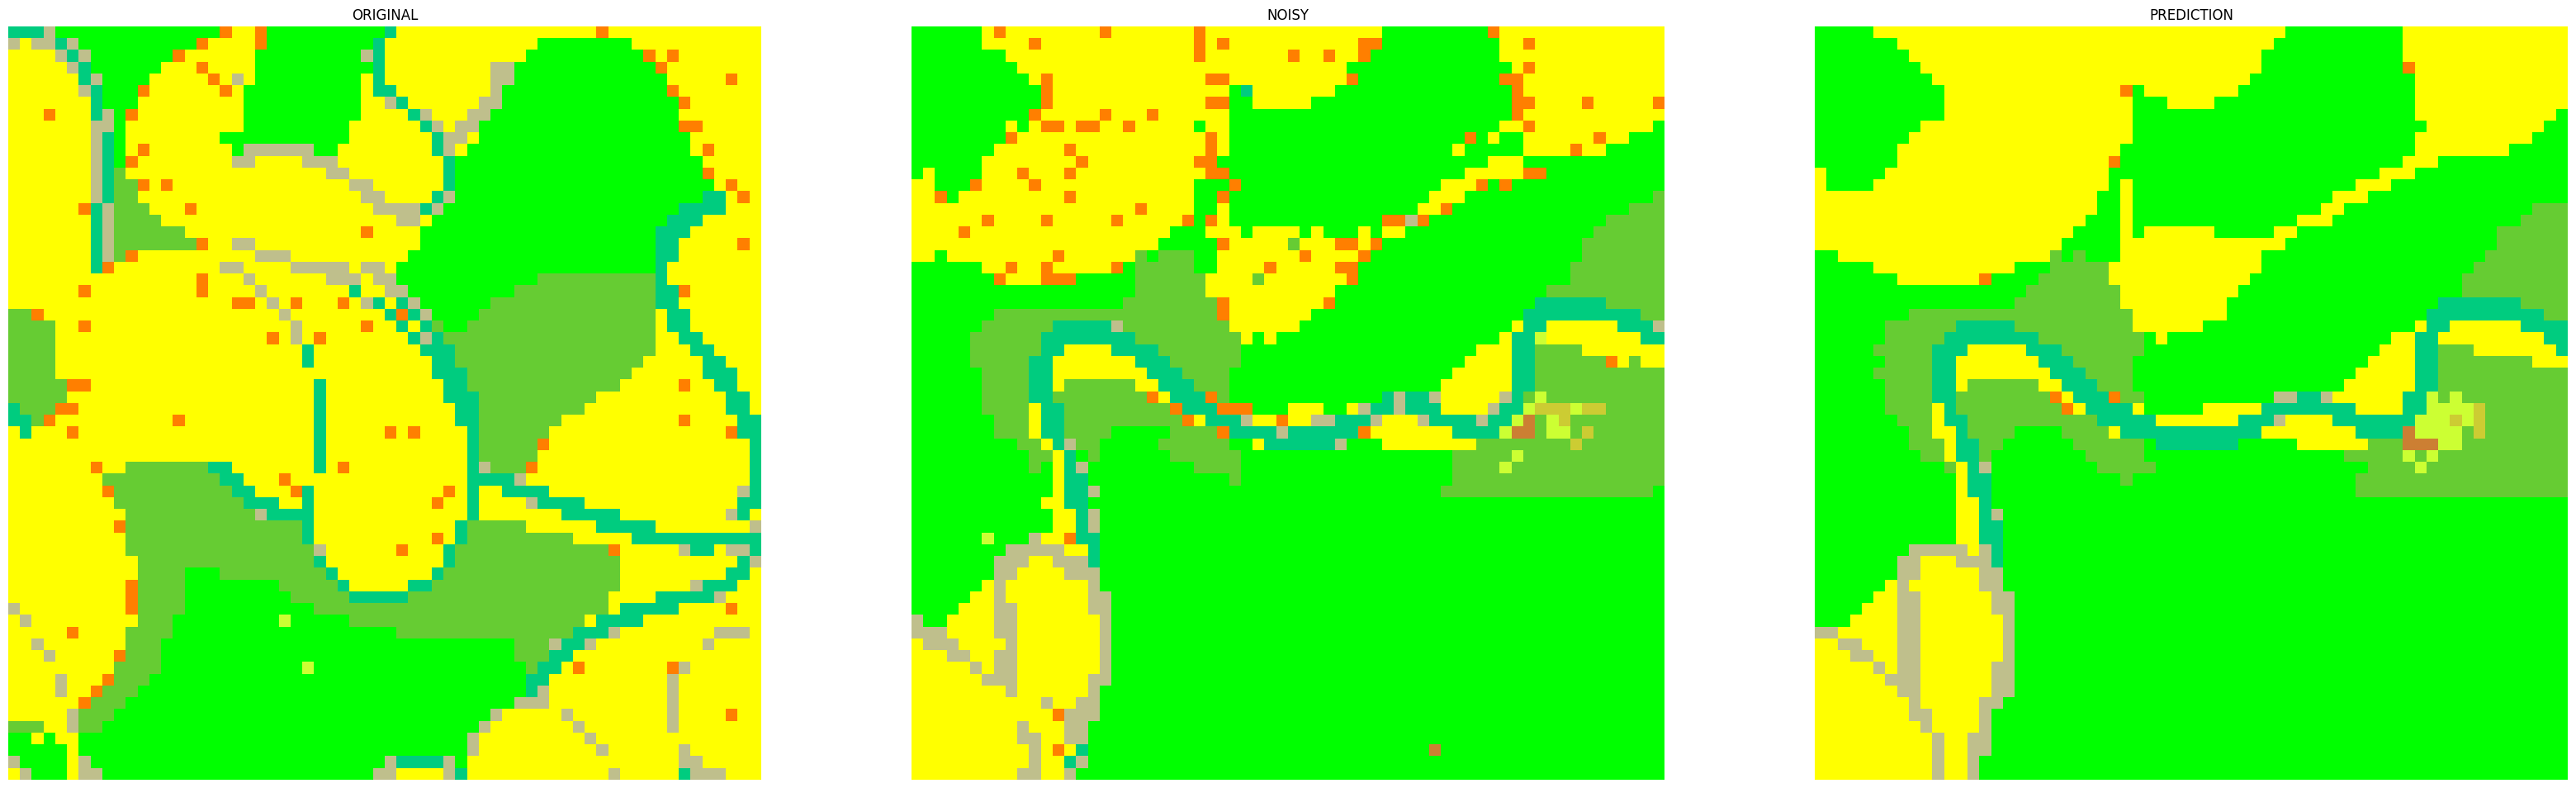

tf.Tensor([[[[0.01]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor(
[3.32698542e-07 6.00768519e-07 2.44988620e-07 9.36581939e-09
 4.98286440e-08 1.57881967e-08 3.25271408e-07 9.99998317e-01
 1.04483317e-07], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------

i: 98, step: 0.0


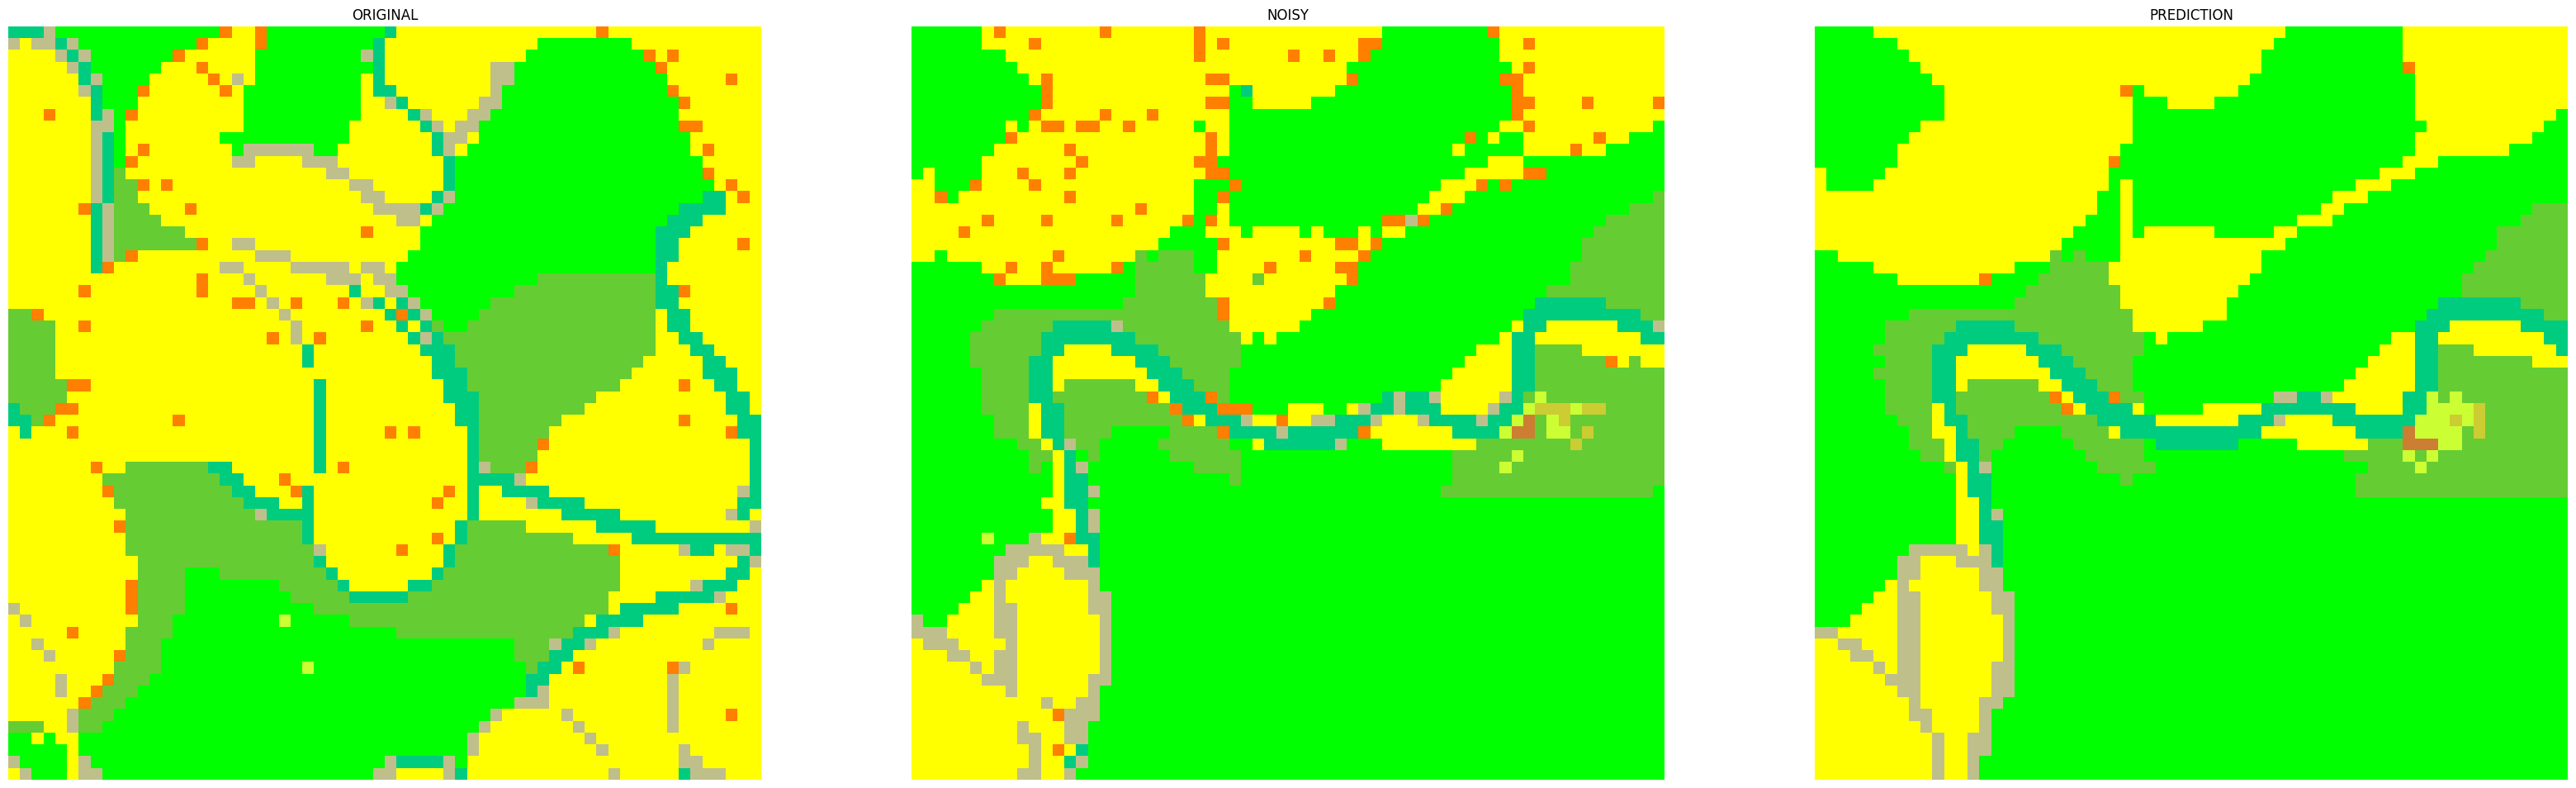

tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float64) [[[[0.99]]]]
(1, 64, 64, 9) (1, 64, 64, 9)
pxt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
new xt:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=float64)
x0:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(9,), dtype=float64)
---------------------



In [41]:
import seaborn as sns
step_size = 0.01
steps = np.arange(0, 1, step_size, dtype=np.float64)
len(steps)

init_x = tf.random.uniform((64, 64), 0, 9, dtype=tf.dtypes.int32)
init_x = keras.utils.to_categorical(init_x)
initial_noise = init_x #, _ = forward_process(x_train[5], tf.reshape(steps[99], (1, 1, 1, 1)), 9) #init_x
plt.imshow(np.argmax(initial_noise, axis=-1).reshape((64, 64)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()
num_images = initial_noise.shape[0]

total_proportions = []
all_prediction_x0 = []
all_prediction_xt = []


next_noisy_images = tf.cast(tf.expand_dims(initial_noise, axis=0), dtype=tf.float64)

for i, step in enumerate(np.flip(steps[:99])):
    print("i: {0}, step: {1}".format(i, step))
    noisy_images = next_noisy_images

    proportions = []
    for f in range(noisy_images.shape[-1]):
        sum_facies = tf.reduce_sum(noisy_images[:, :, :, f])
        mean_facies = sum_facies / (noisy_images.shape[1] * noisy_images.shape[2])
        proportions.append(mean_facies)
        
    total_proportions.append(proportions)

    input_diffusion_times = tf.reshape(steps[98 - i], (1, 1, 1, 1))

    pred_images = model.denoise(
        noisy_images, input_diffusion_times, training=False
    )
    all_prediction_x0.append(pred_images)
    all_prediction_xt.append(noisy_images)

    for j in range(1):
        plt.figure(figsize=(40, 40))
        plt.subplot(1, 2, 1)
        plt.title('NOISY')
        plt.imshow(np.argmax(noisy_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.title('PREDICTION')
        plt.imshow(np.argmax(pred_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")
        plt.show()

        
    next_diffusion_times = np.reshape(steps[98 - (i + 1)], (1, 1, 1, 1))

    pxt, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=False),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times))

    next_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times))


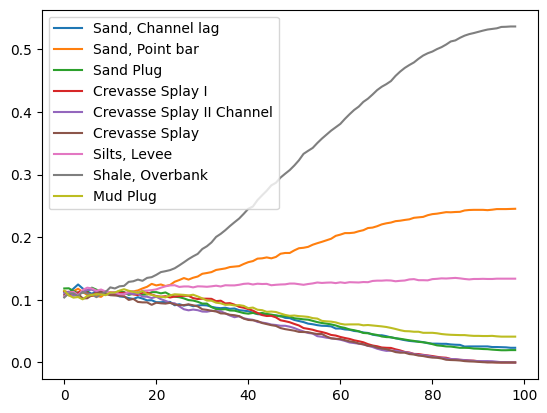

In [74]:
for i in range(9):
    plt.plot(np.array(total_proportions)[:, i], label=facies_names[i])
    plt.legend()

## Tests Proportions

(100, 64, 64, 9)


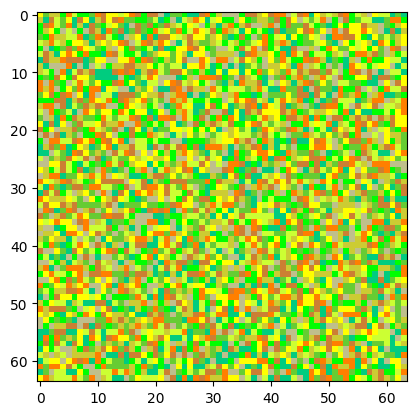

100%|███████████████████████████████████████████| 99/99 [06:28<00:00,  3.92s/it]


In [187]:
from tqdm.autonotebook import tqdm

step_size = 0.002
steps = np.arange(0, 1, step_size, dtype=np.float64)
num_images = 100

total_real_proportions = []
all_real_prediction_x0 = []
all_real_prediction_xt = []

total_proportions = []
all_prediction_x0 = []
all_prediction_xt = []

x0_real = x_test[:num_images]


x0_real = tf.cast(x0_real, dtype=tf.float64)

init_x_real = tf.random.uniform((num_images, 64, 64), 0, 9, dtype=tf.dtypes.int32)
init_x_real = keras.utils.to_categorical(init_x_real)

init_x = tf.random.uniform((num_images, 64, 64), 0, 9, dtype=tf.dtypes.int32)
init_x = keras.utils.to_categorical(init_x)

next_noisy_images = tf.cast(init_x, dtype=tf.float64)
next_real_noisy_images = tf.cast(init_x_real, dtype=tf.float64)

for i, step in enumerate(tqdm(np.flip(steps[:99]))):
    noisy_images = next_noisy_images
    real_noisy_images = next_real_noisy_images
    
    proportions = []
    for f in range(noisy_images.shape[-1]):
        
        sum_facies = tf.reduce_sum(noisy_images[:, :, :, f], axis=[1, 2])
        mean_facies = sum_facies / (noisy_images.shape[1] * noisy_images.shape[2])
        proportions.append(mean_facies)
        
    total_proportions.append(proportions)

    proportions = []
    for f in range(real_noisy_images.shape[-1]):
        sum_facies = tf.reduce_sum(real_noisy_images[:, :, :, f], axis=[1, 2])
        mean_facies = sum_facies / (real_noisy_images.shape[1] * real_noisy_images.shape[2])
        proportions.append(mean_facies)
        
    total_real_proportions.append(proportions)
    
    # separate the current noisy image to its components
    input_diffusion_times = steps[98 - i] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)

    pred_images = model.denoise(
        noisy_images, input_diffusion_times, training=False
    )

        
    next_diffusion_times = steps[98 - (i + 1)] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)

    next_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times), parallel_iterations=64)

    next_real_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (x0_real, real_noisy_images, input_diffusion_times, next_diffusion_times), parallel_iterations=64)

In [199]:
x = load_data(image_size[0], image_size[1], "./data/horizontal/dataFlumyHoriz_9facies.csv", sep=" ")

In [181]:
# Compute Mean and std facies for dataset
real_mean_facies = []
real_std_facies = []
for f in range(9):
    mean_facies = x[:, :, :, f].mean()
    real_mean_facies.append(mean_facies)
    
    std_facies = x[:, :, :, f].std()
    real_std_facies.append(std_facies)

([0.021097412,
  0.4442778,
  0.071064256,
  1.6137696e-05,
  0.00082907715,
  8.649902e-05,
  0.12860307,
  0.28149694,
  0.052529052],
 [0.14370915,
  0.49688527,
  0.25693214,
  0.004017116,
  0.028781887,
  0.009300077,
  0.33475992,
  0.44972965,
  0.22309127])

/home/fbhavsar/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fbhavsar/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fbhavsar/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fbhavsar/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

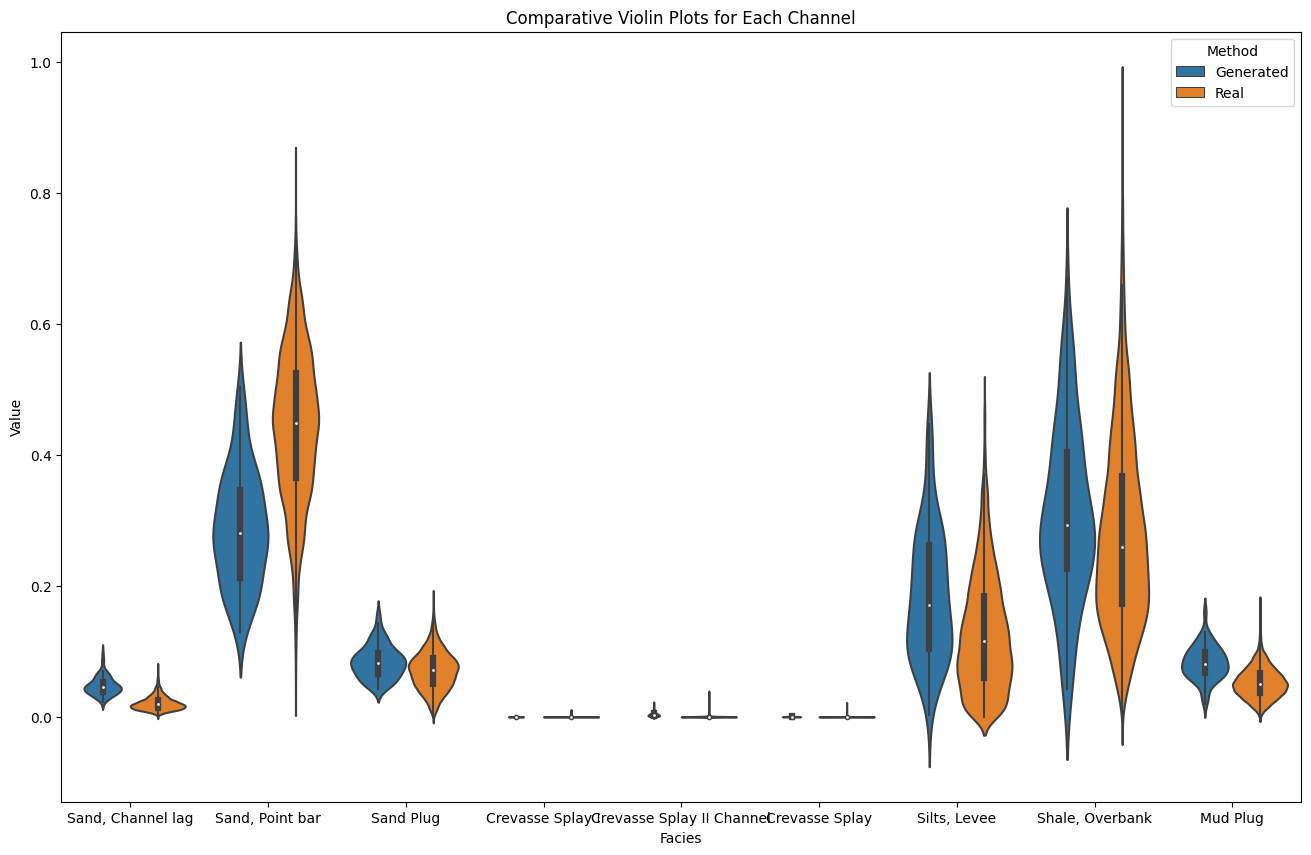

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
array1 = total_generated_proportions.T  # First array of size (100, 9)
array2 = toal_dataset_proportions.T  # Second array of size (1000, 9)

# Combine the arrays into a single DataFrame for plotting
# We will also add a column to indicate which array the data came from

# Create DataFrame for first array
df1 = pd.DataFrame(array1, columns=[facies_names[i] for i in range(array1.shape[1])])
df1['Method'] = 'Generated'

# Create DataFrame for second array
df2 = pd.DataFrame(array2, columns=[facies_names[i] for i in range(array2.shape[1])])
df2['Method'] = 'Real'

# Combine the two DataFrames
df = pd.concat([df1, df2])

# Melt the DataFrame to have one column for channels and one for values
df_melted = df.melt(id_vars=['Method'], var_name='Facies', value_name='Value')

# Plot the violin plots
plt.figure(figsize=(16, 10))
sns.violinplot(x='Facies', y='Value', hue='Method', data=df_melted, split=False)
plt.title('Comparative Violin Plots for Each Channel')
plt.show()


In [209]:
total_generated_proportions = np.array(total_proportions[-1])
total_generated_proportions.shape

(9, 100)

(99, 9)
(99,) (99,)
(99,) (99,)


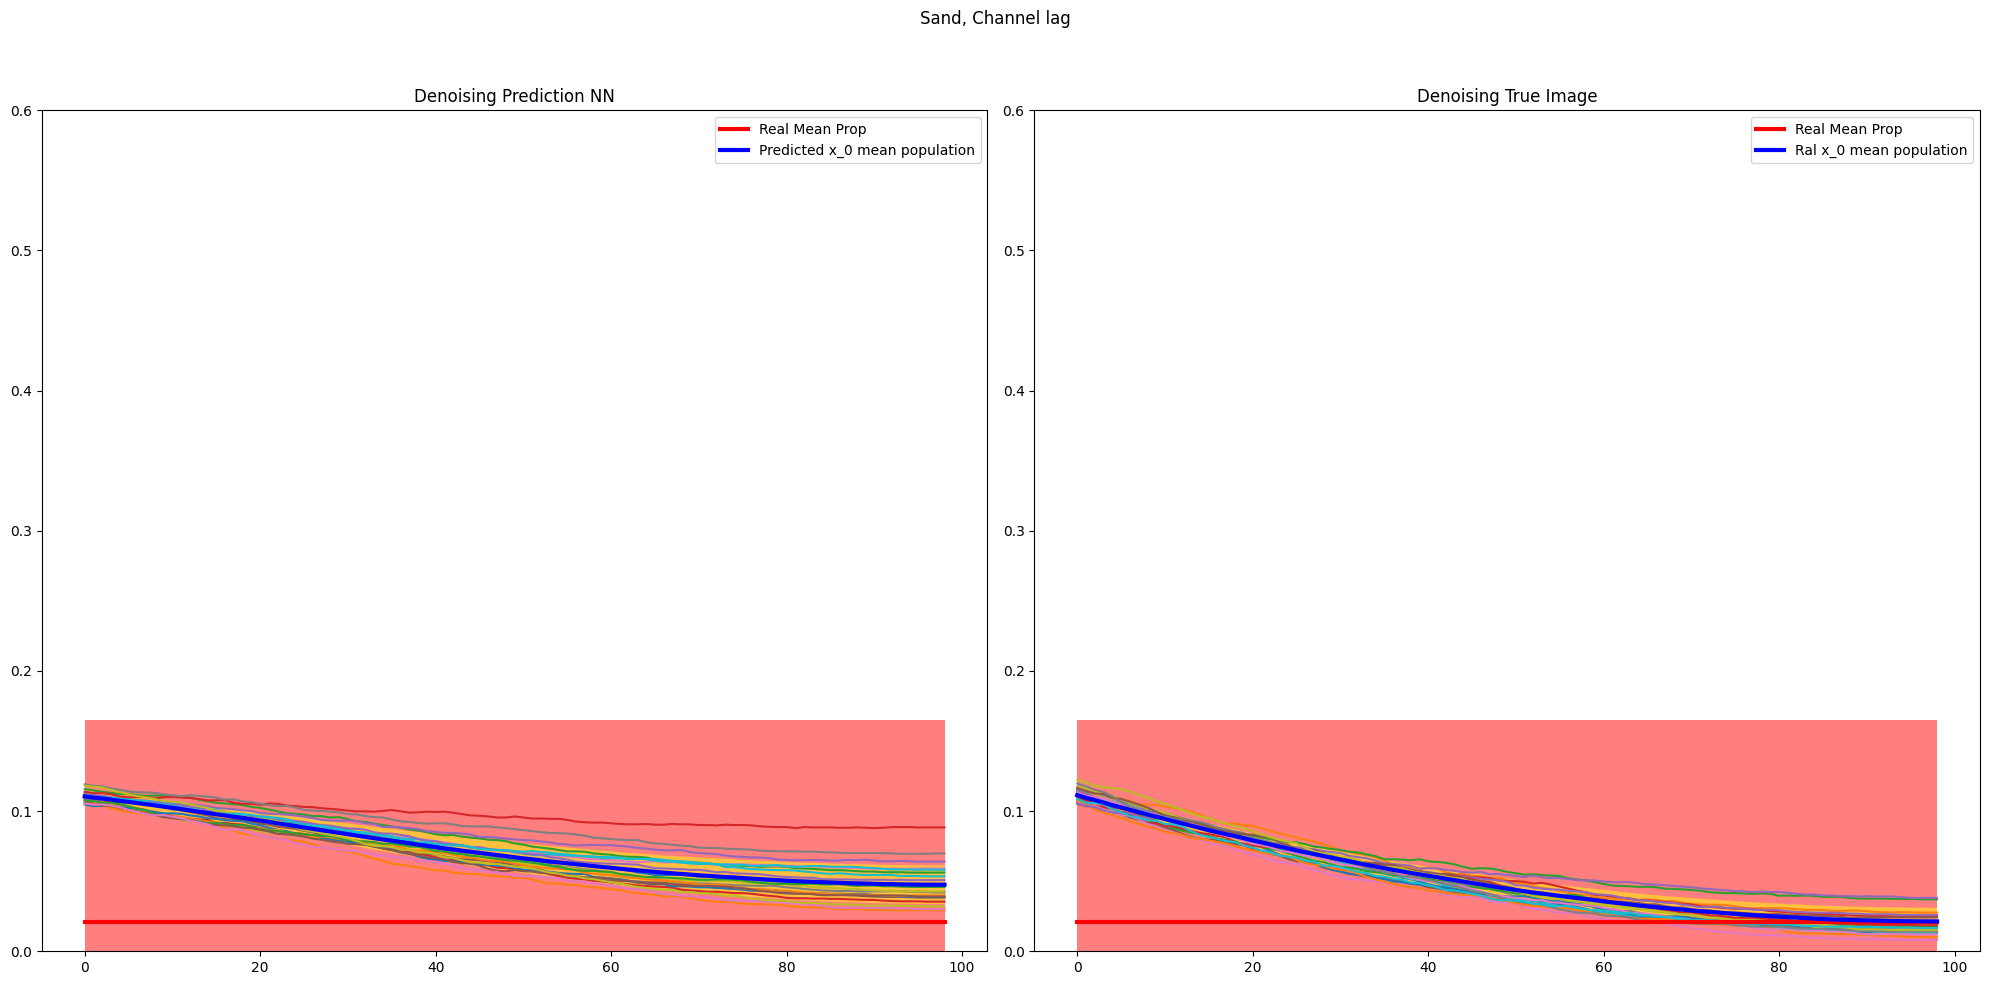

(99,) (99,)
(99,) (99,)


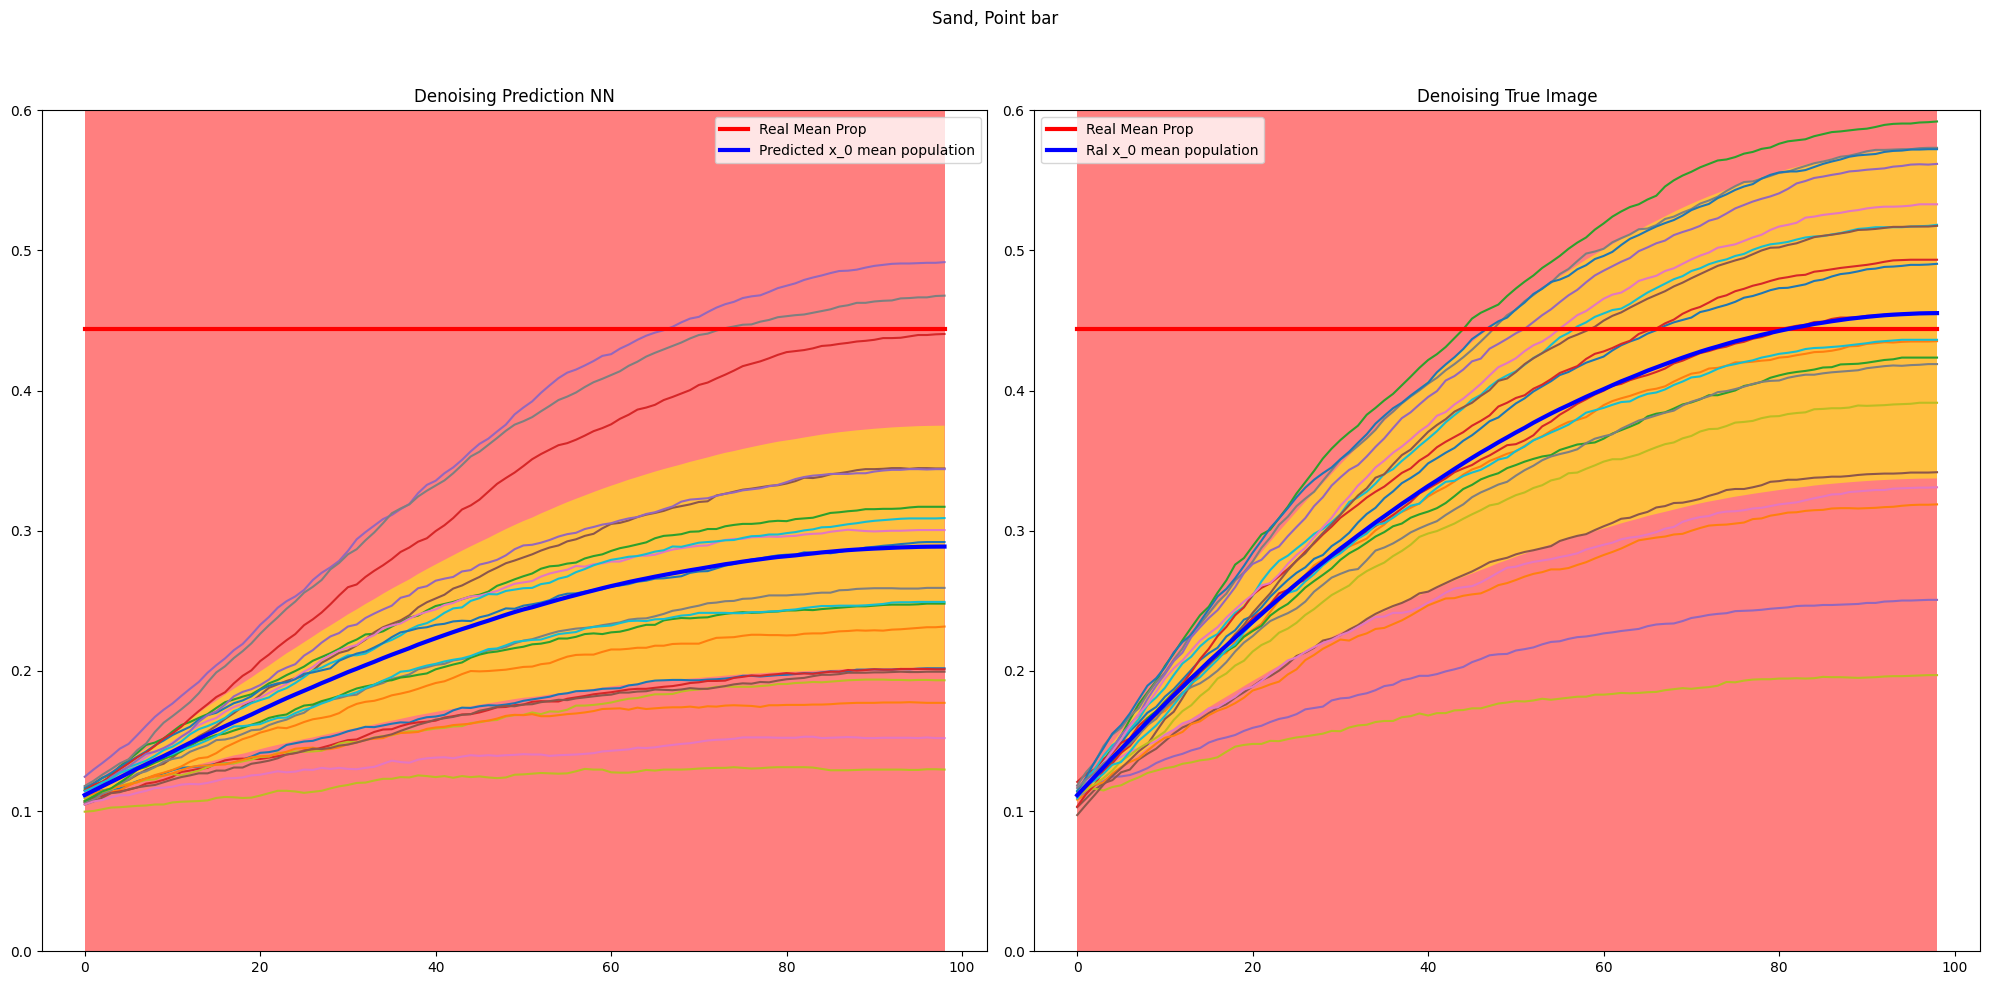

(99,) (99,)
(99,) (99,)


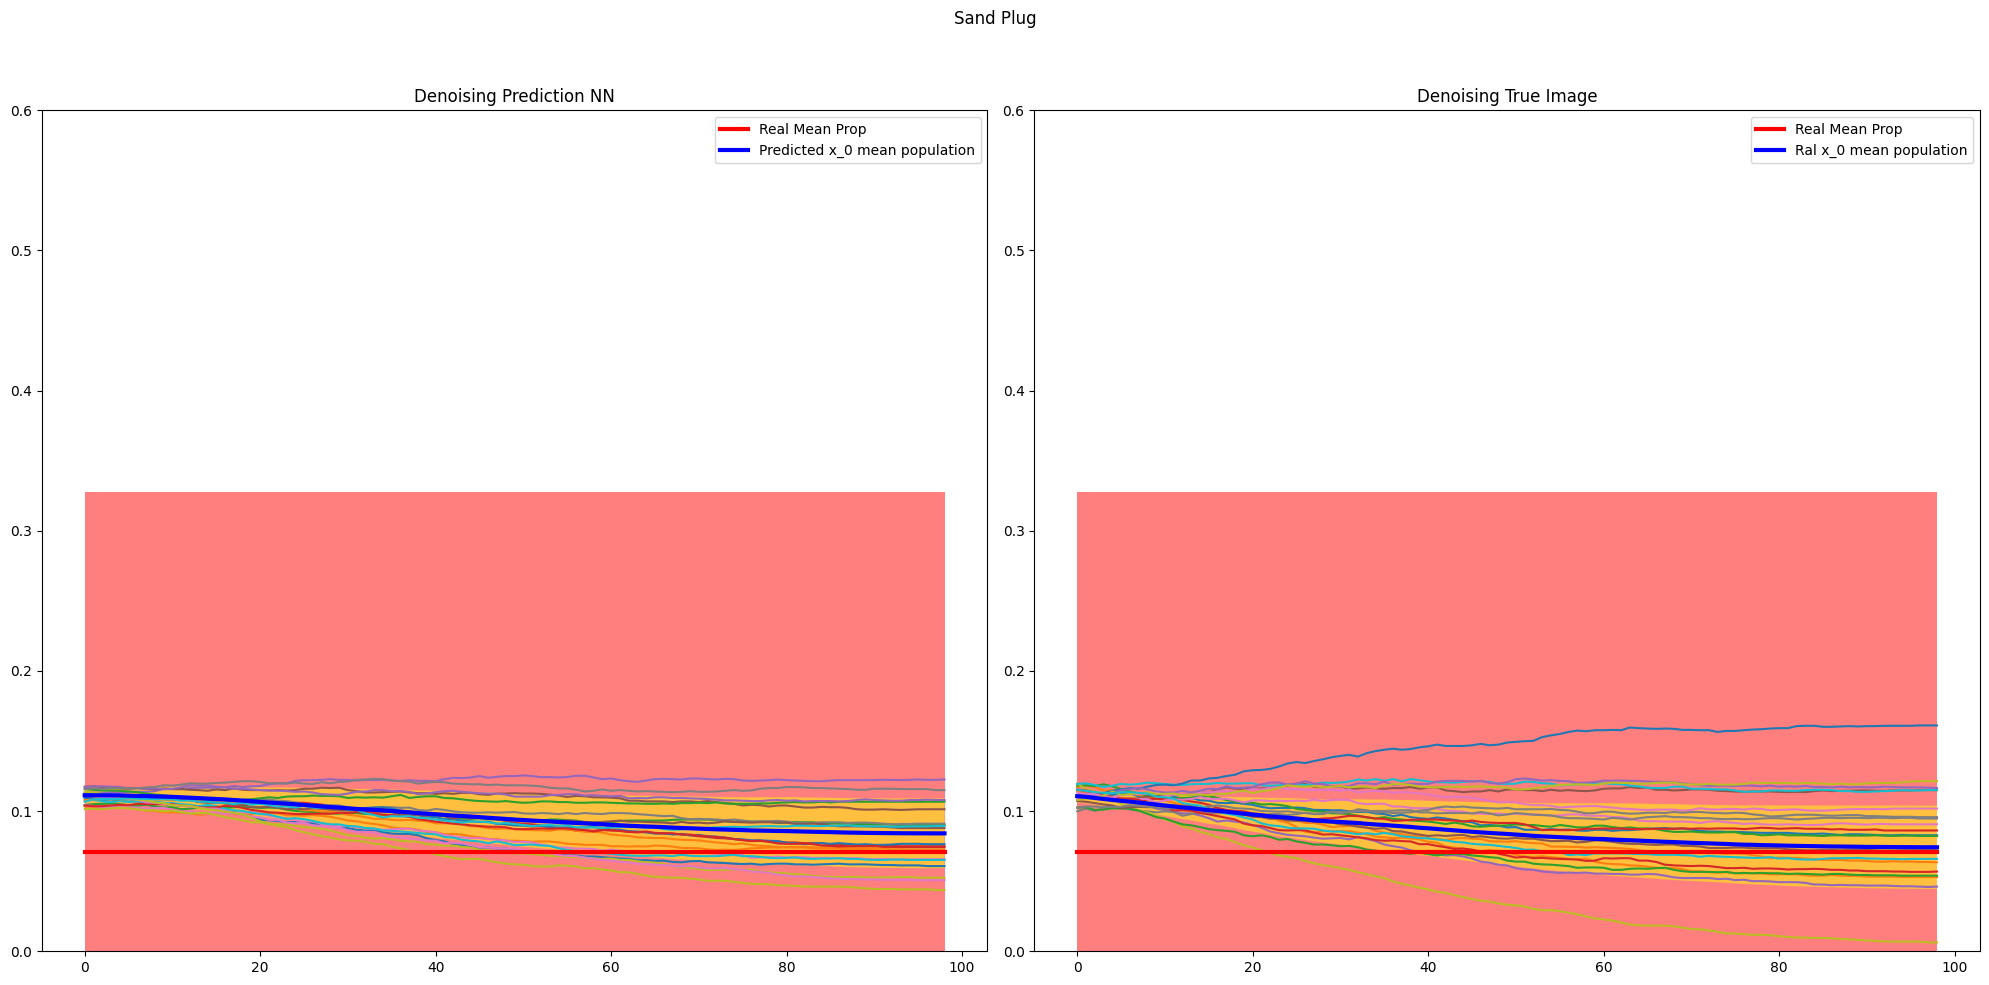

(99,) (99,)
(99,) (99,)


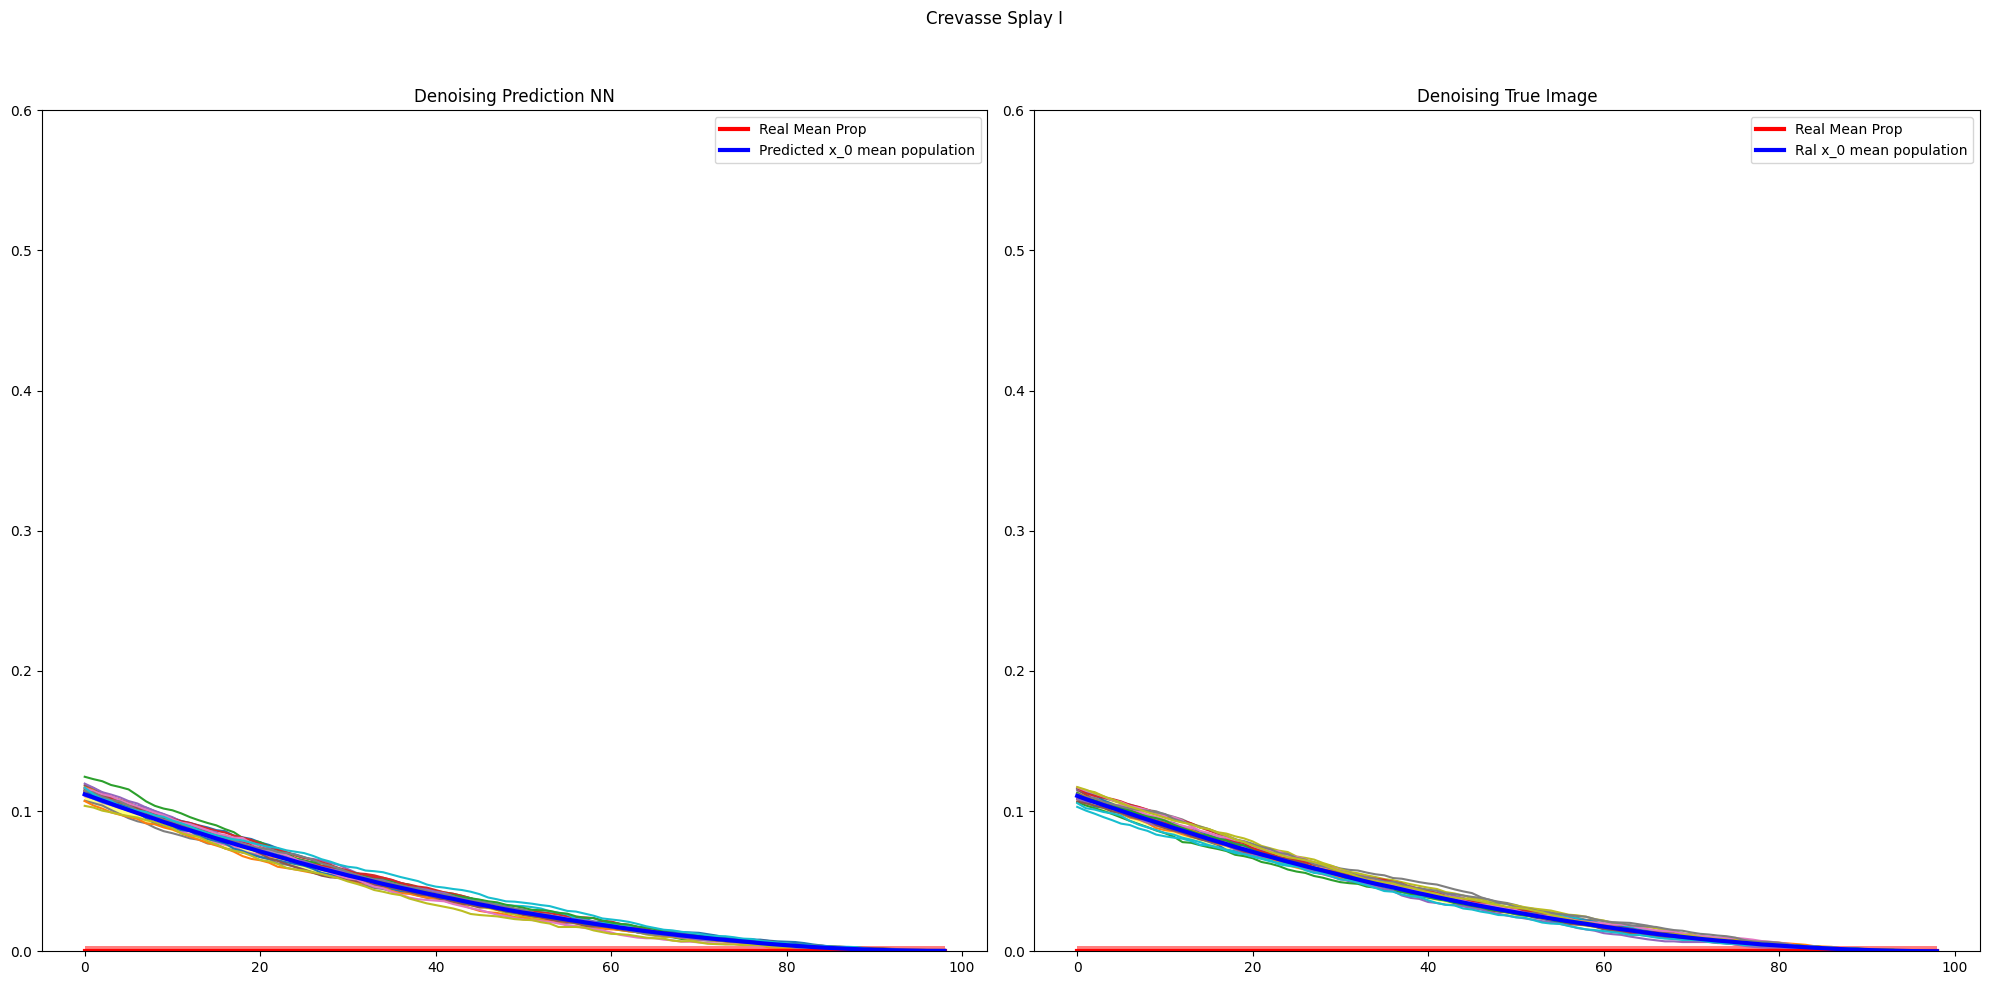

(99,) (99,)
(99,) (99,)


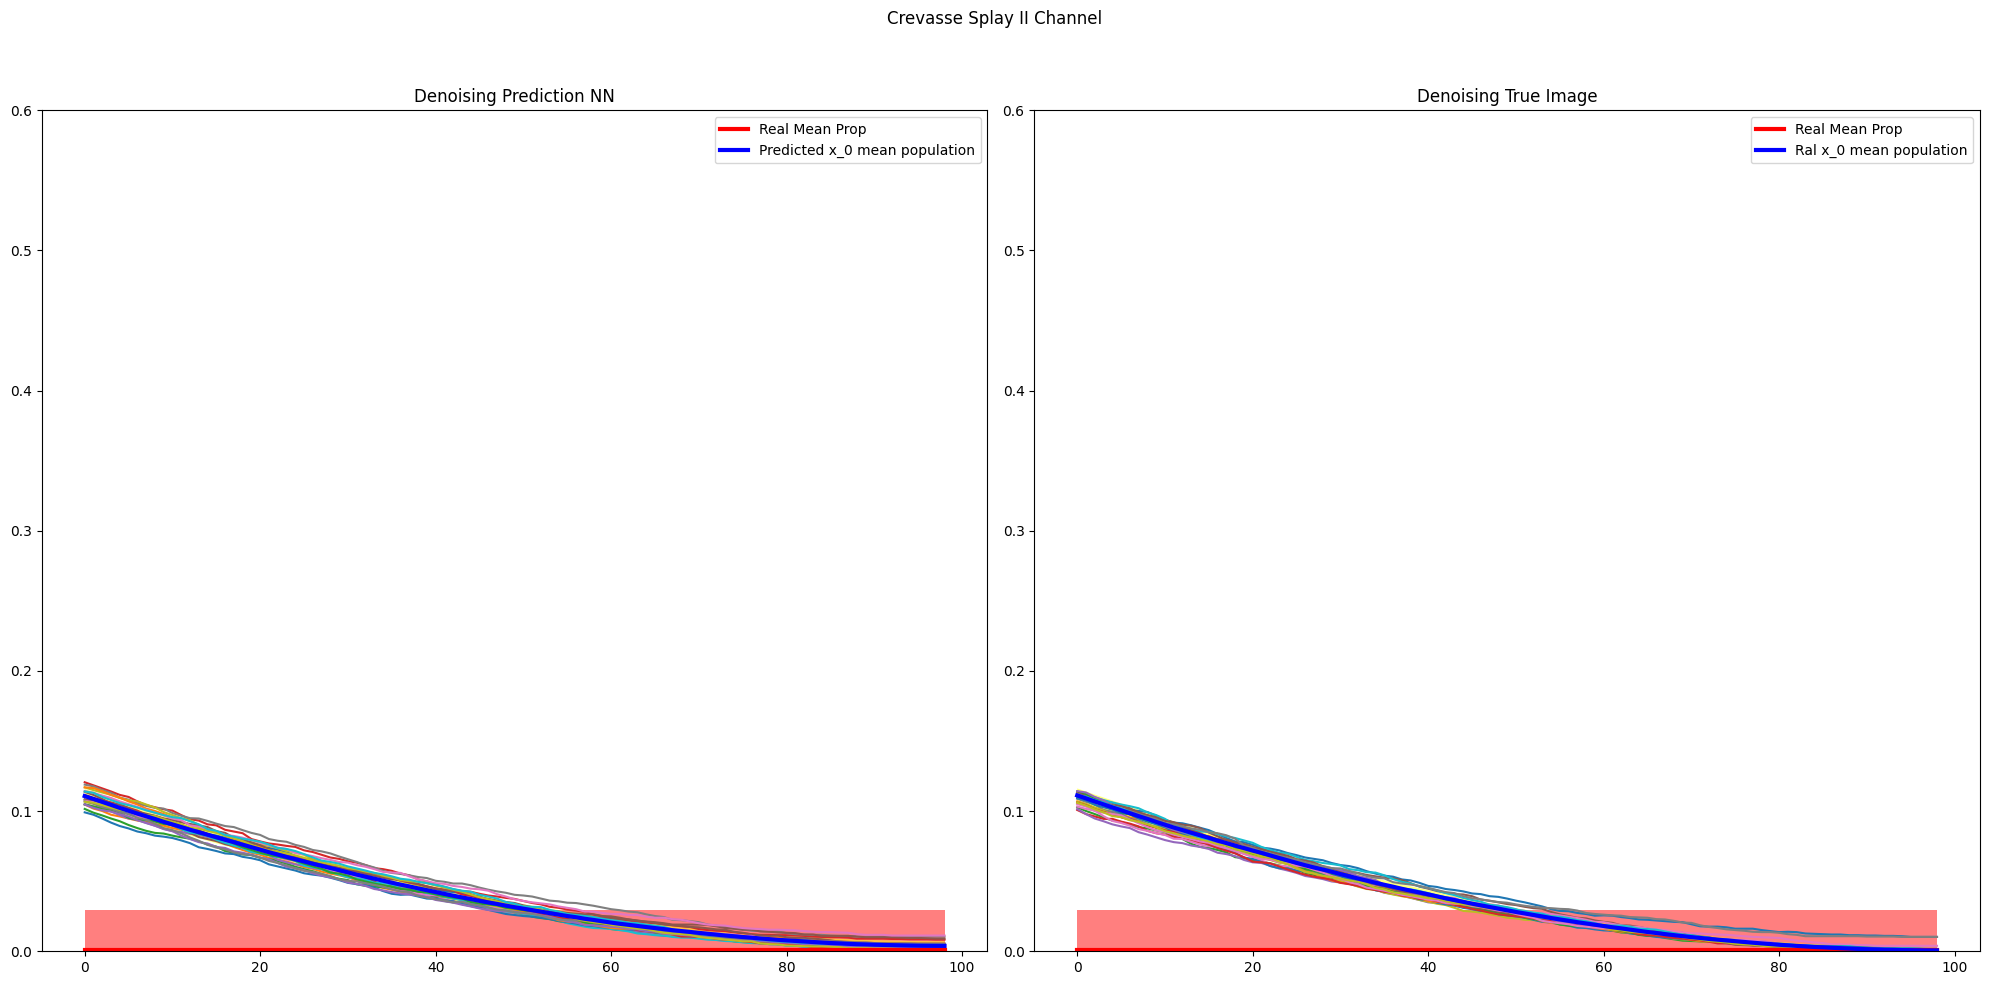

(99,) (99,)
(99,) (99,)


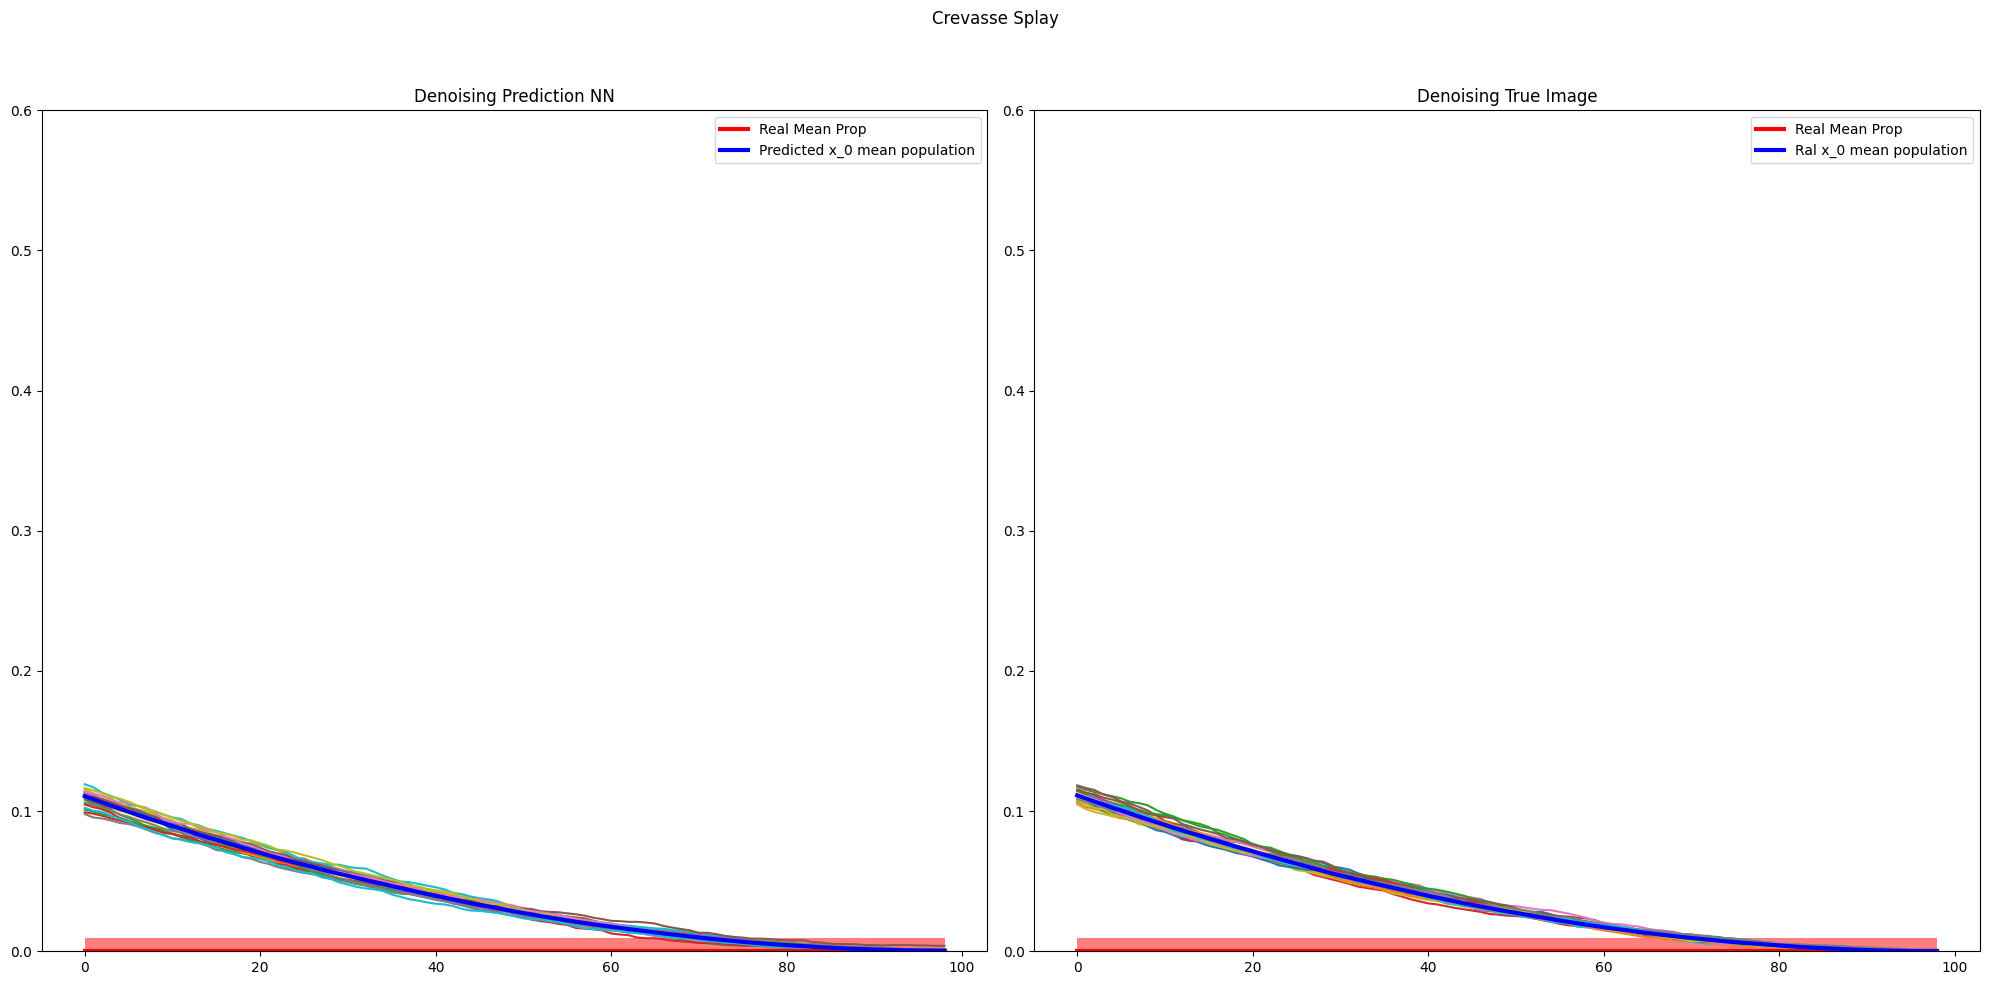

(99,) (99,)
(99,) (99,)


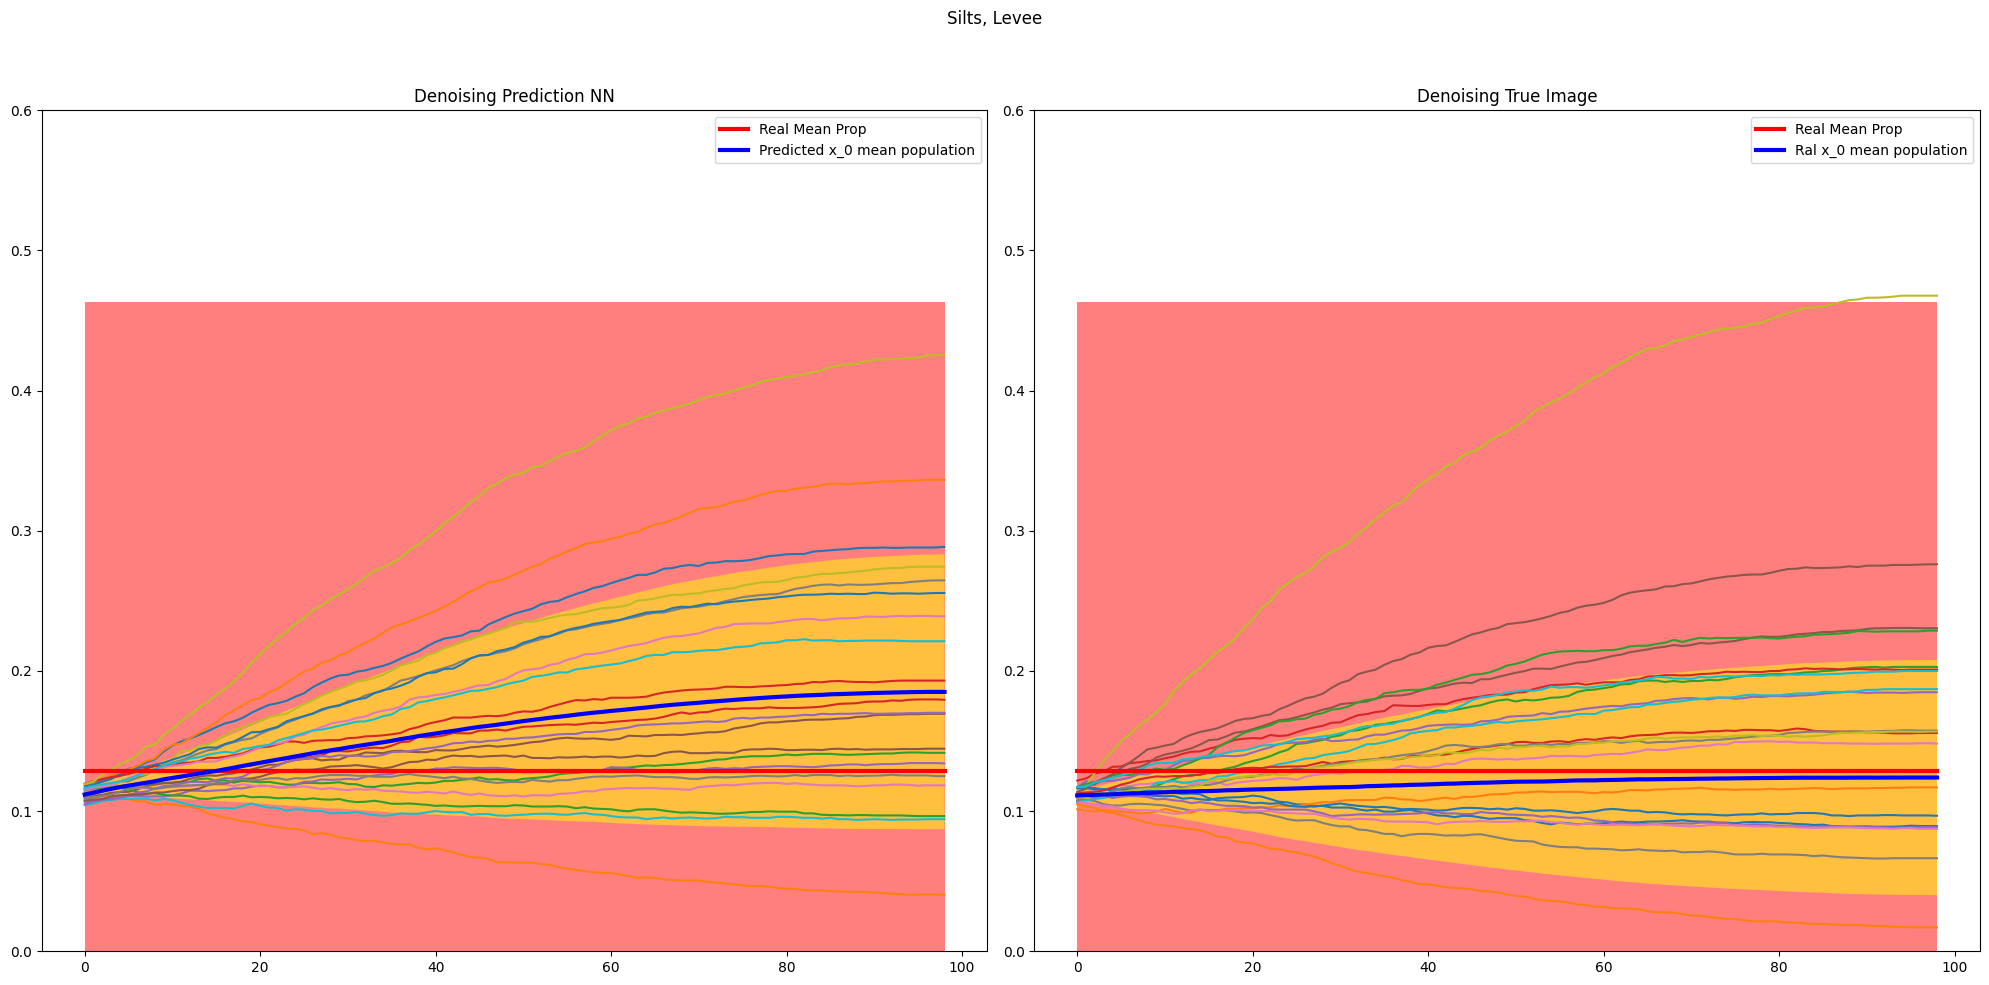

(99,) (99,)
(99,) (99,)


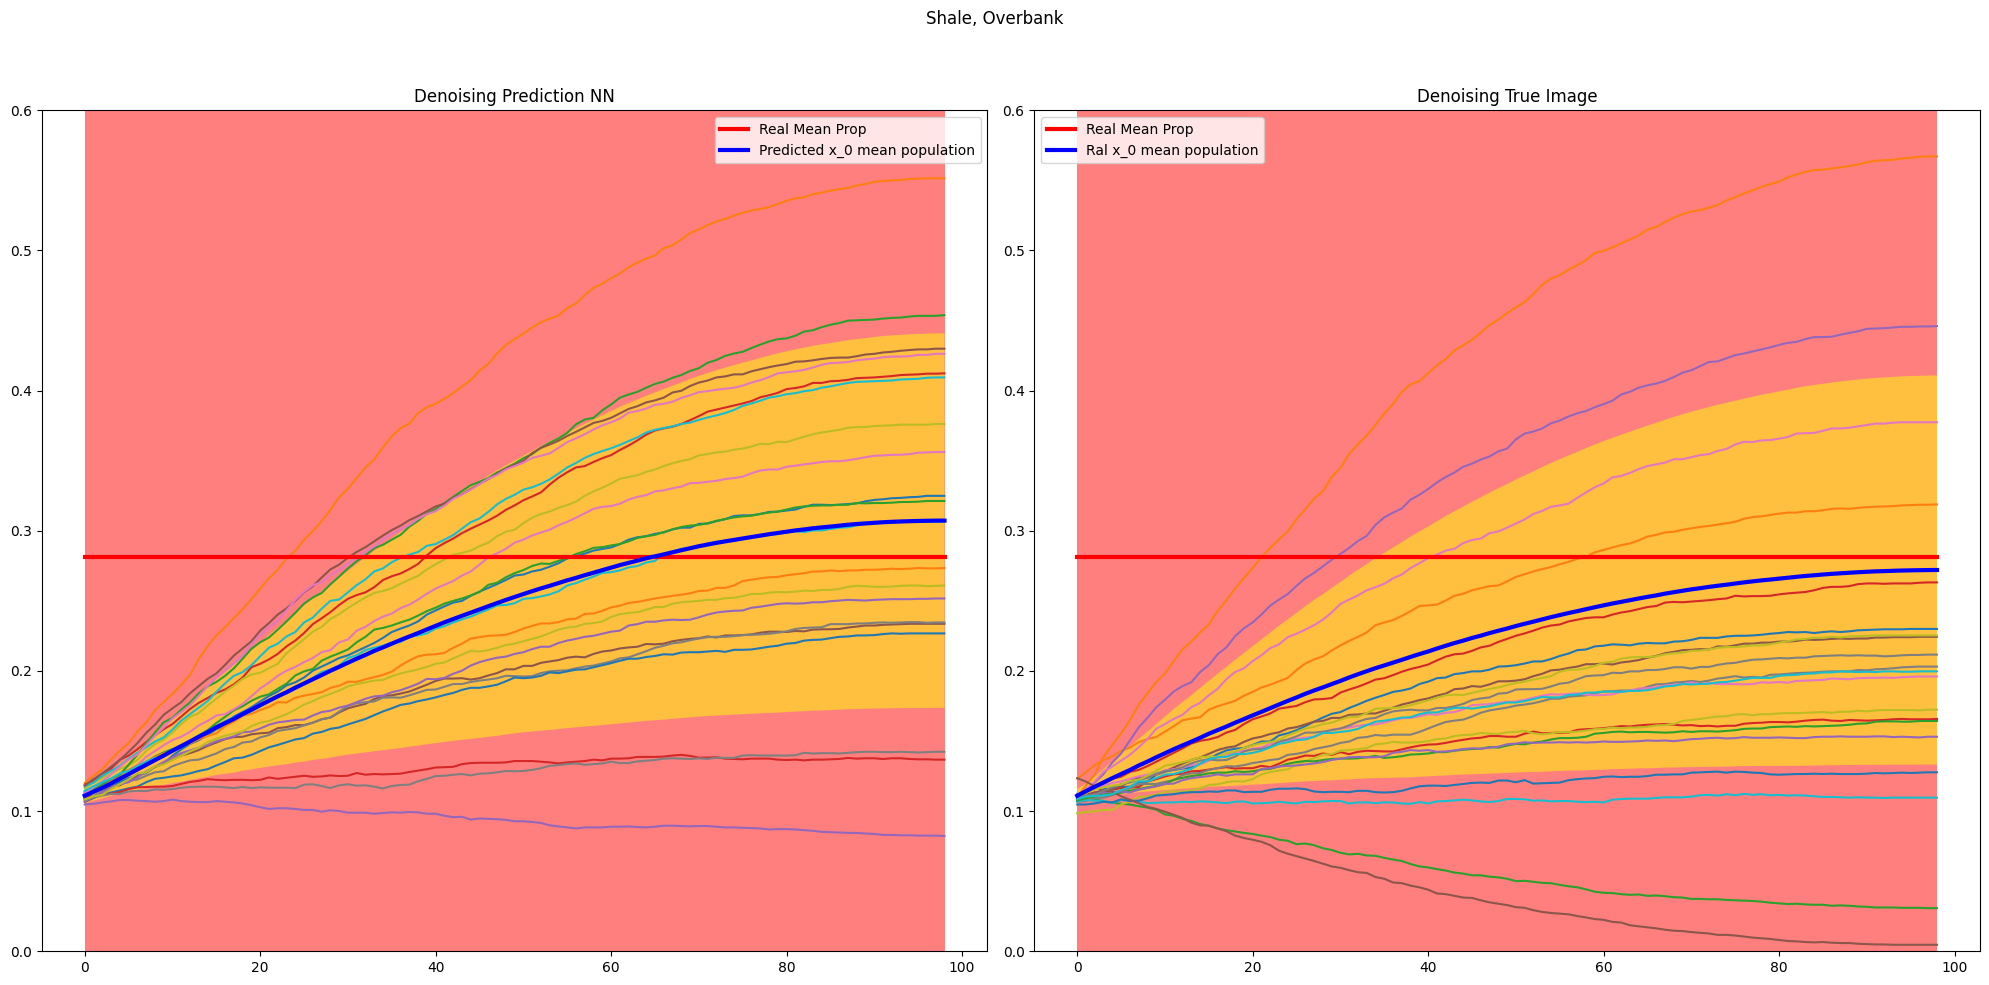

(99,) (99,)
(99,) (99,)


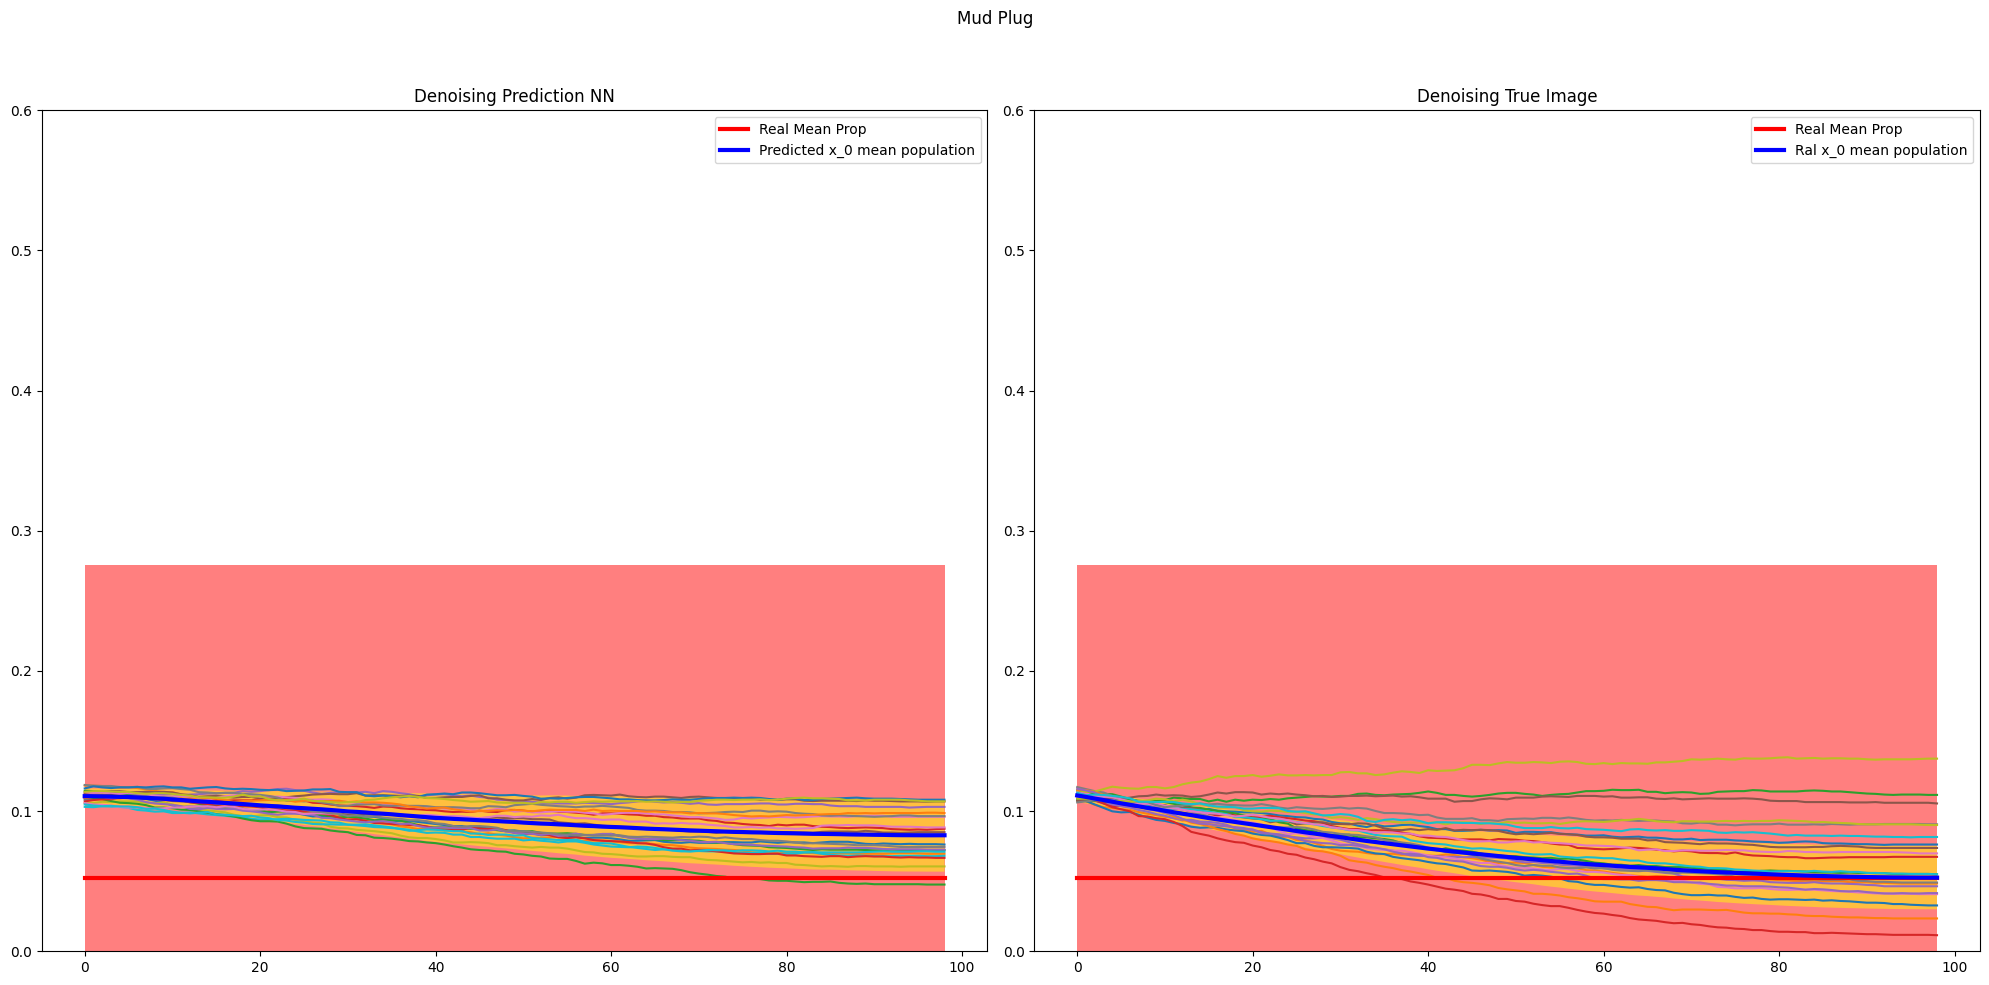

In [195]:

mu1 = np.array(total_proportions).mean(axis=-1)
print(mu1.shape)
sigma1 = np.array(total_proportions).std(axis=-1)
mu2 = np.array(total_real_proportions).mean(axis=-1)
sigma2 = np.array(total_real_proportions).std(axis=-1)

nb_lines_shown = 20

for i in range(9):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2 rows, 1 column
    
    # Plot the first set of data
    axs[0].plot(np.array(total_proportions)[:, i, :nb_lines_shown])
    current_real_std_prop_pos = np.array([real_mean_facies[i] + real_std_facies[i] for _ in range(len(total_proportions))])
    current_real_std_prop_neg = np.array([max(real_mean_facies[i] - real_std_facies[i], 0) for _ in range(len(total_proportions))])
    print(current_real_mean_prop.shape, current_real_std_prop.shape)
    axs[0].plot(np.array([real_mean_facies[i] for _ in range(len(total_proportions))]), linewidth=3, color='r', label='Real Mean Prop')
    axs[0].fill_between(range(99),current_real_std_prop_pos, current_real_std_prop_neg, facecolor='r', alpha=0.5)

    axs[0].plot(mu1[:, i], lw=3, label='Predicted x_0 mean population', color='blue')
    axs[0].fill_between(range(99), mu1[:, i]+sigma1[:, i], mu1[:, i]-sigma1[:, i], facecolor='yellow', alpha=0.5)

    axs[0].set_title('Denoising Prediction NN')
    axs[0].set_ylim(0, 0.60)
    axs[0].legend()
    
    
    ## plot it!
    #fig, ax = plt.subplots(1)

    

    # Plot the second set of data
    axs[1].plot(np.array(total_real_proportions)[:, i, :nb_lines_shown])
    current_real_mean_prop = np.array([real_mean_facies[i] for _ in range(len(total_proportions))])
    current_real_std_prop_pos = np.array([real_mean_facies[i] + real_std_facies[i] for _ in range(len(total_proportions))])
    current_real_std_prop_neg = np.array([max(real_mean_facies[i] - real_std_facies[i], 0) for _ in range(len(total_proportions))])
    print(current_real_mean_prop.shape, current_real_std_prop.shape)
    axs[1].plot(np.array([real_mean_facies[i] for _ in range(len(total_proportions))]), linewidth=3, color='r', label='Real Mean Prop')
    axs[1].fill_between(range(99),current_real_std_prop_pos, current_real_std_prop_neg, facecolor='r', alpha=0.5)

    
    axs[1].plot(mu2[:, i], lw=3, label='Ral x_0 mean population', color='blue')
    axs[1].fill_between(range(99),mu2[:, i]+sigma2[:, i], mu2[:, i]-sigma2[:, i], facecolor='yellow', alpha=0.5)

    axs[1].set_title('Denoising True Image')
    axs[1].set_ylim(0, 0.60)
    axs[1].legend()

    # Set a common title
    fig.suptitle(facies_names[i])
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Display the plots
    plt.show()

In [ ]:
from tqdm.autonotebook import tqdm

step_size = 0.002
steps = np.arange(0, 1, step_size, dtype=np.float64)
num_images = 500

init_x = tf.random.uniform((num_images, 64, 64), 0, 9, dtype=tf.dtypes.int32)
init_x = keras.utils.to_categorical(init_x, num_classes=9)

plt.imshow(np.argmax(init_x[0], axis=-1).reshape((64, 64)),
            interpolation='nearest', cmap=cmap, norm=norm)
plt.show()

next_noisy_images = tf.cast(init_x, dtype=tf.float64)

for i, step in enumerate(tqdm(np.flip(steps[:499]))):
    noisy_images = next_noisy_images

    input_diffusion_times = steps[498 - i] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)

    pred_images = model.denoise(
        noisy_images, input_diffusion_times, training=False
    )

        
    next_diffusion_times = steps[498 - (i + 1)] * tf.ones((num_images, 1, 1, 1), dtype=tf.float64)
    next_noisy_images, _, _, _ = tf.map_fn(lambda x: model.conditional_reverse_probability(x[0], x[1], x[2], x[3], sample=True),
                                           (pred_images, noisy_images, input_diffusion_times, next_diffusion_times), parallel_iterations=64)


/tmp/ipykernel_145243/1171292542.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 10))


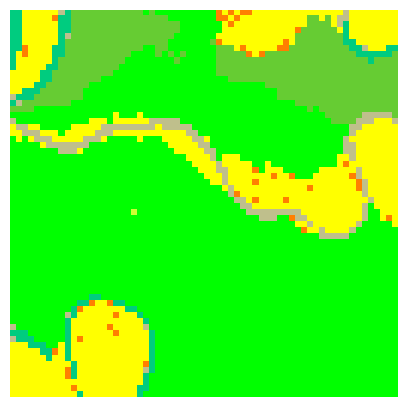

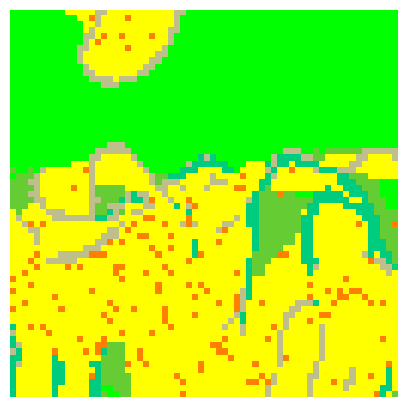

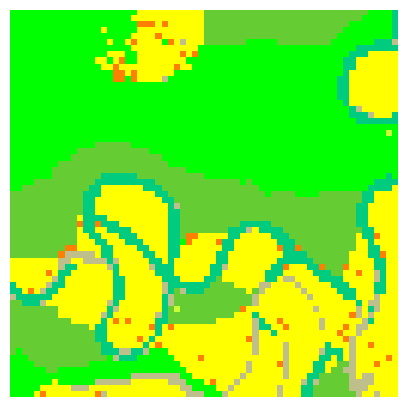

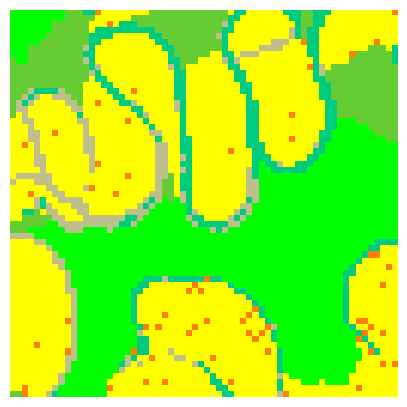

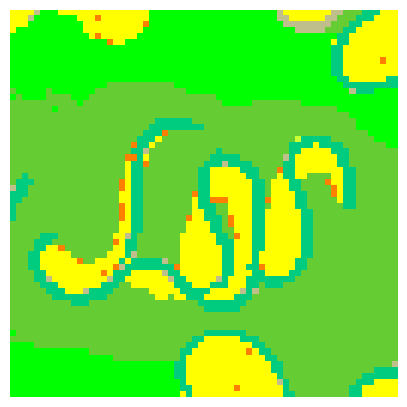

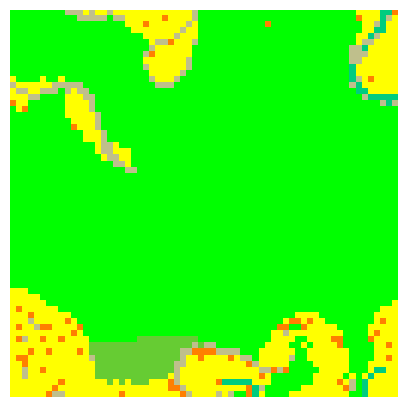

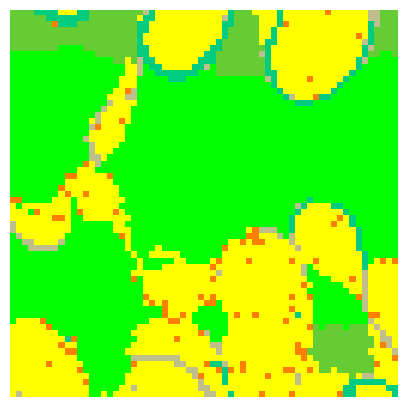

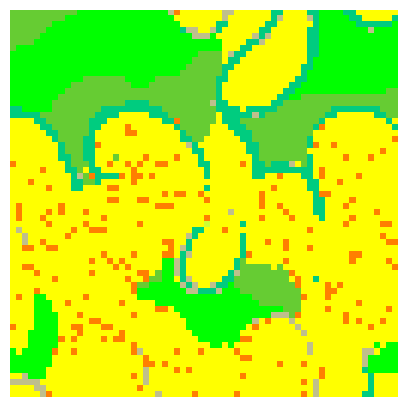

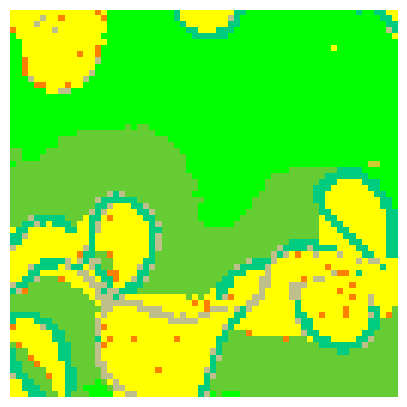

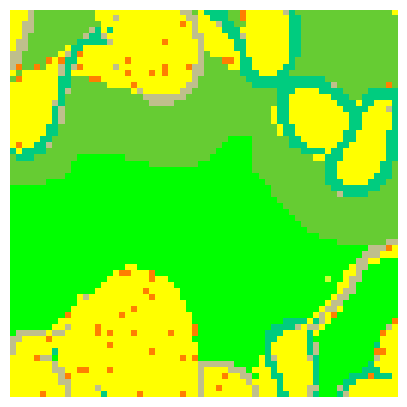

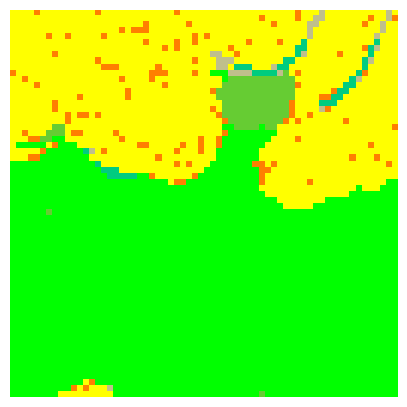

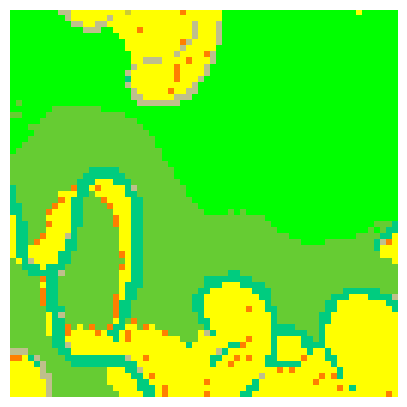

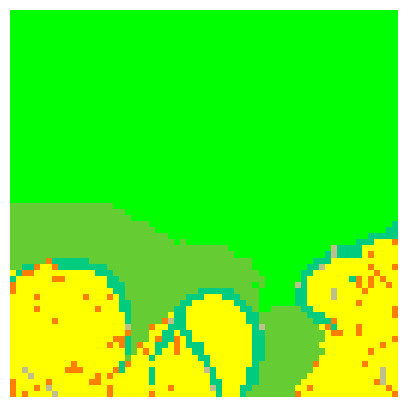

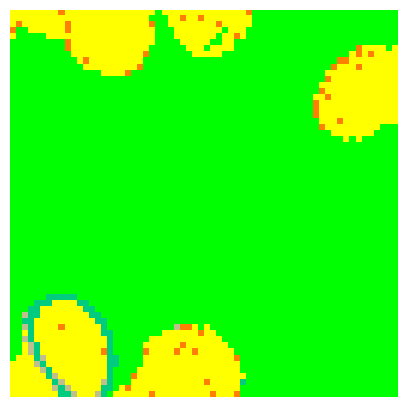

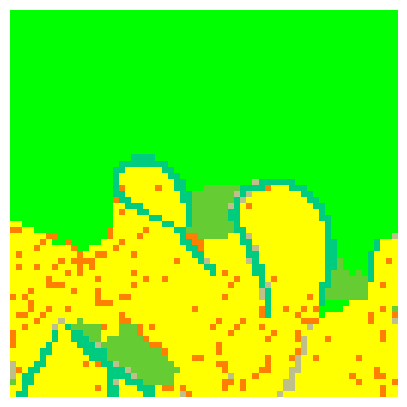

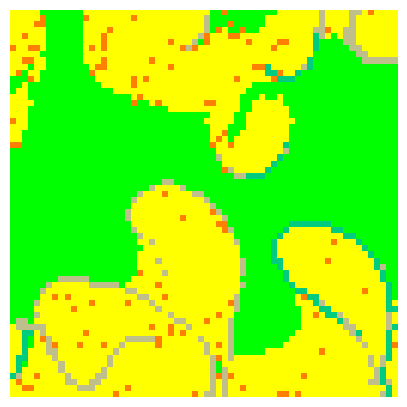

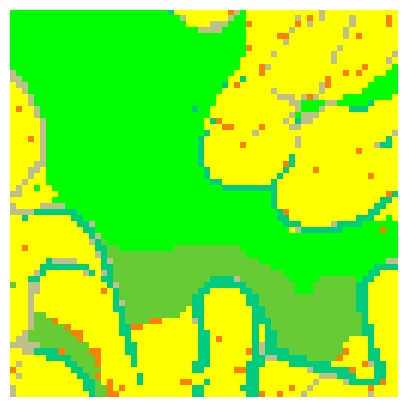

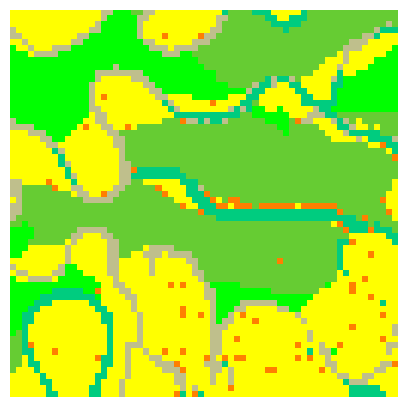

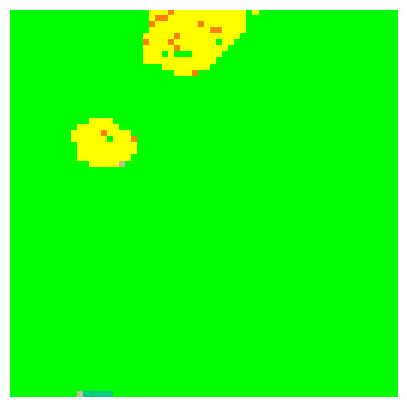

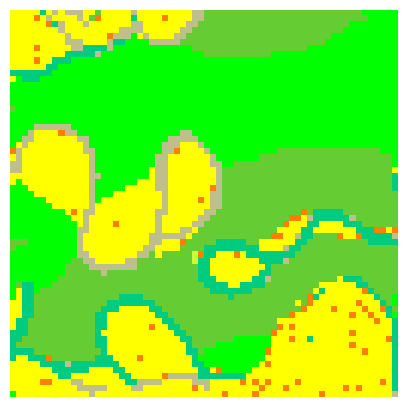

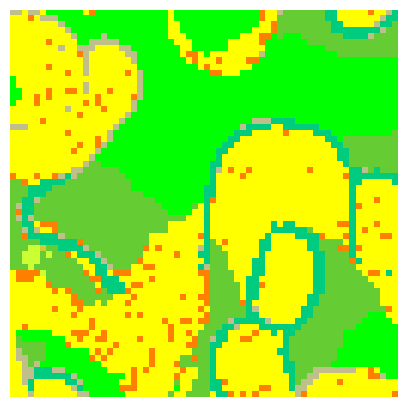

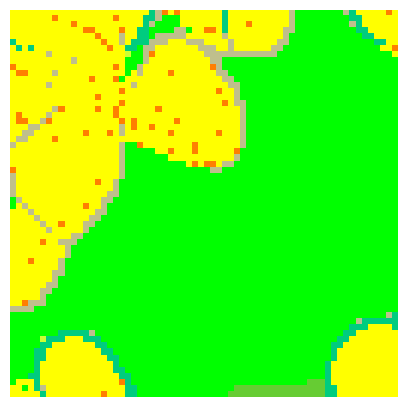

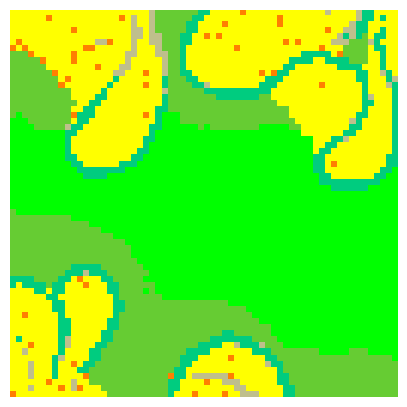

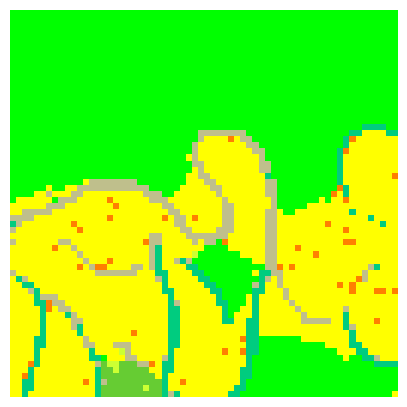

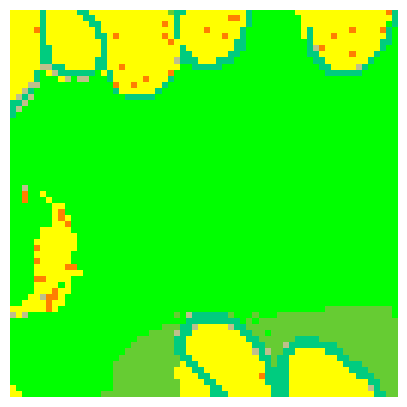

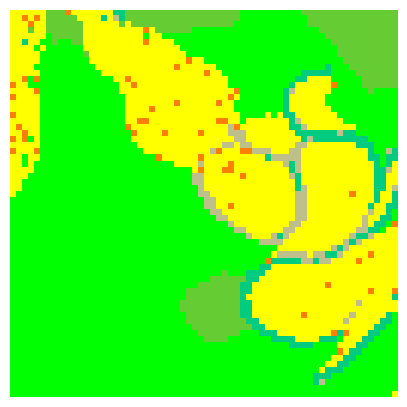

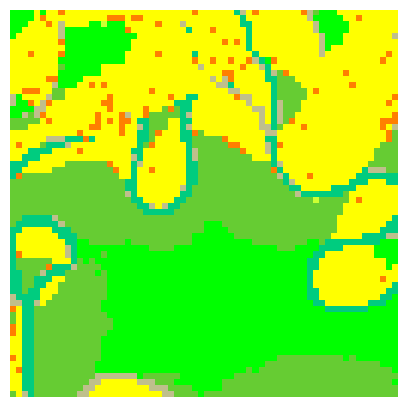

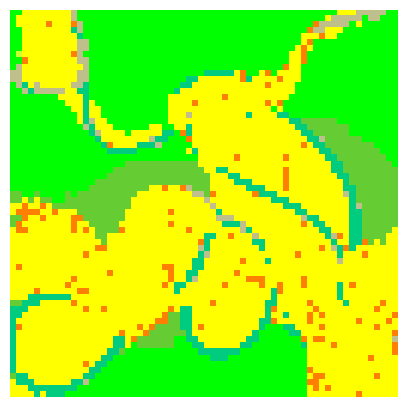

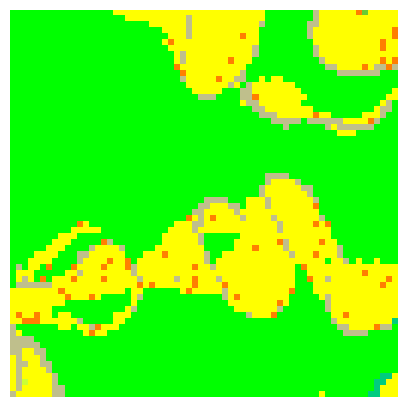

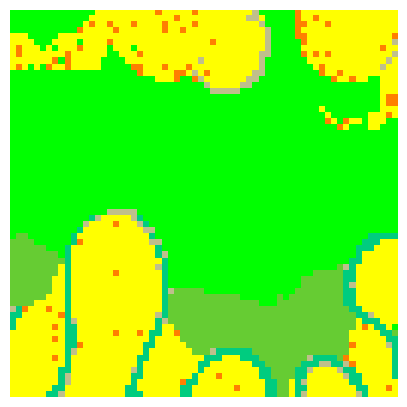

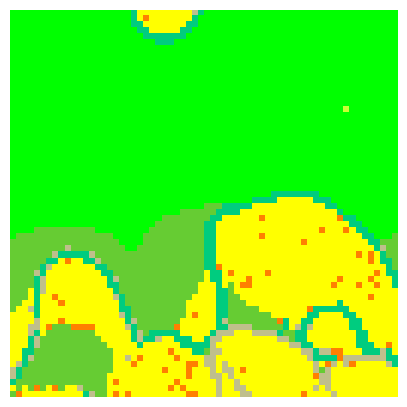

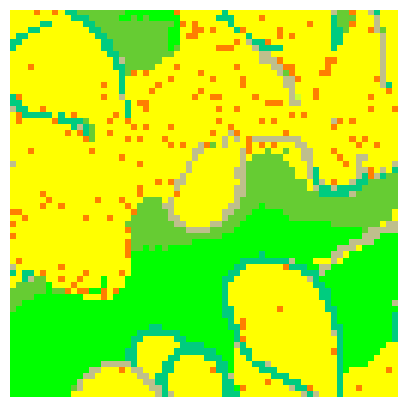

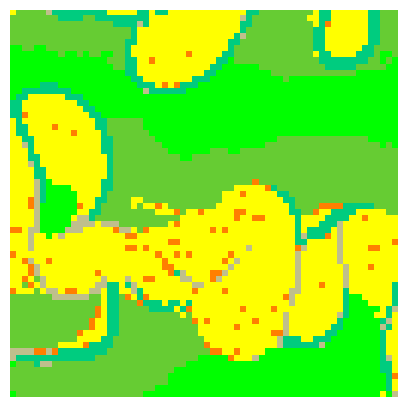

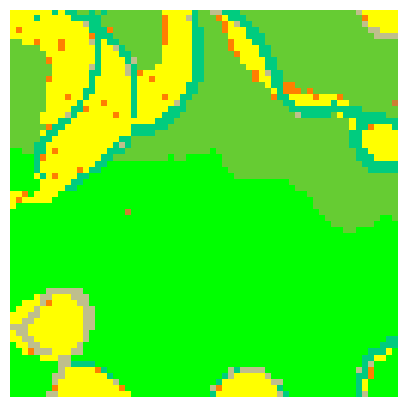

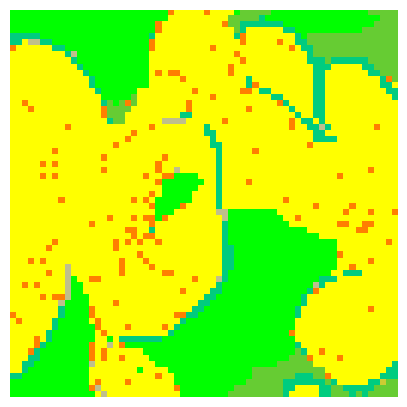

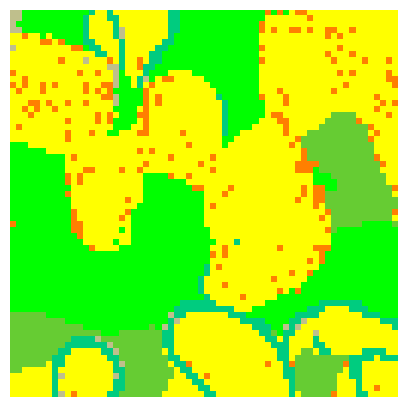

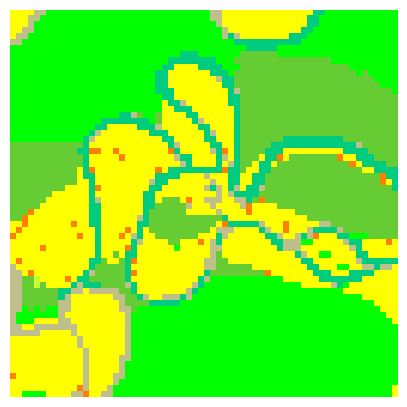

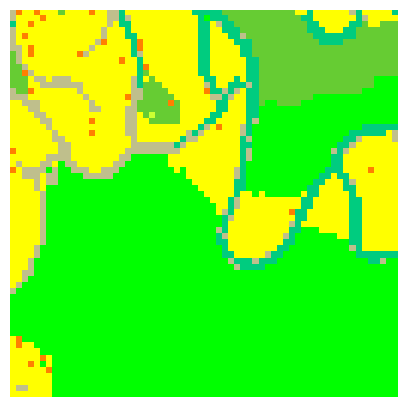

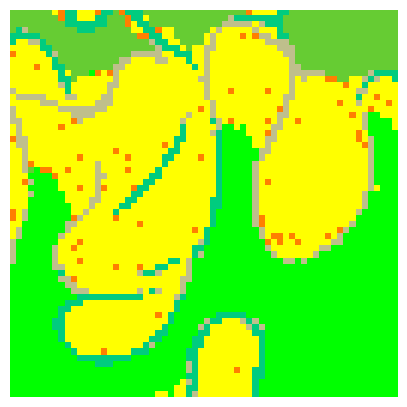

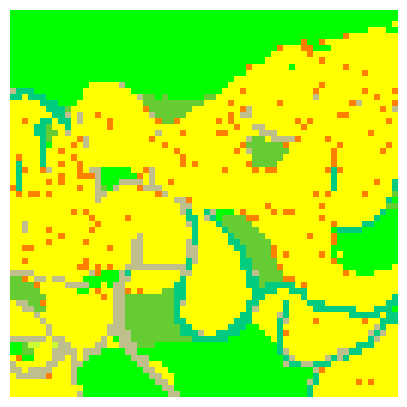

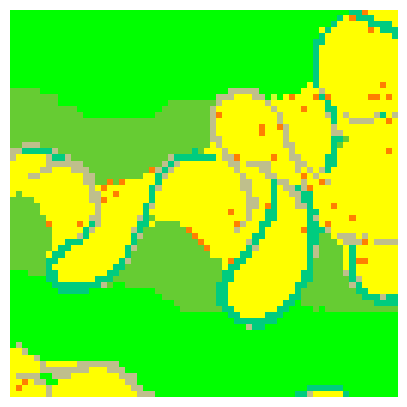

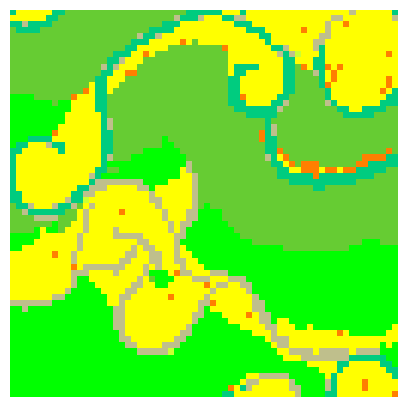

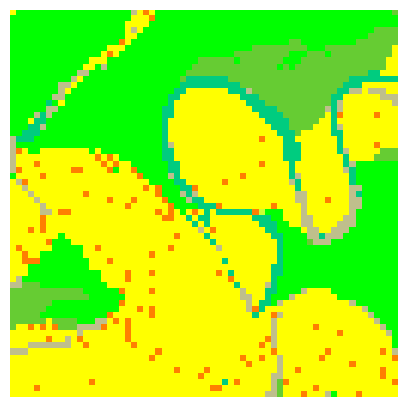

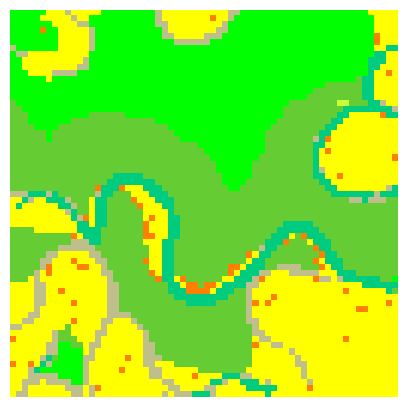

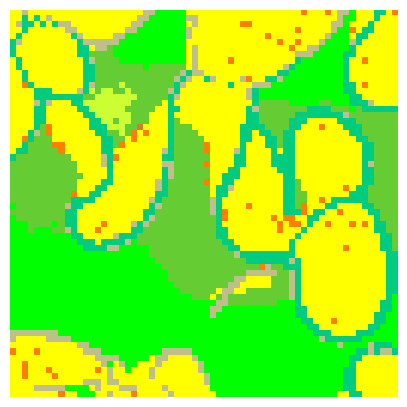

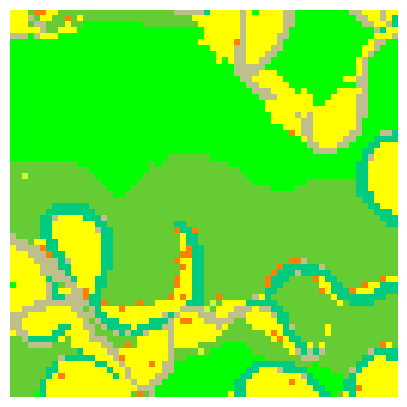

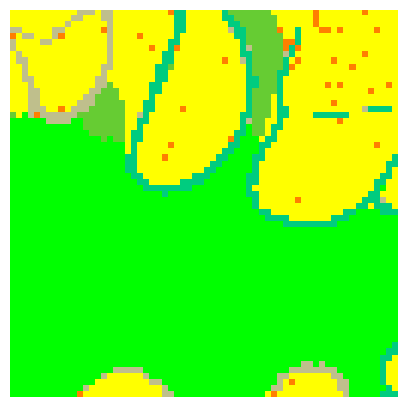

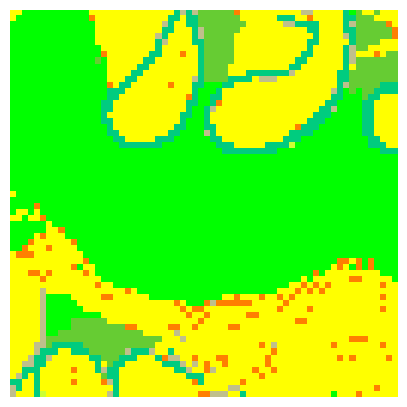

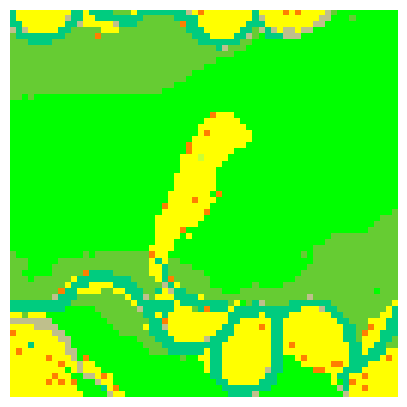

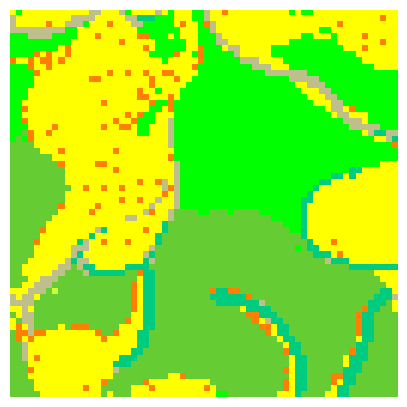

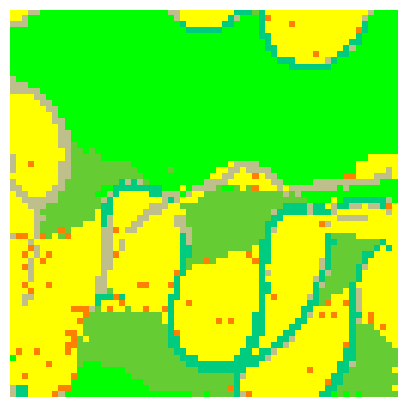

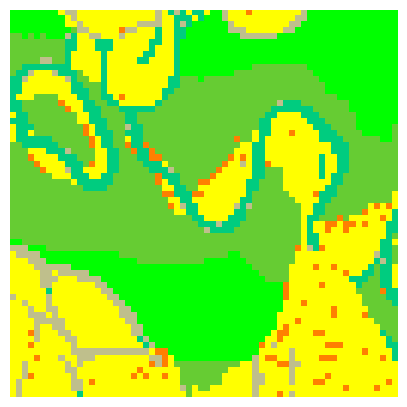

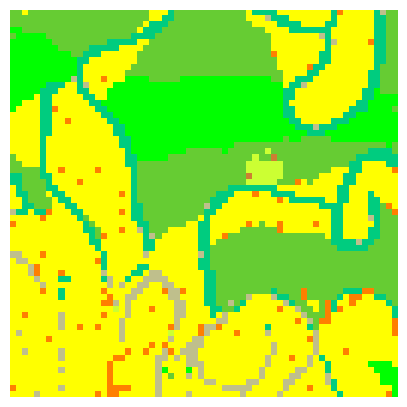

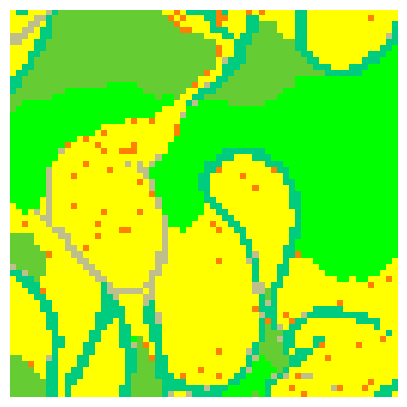

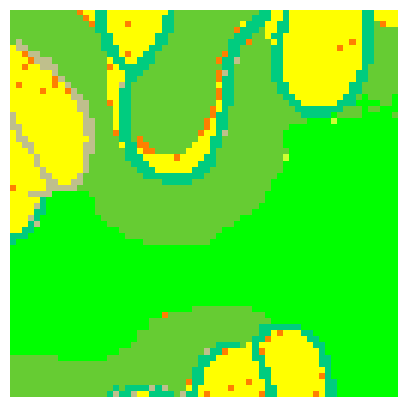

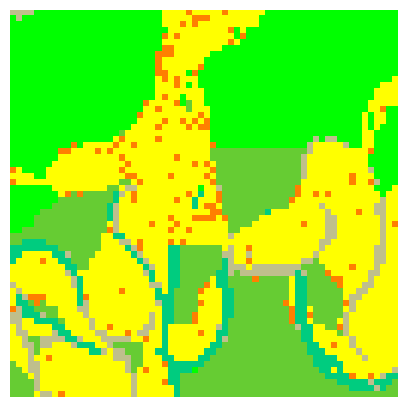

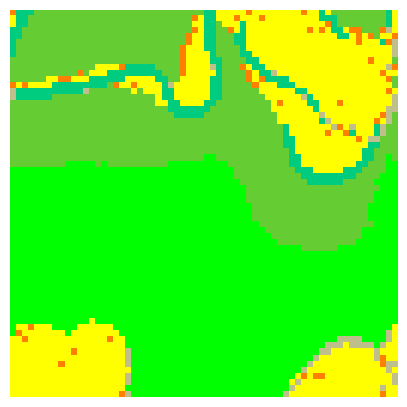

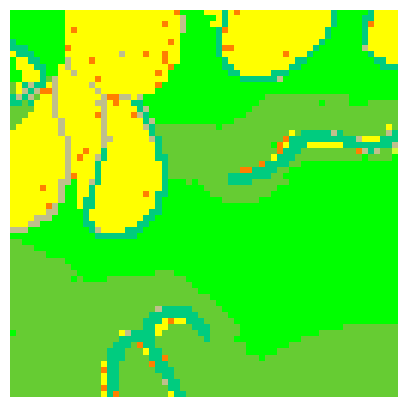

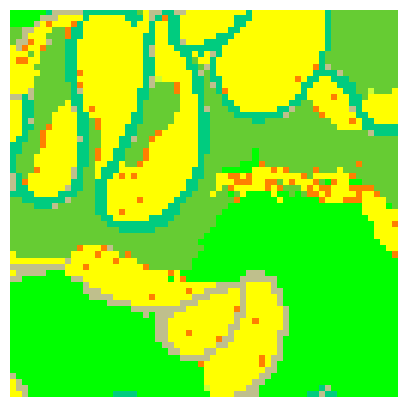

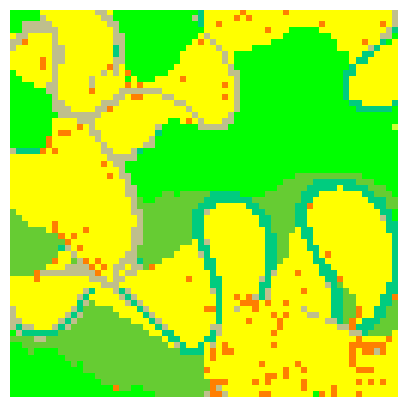

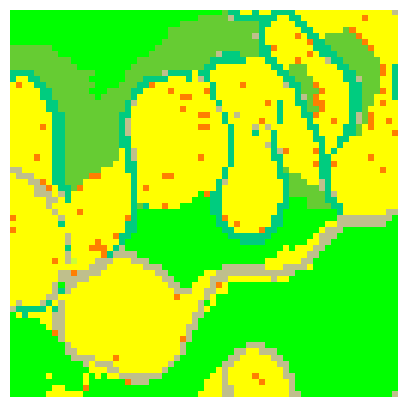

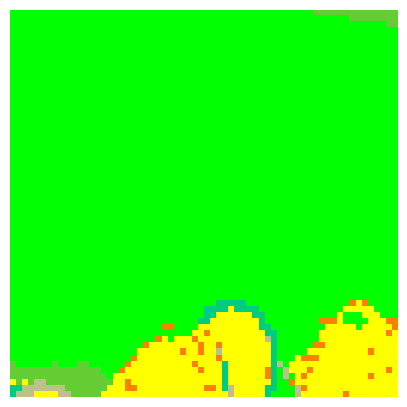

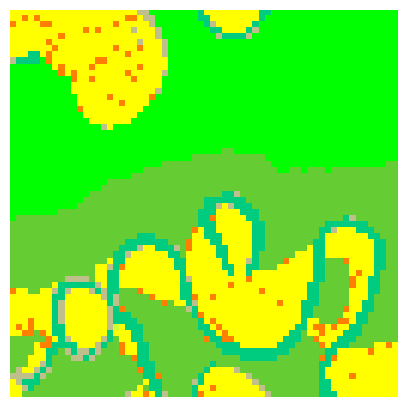

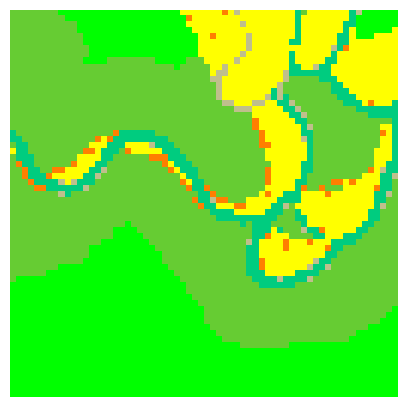

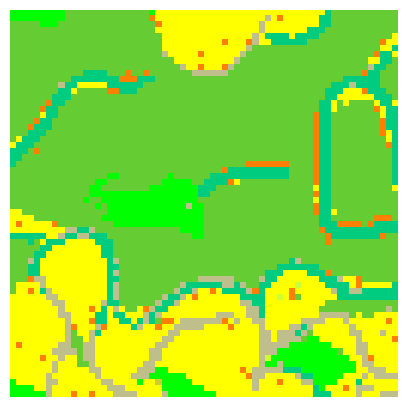

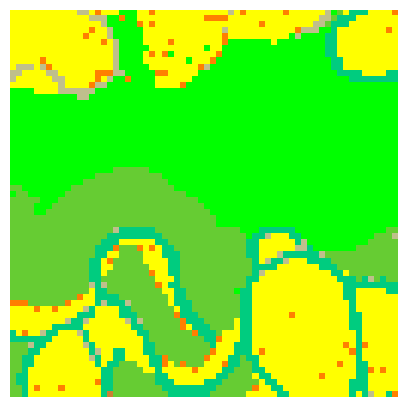

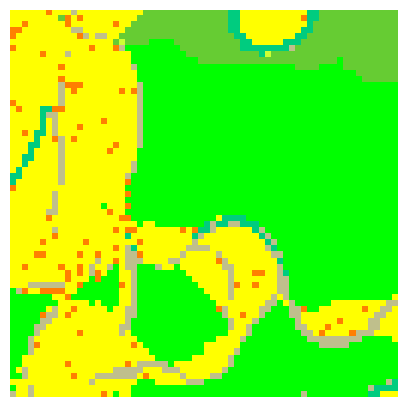

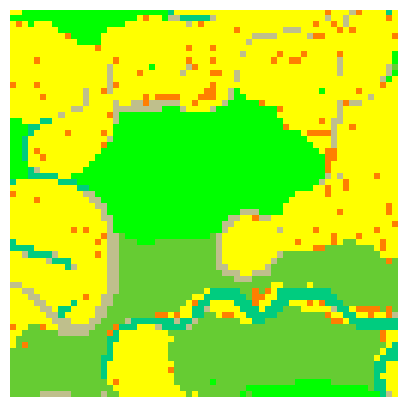

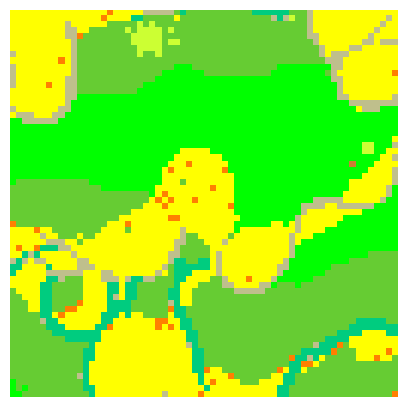

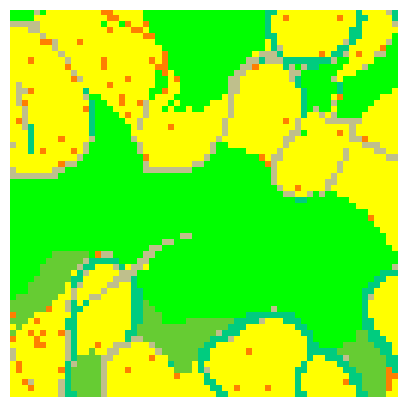

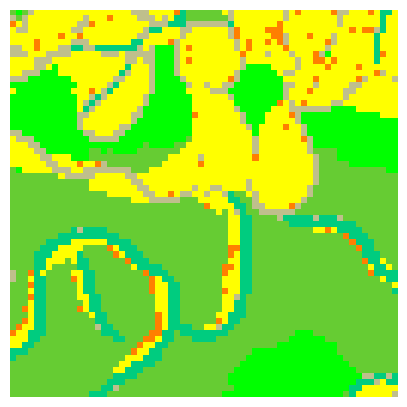

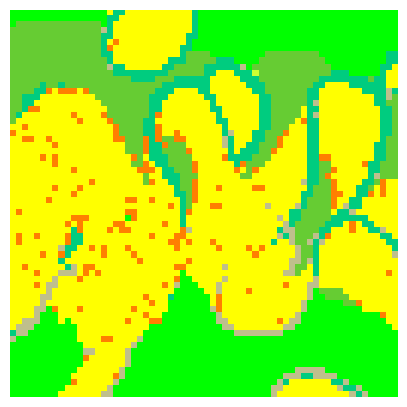

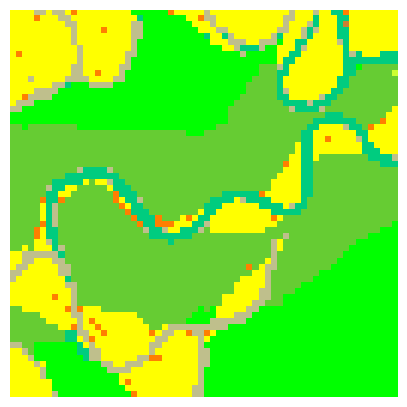

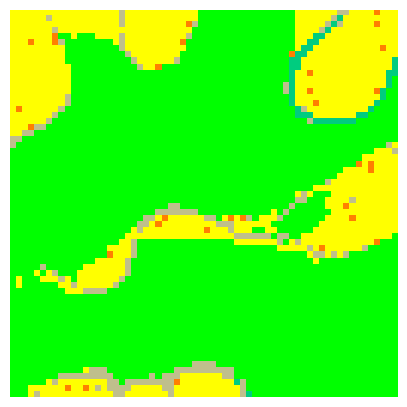

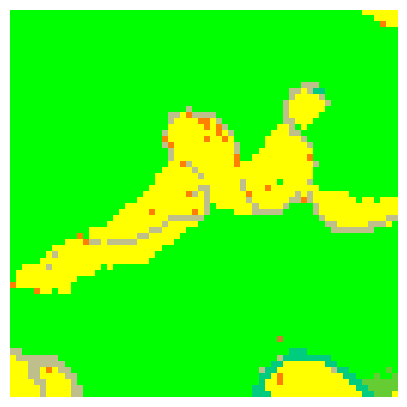

In [36]:
    for j in range(100):
        plt.figure(figsize=(5, 10))
        plt.imshow(np.argmax(next_noisy_images[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")

/tmp/ipykernel_145243/1251166358.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 10))


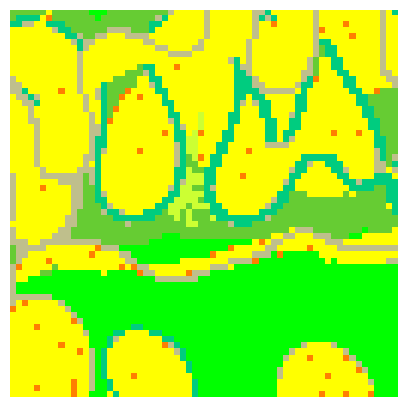

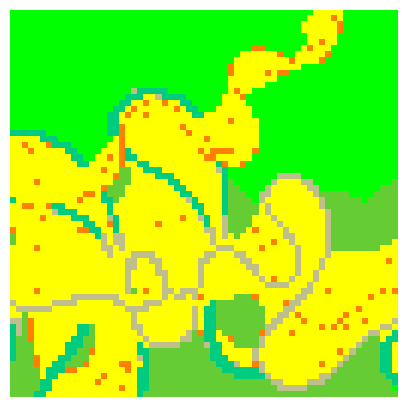

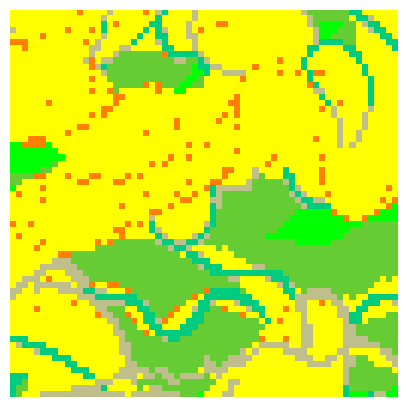

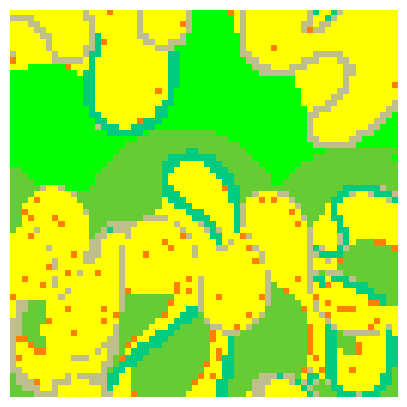

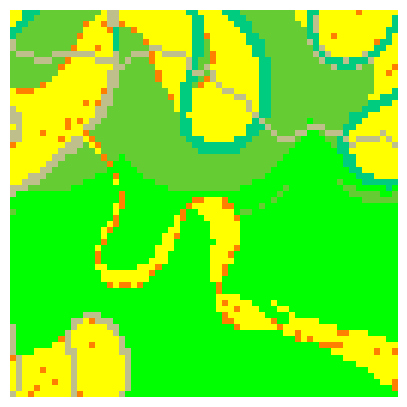

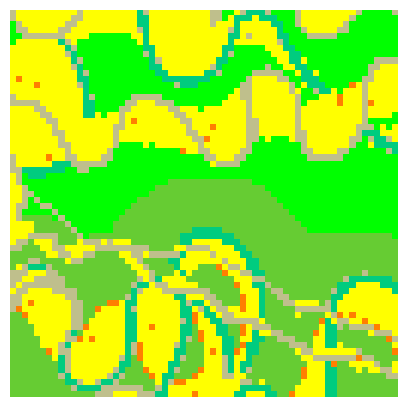

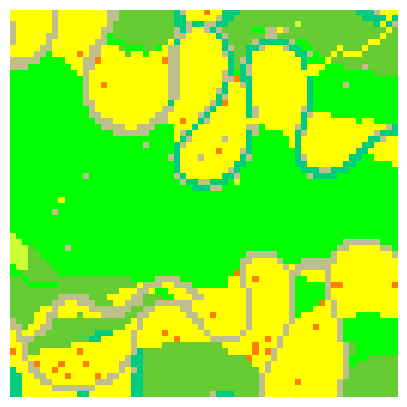

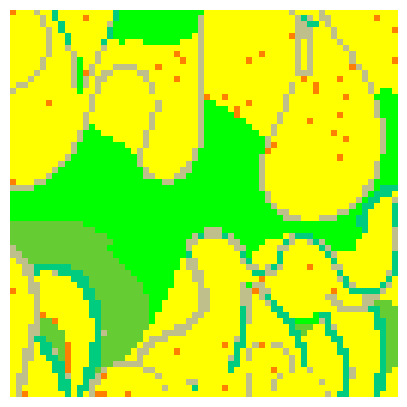

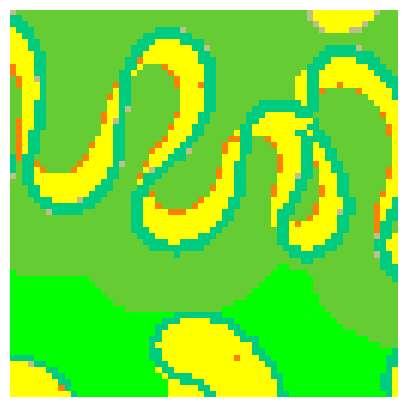

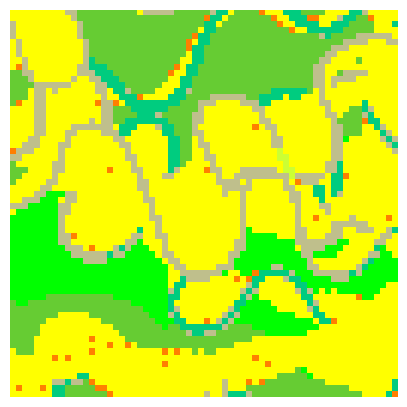

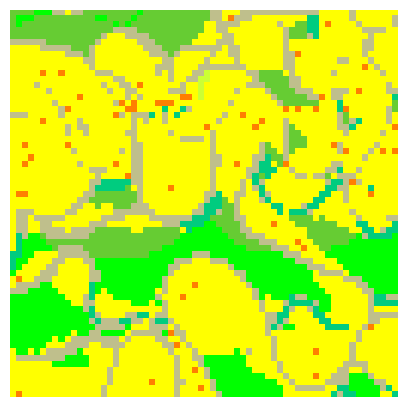

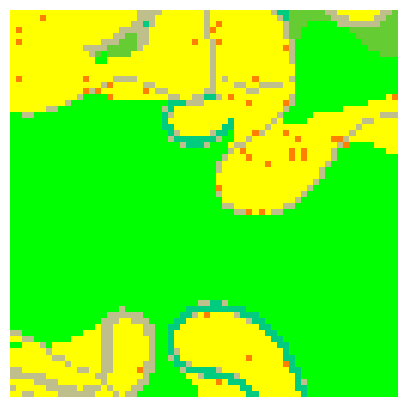

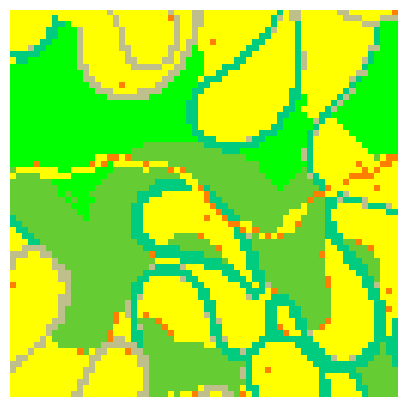

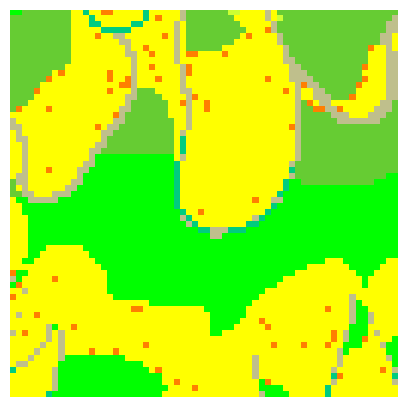

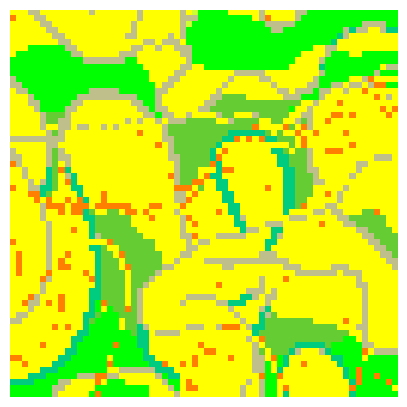

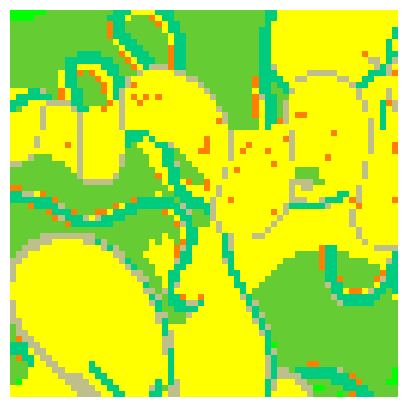

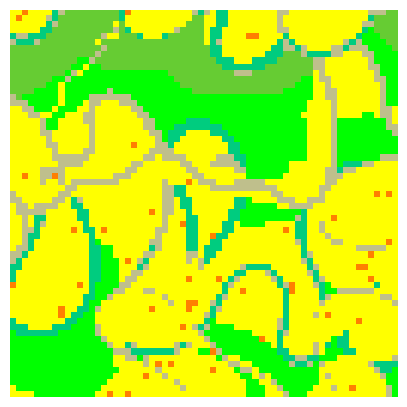

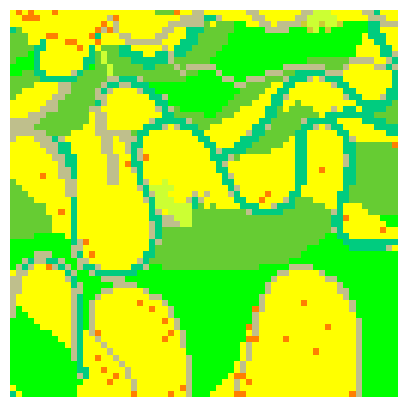

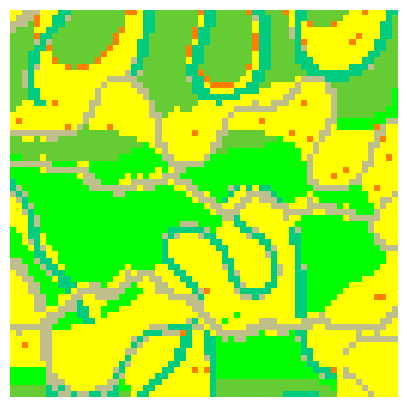

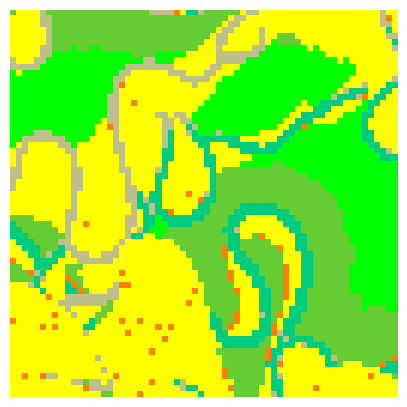

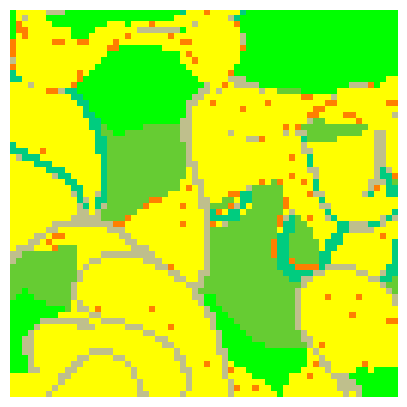

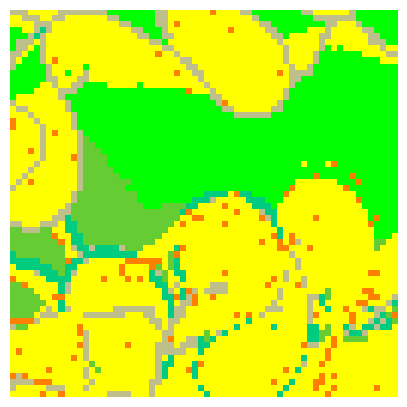

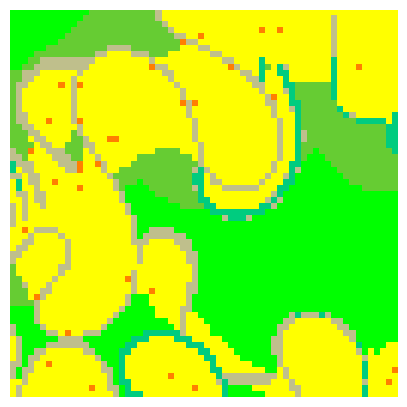

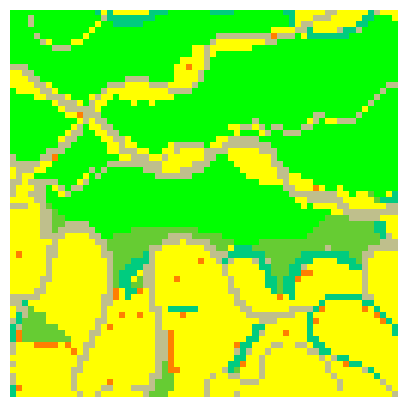

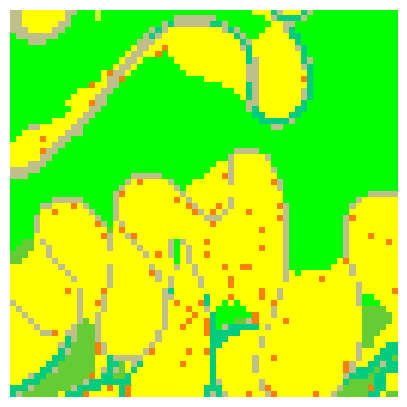

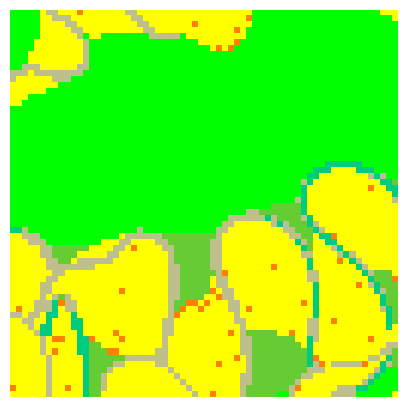

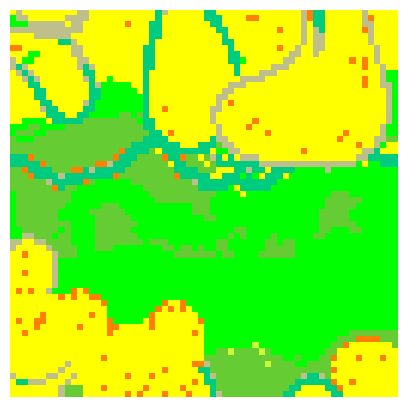

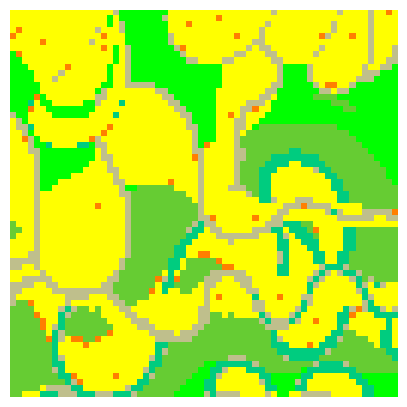

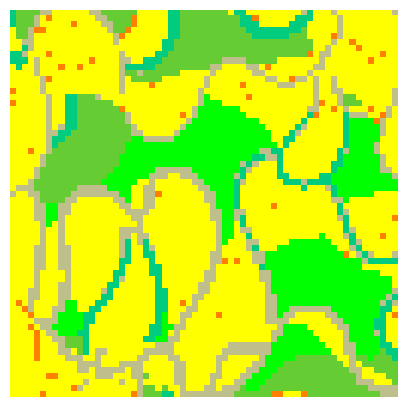

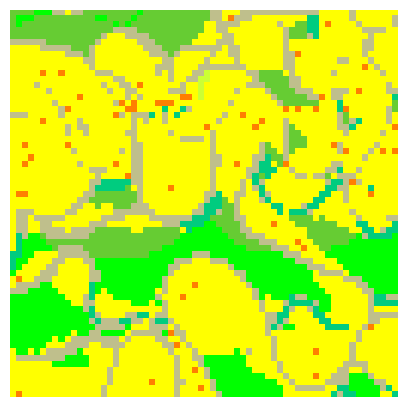

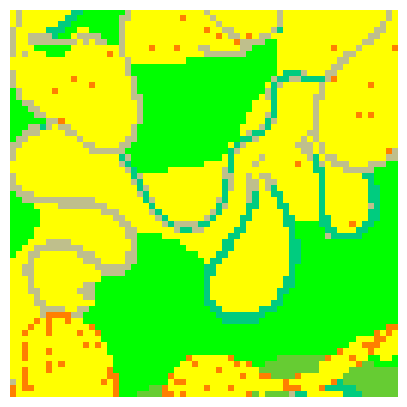

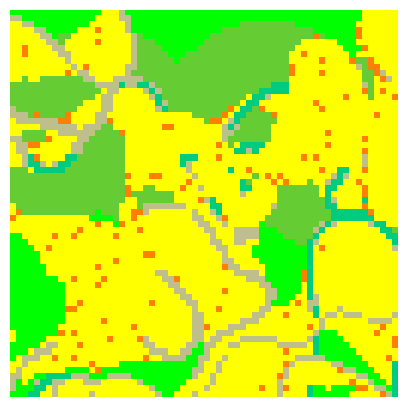

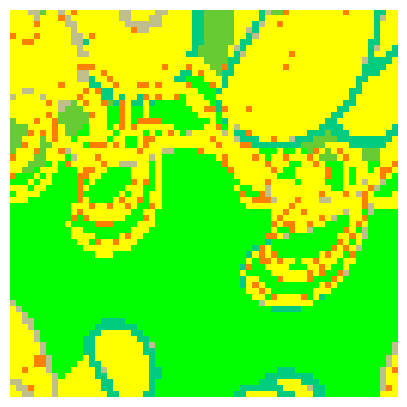

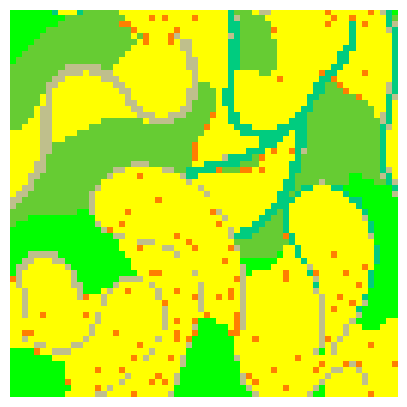

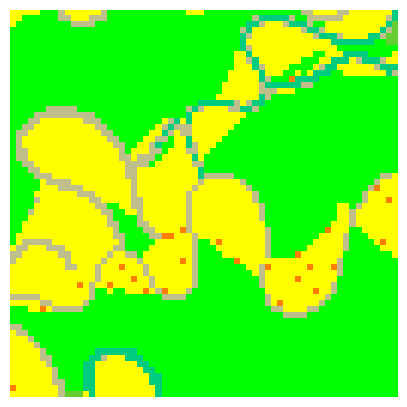

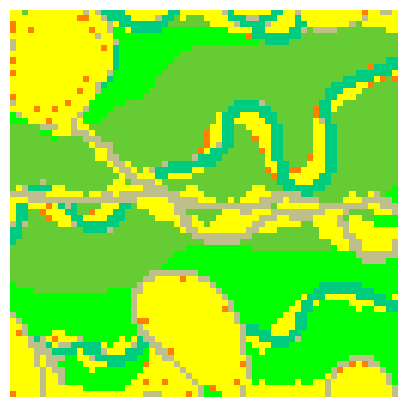

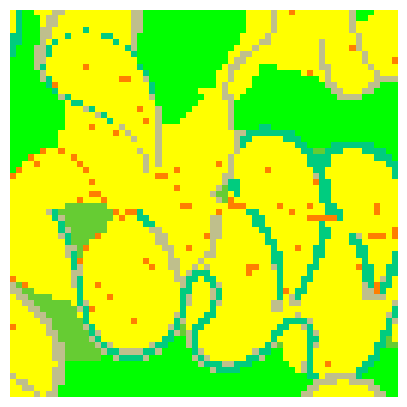

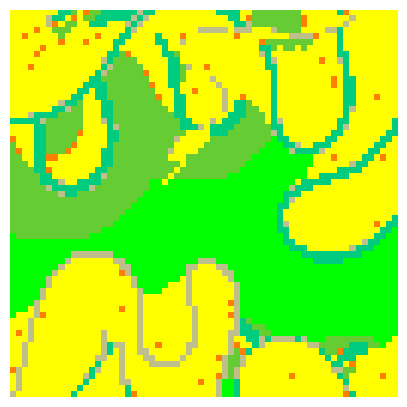

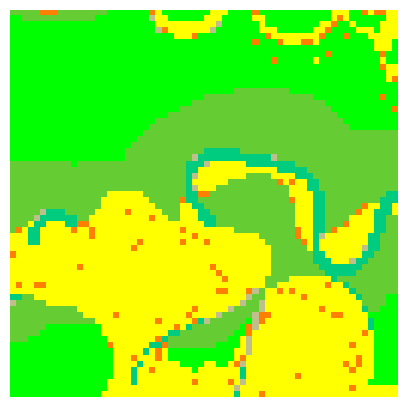

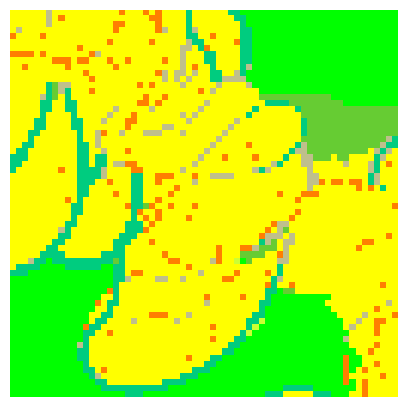

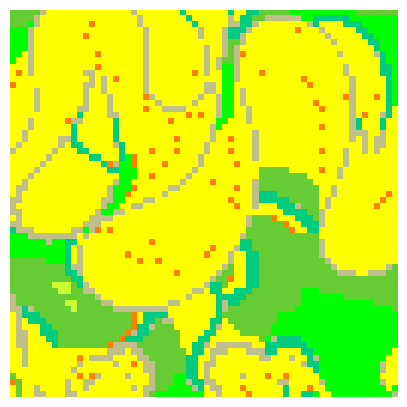

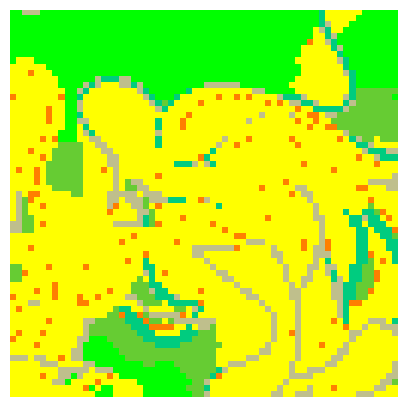

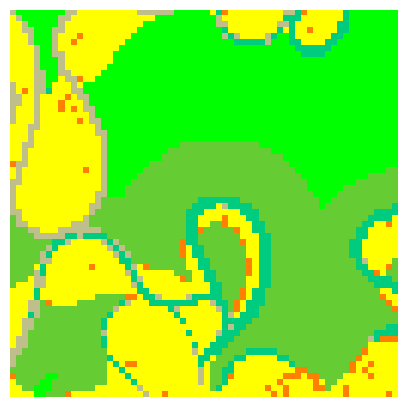

In [37]:
    for j in range(50):
        plt.figure(figsize=(5, 10))
        plt.imshow(np.argmax(x_test[j].numpy(), axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
        plt.axis("off")